# Miller age

In [1]:
ood_seed = 3

In [2]:
num_ood = 1  # not functioning

In [3]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [5]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "dataset_complete_Miller.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["age"] = adata.obs["age"].astype("str").astype("category")

adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
adata.obs["age_continuous"] = adata.obs["age"].astype(float)
df = adata.obs.groupby(["cell_type", "age"]).size()
df2 = adata.obs.groupby(["cell_type"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 100 and df2[i[0]] > 350]

In [6]:
df

cell_type                            age 
Bud tip adjacent cells               11.5    169
                                     15.0    282
                                     18.0    777
                                     21.0      0
Bud tip progenitor                   11.5    273
                                     15.0    338
                                     18.0    683
                                     21.0      2
Deuterosomal cells                   11.5      2
                                     15.0    145
                                     18.0    111
                                     21.0     49
Hub cells                            11.5    218
                                     15.0    308
                                     18.0    620
                                     21.0      2
Intermediate trachea ciliated cells  11.5      0
                                     15.0     59
                                     18.0      0
                           

In [7]:
availables, len(availables)

([(('Bud tip adjacent cells', '11.5'), 169),
  (('Bud tip adjacent cells', '15.0'), 282),
  (('Bud tip adjacent cells', '18.0'), 777),
  (('Bud tip progenitor', '11.5'), 273),
  (('Bud tip progenitor', '15.0'), 338),
  (('Bud tip progenitor', '18.0'), 683),
  (('Hub cells', '11.5'), 218),
  (('Hub cells', '15.0'), 308),
  (('Hub cells', '18.0'), 620),
  (('Lung ciliated cells', '15.0'), 692),
  (('Lung ciliated cells', '18.0'), 494),
  (('Lung ciliated cells', '21.0'), 165),
  (('Lung secretory cells', '15.0'), 595),
  (('Lung secretory cells', '21.0'), 438),
  (('Submucosal gland cells', '15.0'), 380),
  (('Submucosal gland cells', '18.0'), 156)],
 16)

In [8]:
def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["cell_type"] == choice[0][0]) & (adata.obs["age"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

(('Bud tip progenitor', '11.5'), 273)

Removed datapoint: 273


In [9]:
adata

AnnData object with n_obs × n_vars = 7132 × 8192
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse', 'n_genes', 'age_continuous'
    uns: 'rank_genes_groups'
    obsm: 'Unintegrated', 'X_pca', 'harmony'

In [10]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"miller_ood_expression-seed-{ood_seed}_size-{num_ood}"
)

In [11]:
# vae = tardis.MyModel.load(dir_path, adata=adata)

In [12]:
(
    adata.obs["integration_donor"].nunique(),
    adata.obs["integration_biological_unit"].nunique(),
    adata.obs["integration_sample_status"].nunique(),
    adata.obs["integration_library_platform_coarse"].nunique(),
) 

(8, 1, 1, 1)

In [13]:
warmup_epoch_range = [6, 48]

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

tardis_loss_weight_1 = 100
tardis_loss_weight_2 = 10

disentenglement_targets_configurations=[
    dict(
        obs_key = "age",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = True,
                weight = tardis_loss_weight_1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = tardis_loss_weight_2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = tardis_loss_weight_2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = tardis_loss_weight_1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
    dict(
        obs_key = "integration_donor",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = True,
                weight = tardis_loss_weight_1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = tardis_loss_weight_2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = tardis_loss_weight_2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = tardis_loss_weight_1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]


In [14]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)), 
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.25,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates=True,
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=128,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-4,
        weight_decay=1e-4,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key="cell_type",
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

tardis.MyModel.setup_wandb(
    wandb_configurations=tardis.config.wandb,
    hyperparams=dict(
        model_params=model_params,
        train_params=train_params,
        dataset_params=dataset_params,
    )
)

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

W&B logger initialized with the following parameters: 
Entity: inecik-academic
Project: tardis_conference
ID: xq29yjn2
Name: scruffy-looking-federation-331
Tags: tardis, conference, figures, final
Notes: Final runs for Tardis before conference.
URL: https://wandb.ai/inecik-academic/tardis_conference/runs/xq29yjn2
Directory: /lustre/groups/ml01/workspace/kemal.inecik/wandb/run-20240505_020001-xq29yjn2/files



/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `age` for `training` set. Number of elements in each group: 351,2326,2393,636
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `integration_donor` for `training` set. Number of elements in each group: 126,225,538,246,1542,1487,906,636
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `age` for `validation` set. Number of elements in each group: 83,598,612,133
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `integration_donor` for `validation` set. Number of elements in each group: 24,59,145,60,393,379,233,133
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:04<49:22,  4.95s/it]

Epoch 1/600:   0%|          | 1/600 [00:04<49:22,  4.95s/it, v_num=n2_1, total_loss_train=1.2e+3, kl_local_train=14.3, tardis_age_0_train=33.9, tardis_integration_donor_0_train=32.3]

Epoch 2/600:   0%|          | 1/600 [00:04<49:22,  4.95s/it, v_num=n2_1, total_loss_train=1.2e+3, kl_local_train=14.3, tardis_age_0_train=33.9, tardis_integration_donor_0_train=32.3]

Epoch 2/600:   0%|          | 2/600 [00:09<47:19,  4.75s/it, v_num=n2_1, total_loss_train=1.2e+3, kl_local_train=14.3, tardis_age_0_train=33.9, tardis_integration_donor_0_train=32.3]

Epoch 2/600:   0%|          | 2/600 [00:09<47:19,  4.75s/it, v_num=n2_1, total_loss_train=1.05e+3, kl_local_train=34.9, tardis_age_0_train=34.5, tardis_integration_donor_0_train=30.3]

Epoch 3/600:   0%|          | 2/600 [00:09<47:19,  4.75s/it, v_num=n2_1, total_loss_train=1.05e+3, kl_local_train=34.9, tardis_age_0_train=34.5, tardis_integration_donor_0_train=30.3]

Epoch 3/600:   0%|          | 3/600 [00:14<46:48,  4.70s/it, v_num=n2_1, total_loss_train=1.05e+3, kl_local_train=34.9, tardis_age_0_train=34.5, tardis_integration_donor_0_train=30.3]

Epoch 3/600:   0%|          | 3/600 [00:14<46:48,  4.70s/it, v_num=n2_1, total_loss_train=999, kl_local_train=38.6, tardis_age_0_train=33.7, tardis_integration_donor_0_train=31.8]    

Epoch 4/600:   0%|          | 3/600 [00:14<46:48,  4.70s/it, v_num=n2_1, total_loss_train=999, kl_local_train=38.6, tardis_age_0_train=33.7, tardis_integration_donor_0_train=31.8]

Epoch 4/600:   1%|          | 4/600 [00:19<47:30,  4.78s/it, v_num=n2_1, total_loss_train=999, kl_local_train=38.6, tardis_age_0_train=33.7, tardis_integration_donor_0_train=31.8]

Epoch 4/600:   1%|          | 4/600 [00:19<47:30,  4.78s/it, v_num=n2_1, total_loss_train=971, kl_local_train=41.3, tardis_age_0_train=32, tardis_integration_donor_0_train=33.5]  

Epoch 5/600:   1%|          | 4/600 [00:19<47:30,  4.78s/it, v_num=n2_1, total_loss_train=971, kl_local_train=41.3, tardis_age_0_train=32, tardis_integration_donor_0_train=33.5]

Epoch 5/600:   1%|          | 5/600 [00:23<46:11,  4.66s/it, v_num=n2_1, total_loss_train=971, kl_local_train=41.3, tardis_age_0_train=32, tardis_integration_donor_0_train=33.5]

Epoch 5/600:   1%|          | 5/600 [00:23<46:11,  4.66s/it, v_num=n2_1, total_loss_train=940, kl_local_train=44.4, tardis_age_0_train=31.6, tardis_integration_donor_0_train=33.7]

Epoch 6/600:   1%|          | 5/600 [00:23<46:11,  4.66s/it, v_num=n2_1, total_loss_train=940, kl_local_train=44.4, tardis_age_0_train=31.6, tardis_integration_donor_0_train=33.7]

Epoch 6/600:   1%|          | 6/600 [00:28<45:42,  4.62s/it, v_num=n2_1, total_loss_train=940, kl_local_train=44.4, tardis_age_0_train=31.6, tardis_integration_donor_0_train=33.7]

Epoch 6/600:   1%|          | 6/600 [00:28<45:42,  4.62s/it, v_num=n2_1, total_loss_train=920, kl_local_train=46.8, tardis_age_0_train=31.9, tardis_integration_donor_0_train=33.8]

Epoch 7/600:   1%|          | 6/600 [00:28<45:42,  4.62s/it, v_num=n2_1, total_loss_train=920, kl_local_train=46.8, tardis_age_0_train=31.9, tardis_integration_donor_0_train=33.8]

Epoch 7/600:   1%|          | 7/600 [00:32<45:36,  4.61s/it, v_num=n2_1, total_loss_train=920, kl_local_train=46.8, tardis_age_0_train=31.9, tardis_integration_donor_0_train=33.8]

Epoch 7/600:   1%|          | 7/600 [00:32<45:36,  4.61s/it, v_num=n2_1, total_loss_train=904, kl_local_train=49, tardis_age_0_train=32.4, tardis_integration_donor_0_train=33.3]  

Epoch 8/600:   1%|          | 7/600 [00:32<45:36,  4.61s/it, v_num=n2_1, total_loss_train=904, kl_local_train=49, tardis_age_0_train=32.4, tardis_integration_donor_0_train=33.3]

Epoch 8/600:   1%|▏         | 8/600 [00:37<45:00,  4.56s/it, v_num=n2_1, total_loss_train=904, kl_local_train=49, tardis_age_0_train=32.4, tardis_integration_donor_0_train=33.3]

Epoch 8/600:   1%|▏         | 8/600 [00:37<45:00,  4.56s/it, v_num=n2_1, total_loss_train=900, kl_local_train=47.6, tardis_age_0_train=34.4, tardis_integration_donor_0_train=34.3]

Epoch 9/600:   1%|▏         | 8/600 [00:37<45:00,  4.56s/it, v_num=n2_1, total_loss_train=900, kl_local_train=47.6, tardis_age_0_train=34.4, tardis_integration_donor_0_train=34.3]

Epoch 9/600:   2%|▏         | 9/600 [00:41<44:35,  4.53s/it, v_num=n2_1, total_loss_train=900, kl_local_train=47.6, tardis_age_0_train=34.4, tardis_integration_donor_0_train=34.3]

Epoch 9/600:   2%|▏         | 9/600 [00:41<44:35,  4.53s/it, v_num=n2_1, total_loss_train=898, kl_local_train=43.8, tardis_age_0_train=34.9, tardis_integration_donor_0_train=34.1]

Epoch 10/600:   2%|▏         | 9/600 [00:41<44:35,  4.53s/it, v_num=n2_1, total_loss_train=898, kl_local_train=43.8, tardis_age_0_train=34.9, tardis_integration_donor_0_train=34.1]

Epoch 10/600:   2%|▏         | 10/600 [00:46<44:38,  4.54s/it, v_num=n2_1, total_loss_train=898, kl_local_train=43.8, tardis_age_0_train=34.9, tardis_integration_donor_0_train=34.1]

Epoch 10/600:   2%|▏         | 10/600 [00:46<44:38,  4.54s/it, v_num=n2_1, total_loss_train=897, kl_local_train=44.4, tardis_age_0_train=34, tardis_integration_donor_0_train=31.6]  

Epoch 11/600:   2%|▏         | 10/600 [00:46<44:38,  4.54s/it, v_num=n2_1, total_loss_train=897, kl_local_train=44.4, tardis_age_0_train=34, tardis_integration_donor_0_train=31.6]

Epoch 11/600:   2%|▏         | 11/600 [00:50<44:08,  4.50s/it, v_num=n2_1, total_loss_train=897, kl_local_train=44.4, tardis_age_0_train=34, tardis_integration_donor_0_train=31.6]

Epoch 11/600:   2%|▏         | 11/600 [00:50<44:08,  4.50s/it, v_num=n2_1, total_loss_train=897, kl_local_train=48.7, tardis_age_0_train=32.7, tardis_integration_donor_0_train=28.3]

Epoch 12/600:   2%|▏         | 11/600 [00:50<44:08,  4.50s/it, v_num=n2_1, total_loss_train=897, kl_local_train=48.7, tardis_age_0_train=32.7, tardis_integration_donor_0_train=28.3]

Epoch 12/600:   2%|▏         | 12/600 [00:54<43:53,  4.48s/it, v_num=n2_1, total_loss_train=897, kl_local_train=48.7, tardis_age_0_train=32.7, tardis_integration_donor_0_train=28.3]

Epoch 12/600:   2%|▏         | 12/600 [00:55<43:53,  4.48s/it, v_num=n2_1, total_loss_train=897, kl_local_train=53.2, tardis_age_0_train=32.1, tardis_integration_donor_0_train=25.6]

Epoch 13/600:   2%|▏         | 12/600 [00:55<43:53,  4.48s/it, v_num=n2_1, total_loss_train=897, kl_local_train=53.2, tardis_age_0_train=32.1, tardis_integration_donor_0_train=25.6]

Epoch 13/600:   2%|▏         | 13/600 [00:59<44:18,  4.53s/it, v_num=n2_1, total_loss_train=897, kl_local_train=53.2, tardis_age_0_train=32.1, tardis_integration_donor_0_train=25.6]

Epoch 13/600:   2%|▏         | 13/600 [00:59<44:18,  4.53s/it, v_num=n2_1, total_loss_train=897, kl_local_train=57.7, tardis_age_0_train=31.2, tardis_integration_donor_0_train=24.7]

Epoch 14/600:   2%|▏         | 13/600 [00:59<44:18,  4.53s/it, v_num=n2_1, total_loss_train=897, kl_local_train=57.7, tardis_age_0_train=31.2, tardis_integration_donor_0_train=24.7]

Epoch 14/600:   2%|▏         | 14/600 [01:04<43:47,  4.48s/it, v_num=n2_1, total_loss_train=897, kl_local_train=57.7, tardis_age_0_train=31.2, tardis_integration_donor_0_train=24.7]

Epoch 14/600:   2%|▏         | 14/600 [01:04<43:47,  4.48s/it, v_num=n2_1, total_loss_train=897, kl_local_train=62, tardis_age_0_train=30.5, tardis_integration_donor_0_train=23.6]  

Epoch 15/600:   2%|▏         | 14/600 [01:04<43:47,  4.48s/it, v_num=n2_1, total_loss_train=897, kl_local_train=62, tardis_age_0_train=30.5, tardis_integration_donor_0_train=23.6]

Epoch 15/600:   2%|▎         | 15/600 [01:08<43:36,  4.47s/it, v_num=n2_1, total_loss_train=897, kl_local_train=62, tardis_age_0_train=30.5, tardis_integration_donor_0_train=23.6]

Epoch 15/600:   2%|▎         | 15/600 [01:08<43:36,  4.47s/it, v_num=n2_1, total_loss_train=897, kl_local_train=66.7, tardis_age_0_train=29.2, tardis_integration_donor_0_train=23.1]

Epoch 16/600:   2%|▎         | 15/600 [01:08<43:36,  4.47s/it, v_num=n2_1, total_loss_train=897, kl_local_train=66.7, tardis_age_0_train=29.2, tardis_integration_donor_0_train=23.1]

Epoch 16/600:   3%|▎         | 16/600 [01:12<43:16,  4.45s/it, v_num=n2_1, total_loss_train=897, kl_local_train=66.7, tardis_age_0_train=29.2, tardis_integration_donor_0_train=23.1]

Epoch 16/600:   3%|▎         | 16/600 [01:12<43:16,  4.45s/it, v_num=n2_1, total_loss_train=897, kl_local_train=74.2, tardis_age_0_train=24.5, tardis_integration_donor_0_train=22.3]

Epoch 17/600:   3%|▎         | 16/600 [01:12<43:16,  4.45s/it, v_num=n2_1, total_loss_train=897, kl_local_train=74.2, tardis_age_0_train=24.5, tardis_integration_donor_0_train=22.3]

Epoch 17/600:   3%|▎         | 17/600 [01:17<43:44,  4.50s/it, v_num=n2_1, total_loss_train=897, kl_local_train=74.2, tardis_age_0_train=24.5, tardis_integration_donor_0_train=22.3]

Epoch 17/600:   3%|▎         | 17/600 [01:17<43:44,  4.50s/it, v_num=n2_1, total_loss_train=896, kl_local_train=89, tardis_age_0_train=18.5, tardis_integration_donor_0_train=18.2]  

Epoch 18/600:   3%|▎         | 17/600 [01:17<43:44,  4.50s/it, v_num=n2_1, total_loss_train=896, kl_local_train=89, tardis_age_0_train=18.5, tardis_integration_donor_0_train=18.2]

Epoch 18/600:   3%|▎         | 18/600 [01:21<43:26,  4.48s/it, v_num=n2_1, total_loss_train=896, kl_local_train=89, tardis_age_0_train=18.5, tardis_integration_donor_0_train=18.2]

Epoch 18/600:   3%|▎         | 18/600 [01:21<43:26,  4.48s/it, v_num=n2_1, total_loss_train=895, kl_local_train=106, tardis_age_0_train=16.8, tardis_integration_donor_0_train=16.7]

Epoch 19/600:   3%|▎         | 18/600 [01:21<43:26,  4.48s/it, v_num=n2_1, total_loss_train=895, kl_local_train=106, tardis_age_0_train=16.8, tardis_integration_donor_0_train=16.7]

Epoch 19/600:   3%|▎         | 19/600 [01:26<43:09,  4.46s/it, v_num=n2_1, total_loss_train=895, kl_local_train=106, tardis_age_0_train=16.8, tardis_integration_donor_0_train=16.7]

Epoch 19/600:   3%|▎         | 19/600 [01:26<43:09,  4.46s/it, v_num=n2_1, total_loss_train=895, kl_local_train=122, tardis_age_0_train=15.1, tardis_integration_donor_0_train=15.7]

Epoch 20/600:   3%|▎         | 19/600 [01:26<43:09,  4.46s/it, v_num=n2_1, total_loss_train=895, kl_local_train=122, tardis_age_0_train=15.1, tardis_integration_donor_0_train=15.7]

Epoch 20/600:   3%|▎         | 20/600 [01:30<43:27,  4.50s/it, v_num=n2_1, total_loss_train=895, kl_local_train=122, tardis_age_0_train=15.1, tardis_integration_donor_0_train=15.7]

Epoch 20/600:   3%|▎         | 20/600 [01:30<43:27,  4.50s/it, v_num=n2_1, total_loss_train=896, kl_local_train=145, tardis_age_0_train=15.1, tardis_integration_donor_0_train=15.8]

Epoch 21/600:   3%|▎         | 20/600 [01:30<43:27,  4.50s/it, v_num=n2_1, total_loss_train=896, kl_local_train=145, tardis_age_0_train=15.1, tardis_integration_donor_0_train=15.8]

Epoch 21/600:   4%|▎         | 21/600 [01:35<42:54,  4.45s/it, v_num=n2_1, total_loss_train=896, kl_local_train=145, tardis_age_0_train=15.1, tardis_integration_donor_0_train=15.8]

Epoch 21/600:   4%|▎         | 21/600 [01:35<42:54,  4.45s/it, v_num=n2_1, total_loss_train=897, kl_local_train=175, tardis_age_0_train=14, tardis_integration_donor_0_train=14.2]  

Epoch 22/600:   4%|▎         | 21/600 [01:35<42:54,  4.45s/it, v_num=n2_1, total_loss_train=897, kl_local_train=175, tardis_age_0_train=14, tardis_integration_donor_0_train=14.2]

Epoch 22/600:   4%|▎         | 22/600 [01:39<42:39,  4.43s/it, v_num=n2_1, total_loss_train=897, kl_local_train=175, tardis_age_0_train=14, tardis_integration_donor_0_train=14.2]

Epoch 22/600:   4%|▎         | 22/600 [01:39<42:39,  4.43s/it, v_num=n2_1, total_loss_train=898, kl_local_train=195, tardis_age_0_train=13.1, tardis_integration_donor_0_train=13.8]

Epoch 23/600:   4%|▎         | 22/600 [01:39<42:39,  4.43s/it, v_num=n2_1, total_loss_train=898, kl_local_train=195, tardis_age_0_train=13.1, tardis_integration_donor_0_train=13.8]

Epoch 23/600:   4%|▍         | 23/600 [01:44<43:31,  4.53s/it, v_num=n2_1, total_loss_train=898, kl_local_train=195, tardis_age_0_train=13.1, tardis_integration_donor_0_train=13.8]

Epoch 23/600:   4%|▍         | 23/600 [01:44<43:31,  4.53s/it, v_num=n2_1, total_loss_train=899, kl_local_train=223, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.1]

Epoch 24/600:   4%|▍         | 23/600 [01:44<43:31,  4.53s/it, v_num=n2_1, total_loss_train=899, kl_local_train=223, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.1]

Epoch 24/600:   4%|▍         | 24/600 [01:49<43:50,  4.57s/it, v_num=n2_1, total_loss_train=899, kl_local_train=223, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.1]

Epoch 24/600:   4%|▍         | 24/600 [01:49<43:50,  4.57s/it, v_num=n2_1, total_loss_train=901, kl_local_train=239, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.2]

Epoch 25/600:   4%|▍         | 24/600 [01:49<43:50,  4.57s/it, v_num=n2_1, total_loss_train=901, kl_local_train=239, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.2]

Epoch 25/600:   4%|▍         | 25/600 [01:53<43:46,  4.57s/it, v_num=n2_1, total_loss_train=901, kl_local_train=239, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.2]

Epoch 25/600:   4%|▍         | 25/600 [01:53<43:46,  4.57s/it, v_num=n2_1, total_loss_train=902, kl_local_train=247, tardis_age_0_train=10.5, tardis_integration_donor_0_train=11.9]

Epoch 26/600:   4%|▍         | 25/600 [01:53<43:46,  4.57s/it, v_num=n2_1, total_loss_train=902, kl_local_train=247, tardis_age_0_train=10.5, tardis_integration_donor_0_train=11.9]

Epoch 26/600:   4%|▍         | 26/600 [01:58<44:16,  4.63s/it, v_num=n2_1, total_loss_train=902, kl_local_train=247, tardis_age_0_train=10.5, tardis_integration_donor_0_train=11.9]

Epoch 26/600:   4%|▍         | 26/600 [01:58<44:16,  4.63s/it, v_num=n2_1, total_loss_train=903, kl_local_train=251, tardis_age_0_train=9.57, tardis_integration_donor_0_train=11.1]

Epoch 27/600:   4%|▍         | 26/600 [01:58<44:16,  4.63s/it, v_num=n2_1, total_loss_train=903, kl_local_train=251, tardis_age_0_train=9.57, tardis_integration_donor_0_train=11.1]

Epoch 27/600:   4%|▍         | 27/600 [02:02<44:09,  4.62s/it, v_num=n2_1, total_loss_train=903, kl_local_train=251, tardis_age_0_train=9.57, tardis_integration_donor_0_train=11.1]

Epoch 27/600:   4%|▍         | 27/600 [02:02<44:09,  4.62s/it, v_num=n2_1, total_loss_train=904, kl_local_train=247, tardis_age_0_train=9.47, tardis_integration_donor_0_train=10.2]

Epoch 28/600:   4%|▍         | 27/600 [02:03<44:09,  4.62s/it, v_num=n2_1, total_loss_train=904, kl_local_train=247, tardis_age_0_train=9.47, tardis_integration_donor_0_train=10.2]

Epoch 28/600:   5%|▍         | 28/600 [02:07<43:48,  4.60s/it, v_num=n2_1, total_loss_train=904, kl_local_train=247, tardis_age_0_train=9.47, tardis_integration_donor_0_train=10.2]

Epoch 28/600:   5%|▍         | 28/600 [02:07<43:48,  4.60s/it, v_num=n2_1, total_loss_train=905, kl_local_train=237, tardis_age_0_train=8.86, tardis_integration_donor_0_train=9.96]

Epoch 29/600:   5%|▍         | 28/600 [02:07<43:48,  4.60s/it, v_num=n2_1, total_loss_train=905, kl_local_train=237, tardis_age_0_train=8.86, tardis_integration_donor_0_train=9.96]

Epoch 29/600:   5%|▍         | 29/600 [02:12<43:39,  4.59s/it, v_num=n2_1, total_loss_train=905, kl_local_train=237, tardis_age_0_train=8.86, tardis_integration_donor_0_train=9.96]

Epoch 29/600:   5%|▍         | 29/600 [02:12<43:39,  4.59s/it, v_num=n2_1, total_loss_train=907, kl_local_train=235, tardis_age_0_train=8.61, tardis_integration_donor_0_train=9.26]

Epoch 30/600:   5%|▍         | 29/600 [02:12<43:39,  4.59s/it, v_num=n2_1, total_loss_train=907, kl_local_train=235, tardis_age_0_train=8.61, tardis_integration_donor_0_train=9.26]

Epoch 30/600:   5%|▌         | 30/600 [02:16<44:24,  4.67s/it, v_num=n2_1, total_loss_train=907, kl_local_train=235, tardis_age_0_train=8.61, tardis_integration_donor_0_train=9.26]

Epoch 30/600:   5%|▌         | 30/600 [02:16<44:24,  4.67s/it, v_num=n2_1, total_loss_train=908, kl_local_train=230, tardis_age_0_train=8.55, tardis_integration_donor_0_train=9.01]

Epoch 31/600:   5%|▌         | 30/600 [02:16<44:24,  4.67s/it, v_num=n2_1, total_loss_train=908, kl_local_train=230, tardis_age_0_train=8.55, tardis_integration_donor_0_train=9.01]

Epoch 31/600:   5%|▌         | 31/600 [02:21<43:58,  4.64s/it, v_num=n2_1, total_loss_train=908, kl_local_train=230, tardis_age_0_train=8.55, tardis_integration_donor_0_train=9.01]

Epoch 31/600:   5%|▌         | 31/600 [02:21<43:58,  4.64s/it, v_num=n2_1, total_loss_train=909, kl_local_train=237, tardis_age_0_train=8.23, tardis_integration_donor_0_train=8.59]

Epoch 32/600:   5%|▌         | 31/600 [02:21<43:58,  4.64s/it, v_num=n2_1, total_loss_train=909, kl_local_train=237, tardis_age_0_train=8.23, tardis_integration_donor_0_train=8.59]

Epoch 32/600:   5%|▌         | 32/600 [02:26<43:42,  4.62s/it, v_num=n2_1, total_loss_train=909, kl_local_train=237, tardis_age_0_train=8.23, tardis_integration_donor_0_train=8.59]

Epoch 32/600:   5%|▌         | 32/600 [02:26<43:42,  4.62s/it, v_num=n2_1, total_loss_train=910, kl_local_train=228, tardis_age_0_train=7.91, tardis_integration_donor_0_train=8]   

Epoch 33/600:   5%|▌         | 32/600 [02:26<43:42,  4.62s/it, v_num=n2_1, total_loss_train=910, kl_local_train=228, tardis_age_0_train=7.91, tardis_integration_donor_0_train=8]

Epoch 33/600:   6%|▌         | 33/600 [02:30<44:06,  4.67s/it, v_num=n2_1, total_loss_train=910, kl_local_train=228, tardis_age_0_train=7.91, tardis_integration_donor_0_train=8]

Epoch 33/600:   6%|▌         | 33/600 [02:30<44:06,  4.67s/it, v_num=n2_1, total_loss_train=912, kl_local_train=218, tardis_age_0_train=7.66, tardis_integration_donor_0_train=8.08]

Epoch 34/600:   6%|▌         | 33/600 [02:30<44:06,  4.67s/it, v_num=n2_1, total_loss_train=912, kl_local_train=218, tardis_age_0_train=7.66, tardis_integration_donor_0_train=8.08]

Epoch 34/600:   6%|▌         | 34/600 [02:35<43:37,  4.62s/it, v_num=n2_1, total_loss_train=912, kl_local_train=218, tardis_age_0_train=7.66, tardis_integration_donor_0_train=8.08]

Epoch 34/600:   6%|▌         | 34/600 [02:35<43:37,  4.62s/it, v_num=n2_1, total_loss_train=913, kl_local_train=211, tardis_age_0_train=7.34, tardis_integration_donor_0_train=7.92]

Epoch 35/600:   6%|▌         | 34/600 [02:35<43:37,  4.62s/it, v_num=n2_1, total_loss_train=913, kl_local_train=211, tardis_age_0_train=7.34, tardis_integration_donor_0_train=7.92]

Epoch 35/600:   6%|▌         | 35/600 [02:39<43:15,  4.59s/it, v_num=n2_1, total_loss_train=913, kl_local_train=211, tardis_age_0_train=7.34, tardis_integration_donor_0_train=7.92]

Epoch 35/600:   6%|▌         | 35/600 [02:39<43:15,  4.59s/it, v_num=n2_1, total_loss_train=915, kl_local_train=209, tardis_age_0_train=7.31, tardis_integration_donor_0_train=7.99]

Epoch 36/600:   6%|▌         | 35/600 [02:39<43:15,  4.59s/it, v_num=n2_1, total_loss_train=915, kl_local_train=209, tardis_age_0_train=7.31, tardis_integration_donor_0_train=7.99]

Epoch 36/600:   6%|▌         | 36/600 [02:44<43:29,  4.63s/it, v_num=n2_1, total_loss_train=915, kl_local_train=209, tardis_age_0_train=7.31, tardis_integration_donor_0_train=7.99]

Epoch 36/600:   6%|▌         | 36/600 [02:44<43:29,  4.63s/it, v_num=n2_1, total_loss_train=917, kl_local_train=213, tardis_age_0_train=6.92, tardis_integration_donor_0_train=7.48]

Epoch 37/600:   6%|▌         | 36/600 [02:44<43:29,  4.63s/it, v_num=n2_1, total_loss_train=917, kl_local_train=213, tardis_age_0_train=6.92, tardis_integration_donor_0_train=7.48]

Epoch 37/600:   6%|▌         | 37/600 [02:49<43:02,  4.59s/it, v_num=n2_1, total_loss_train=917, kl_local_train=213, tardis_age_0_train=6.92, tardis_integration_donor_0_train=7.48]

Epoch 37/600:   6%|▌         | 37/600 [02:49<43:02,  4.59s/it, v_num=n2_1, total_loss_train=919, kl_local_train=214, tardis_age_0_train=6.78, tardis_integration_donor_0_train=7.14]

Epoch 38/600:   6%|▌         | 37/600 [02:49<43:02,  4.59s/it, v_num=n2_1, total_loss_train=919, kl_local_train=214, tardis_age_0_train=6.78, tardis_integration_donor_0_train=7.14]

Epoch 38/600:   6%|▋         | 38/600 [02:53<42:39,  4.55s/it, v_num=n2_1, total_loss_train=919, kl_local_train=214, tardis_age_0_train=6.78, tardis_integration_donor_0_train=7.14]

Epoch 38/600:   6%|▋         | 38/600 [02:53<42:39,  4.55s/it, v_num=n2_1, total_loss_train=921, kl_local_train=220, tardis_age_0_train=6.78, tardis_integration_donor_0_train=7.02]

Epoch 39/600:   6%|▋         | 38/600 [02:53<42:39,  4.55s/it, v_num=n2_1, total_loss_train=921, kl_local_train=220, tardis_age_0_train=6.78, tardis_integration_donor_0_train=7.02]

Epoch 39/600:   6%|▋         | 39/600 [02:58<43:10,  4.62s/it, v_num=n2_1, total_loss_train=921, kl_local_train=220, tardis_age_0_train=6.78, tardis_integration_donor_0_train=7.02]

Epoch 39/600:   6%|▋         | 39/600 [02:58<43:10,  4.62s/it, v_num=n2_1, total_loss_train=923, kl_local_train=208, tardis_age_0_train=6.75, tardis_integration_donor_0_train=6.84]

Epoch 40/600:   6%|▋         | 39/600 [02:58<43:10,  4.62s/it, v_num=n2_1, total_loss_train=923, kl_local_train=208, tardis_age_0_train=6.75, tardis_integration_donor_0_train=6.84]

Epoch 40/600:   7%|▋         | 40/600 [03:02<42:17,  4.53s/it, v_num=n2_1, total_loss_train=923, kl_local_train=208, tardis_age_0_train=6.75, tardis_integration_donor_0_train=6.84]

Epoch 40/600:   7%|▋         | 40/600 [03:02<42:17,  4.53s/it, v_num=n2_1, total_loss_train=925, kl_local_train=204, tardis_age_0_train=6.61, tardis_integration_donor_0_train=6.83]

Epoch 41/600:   7%|▋         | 40/600 [03:02<42:17,  4.53s/it, v_num=n2_1, total_loss_train=925, kl_local_train=204, tardis_age_0_train=6.61, tardis_integration_donor_0_train=6.83]

Epoch 41/600:   7%|▋         | 41/600 [03:07<42:00,  4.51s/it, v_num=n2_1, total_loss_train=925, kl_local_train=204, tardis_age_0_train=6.61, tardis_integration_donor_0_train=6.83]

Epoch 41/600:   7%|▋         | 41/600 [03:07<42:00,  4.51s/it, v_num=n2_1, total_loss_train=927, kl_local_train=202, tardis_age_0_train=6.48, tardis_integration_donor_0_train=6.68]

Epoch 42/600:   7%|▋         | 41/600 [03:07<42:00,  4.51s/it, v_num=n2_1, total_loss_train=927, kl_local_train=202, tardis_age_0_train=6.48, tardis_integration_donor_0_train=6.68]

Epoch 42/600:   7%|▋         | 42/600 [03:11<41:46,  4.49s/it, v_num=n2_1, total_loss_train=927, kl_local_train=202, tardis_age_0_train=6.48, tardis_integration_donor_0_train=6.68]

Epoch 42/600:   7%|▋         | 42/600 [03:11<41:46,  4.49s/it, v_num=n2_1, total_loss_train=929, kl_local_train=203, tardis_age_0_train=6.32, tardis_integration_donor_0_train=6.63]

Epoch 43/600:   7%|▋         | 42/600 [03:11<41:46,  4.49s/it, v_num=n2_1, total_loss_train=929, kl_local_train=203, tardis_age_0_train=6.32, tardis_integration_donor_0_train=6.63]

Epoch 43/600:   7%|▋         | 43/600 [03:16<42:23,  4.57s/it, v_num=n2_1, total_loss_train=929, kl_local_train=203, tardis_age_0_train=6.32, tardis_integration_donor_0_train=6.63]

Epoch 43/600:   7%|▋         | 43/600 [03:16<42:23,  4.57s/it, v_num=n2_1, total_loss_train=931, kl_local_train=203, tardis_age_0_train=6.33, tardis_integration_donor_0_train=6.46]

Epoch 44/600:   7%|▋         | 43/600 [03:16<42:23,  4.57s/it, v_num=n2_1, total_loss_train=931, kl_local_train=203, tardis_age_0_train=6.33, tardis_integration_donor_0_train=6.46]

Epoch 44/600:   7%|▋         | 44/600 [03:20<41:59,  4.53s/it, v_num=n2_1, total_loss_train=931, kl_local_train=203, tardis_age_0_train=6.33, tardis_integration_donor_0_train=6.46]

Epoch 44/600:   7%|▋         | 44/600 [03:20<41:59,  4.53s/it, v_num=n2_1, total_loss_train=934, kl_local_train=203, tardis_age_0_train=6.23, tardis_integration_donor_0_train=6.34]

Epoch 45/600:   7%|▋         | 44/600 [03:20<41:59,  4.53s/it, v_num=n2_1, total_loss_train=934, kl_local_train=203, tardis_age_0_train=6.23, tardis_integration_donor_0_train=6.34]

Epoch 45/600:   8%|▊         | 45/600 [03:25<41:36,  4.50s/it, v_num=n2_1, total_loss_train=934, kl_local_train=203, tardis_age_0_train=6.23, tardis_integration_donor_0_train=6.34]

Epoch 45/600:   8%|▊         | 45/600 [03:25<41:36,  4.50s/it, v_num=n2_1, total_loss_train=936, kl_local_train=201, tardis_age_0_train=6.27, tardis_integration_donor_0_train=6.32]

Epoch 46/600:   8%|▊         | 45/600 [03:25<41:36,  4.50s/it, v_num=n2_1, total_loss_train=936, kl_local_train=201, tardis_age_0_train=6.27, tardis_integration_donor_0_train=6.32]

Epoch 46/600:   8%|▊         | 46/600 [03:29<42:11,  4.57s/it, v_num=n2_1, total_loss_train=936, kl_local_train=201, tardis_age_0_train=6.27, tardis_integration_donor_0_train=6.32]

Epoch 46/600:   8%|▊         | 46/600 [03:29<42:11,  4.57s/it, v_num=n2_1, total_loss_train=937, kl_local_train=203, tardis_age_0_train=6.13, tardis_integration_donor_0_train=6.34]

Epoch 47/600:   8%|▊         | 46/600 [03:29<42:11,  4.57s/it, v_num=n2_1, total_loss_train=937, kl_local_train=203, tardis_age_0_train=6.13, tardis_integration_donor_0_train=6.34]

Epoch 47/600:   8%|▊         | 47/600 [03:34<41:45,  4.53s/it, v_num=n2_1, total_loss_train=937, kl_local_train=203, tardis_age_0_train=6.13, tardis_integration_donor_0_train=6.34]

Epoch 47/600:   8%|▊         | 47/600 [03:34<41:45,  4.53s/it, v_num=n2_1, total_loss_train=940, kl_local_train=201, tardis_age_0_train=6.04, tardis_integration_donor_0_train=6.18]

Epoch 48/600:   8%|▊         | 47/600 [03:34<41:45,  4.53s/it, v_num=n2_1, total_loss_train=940, kl_local_train=201, tardis_age_0_train=6.04, tardis_integration_donor_0_train=6.18]

Epoch 48/600:   8%|▊         | 48/600 [03:38<41:15,  4.48s/it, v_num=n2_1, total_loss_train=940, kl_local_train=201, tardis_age_0_train=6.04, tardis_integration_donor_0_train=6.18]

Epoch 48/600:   8%|▊         | 48/600 [03:38<41:15,  4.48s/it, v_num=n2_1, total_loss_train=942, kl_local_train=196, tardis_age_0_train=5.94, tardis_integration_donor_0_train=5.96]

Epoch 49/600:   8%|▊         | 48/600 [03:38<41:15,  4.48s/it, v_num=n2_1, total_loss_train=942, kl_local_train=196, tardis_age_0_train=5.94, tardis_integration_donor_0_train=5.96]

Epoch 49/600:   8%|▊         | 49/600 [03:43<41:48,  4.55s/it, v_num=n2_1, total_loss_train=942, kl_local_train=196, tardis_age_0_train=5.94, tardis_integration_donor_0_train=5.96]

Epoch 49/600:   8%|▊         | 49/600 [03:43<41:48,  4.55s/it, v_num=n2_1, total_loss_train=944, kl_local_train=193, tardis_age_0_train=6.1, tardis_integration_donor_0_train=6]    

Epoch 50/600:   8%|▊         | 49/600 [03:43<41:48,  4.55s/it, v_num=n2_1, total_loss_train=944, kl_local_train=193, tardis_age_0_train=6.1, tardis_integration_donor_0_train=6]

Epoch 50/600:   8%|▊         | 50/600 [03:47<41:19,  4.51s/it, v_num=n2_1, total_loss_train=944, kl_local_train=193, tardis_age_0_train=6.1, tardis_integration_donor_0_train=6]

Epoch 50/600:   8%|▊         | 50/600 [03:47<41:19,  4.51s/it, v_num=n2_1, total_loss_train=947, kl_local_train=187, tardis_age_0_train=6.23, tardis_integration_donor_0_train=6.08]

Epoch 51/600:   8%|▊         | 50/600 [03:47<41:19,  4.51s/it, v_num=n2_1, total_loss_train=947, kl_local_train=187, tardis_age_0_train=6.23, tardis_integration_donor_0_train=6.08]

Epoch 51/600:   8%|▊         | 51/600 [03:52<41:05,  4.49s/it, v_num=n2_1, total_loss_train=947, kl_local_train=187, tardis_age_0_train=6.23, tardis_integration_donor_0_train=6.08]

Epoch 51/600:   8%|▊         | 51/600 [03:52<41:05,  4.49s/it, v_num=n2_1, total_loss_train=946, kl_local_train=191, tardis_age_0_train=6.13, tardis_integration_donor_0_train=6.03]

Epoch 52/600:   8%|▊         | 51/600 [03:52<41:05,  4.49s/it, v_num=n2_1, total_loss_train=946, kl_local_train=191, tardis_age_0_train=6.13, tardis_integration_donor_0_train=6.03]

Epoch 52/600:   9%|▊         | 52/600 [03:57<41:35,  4.55s/it, v_num=n2_1, total_loss_train=946, kl_local_train=191, tardis_age_0_train=6.13, tardis_integration_donor_0_train=6.03]

Epoch 52/600:   9%|▊         | 52/600 [03:57<41:35,  4.55s/it, v_num=n2_1, total_loss_train=945, kl_local_train=189, tardis_age_0_train=5.98, tardis_integration_donor_0_train=6.09]

Epoch 53/600:   9%|▊         | 52/600 [03:57<41:35,  4.55s/it, v_num=n2_1, total_loss_train=945, kl_local_train=189, tardis_age_0_train=5.98, tardis_integration_donor_0_train=6.09]

Epoch 53/600:   9%|▉         | 53/600 [04:01<41:08,  4.51s/it, v_num=n2_1, total_loss_train=945, kl_local_train=189, tardis_age_0_train=5.98, tardis_integration_donor_0_train=6.09]

Epoch 53/600:   9%|▉         | 53/600 [04:01<41:08,  4.51s/it, v_num=n2_1, total_loss_train=944, kl_local_train=185, tardis_age_0_train=6.07, tardis_integration_donor_0_train=5.91]

Epoch 54/600:   9%|▉         | 53/600 [04:01<41:08,  4.51s/it, v_num=n2_1, total_loss_train=944, kl_local_train=185, tardis_age_0_train=6.07, tardis_integration_donor_0_train=5.91]

Epoch 54/600:   9%|▉         | 54/600 [04:05<40:49,  4.49s/it, v_num=n2_1, total_loss_train=944, kl_local_train=185, tardis_age_0_train=6.07, tardis_integration_donor_0_train=5.91]

Epoch 54/600:   9%|▉         | 54/600 [04:05<40:49,  4.49s/it, v_num=n2_1, total_loss_train=943, kl_local_train=178, tardis_age_0_train=6.04, tardis_integration_donor_0_train=6.03]

Epoch 55/600:   9%|▉         | 54/600 [04:05<40:49,  4.49s/it, v_num=n2_1, total_loss_train=943, kl_local_train=178, tardis_age_0_train=6.04, tardis_integration_donor_0_train=6.03]

Epoch 55/600:   9%|▉         | 55/600 [04:10<41:21,  4.55s/it, v_num=n2_1, total_loss_train=943, kl_local_train=178, tardis_age_0_train=6.04, tardis_integration_donor_0_train=6.03]

Epoch 55/600:   9%|▉         | 55/600 [04:10<41:21,  4.55s/it, v_num=n2_1, total_loss_train=943, kl_local_train=178, tardis_age_0_train=6.11, tardis_integration_donor_0_train=5.93]

Epoch 56/600:   9%|▉         | 55/600 [04:10<41:21,  4.55s/it, v_num=n2_1, total_loss_train=943, kl_local_train=178, tardis_age_0_train=6.11, tardis_integration_donor_0_train=5.93]

Epoch 56/600:   9%|▉         | 56/600 [04:15<41:17,  4.55s/it, v_num=n2_1, total_loss_train=943, kl_local_train=178, tardis_age_0_train=6.11, tardis_integration_donor_0_train=5.93]

Epoch 56/600:   9%|▉         | 56/600 [04:15<41:17,  4.55s/it, v_num=n2_1, total_loss_train=943, kl_local_train=176, tardis_age_0_train=6.17, tardis_integration_donor_0_train=6.12]

Epoch 57/600:   9%|▉         | 56/600 [04:15<41:17,  4.55s/it, v_num=n2_1, total_loss_train=943, kl_local_train=176, tardis_age_0_train=6.17, tardis_integration_donor_0_train=6.12]

Epoch 57/600:  10%|▉         | 57/600 [04:19<40:57,  4.53s/it, v_num=n2_1, total_loss_train=943, kl_local_train=176, tardis_age_0_train=6.17, tardis_integration_donor_0_train=6.12]

Epoch 57/600:  10%|▉         | 57/600 [04:19<40:57,  4.53s/it, v_num=n2_1, total_loss_train=942, kl_local_train=175, tardis_age_0_train=6.15, tardis_integration_donor_0_train=6.02]

Epoch 58/600:  10%|▉         | 57/600 [04:19<40:57,  4.53s/it, v_num=n2_1, total_loss_train=942, kl_local_train=175, tardis_age_0_train=6.15, tardis_integration_donor_0_train=6.02]

Epoch 58/600:  10%|▉         | 58/600 [04:24<40:36,  4.50s/it, v_num=n2_1, total_loss_train=942, kl_local_train=175, tardis_age_0_train=6.15, tardis_integration_donor_0_train=6.02]

Epoch 58/600:  10%|▉         | 58/600 [04:24<40:36,  4.50s/it, v_num=n2_1, total_loss_train=941, kl_local_train=173, tardis_age_0_train=6.02, tardis_integration_donor_0_train=6.04]

Epoch 59/600:  10%|▉         | 58/600 [04:24<40:36,  4.50s/it, v_num=n2_1, total_loss_train=941, kl_local_train=173, tardis_age_0_train=6.02, tardis_integration_donor_0_train=6.04]

Epoch 59/600:  10%|▉         | 59/600 [04:28<41:09,  4.57s/it, v_num=n2_1, total_loss_train=941, kl_local_train=173, tardis_age_0_train=6.02, tardis_integration_donor_0_train=6.04]

Epoch 59/600:  10%|▉         | 59/600 [04:28<41:09,  4.57s/it, v_num=n2_1, total_loss_train=941, kl_local_train=171, tardis_age_0_train=6.05, tardis_integration_donor_0_train=5.99]

Epoch 60/600:  10%|▉         | 59/600 [04:28<41:09,  4.57s/it, v_num=n2_1, total_loss_train=941, kl_local_train=171, tardis_age_0_train=6.05, tardis_integration_donor_0_train=5.99]

Epoch 60/600:  10%|█         | 60/600 [04:33<40:43,  4.52s/it, v_num=n2_1, total_loss_train=941, kl_local_train=171, tardis_age_0_train=6.05, tardis_integration_donor_0_train=5.99]

Epoch 60/600:  10%|█         | 60/600 [04:33<40:43,  4.52s/it, v_num=n2_1, total_loss_train=941, kl_local_train=176, tardis_age_0_train=6.06, tardis_integration_donor_0_train=6]   

Epoch 61/600:  10%|█         | 60/600 [04:33<40:43,  4.52s/it, v_num=n2_1, total_loss_train=941, kl_local_train=176, tardis_age_0_train=6.06, tardis_integration_donor_0_train=6]

Epoch 61/600:  10%|█         | 61/600 [04:37<40:19,  4.49s/it, v_num=n2_1, total_loss_train=941, kl_local_train=176, tardis_age_0_train=6.06, tardis_integration_donor_0_train=6]

Epoch 61/600:  10%|█         | 61/600 [04:37<40:19,  4.49s/it, v_num=n2_1, total_loss_train=940, kl_local_train=175, tardis_age_0_train=5.93, tardis_integration_donor_0_train=6.12]

Epoch 62/600:  10%|█         | 61/600 [04:37<40:19,  4.49s/it, v_num=n2_1, total_loss_train=940, kl_local_train=175, tardis_age_0_train=5.93, tardis_integration_donor_0_train=6.12]

Epoch 62/600:  10%|█         | 62/600 [04:42<41:02,  4.58s/it, v_num=n2_1, total_loss_train=940, kl_local_train=175, tardis_age_0_train=5.93, tardis_integration_donor_0_train=6.12]

Epoch 62/600:  10%|█         | 62/600 [04:42<41:02,  4.58s/it, v_num=n2_1, total_loss_train=940, kl_local_train=173, tardis_age_0_train=5.88, tardis_integration_donor_0_train=5.94]

Epoch 63/600:  10%|█         | 62/600 [04:42<41:02,  4.58s/it, v_num=n2_1, total_loss_train=940, kl_local_train=173, tardis_age_0_train=5.88, tardis_integration_donor_0_train=5.94]

Epoch 63/600:  10%|█         | 63/600 [04:46<40:27,  4.52s/it, v_num=n2_1, total_loss_train=940, kl_local_train=173, tardis_age_0_train=5.88, tardis_integration_donor_0_train=5.94]

Epoch 63/600:  10%|█         | 63/600 [04:46<40:27,  4.52s/it, v_num=n2_1, total_loss_train=939, kl_local_train=169, tardis_age_0_train=5.98, tardis_integration_donor_0_train=6.12]

Epoch 64/600:  10%|█         | 63/600 [04:46<40:27,  4.52s/it, v_num=n2_1, total_loss_train=939, kl_local_train=169, tardis_age_0_train=5.98, tardis_integration_donor_0_train=6.12]

Epoch 64/600:  11%|█         | 64/600 [04:51<40:04,  4.49s/it, v_num=n2_1, total_loss_train=939, kl_local_train=169, tardis_age_0_train=5.98, tardis_integration_donor_0_train=6.12]

Epoch 64/600:  11%|█         | 64/600 [04:51<40:04,  4.49s/it, v_num=n2_1, total_loss_train=939, kl_local_train=167, tardis_age_0_train=6.04, tardis_integration_donor_0_train=6.15]

Epoch 65/600:  11%|█         | 64/600 [04:51<40:04,  4.49s/it, v_num=n2_1, total_loss_train=939, kl_local_train=167, tardis_age_0_train=6.04, tardis_integration_donor_0_train=6.15]

Epoch 65/600:  11%|█         | 65/600 [04:55<40:36,  4.55s/it, v_num=n2_1, total_loss_train=939, kl_local_train=167, tardis_age_0_train=6.04, tardis_integration_donor_0_train=6.15]

Epoch 65/600:  11%|█         | 65/600 [04:55<40:36,  4.55s/it, v_num=n2_1, total_loss_train=938, kl_local_train=164, tardis_age_0_train=6.06, tardis_integration_donor_0_train=6.21]

Epoch 66/600:  11%|█         | 65/600 [04:55<40:36,  4.55s/it, v_num=n2_1, total_loss_train=938, kl_local_train=164, tardis_age_0_train=6.06, tardis_integration_donor_0_train=6.21]

Epoch 66/600:  11%|█         | 66/600 [05:00<40:06,  4.51s/it, v_num=n2_1, total_loss_train=938, kl_local_train=164, tardis_age_0_train=6.06, tardis_integration_donor_0_train=6.21]

Epoch 66/600:  11%|█         | 66/600 [05:00<40:06,  4.51s/it, v_num=n2_1, total_loss_train=938, kl_local_train=162, tardis_age_0_train=6.08, tardis_integration_donor_0_train=6.22]

Epoch 67/600:  11%|█         | 66/600 [05:00<40:06,  4.51s/it, v_num=n2_1, total_loss_train=938, kl_local_train=162, tardis_age_0_train=6.08, tardis_integration_donor_0_train=6.22]

Epoch 67/600:  11%|█         | 67/600 [05:04<39:51,  4.49s/it, v_num=n2_1, total_loss_train=938, kl_local_train=162, tardis_age_0_train=6.08, tardis_integration_donor_0_train=6.22]

Epoch 67/600:  11%|█         | 67/600 [05:04<39:51,  4.49s/it, v_num=n2_1, total_loss_train=937, kl_local_train=164, tardis_age_0_train=5.9, tardis_integration_donor_0_train=6.09] 

Epoch 68/600:  11%|█         | 67/600 [05:04<39:51,  4.49s/it, v_num=n2_1, total_loss_train=937, kl_local_train=164, tardis_age_0_train=5.9, tardis_integration_donor_0_train=6.09]

Epoch 68/600:  11%|█▏        | 68/600 [05:09<39:33,  4.46s/it, v_num=n2_1, total_loss_train=937, kl_local_train=164, tardis_age_0_train=5.9, tardis_integration_donor_0_train=6.09]

Epoch 68/600:  11%|█▏        | 68/600 [05:09<39:33,  4.46s/it, v_num=n2_1, total_loss_train=937, kl_local_train=161, tardis_age_0_train=6.36, tardis_integration_donor_0_train=6.15]

Epoch 69/600:  11%|█▏        | 68/600 [05:09<39:33,  4.46s/it, v_num=n2_1, total_loss_train=937, kl_local_train=161, tardis_age_0_train=6.36, tardis_integration_donor_0_train=6.15]

Epoch 69/600:  12%|█▏        | 69/600 [05:13<40:04,  4.53s/it, v_num=n2_1, total_loss_train=937, kl_local_train=161, tardis_age_0_train=6.36, tardis_integration_donor_0_train=6.15]

Epoch 69/600:  12%|█▏        | 69/600 [05:13<40:04,  4.53s/it, v_num=n2_1, total_loss_train=937, kl_local_train=164, tardis_age_0_train=5.98, tardis_integration_donor_0_train=6.16]

Epoch 70/600:  12%|█▏        | 69/600 [05:13<40:04,  4.53s/it, v_num=n2_1, total_loss_train=937, kl_local_train=164, tardis_age_0_train=5.98, tardis_integration_donor_0_train=6.16]

Epoch 70/600:  12%|█▏        | 70/600 [05:18<39:39,  4.49s/it, v_num=n2_1, total_loss_train=937, kl_local_train=164, tardis_age_0_train=5.98, tardis_integration_donor_0_train=6.16]

Epoch 70/600:  12%|█▏        | 70/600 [05:18<39:39,  4.49s/it, v_num=n2_1, total_loss_train=936, kl_local_train=161, tardis_age_0_train=6.18, tardis_integration_donor_0_train=6.22]

Epoch 71/600:  12%|█▏        | 70/600 [05:18<39:39,  4.49s/it, v_num=n2_1, total_loss_train=936, kl_local_train=161, tardis_age_0_train=6.18, tardis_integration_donor_0_train=6.22]

Epoch 71/600:  12%|█▏        | 71/600 [05:22<39:12,  4.45s/it, v_num=n2_1, total_loss_train=936, kl_local_train=161, tardis_age_0_train=6.18, tardis_integration_donor_0_train=6.22]

Epoch 71/600:  12%|█▏        | 71/600 [05:22<39:12,  4.45s/it, v_num=n2_1, total_loss_train=936, kl_local_train=163, tardis_age_0_train=6.09, tardis_integration_donor_0_train=6.27]

Epoch 72/600:  12%|█▏        | 71/600 [05:22<39:12,  4.45s/it, v_num=n2_1, total_loss_train=936, kl_local_train=163, tardis_age_0_train=6.09, tardis_integration_donor_0_train=6.27]

Epoch 72/600:  12%|█▏        | 72/600 [05:27<39:25,  4.48s/it, v_num=n2_1, total_loss_train=936, kl_local_train=163, tardis_age_0_train=6.09, tardis_integration_donor_0_train=6.27]

Epoch 72/600:  12%|█▏        | 72/600 [05:27<39:25,  4.48s/it, v_num=n2_1, total_loss_train=935, kl_local_train=160, tardis_age_0_train=6.11, tardis_integration_donor_0_train=6.23]

Epoch 73/600:  12%|█▏        | 72/600 [05:27<39:25,  4.48s/it, v_num=n2_1, total_loss_train=935, kl_local_train=160, tardis_age_0_train=6.11, tardis_integration_donor_0_train=6.23]

Epoch 73/600:  12%|█▏        | 73/600 [05:31<39:06,  4.45s/it, v_num=n2_1, total_loss_train=935, kl_local_train=160, tardis_age_0_train=6.11, tardis_integration_donor_0_train=6.23]

Epoch 73/600:  12%|█▏        | 73/600 [05:31<39:06,  4.45s/it, v_num=n2_1, total_loss_train=935, kl_local_train=157, tardis_age_0_train=6.08, tardis_integration_donor_0_train=6.25]

Epoch 74/600:  12%|█▏        | 73/600 [05:31<39:06,  4.45s/it, v_num=n2_1, total_loss_train=935, kl_local_train=157, tardis_age_0_train=6.08, tardis_integration_donor_0_train=6.25]

Epoch 74/600:  12%|█▏        | 74/600 [05:35<38:54,  4.44s/it, v_num=n2_1, total_loss_train=935, kl_local_train=157, tardis_age_0_train=6.08, tardis_integration_donor_0_train=6.25]

Epoch 74/600:  12%|█▏        | 74/600 [05:35<38:54,  4.44s/it, v_num=n2_1, total_loss_train=935, kl_local_train=155, tardis_age_0_train=6.19, tardis_integration_donor_0_train=6.5] 

Epoch 75/600:  12%|█▏        | 74/600 [05:35<38:54,  4.44s/it, v_num=n2_1, total_loss_train=935, kl_local_train=155, tardis_age_0_train=6.19, tardis_integration_donor_0_train=6.5]

Epoch 75/600:  12%|█▎        | 75/600 [05:40<39:30,  4.51s/it, v_num=n2_1, total_loss_train=935, kl_local_train=155, tardis_age_0_train=6.19, tardis_integration_donor_0_train=6.5]

Epoch 75/600:  12%|█▎        | 75/600 [05:40<39:30,  4.51s/it, v_num=n2_1, total_loss_train=935, kl_local_train=154, tardis_age_0_train=6.2, tardis_integration_donor_0_train=6.52]

Epoch 76/600:  12%|█▎        | 75/600 [05:40<39:30,  4.51s/it, v_num=n2_1, total_loss_train=935, kl_local_train=154, tardis_age_0_train=6.2, tardis_integration_donor_0_train=6.52]

Epoch 76/600:  13%|█▎        | 76/600 [05:45<39:11,  4.49s/it, v_num=n2_1, total_loss_train=935, kl_local_train=154, tardis_age_0_train=6.2, tardis_integration_donor_0_train=6.52]

Epoch 76/600:  13%|█▎        | 76/600 [05:45<39:11,  4.49s/it, v_num=n2_1, total_loss_train=934, kl_local_train=156, tardis_age_0_train=6.03, tardis_integration_donor_0_train=6.44]

Epoch 77/600:  13%|█▎        | 76/600 [05:45<39:11,  4.49s/it, v_num=n2_1, total_loss_train=934, kl_local_train=156, tardis_age_0_train=6.03, tardis_integration_donor_0_train=6.44]

Epoch 77/600:  13%|█▎        | 77/600 [05:49<38:47,  4.45s/it, v_num=n2_1, total_loss_train=934, kl_local_train=156, tardis_age_0_train=6.03, tardis_integration_donor_0_train=6.44]

Epoch 77/600:  13%|█▎        | 77/600 [05:49<38:47,  4.45s/it, v_num=n2_1, total_loss_train=934, kl_local_train=152, tardis_age_0_train=6.17, tardis_integration_donor_0_train=6.55]

Epoch 78/600:  13%|█▎        | 77/600 [05:49<38:47,  4.45s/it, v_num=n2_1, total_loss_train=934, kl_local_train=152, tardis_age_0_train=6.17, tardis_integration_donor_0_train=6.55]

Epoch 78/600:  13%|█▎        | 78/600 [05:54<39:23,  4.53s/it, v_num=n2_1, total_loss_train=934, kl_local_train=152, tardis_age_0_train=6.17, tardis_integration_donor_0_train=6.55]

Epoch 78/600:  13%|█▎        | 78/600 [05:54<39:23,  4.53s/it, v_num=n2_1, total_loss_train=933, kl_local_train=152, tardis_age_0_train=6.03, tardis_integration_donor_0_train=6.43]

Epoch 79/600:  13%|█▎        | 78/600 [05:54<39:23,  4.53s/it, v_num=n2_1, total_loss_train=933, kl_local_train=152, tardis_age_0_train=6.03, tardis_integration_donor_0_train=6.43]

Epoch 79/600:  13%|█▎        | 79/600 [05:58<38:59,  4.49s/it, v_num=n2_1, total_loss_train=933, kl_local_train=152, tardis_age_0_train=6.03, tardis_integration_donor_0_train=6.43]

Epoch 79/600:  13%|█▎        | 79/600 [05:58<38:59,  4.49s/it, v_num=n2_1, total_loss_train=933, kl_local_train=150, tardis_age_0_train=6.08, tardis_integration_donor_0_train=6.35]

Epoch 80/600:  13%|█▎        | 79/600 [05:58<38:59,  4.49s/it, v_num=n2_1, total_loss_train=933, kl_local_train=150, tardis_age_0_train=6.08, tardis_integration_donor_0_train=6.35]

Epoch 80/600:  13%|█▎        | 80/600 [06:02<38:45,  4.47s/it, v_num=n2_1, total_loss_train=933, kl_local_train=150, tardis_age_0_train=6.08, tardis_integration_donor_0_train=6.35]

Epoch 80/600:  13%|█▎        | 80/600 [06:02<38:45,  4.47s/it, v_num=n2_1, total_loss_train=933, kl_local_train=148, tardis_age_0_train=6.32, tardis_integration_donor_0_train=6.46]

Epoch 81/600:  13%|█▎        | 80/600 [06:02<38:45,  4.47s/it, v_num=n2_1, total_loss_train=933, kl_local_train=148, tardis_age_0_train=6.32, tardis_integration_donor_0_train=6.46]

Epoch 81/600:  14%|█▎        | 81/600 [06:07<38:35,  4.46s/it, v_num=n2_1, total_loss_train=933, kl_local_train=148, tardis_age_0_train=6.32, tardis_integration_donor_0_train=6.46]

Epoch 81/600:  14%|█▎        | 81/600 [06:07<38:35,  4.46s/it, v_num=n2_1, total_loss_train=932, kl_local_train=146, tardis_age_0_train=6.04, tardis_integration_donor_0_train=6.59]

Epoch 82/600:  14%|█▎        | 81/600 [06:07<38:35,  4.46s/it, v_num=n2_1, total_loss_train=932, kl_local_train=146, tardis_age_0_train=6.04, tardis_integration_donor_0_train=6.59]

Epoch 82/600:  14%|█▎        | 82/600 [06:12<39:40,  4.60s/it, v_num=n2_1, total_loss_train=932, kl_local_train=146, tardis_age_0_train=6.04, tardis_integration_donor_0_train=6.59]

Epoch 82/600:  14%|█▎        | 82/600 [06:12<39:40,  4.60s/it, v_num=n2_1, total_loss_train=932, kl_local_train=146, tardis_age_0_train=6.03, tardis_integration_donor_0_train=6.57]

Epoch 83/600:  14%|█▎        | 82/600 [06:12<39:40,  4.60s/it, v_num=n2_1, total_loss_train=932, kl_local_train=146, tardis_age_0_train=6.03, tardis_integration_donor_0_train=6.57]

Epoch 83/600:  14%|█▍        | 83/600 [06:16<39:10,  4.55s/it, v_num=n2_1, total_loss_train=932, kl_local_train=146, tardis_age_0_train=6.03, tardis_integration_donor_0_train=6.57]

Epoch 83/600:  14%|█▍        | 83/600 [06:16<39:10,  4.55s/it, v_num=n2_1, total_loss_train=932, kl_local_train=144, tardis_age_0_train=6.11, tardis_integration_donor_0_train=6.58]

Epoch 84/600:  14%|█▍        | 83/600 [06:16<39:10,  4.55s/it, v_num=n2_1, total_loss_train=932, kl_local_train=144, tardis_age_0_train=6.11, tardis_integration_donor_0_train=6.58]

Epoch 84/600:  14%|█▍        | 84/600 [06:21<38:54,  4.52s/it, v_num=n2_1, total_loss_train=932, kl_local_train=144, tardis_age_0_train=6.11, tardis_integration_donor_0_train=6.58]

Epoch 84/600:  14%|█▍        | 84/600 [06:21<38:54,  4.52s/it, v_num=n2_1, total_loss_train=932, kl_local_train=145, tardis_age_0_train=5.96, tardis_integration_donor_0_train=6.59]

Epoch 85/600:  14%|█▍        | 84/600 [06:21<38:54,  4.52s/it, v_num=n2_1, total_loss_train=932, kl_local_train=145, tardis_age_0_train=5.96, tardis_integration_donor_0_train=6.59]

Epoch 85/600:  14%|█▍        | 85/600 [06:25<39:27,  4.60s/it, v_num=n2_1, total_loss_train=932, kl_local_train=145, tardis_age_0_train=5.96, tardis_integration_donor_0_train=6.59]

Epoch 85/600:  14%|█▍        | 85/600 [06:25<39:27,  4.60s/it, v_num=n2_1, total_loss_train=932, kl_local_train=148, tardis_age_0_train=5.91, tardis_integration_donor_0_train=6.43]

Epoch 86/600:  14%|█▍        | 85/600 [06:25<39:27,  4.60s/it, v_num=n2_1, total_loss_train=932, kl_local_train=148, tardis_age_0_train=5.91, tardis_integration_donor_0_train=6.43]

Epoch 86/600:  14%|█▍        | 86/600 [06:30<38:59,  4.55s/it, v_num=n2_1, total_loss_train=932, kl_local_train=148, tardis_age_0_train=5.91, tardis_integration_donor_0_train=6.43]

Epoch 86/600:  14%|█▍        | 86/600 [06:30<38:59,  4.55s/it, v_num=n2_1, total_loss_train=931, kl_local_train=146, tardis_age_0_train=5.86, tardis_integration_donor_0_train=6.59]

Epoch 87/600:  14%|█▍        | 86/600 [06:30<38:59,  4.55s/it, v_num=n2_1, total_loss_train=931, kl_local_train=146, tardis_age_0_train=5.86, tardis_integration_donor_0_train=6.59]

Epoch 87/600:  14%|█▍        | 87/600 [06:34<38:44,  4.53s/it, v_num=n2_1, total_loss_train=931, kl_local_train=146, tardis_age_0_train=5.86, tardis_integration_donor_0_train=6.59]

Epoch 87/600:  14%|█▍        | 87/600 [06:34<38:44,  4.53s/it, v_num=n2_1, total_loss_train=931, kl_local_train=147, tardis_age_0_train=5.83, tardis_integration_donor_0_train=6.47]

Epoch 88/600:  14%|█▍        | 87/600 [06:34<38:44,  4.53s/it, v_num=n2_1, total_loss_train=931, kl_local_train=147, tardis_age_0_train=5.83, tardis_integration_donor_0_train=6.47]

Epoch 88/600:  15%|█▍        | 88/600 [06:39<38:26,  4.51s/it, v_num=n2_1, total_loss_train=931, kl_local_train=147, tardis_age_0_train=5.83, tardis_integration_donor_0_train=6.47]

Epoch 88/600:  15%|█▍        | 88/600 [06:39<38:26,  4.51s/it, v_num=n2_1, total_loss_train=930, kl_local_train=144, tardis_age_0_train=5.82, tardis_integration_donor_0_train=6.54]

Epoch 89/600:  15%|█▍        | 88/600 [06:39<38:26,  4.51s/it, v_num=n2_1, total_loss_train=930, kl_local_train=144, tardis_age_0_train=5.82, tardis_integration_donor_0_train=6.54]

Epoch 89/600:  15%|█▍        | 89/600 [06:44<39:33,  4.64s/it, v_num=n2_1, total_loss_train=930, kl_local_train=144, tardis_age_0_train=5.82, tardis_integration_donor_0_train=6.54]

Epoch 89/600:  15%|█▍        | 89/600 [06:44<39:33,  4.64s/it, v_num=n2_1, total_loss_train=930, kl_local_train=141, tardis_age_0_train=5.95, tardis_integration_donor_0_train=6.67]

Epoch 90/600:  15%|█▍        | 89/600 [06:44<39:33,  4.64s/it, v_num=n2_1, total_loss_train=930, kl_local_train=141, tardis_age_0_train=5.95, tardis_integration_donor_0_train=6.67]

Epoch 90/600:  15%|█▌        | 90/600 [06:48<39:12,  4.61s/it, v_num=n2_1, total_loss_train=930, kl_local_train=141, tardis_age_0_train=5.95, tardis_integration_donor_0_train=6.67]

Epoch 90/600:  15%|█▌        | 90/600 [06:48<39:12,  4.61s/it, v_num=n2_1, total_loss_train=930, kl_local_train=145, tardis_age_0_train=5.84, tardis_integration_donor_0_train=6.85]

Epoch 91/600:  15%|█▌        | 90/600 [06:48<39:12,  4.61s/it, v_num=n2_1, total_loss_train=930, kl_local_train=145, tardis_age_0_train=5.84, tardis_integration_donor_0_train=6.85]

Epoch 91/600:  15%|█▌        | 91/600 [06:53<38:40,  4.56s/it, v_num=n2_1, total_loss_train=930, kl_local_train=145, tardis_age_0_train=5.84, tardis_integration_donor_0_train=6.85]

Epoch 91/600:  15%|█▌        | 91/600 [06:53<38:40,  4.56s/it, v_num=n2_1, total_loss_train=930, kl_local_train=143, tardis_age_0_train=5.86, tardis_integration_donor_0_train=6.64]

Epoch 92/600:  15%|█▌        | 91/600 [06:53<38:40,  4.56s/it, v_num=n2_1, total_loss_train=930, kl_local_train=143, tardis_age_0_train=5.86, tardis_integration_donor_0_train=6.64]

Epoch 92/600:  15%|█▌        | 92/600 [06:57<39:01,  4.61s/it, v_num=n2_1, total_loss_train=930, kl_local_train=143, tardis_age_0_train=5.86, tardis_integration_donor_0_train=6.64]

Epoch 92/600:  15%|█▌        | 92/600 [06:57<39:01,  4.61s/it, v_num=n2_1, total_loss_train=929, kl_local_train=141, tardis_age_0_train=5.84, tardis_integration_donor_0_train=6.69]

Epoch 93/600:  15%|█▌        | 92/600 [06:57<39:01,  4.61s/it, v_num=n2_1, total_loss_train=929, kl_local_train=141, tardis_age_0_train=5.84, tardis_integration_donor_0_train=6.69]

Epoch 93/600:  16%|█▌        | 93/600 [07:02<38:24,  4.55s/it, v_num=n2_1, total_loss_train=929, kl_local_train=141, tardis_age_0_train=5.84, tardis_integration_donor_0_train=6.69]

Epoch 93/600:  16%|█▌        | 93/600 [07:02<38:24,  4.55s/it, v_num=n2_1, total_loss_train=929, kl_local_train=139, tardis_age_0_train=5.83, tardis_integration_donor_0_train=6.73]

Epoch 94/600:  16%|█▌        | 93/600 [07:02<38:24,  4.55s/it, v_num=n2_1, total_loss_train=929, kl_local_train=139, tardis_age_0_train=5.83, tardis_integration_donor_0_train=6.73]

Epoch 94/600:  16%|█▌        | 94/600 [07:06<37:58,  4.50s/it, v_num=n2_1, total_loss_train=929, kl_local_train=139, tardis_age_0_train=5.83, tardis_integration_donor_0_train=6.73]

Epoch 94/600:  16%|█▌        | 94/600 [07:06<37:58,  4.50s/it, v_num=n2_1, total_loss_train=929, kl_local_train=138, tardis_age_0_train=5.87, tardis_integration_donor_0_train=6.92]

Epoch 95/600:  16%|█▌        | 94/600 [07:06<37:58,  4.50s/it, v_num=n2_1, total_loss_train=929, kl_local_train=138, tardis_age_0_train=5.87, tardis_integration_donor_0_train=6.92]

Epoch 95/600:  16%|█▌        | 95/600 [07:11<37:50,  4.50s/it, v_num=n2_1, total_loss_train=929, kl_local_train=138, tardis_age_0_train=5.87, tardis_integration_donor_0_train=6.92]

Epoch 95/600:  16%|█▌        | 95/600 [07:11<37:50,  4.50s/it, v_num=n2_1, total_loss_train=928, kl_local_train=138, tardis_age_0_train=5.82, tardis_integration_donor_0_train=6.74]

Epoch 96/600:  16%|█▌        | 95/600 [07:11<37:50,  4.50s/it, v_num=n2_1, total_loss_train=928, kl_local_train=138, tardis_age_0_train=5.82, tardis_integration_donor_0_train=6.74]

Epoch 96/600:  16%|█▌        | 96/600 [07:15<38:09,  4.54s/it, v_num=n2_1, total_loss_train=928, kl_local_train=138, tardis_age_0_train=5.82, tardis_integration_donor_0_train=6.74]

Epoch 96/600:  16%|█▌        | 96/600 [07:15<38:09,  4.54s/it, v_num=n2_1, total_loss_train=928, kl_local_train=134, tardis_age_0_train=5.95, tardis_integration_donor_0_train=6.83]

Epoch 97/600:  16%|█▌        | 96/600 [07:15<38:09,  4.54s/it, v_num=n2_1, total_loss_train=928, kl_local_train=134, tardis_age_0_train=5.95, tardis_integration_donor_0_train=6.83]

Epoch 97/600:  16%|█▌        | 97/600 [07:20<37:42,  4.50s/it, v_num=n2_1, total_loss_train=928, kl_local_train=134, tardis_age_0_train=5.95, tardis_integration_donor_0_train=6.83]

Epoch 97/600:  16%|█▌        | 97/600 [07:20<37:42,  4.50s/it, v_num=n2_1, total_loss_train=928, kl_local_train=133, tardis_age_0_train=6.09, tardis_integration_donor_0_train=7.09]

Epoch 98/600:  16%|█▌        | 97/600 [07:20<37:42,  4.50s/it, v_num=n2_1, total_loss_train=928, kl_local_train=133, tardis_age_0_train=6.09, tardis_integration_donor_0_train=7.09]

Epoch 98/600:  16%|█▋        | 98/600 [07:24<37:29,  4.48s/it, v_num=n2_1, total_loss_train=928, kl_local_train=133, tardis_age_0_train=6.09, tardis_integration_donor_0_train=7.09]

Epoch 98/600:  16%|█▋        | 98/600 [07:24<37:29,  4.48s/it, v_num=n2_1, total_loss_train=927, kl_local_train=132, tardis_age_0_train=6.14, tardis_integration_donor_0_train=6.93]

Epoch 99/600:  16%|█▋        | 98/600 [07:24<37:29,  4.48s/it, v_num=n2_1, total_loss_train=927, kl_local_train=132, tardis_age_0_train=6.14, tardis_integration_donor_0_train=6.93]

Epoch 99/600:  16%|█▋        | 99/600 [07:29<37:51,  4.53s/it, v_num=n2_1, total_loss_train=927, kl_local_train=132, tardis_age_0_train=6.14, tardis_integration_donor_0_train=6.93]

Epoch 99/600:  16%|█▋        | 99/600 [07:29<37:51,  4.53s/it, v_num=n2_1, total_loss_train=927, kl_local_train=134, tardis_age_0_train=5.94, tardis_integration_donor_0_train=6.89]

Epoch 100/600:  16%|█▋        | 99/600 [07:29<37:51,  4.53s/it, v_num=n2_1, total_loss_train=927, kl_local_train=134, tardis_age_0_train=5.94, tardis_integration_donor_0_train=6.89]

Epoch 100/600:  17%|█▋        | 100/600 [07:33<37:26,  4.49s/it, v_num=n2_1, total_loss_train=927, kl_local_train=134, tardis_age_0_train=5.94, tardis_integration_donor_0_train=6.89]

Epoch 100/600:  17%|█▋        | 100/600 [07:33<37:26,  4.49s/it, v_num=n2_1, total_loss_train=927, kl_local_train=134, tardis_age_0_train=5.96, tardis_integration_donor_0_train=6.78]

Epoch 101/600:  17%|█▋        | 100/600 [07:33<37:26,  4.49s/it, v_num=n2_1, total_loss_train=927, kl_local_train=134, tardis_age_0_train=5.96, tardis_integration_donor_0_train=6.78]

Epoch 101/600:  17%|█▋        | 101/600 [07:38<37:13,  4.48s/it, v_num=n2_1, total_loss_train=927, kl_local_train=134, tardis_age_0_train=5.96, tardis_integration_donor_0_train=6.78]

Epoch 101/600:  17%|█▋        | 101/600 [07:38<37:13,  4.48s/it, v_num=n2_1, total_loss_train=927, kl_local_train=133, tardis_age_0_train=6.01, tardis_integration_donor_0_train=7.01]

Epoch 102/600:  17%|█▋        | 101/600 [07:38<37:13,  4.48s/it, v_num=n2_1, total_loss_train=927, kl_local_train=133, tardis_age_0_train=6.01, tardis_integration_donor_0_train=7.01]

Epoch 102/600:  17%|█▋        | 102/600 [07:42<37:09,  4.48s/it, v_num=n2_1, total_loss_train=927, kl_local_train=133, tardis_age_0_train=6.01, tardis_integration_donor_0_train=7.01]

Epoch 102/600:  17%|█▋        | 102/600 [07:42<37:09,  4.48s/it, v_num=n2_1, total_loss_train=926, kl_local_train=134, tardis_age_0_train=5.88, tardis_integration_donor_0_train=6.86]

Epoch 103/600:  17%|█▋        | 102/600 [07:42<37:09,  4.48s/it, v_num=n2_1, total_loss_train=926, kl_local_train=134, tardis_age_0_train=5.88, tardis_integration_donor_0_train=6.86]

Epoch 103/600:  17%|█▋        | 103/600 [07:47<37:51,  4.57s/it, v_num=n2_1, total_loss_train=926, kl_local_train=134, tardis_age_0_train=5.88, tardis_integration_donor_0_train=6.86]

Epoch 103/600:  17%|█▋        | 103/600 [07:47<37:51,  4.57s/it, v_num=n2_1, total_loss_train=926, kl_local_train=130, tardis_age_0_train=6.1, tardis_integration_donor_0_train=7.15] 

Epoch 104/600:  17%|█▋        | 103/600 [07:47<37:51,  4.57s/it, v_num=n2_1, total_loss_train=926, kl_local_train=130, tardis_age_0_train=6.1, tardis_integration_donor_0_train=7.15]

Epoch 104/600:  17%|█▋        | 104/600 [07:51<37:29,  4.54s/it, v_num=n2_1, total_loss_train=926, kl_local_train=130, tardis_age_0_train=6.1, tardis_integration_donor_0_train=7.15]

Epoch 104/600:  17%|█▋        | 104/600 [07:51<37:29,  4.54s/it, v_num=n2_1, total_loss_train=926, kl_local_train=129, tardis_age_0_train=6.23, tardis_integration_donor_0_train=7.02]

Epoch 105/600:  17%|█▋        | 104/600 [07:51<37:29,  4.54s/it, v_num=n2_1, total_loss_train=926, kl_local_train=129, tardis_age_0_train=6.23, tardis_integration_donor_0_train=7.02]

Epoch 105/600:  18%|█▊        | 105/600 [07:56<37:19,  4.52s/it, v_num=n2_1, total_loss_train=926, kl_local_train=129, tardis_age_0_train=6.23, tardis_integration_donor_0_train=7.02]

Epoch 105/600:  18%|█▊        | 105/600 [07:56<37:19,  4.52s/it, v_num=n2_1, total_loss_train=925, kl_local_train=129, tardis_age_0_train=6.15, tardis_integration_donor_0_train=7.02]

Epoch 106/600:  18%|█▊        | 105/600 [07:56<37:19,  4.52s/it, v_num=n2_1, total_loss_train=925, kl_local_train=129, tardis_age_0_train=6.15, tardis_integration_donor_0_train=7.02]

Epoch 106/600:  18%|█▊        | 106/600 [08:01<37:53,  4.60s/it, v_num=n2_1, total_loss_train=925, kl_local_train=129, tardis_age_0_train=6.15, tardis_integration_donor_0_train=7.02]

Epoch 106/600:  18%|█▊        | 106/600 [08:01<37:53,  4.60s/it, v_num=n2_1, total_loss_train=925, kl_local_train=129, tardis_age_0_train=6.06, tardis_integration_donor_0_train=7.07]

Epoch 107/600:  18%|█▊        | 106/600 [08:01<37:53,  4.60s/it, v_num=n2_1, total_loss_train=925, kl_local_train=129, tardis_age_0_train=6.06, tardis_integration_donor_0_train=7.07]

Epoch 107/600:  18%|█▊        | 107/600 [08:05<37:19,  4.54s/it, v_num=n2_1, total_loss_train=925, kl_local_train=129, tardis_age_0_train=6.06, tardis_integration_donor_0_train=7.07]

Epoch 107/600:  18%|█▊        | 107/600 [08:05<37:19,  4.54s/it, v_num=n2_1, total_loss_train=925, kl_local_train=129, tardis_age_0_train=6.03, tardis_integration_donor_0_train=7.1] 

Epoch 108/600:  18%|█▊        | 107/600 [08:05<37:19,  4.54s/it, v_num=n2_1, total_loss_train=925, kl_local_train=129, tardis_age_0_train=6.03, tardis_integration_donor_0_train=7.1]

Epoch 108/600:  18%|█▊        | 108/600 [08:10<37:00,  4.51s/it, v_num=n2_1, total_loss_train=925, kl_local_train=129, tardis_age_0_train=6.03, tardis_integration_donor_0_train=7.1]

Epoch 108/600:  18%|█▊        | 108/600 [08:10<37:00,  4.51s/it, v_num=n2_1, total_loss_train=925, kl_local_train=127, tardis_age_0_train=6.2, tardis_integration_donor_0_train=7.22]

Epoch 109/600:  18%|█▊        | 108/600 [08:10<37:00,  4.51s/it, v_num=n2_1, total_loss_train=925, kl_local_train=127, tardis_age_0_train=6.2, tardis_integration_donor_0_train=7.22]

Epoch 109/600:  18%|█▊        | 109/600 [08:14<36:34,  4.47s/it, v_num=n2_1, total_loss_train=925, kl_local_train=127, tardis_age_0_train=6.2, tardis_integration_donor_0_train=7.22]

Epoch 109/600:  18%|█▊        | 109/600 [08:14<36:34,  4.47s/it, v_num=n2_1, total_loss_train=925, kl_local_train=126, tardis_age_0_train=6.23, tardis_integration_donor_0_train=7.08]

Epoch 110/600:  18%|█▊        | 109/600 [08:14<36:34,  4.47s/it, v_num=n2_1, total_loss_train=925, kl_local_train=126, tardis_age_0_train=6.23, tardis_integration_donor_0_train=7.08]

Epoch 110/600:  18%|█▊        | 110/600 [08:18<36:32,  4.47s/it, v_num=n2_1, total_loss_train=925, kl_local_train=126, tardis_age_0_train=6.23, tardis_integration_donor_0_train=7.08]

Epoch 110/600:  18%|█▊        | 110/600 [08:18<36:32,  4.47s/it, v_num=n2_1, total_loss_train=924, kl_local_train=124, tardis_age_0_train=6.24, tardis_integration_donor_0_train=7.29]

Epoch 111/600:  18%|█▊        | 110/600 [08:18<36:32,  4.47s/it, v_num=n2_1, total_loss_train=924, kl_local_train=124, tardis_age_0_train=6.24, tardis_integration_donor_0_train=7.29]

Epoch 111/600:  18%|█▊        | 111/600 [08:23<35:58,  4.41s/it, v_num=n2_1, total_loss_train=924, kl_local_train=124, tardis_age_0_train=6.24, tardis_integration_donor_0_train=7.29]

Epoch 111/600:  18%|█▊        | 111/600 [08:23<35:58,  4.41s/it, v_num=n2_1, total_loss_train=924, kl_local_train=126, tardis_age_0_train=6.27, tardis_integration_donor_0_train=7.2] 

Epoch 112/600:  18%|█▊        | 111/600 [08:23<35:58,  4.41s/it, v_num=n2_1, total_loss_train=924, kl_local_train=126, tardis_age_0_train=6.27, tardis_integration_donor_0_train=7.2]

Epoch 112/600:  19%|█▊        | 112/600 [08:27<35:41,  4.39s/it, v_num=n2_1, total_loss_train=924, kl_local_train=126, tardis_age_0_train=6.27, tardis_integration_donor_0_train=7.2]

Epoch 112/600:  19%|█▊        | 112/600 [08:27<35:41,  4.39s/it, v_num=n2_1, total_loss_train=924, kl_local_train=128, tardis_age_0_train=6.11, tardis_integration_donor_0_train=7.15]

Epoch 113/600:  19%|█▊        | 112/600 [08:27<35:41,  4.39s/it, v_num=n2_1, total_loss_train=924, kl_local_train=128, tardis_age_0_train=6.11, tardis_integration_donor_0_train=7.15]

Epoch 113/600:  19%|█▉        | 113/600 [08:32<36:03,  4.44s/it, v_num=n2_1, total_loss_train=924, kl_local_train=128, tardis_age_0_train=6.11, tardis_integration_donor_0_train=7.15]

Epoch 113/600:  19%|█▉        | 113/600 [08:32<36:03,  4.44s/it, v_num=n2_1, total_loss_train=924, kl_local_train=126, tardis_age_0_train=6.15, tardis_integration_donor_0_train=7.31]

Epoch 114/600:  19%|█▉        | 113/600 [08:32<36:03,  4.44s/it, v_num=n2_1, total_loss_train=924, kl_local_train=126, tardis_age_0_train=6.15, tardis_integration_donor_0_train=7.31]

Epoch 114/600:  19%|█▉        | 114/600 [08:36<35:43,  4.41s/it, v_num=n2_1, total_loss_train=924, kl_local_train=126, tardis_age_0_train=6.15, tardis_integration_donor_0_train=7.31]

Epoch 114/600:  19%|█▉        | 114/600 [08:36<35:43,  4.41s/it, v_num=n2_1, total_loss_train=923, kl_local_train=124, tardis_age_0_train=6.24, tardis_integration_donor_0_train=7.49]

Epoch 115/600:  19%|█▉        | 114/600 [08:36<35:43,  4.41s/it, v_num=n2_1, total_loss_train=923, kl_local_train=124, tardis_age_0_train=6.24, tardis_integration_donor_0_train=7.49]

Epoch 115/600:  19%|█▉        | 115/600 [08:40<35:17,  4.37s/it, v_num=n2_1, total_loss_train=923, kl_local_train=124, tardis_age_0_train=6.24, tardis_integration_donor_0_train=7.49]

Epoch 115/600:  19%|█▉        | 115/600 [08:40<35:17,  4.37s/it, v_num=n2_1, total_loss_train=923, kl_local_train=126, tardis_age_0_train=6.16, tardis_integration_donor_0_train=7.29]

Epoch 116/600:  19%|█▉        | 115/600 [08:40<35:17,  4.37s/it, v_num=n2_1, total_loss_train=923, kl_local_train=126, tardis_age_0_train=6.16, tardis_integration_donor_0_train=7.29]

Epoch 116/600:  19%|█▉        | 116/600 [08:45<35:51,  4.45s/it, v_num=n2_1, total_loss_train=923, kl_local_train=126, tardis_age_0_train=6.16, tardis_integration_donor_0_train=7.29]

Epoch 116/600:  19%|█▉        | 116/600 [08:45<35:51,  4.45s/it, v_num=n2_1, total_loss_train=923, kl_local_train=125, tardis_age_0_train=6.28, tardis_integration_donor_0_train=7.38]

Epoch 117/600:  19%|█▉        | 116/600 [08:45<35:51,  4.45s/it, v_num=n2_1, total_loss_train=923, kl_local_train=125, tardis_age_0_train=6.28, tardis_integration_donor_0_train=7.38]

Epoch 117/600:  20%|█▉        | 117/600 [08:49<35:25,  4.40s/it, v_num=n2_1, total_loss_train=923, kl_local_train=125, tardis_age_0_train=6.28, tardis_integration_donor_0_train=7.38]

Epoch 117/600:  20%|█▉        | 117/600 [08:49<35:25,  4.40s/it, v_num=n2_1, total_loss_train=923, kl_local_train=123, tardis_age_0_train=6.36, tardis_integration_donor_0_train=7.31]

Epoch 118/600:  20%|█▉        | 117/600 [08:49<35:25,  4.40s/it, v_num=n2_1, total_loss_train=923, kl_local_train=123, tardis_age_0_train=6.36, tardis_integration_donor_0_train=7.31]

Epoch 118/600:  20%|█▉        | 118/600 [08:53<34:56,  4.35s/it, v_num=n2_1, total_loss_train=923, kl_local_train=123, tardis_age_0_train=6.36, tardis_integration_donor_0_train=7.31]

Epoch 118/600:  20%|█▉        | 118/600 [08:53<34:56,  4.35s/it, v_num=n2_1, total_loss_train=923, kl_local_train=125, tardis_age_0_train=6.19, tardis_integration_donor_0_train=7.47]

Epoch 119/600:  20%|█▉        | 118/600 [08:53<34:56,  4.35s/it, v_num=n2_1, total_loss_train=923, kl_local_train=125, tardis_age_0_train=6.19, tardis_integration_donor_0_train=7.47]

Epoch 119/600:  20%|█▉        | 119/600 [08:58<35:28,  4.43s/it, v_num=n2_1, total_loss_train=923, kl_local_train=125, tardis_age_0_train=6.19, tardis_integration_donor_0_train=7.47]

Epoch 119/600:  20%|█▉        | 119/600 [08:58<35:28,  4.43s/it, v_num=n2_1, total_loss_train=922, kl_local_train=122, tardis_age_0_train=6.32, tardis_integration_donor_0_train=7.35]

Epoch 120/600:  20%|█▉        | 119/600 [08:58<35:28,  4.43s/it, v_num=n2_1, total_loss_train=922, kl_local_train=122, tardis_age_0_train=6.32, tardis_integration_donor_0_train=7.35]

Epoch 120/600:  20%|██        | 120/600 [09:02<35:06,  4.39s/it, v_num=n2_1, total_loss_train=922, kl_local_train=122, tardis_age_0_train=6.32, tardis_integration_donor_0_train=7.35]

Epoch 120/600:  20%|██        | 120/600 [09:02<35:06,  4.39s/it, v_num=n2_1, total_loss_train=922, kl_local_train=124, tardis_age_0_train=6.37, tardis_integration_donor_0_train=7.25]

Epoch 121/600:  20%|██        | 120/600 [09:02<35:06,  4.39s/it, v_num=n2_1, total_loss_train=922, kl_local_train=124, tardis_age_0_train=6.37, tardis_integration_donor_0_train=7.25]

Epoch 121/600:  20%|██        | 121/600 [09:06<34:35,  4.33s/it, v_num=n2_1, total_loss_train=922, kl_local_train=124, tardis_age_0_train=6.37, tardis_integration_donor_0_train=7.25]

Epoch 121/600:  20%|██        | 121/600 [09:06<34:35,  4.33s/it, v_num=n2_1, total_loss_train=922, kl_local_train=121, tardis_age_0_train=6.33, tardis_integration_donor_0_train=7.4] 

Epoch 122/600:  20%|██        | 121/600 [09:06<34:35,  4.33s/it, v_num=n2_1, total_loss_train=922, kl_local_train=121, tardis_age_0_train=6.33, tardis_integration_donor_0_train=7.4]

Epoch 122/600:  20%|██        | 122/600 [09:11<34:39,  4.35s/it, v_num=n2_1, total_loss_train=922, kl_local_train=121, tardis_age_0_train=6.33, tardis_integration_donor_0_train=7.4]

Epoch 122/600:  20%|██        | 122/600 [09:11<34:39,  4.35s/it, v_num=n2_1, total_loss_train=922, kl_local_train=121, tardis_age_0_train=6.38, tardis_integration_donor_0_train=7.51]

Epoch 123/600:  20%|██        | 122/600 [09:11<34:39,  4.35s/it, v_num=n2_1, total_loss_train=922, kl_local_train=121, tardis_age_0_train=6.38, tardis_integration_donor_0_train=7.51]

Epoch 123/600:  20%|██        | 123/600 [09:15<34:54,  4.39s/it, v_num=n2_1, total_loss_train=922, kl_local_train=121, tardis_age_0_train=6.38, tardis_integration_donor_0_train=7.51]

Epoch 123/600:  20%|██        | 123/600 [09:15<34:54,  4.39s/it, v_num=n2_1, total_loss_train=921, kl_local_train=120, tardis_age_0_train=6.32, tardis_integration_donor_0_train=7.55]

Epoch 124/600:  20%|██        | 123/600 [09:15<34:54,  4.39s/it, v_num=n2_1, total_loss_train=921, kl_local_train=120, tardis_age_0_train=6.32, tardis_integration_donor_0_train=7.55]

Epoch 124/600:  21%|██        | 124/600 [09:20<34:32,  4.35s/it, v_num=n2_1, total_loss_train=921, kl_local_train=120, tardis_age_0_train=6.32, tardis_integration_donor_0_train=7.55]

Epoch 124/600:  21%|██        | 124/600 [09:20<34:32,  4.35s/it, v_num=n2_1, total_loss_train=921, kl_local_train=119, tardis_age_0_train=6.27, tardis_integration_donor_0_train=7.58]

Epoch 125/600:  21%|██        | 124/600 [09:20<34:32,  4.35s/it, v_num=n2_1, total_loss_train=921, kl_local_train=119, tardis_age_0_train=6.27, tardis_integration_donor_0_train=7.58]

Epoch 125/600:  21%|██        | 125/600 [09:24<34:23,  4.34s/it, v_num=n2_1, total_loss_train=921, kl_local_train=119, tardis_age_0_train=6.27, tardis_integration_donor_0_train=7.58]

Epoch 125/600:  21%|██        | 125/600 [09:24<34:23,  4.34s/it, v_num=n2_1, total_loss_train=921, kl_local_train=118, tardis_age_0_train=6.42, tardis_integration_donor_0_train=7.57]

Epoch 126/600:  21%|██        | 125/600 [09:24<34:23,  4.34s/it, v_num=n2_1, total_loss_train=921, kl_local_train=118, tardis_age_0_train=6.42, tardis_integration_donor_0_train=7.57]

Epoch 126/600:  21%|██        | 126/600 [09:29<34:53,  4.42s/it, v_num=n2_1, total_loss_train=921, kl_local_train=118, tardis_age_0_train=6.42, tardis_integration_donor_0_train=7.57]

Epoch 126/600:  21%|██        | 126/600 [09:29<34:53,  4.42s/it, v_num=n2_1, total_loss_train=921, kl_local_train=118, tardis_age_0_train=6.36, tardis_integration_donor_0_train=7.51]

Epoch 127/600:  21%|██        | 126/600 [09:29<34:53,  4.42s/it, v_num=n2_1, total_loss_train=921, kl_local_train=118, tardis_age_0_train=6.36, tardis_integration_donor_0_train=7.51]

Epoch 127/600:  21%|██        | 127/600 [09:33<34:26,  4.37s/it, v_num=n2_1, total_loss_train=921, kl_local_train=118, tardis_age_0_train=6.36, tardis_integration_donor_0_train=7.51]

Epoch 127/600:  21%|██        | 127/600 [09:33<34:26,  4.37s/it, v_num=n2_1, total_loss_train=921, kl_local_train=119, tardis_age_0_train=6.46, tardis_integration_donor_0_train=7.7] 

Epoch 128/600:  21%|██        | 127/600 [09:33<34:26,  4.37s/it, v_num=n2_1, total_loss_train=921, kl_local_train=119, tardis_age_0_train=6.46, tardis_integration_donor_0_train=7.7]

Epoch 128/600:  21%|██▏       | 128/600 [09:37<34:07,  4.34s/it, v_num=n2_1, total_loss_train=921, kl_local_train=119, tardis_age_0_train=6.46, tardis_integration_donor_0_train=7.7]

Epoch 128/600:  21%|██▏       | 128/600 [09:37<34:07,  4.34s/it, v_num=n2_1, total_loss_train=920, kl_local_train=117, tardis_age_0_train=6.5, tardis_integration_donor_0_train=7.8] 

Epoch 129/600:  21%|██▏       | 128/600 [09:37<34:07,  4.34s/it, v_num=n2_1, total_loss_train=920, kl_local_train=117, tardis_age_0_train=6.5, tardis_integration_donor_0_train=7.8]

Epoch 129/600:  22%|██▏       | 129/600 [09:42<34:20,  4.38s/it, v_num=n2_1, total_loss_train=920, kl_local_train=117, tardis_age_0_train=6.5, tardis_integration_donor_0_train=7.8]

Epoch 129/600:  22%|██▏       | 129/600 [09:42<34:20,  4.38s/it, v_num=n2_1, total_loss_train=920, kl_local_train=118, tardis_age_0_train=6.46, tardis_integration_donor_0_train=7.59]

Epoch 130/600:  22%|██▏       | 129/600 [09:42<34:20,  4.38s/it, v_num=n2_1, total_loss_train=920, kl_local_train=118, tardis_age_0_train=6.46, tardis_integration_donor_0_train=7.59]

Epoch 130/600:  22%|██▏       | 130/600 [09:46<34:28,  4.40s/it, v_num=n2_1, total_loss_train=920, kl_local_train=118, tardis_age_0_train=6.46, tardis_integration_donor_0_train=7.59]

Epoch 130/600:  22%|██▏       | 130/600 [09:46<34:28,  4.40s/it, v_num=n2_1, total_loss_train=920, kl_local_train=117, tardis_age_0_train=6.58, tardis_integration_donor_0_train=7.62]

Epoch 131/600:  22%|██▏       | 130/600 [09:46<34:28,  4.40s/it, v_num=n2_1, total_loss_train=920, kl_local_train=117, tardis_age_0_train=6.58, tardis_integration_donor_0_train=7.62]

Epoch 131/600:  22%|██▏       | 131/600 [09:50<34:11,  4.37s/it, v_num=n2_1, total_loss_train=920, kl_local_train=117, tardis_age_0_train=6.58, tardis_integration_donor_0_train=7.62]

Epoch 131/600:  22%|██▏       | 131/600 [09:50<34:11,  4.37s/it, v_num=n2_1, total_loss_train=920, kl_local_train=117, tardis_age_0_train=6.51, tardis_integration_donor_0_train=7.78]

Epoch 132/600:  22%|██▏       | 131/600 [09:50<34:11,  4.37s/it, v_num=n2_1, total_loss_train=920, kl_local_train=117, tardis_age_0_train=6.51, tardis_integration_donor_0_train=7.78]

Epoch 132/600:  22%|██▏       | 132/600 [09:55<34:24,  4.41s/it, v_num=n2_1, total_loss_train=920, kl_local_train=117, tardis_age_0_train=6.51, tardis_integration_donor_0_train=7.78]

Epoch 132/600:  22%|██▏       | 132/600 [09:55<34:24,  4.41s/it, v_num=n2_1, total_loss_train=920, kl_local_train=118, tardis_age_0_train=6.27, tardis_integration_donor_0_train=7.69]

Epoch 133/600:  22%|██▏       | 132/600 [09:55<34:24,  4.41s/it, v_num=n2_1, total_loss_train=920, kl_local_train=118, tardis_age_0_train=6.27, tardis_integration_donor_0_train=7.69]

Epoch 133/600:  22%|██▏       | 133/600 [09:59<34:10,  4.39s/it, v_num=n2_1, total_loss_train=920, kl_local_train=118, tardis_age_0_train=6.27, tardis_integration_donor_0_train=7.69]

Epoch 133/600:  22%|██▏       | 133/600 [09:59<34:10,  4.39s/it, v_num=n2_1, total_loss_train=920, kl_local_train=117, tardis_age_0_train=6.45, tardis_integration_donor_0_train=7.74]

Epoch 134/600:  22%|██▏       | 133/600 [09:59<34:10,  4.39s/it, v_num=n2_1, total_loss_train=920, kl_local_train=117, tardis_age_0_train=6.45, tardis_integration_donor_0_train=7.74]

Epoch 134/600:  22%|██▏       | 134/600 [10:03<33:56,  4.37s/it, v_num=n2_1, total_loss_train=920, kl_local_train=117, tardis_age_0_train=6.45, tardis_integration_donor_0_train=7.74]

Epoch 134/600:  22%|██▏       | 134/600 [10:03<33:56,  4.37s/it, v_num=n2_1, total_loss_train=919, kl_local_train=116, tardis_age_0_train=6.55, tardis_integration_donor_0_train=7.99]

Epoch 135/600:  22%|██▏       | 134/600 [10:03<33:56,  4.37s/it, v_num=n2_1, total_loss_train=919, kl_local_train=116, tardis_age_0_train=6.55, tardis_integration_donor_0_train=7.99]

Epoch 135/600:  22%|██▎       | 135/600 [10:08<33:46,  4.36s/it, v_num=n2_1, total_loss_train=919, kl_local_train=116, tardis_age_0_train=6.55, tardis_integration_donor_0_train=7.99]

Epoch 135/600:  22%|██▎       | 135/600 [10:08<33:46,  4.36s/it, v_num=n2_1, total_loss_train=919, kl_local_train=115, tardis_age_0_train=6.76, tardis_integration_donor_0_train=7.74]

Epoch 136/600:  22%|██▎       | 135/600 [10:08<33:46,  4.36s/it, v_num=n2_1, total_loss_train=919, kl_local_train=115, tardis_age_0_train=6.76, tardis_integration_donor_0_train=7.74]

Epoch 136/600:  23%|██▎       | 136/600 [10:12<34:20,  4.44s/it, v_num=n2_1, total_loss_train=919, kl_local_train=115, tardis_age_0_train=6.76, tardis_integration_donor_0_train=7.74]

Epoch 136/600:  23%|██▎       | 136/600 [10:12<34:20,  4.44s/it, v_num=n2_1, total_loss_train=919, kl_local_train=115, tardis_age_0_train=6.4, tardis_integration_donor_0_train=7.69] 

Epoch 137/600:  23%|██▎       | 136/600 [10:12<34:20,  4.44s/it, v_num=n2_1, total_loss_train=919, kl_local_train=115, tardis_age_0_train=6.4, tardis_integration_donor_0_train=7.69]

Epoch 137/600:  23%|██▎       | 137/600 [10:17<34:06,  4.42s/it, v_num=n2_1, total_loss_train=919, kl_local_train=115, tardis_age_0_train=6.4, tardis_integration_donor_0_train=7.69]

Epoch 137/600:  23%|██▎       | 137/600 [10:17<34:06,  4.42s/it, v_num=n2_1, total_loss_train=919, kl_local_train=115, tardis_age_0_train=6.54, tardis_integration_donor_0_train=7.75]

Epoch 138/600:  23%|██▎       | 137/600 [10:17<34:06,  4.42s/it, v_num=n2_1, total_loss_train=919, kl_local_train=115, tardis_age_0_train=6.54, tardis_integration_donor_0_train=7.75]

Epoch 138/600:  23%|██▎       | 138/600 [10:21<33:54,  4.40s/it, v_num=n2_1, total_loss_train=919, kl_local_train=115, tardis_age_0_train=6.54, tardis_integration_donor_0_train=7.75]

Epoch 138/600:  23%|██▎       | 138/600 [10:21<33:54,  4.40s/it, v_num=n2_1, total_loss_train=918, kl_local_train=114, tardis_age_0_train=6.53, tardis_integration_donor_0_train=7.85]

Epoch 139/600:  23%|██▎       | 138/600 [10:21<33:54,  4.40s/it, v_num=n2_1, total_loss_train=918, kl_local_train=114, tardis_age_0_train=6.53, tardis_integration_donor_0_train=7.85]

Epoch 139/600:  23%|██▎       | 139/600 [10:25<33:41,  4.39s/it, v_num=n2_1, total_loss_train=918, kl_local_train=114, tardis_age_0_train=6.53, tardis_integration_donor_0_train=7.85]

Epoch 139/600:  23%|██▎       | 139/600 [10:25<33:41,  4.39s/it, v_num=n2_1, total_loss_train=918, kl_local_train=114, tardis_age_0_train=6.56, tardis_integration_donor_0_train=7.82]

Epoch 140/600:  23%|██▎       | 139/600 [10:26<33:41,  4.39s/it, v_num=n2_1, total_loss_train=918, kl_local_train=114, tardis_age_0_train=6.56, tardis_integration_donor_0_train=7.82]

Epoch 140/600:  23%|██▎       | 140/600 [10:30<34:10,  4.46s/it, v_num=n2_1, total_loss_train=918, kl_local_train=114, tardis_age_0_train=6.56, tardis_integration_donor_0_train=7.82]

Epoch 140/600:  23%|██▎       | 140/600 [10:30<34:10,  4.46s/it, v_num=n2_1, total_loss_train=918, kl_local_train=112, tardis_age_0_train=6.7, tardis_integration_donor_0_train=7.97] 

Epoch 141/600:  23%|██▎       | 140/600 [10:30<34:10,  4.46s/it, v_num=n2_1, total_loss_train=918, kl_local_train=112, tardis_age_0_train=6.7, tardis_integration_donor_0_train=7.97]

Epoch 141/600:  24%|██▎       | 141/600 [10:34<33:45,  4.41s/it, v_num=n2_1, total_loss_train=918, kl_local_train=112, tardis_age_0_train=6.7, tardis_integration_donor_0_train=7.97]

Epoch 141/600:  24%|██▎       | 141/600 [10:34<33:45,  4.41s/it, v_num=n2_1, total_loss_train=918, kl_local_train=112, tardis_age_0_train=6.8, tardis_integration_donor_0_train=7.99]

Epoch 142/600:  24%|██▎       | 141/600 [10:34<33:45,  4.41s/it, v_num=n2_1, total_loss_train=918, kl_local_train=112, tardis_age_0_train=6.8, tardis_integration_donor_0_train=7.99]

Epoch 142/600:  24%|██▎       | 142/600 [10:39<33:29,  4.39s/it, v_num=n2_1, total_loss_train=918, kl_local_train=112, tardis_age_0_train=6.8, tardis_integration_donor_0_train=7.99]

Epoch 142/600:  24%|██▎       | 142/600 [10:39<33:29,  4.39s/it, v_num=n2_1, total_loss_train=917, kl_local_train=113, tardis_age_0_train=6.61, tardis_integration_donor_0_train=8]  

Epoch 143/600:  24%|██▎       | 142/600 [10:39<33:29,  4.39s/it, v_num=n2_1, total_loss_train=917, kl_local_train=113, tardis_age_0_train=6.61, tardis_integration_donor_0_train=8]

Epoch 143/600:  24%|██▍       | 143/600 [10:43<34:01,  4.47s/it, v_num=n2_1, total_loss_train=917, kl_local_train=113, tardis_age_0_train=6.61, tardis_integration_donor_0_train=8]

Epoch 143/600:  24%|██▍       | 143/600 [10:43<34:01,  4.47s/it, v_num=n2_1, total_loss_train=917, kl_local_train=113, tardis_age_0_train=6.64, tardis_integration_donor_0_train=7.86]

Epoch 144/600:  24%|██▍       | 143/600 [10:43<34:01,  4.47s/it, v_num=n2_1, total_loss_train=917, kl_local_train=113, tardis_age_0_train=6.64, tardis_integration_donor_0_train=7.86]

Epoch 144/600:  24%|██▍       | 144/600 [10:48<33:32,  4.41s/it, v_num=n2_1, total_loss_train=917, kl_local_train=113, tardis_age_0_train=6.64, tardis_integration_donor_0_train=7.86]

Epoch 144/600:  24%|██▍       | 144/600 [10:48<33:32,  4.41s/it, v_num=n2_1, total_loss_train=917, kl_local_train=111, tardis_age_0_train=6.85, tardis_integration_donor_0_train=7.99]

Epoch 145/600:  24%|██▍       | 144/600 [10:48<33:32,  4.41s/it, v_num=n2_1, total_loss_train=917, kl_local_train=111, tardis_age_0_train=6.85, tardis_integration_donor_0_train=7.99]

Epoch 145/600:  24%|██▍       | 145/600 [10:52<33:19,  4.40s/it, v_num=n2_1, total_loss_train=917, kl_local_train=111, tardis_age_0_train=6.85, tardis_integration_donor_0_train=7.99]

Epoch 145/600:  24%|██▍       | 145/600 [10:52<33:19,  4.40s/it, v_num=n2_1, total_loss_train=917, kl_local_train=112, tardis_age_0_train=6.73, tardis_integration_donor_0_train=8.06]

Epoch 146/600:  24%|██▍       | 145/600 [10:52<33:19,  4.40s/it, v_num=n2_1, total_loss_train=917, kl_local_train=112, tardis_age_0_train=6.73, tardis_integration_donor_0_train=8.06]

Epoch 146/600:  24%|██▍       | 146/600 [10:57<33:46,  4.46s/it, v_num=n2_1, total_loss_train=917, kl_local_train=112, tardis_age_0_train=6.73, tardis_integration_donor_0_train=8.06]

Epoch 146/600:  24%|██▍       | 146/600 [10:57<33:46,  4.46s/it, v_num=n2_1, total_loss_train=917, kl_local_train=112, tardis_age_0_train=6.68, tardis_integration_donor_0_train=7.95]

Epoch 147/600:  24%|██▍       | 146/600 [10:57<33:46,  4.46s/it, v_num=n2_1, total_loss_train=917, kl_local_train=112, tardis_age_0_train=6.68, tardis_integration_donor_0_train=7.95]

Epoch 147/600:  24%|██▍       | 147/600 [11:01<33:22,  4.42s/it, v_num=n2_1, total_loss_train=917, kl_local_train=112, tardis_age_0_train=6.68, tardis_integration_donor_0_train=7.95]

Epoch 147/600:  24%|██▍       | 147/600 [11:01<33:22,  4.42s/it, v_num=n2_1, total_loss_train=916, kl_local_train=110, tardis_age_0_train=6.75, tardis_integration_donor_0_train=8.19]

Epoch 148/600:  24%|██▍       | 147/600 [11:01<33:22,  4.42s/it, v_num=n2_1, total_loss_train=916, kl_local_train=110, tardis_age_0_train=6.75, tardis_integration_donor_0_train=8.19]

Epoch 148/600:  25%|██▍       | 148/600 [11:05<33:01,  4.38s/it, v_num=n2_1, total_loss_train=916, kl_local_train=110, tardis_age_0_train=6.75, tardis_integration_donor_0_train=8.19]

Epoch 148/600:  25%|██▍       | 148/600 [11:05<33:01,  4.38s/it, v_num=n2_1, total_loss_train=915, kl_local_train=109, tardis_age_0_train=6.83, tardis_integration_donor_0_train=7.95]

Epoch 149/600:  25%|██▍       | 148/600 [11:05<33:01,  4.38s/it, v_num=n2_1, total_loss_train=915, kl_local_train=109, tardis_age_0_train=6.83, tardis_integration_donor_0_train=7.95]

Epoch 149/600:  25%|██▍       | 149/600 [11:10<32:40,  4.35s/it, v_num=n2_1, total_loss_train=915, kl_local_train=109, tardis_age_0_train=6.83, tardis_integration_donor_0_train=7.95]

Epoch 149/600:  25%|██▍       | 149/600 [11:10<32:40,  4.35s/it, v_num=n2_1, total_loss_train=916, kl_local_train=110, tardis_age_0_train=7.02, tardis_integration_donor_0_train=8.09]

Epoch 150/600:  25%|██▍       | 149/600 [11:10<32:40,  4.35s/it, v_num=n2_1, total_loss_train=916, kl_local_train=110, tardis_age_0_train=7.02, tardis_integration_donor_0_train=8.09]

Epoch 150/600:  25%|██▌       | 150/600 [11:14<33:21,  4.45s/it, v_num=n2_1, total_loss_train=916, kl_local_train=110, tardis_age_0_train=7.02, tardis_integration_donor_0_train=8.09]

Epoch 150/600:  25%|██▌       | 150/600 [11:14<33:21,  4.45s/it, v_num=n2_1, total_loss_train=916, kl_local_train=109, tardis_age_0_train=6.88, tardis_integration_donor_0_train=8.08]

Epoch 151/600:  25%|██▌       | 150/600 [11:14<33:21,  4.45s/it, v_num=n2_1, total_loss_train=916, kl_local_train=109, tardis_age_0_train=6.88, tardis_integration_donor_0_train=8.08]

Epoch 151/600:  25%|██▌       | 151/600 [11:19<32:55,  4.40s/it, v_num=n2_1, total_loss_train=916, kl_local_train=109, tardis_age_0_train=6.88, tardis_integration_donor_0_train=8.08]

Epoch 151/600:  25%|██▌       | 151/600 [11:19<32:55,  4.40s/it, v_num=n2_1, total_loss_train=916, kl_local_train=108, tardis_age_0_train=6.88, tardis_integration_donor_0_train=8.17]

Epoch 152/600:  25%|██▌       | 151/600 [11:19<32:55,  4.40s/it, v_num=n2_1, total_loss_train=916, kl_local_train=108, tardis_age_0_train=6.88, tardis_integration_donor_0_train=8.17]

Epoch 152/600:  25%|██▌       | 152/600 [11:23<32:40,  4.38s/it, v_num=n2_1, total_loss_train=916, kl_local_train=108, tardis_age_0_train=6.88, tardis_integration_donor_0_train=8.17]

Epoch 152/600:  25%|██▌       | 152/600 [11:23<32:40,  4.38s/it, v_num=n2_1, total_loss_train=915, kl_local_train=109, tardis_age_0_train=6.74, tardis_integration_donor_0_train=8.16]

Epoch 153/600:  25%|██▌       | 152/600 [11:23<32:40,  4.38s/it, v_num=n2_1, total_loss_train=915, kl_local_train=109, tardis_age_0_train=6.74, tardis_integration_donor_0_train=8.16]

Epoch 153/600:  26%|██▌       | 153/600 [11:27<33:13,  4.46s/it, v_num=n2_1, total_loss_train=915, kl_local_train=109, tardis_age_0_train=6.74, tardis_integration_donor_0_train=8.16]

Epoch 153/600:  26%|██▌       | 153/600 [11:27<33:13,  4.46s/it, v_num=n2_1, total_loss_train=915, kl_local_train=110, tardis_age_0_train=6.74, tardis_integration_donor_0_train=8.07]

Epoch 154/600:  26%|██▌       | 153/600 [11:28<33:13,  4.46s/it, v_num=n2_1, total_loss_train=915, kl_local_train=110, tardis_age_0_train=6.74, tardis_integration_donor_0_train=8.07]

Epoch 154/600:  26%|██▌       | 154/600 [11:32<32:45,  4.41s/it, v_num=n2_1, total_loss_train=915, kl_local_train=110, tardis_age_0_train=6.74, tardis_integration_donor_0_train=8.07]

Epoch 154/600:  26%|██▌       | 154/600 [11:32<32:45,  4.41s/it, v_num=n2_1, total_loss_train=915, kl_local_train=108, tardis_age_0_train=6.77, tardis_integration_donor_0_train=8.03]

Epoch 155/600:  26%|██▌       | 154/600 [11:32<32:45,  4.41s/it, v_num=n2_1, total_loss_train=915, kl_local_train=108, tardis_age_0_train=6.77, tardis_integration_donor_0_train=8.03]

Epoch 155/600:  26%|██▌       | 155/600 [11:36<32:31,  4.38s/it, v_num=n2_1, total_loss_train=915, kl_local_train=108, tardis_age_0_train=6.77, tardis_integration_donor_0_train=8.03]

Epoch 155/600:  26%|██▌       | 155/600 [11:36<32:31,  4.38s/it, v_num=n2_1, total_loss_train=915, kl_local_train=107, tardis_age_0_train=7.05, tardis_integration_donor_0_train=8.26]

Epoch 156/600:  26%|██▌       | 155/600 [11:36<32:31,  4.38s/it, v_num=n2_1, total_loss_train=915, kl_local_train=107, tardis_age_0_train=7.05, tardis_integration_donor_0_train=8.26]

Epoch 156/600:  26%|██▌       | 156/600 [11:41<32:28,  4.39s/it, v_num=n2_1, total_loss_train=915, kl_local_train=107, tardis_age_0_train=7.05, tardis_integration_donor_0_train=8.26]

Epoch 156/600:  26%|██▌       | 156/600 [11:41<32:28,  4.39s/it, v_num=n2_1, total_loss_train=915, kl_local_train=108, tardis_age_0_train=6.96, tardis_integration_donor_0_train=8.23]

Epoch 157/600:  26%|██▌       | 156/600 [11:41<32:28,  4.39s/it, v_num=n2_1, total_loss_train=915, kl_local_train=108, tardis_age_0_train=6.96, tardis_integration_donor_0_train=8.23]

Epoch 157/600:  26%|██▌       | 157/600 [11:45<33:12,  4.50s/it, v_num=n2_1, total_loss_train=915, kl_local_train=108, tardis_age_0_train=6.96, tardis_integration_donor_0_train=8.23]

Epoch 157/600:  26%|██▌       | 157/600 [11:45<33:12,  4.50s/it, v_num=n2_1, total_loss_train=915, kl_local_train=110, tardis_age_0_train=6.74, tardis_integration_donor_0_train=8.17]

Epoch 158/600:  26%|██▌       | 157/600 [11:45<33:12,  4.50s/it, v_num=n2_1, total_loss_train=915, kl_local_train=110, tardis_age_0_train=6.74, tardis_integration_donor_0_train=8.17]

Epoch 158/600:  26%|██▋       | 158/600 [11:50<33:20,  4.52s/it, v_num=n2_1, total_loss_train=915, kl_local_train=110, tardis_age_0_train=6.74, tardis_integration_donor_0_train=8.17]

Epoch 158/600:  26%|██▋       | 158/600 [11:50<33:20,  4.52s/it, v_num=n2_1, total_loss_train=914, kl_local_train=108, tardis_age_0_train=6.92, tardis_integration_donor_0_train=8.25]

Epoch 159/600:  26%|██▋       | 158/600 [11:50<33:20,  4.52s/it, v_num=n2_1, total_loss_train=914, kl_local_train=108, tardis_age_0_train=6.92, tardis_integration_donor_0_train=8.25]

Epoch 159/600:  26%|██▋       | 159/600 [11:54<33:13,  4.52s/it, v_num=n2_1, total_loss_train=914, kl_local_train=108, tardis_age_0_train=6.92, tardis_integration_donor_0_train=8.25]

Epoch 159/600:  26%|██▋       | 159/600 [11:54<33:13,  4.52s/it, v_num=n2_1, total_loss_train=914, kl_local_train=107, tardis_age_0_train=6.92, tardis_integration_donor_0_train=8.24]

Epoch 160/600:  26%|██▋       | 159/600 [11:54<33:13,  4.52s/it, v_num=n2_1, total_loss_train=914, kl_local_train=107, tardis_age_0_train=6.92, tardis_integration_donor_0_train=8.24]

Epoch 160/600:  27%|██▋       | 160/600 [11:59<33:52,  4.62s/it, v_num=n2_1, total_loss_train=914, kl_local_train=107, tardis_age_0_train=6.92, tardis_integration_donor_0_train=8.24]

Epoch 160/600:  27%|██▋       | 160/600 [11:59<33:52,  4.62s/it, v_num=n2_1, total_loss_train=914, kl_local_train=107, tardis_age_0_train=6.94, tardis_integration_donor_0_train=8.06]

Epoch 161/600:  27%|██▋       | 160/600 [11:59<33:52,  4.62s/it, v_num=n2_1, total_loss_train=914, kl_local_train=107, tardis_age_0_train=6.94, tardis_integration_donor_0_train=8.06]

Epoch 161/600:  27%|██▋       | 161/600 [12:04<33:12,  4.54s/it, v_num=n2_1, total_loss_train=914, kl_local_train=107, tardis_age_0_train=6.94, tardis_integration_donor_0_train=8.06]

Epoch 161/600:  27%|██▋       | 161/600 [12:04<33:12,  4.54s/it, v_num=n2_1, total_loss_train=913, kl_local_train=105, tardis_age_0_train=6.92, tardis_integration_donor_0_train=8.32]

Epoch 162/600:  27%|██▋       | 161/600 [12:04<33:12,  4.54s/it, v_num=n2_1, total_loss_train=913, kl_local_train=105, tardis_age_0_train=6.92, tardis_integration_donor_0_train=8.32]

Epoch 162/600:  27%|██▋       | 162/600 [12:08<32:36,  4.47s/it, v_num=n2_1, total_loss_train=913, kl_local_train=105, tardis_age_0_train=6.92, tardis_integration_donor_0_train=8.32]

Epoch 162/600:  27%|██▋       | 162/600 [12:08<32:36,  4.47s/it, v_num=n2_1, total_loss_train=914, kl_local_train=105, tardis_age_0_train=6.96, tardis_integration_donor_0_train=8.21]

Epoch 163/600:  27%|██▋       | 162/600 [12:08<32:36,  4.47s/it, v_num=n2_1, total_loss_train=914, kl_local_train=105, tardis_age_0_train=6.96, tardis_integration_donor_0_train=8.21]

Epoch 163/600:  27%|██▋       | 163/600 [12:13<32:58,  4.53s/it, v_num=n2_1, total_loss_train=914, kl_local_train=105, tardis_age_0_train=6.96, tardis_integration_donor_0_train=8.21]

Epoch 163/600:  27%|██▋       | 163/600 [12:13<32:58,  4.53s/it, v_num=n2_1, total_loss_train=913, kl_local_train=105, tardis_age_0_train=6.92, tardis_integration_donor_0_train=8.21]

Epoch 164/600:  27%|██▋       | 163/600 [12:13<32:58,  4.53s/it, v_num=n2_1, total_loss_train=913, kl_local_train=105, tardis_age_0_train=6.92, tardis_integration_donor_0_train=8.21]

Epoch 164/600:  27%|██▋       | 164/600 [12:17<32:28,  4.47s/it, v_num=n2_1, total_loss_train=913, kl_local_train=105, tardis_age_0_train=6.92, tardis_integration_donor_0_train=8.21]

Epoch 164/600:  27%|██▋       | 164/600 [12:17<32:28,  4.47s/it, v_num=n2_1, total_loss_train=913, kl_local_train=105, tardis_age_0_train=7.17, tardis_integration_donor_0_train=8.43]

Epoch 165/600:  27%|██▋       | 164/600 [12:17<32:28,  4.47s/it, v_num=n2_1, total_loss_train=913, kl_local_train=105, tardis_age_0_train=7.17, tardis_integration_donor_0_train=8.43]

Epoch 165/600:  28%|██▊       | 165/600 [12:21<32:04,  4.43s/it, v_num=n2_1, total_loss_train=913, kl_local_train=105, tardis_age_0_train=7.17, tardis_integration_donor_0_train=8.43]

Epoch 165/600:  28%|██▊       | 165/600 [12:21<32:04,  4.43s/it, v_num=n2_1, total_loss_train=913, kl_local_train=103, tardis_age_0_train=7.19, tardis_integration_donor_0_train=8.52]

Epoch 166/600:  28%|██▊       | 165/600 [12:21<32:04,  4.43s/it, v_num=n2_1, total_loss_train=913, kl_local_train=103, tardis_age_0_train=7.19, tardis_integration_donor_0_train=8.52]

Epoch 166/600:  28%|██▊       | 166/600 [12:26<32:27,  4.49s/it, v_num=n2_1, total_loss_train=913, kl_local_train=103, tardis_age_0_train=7.19, tardis_integration_donor_0_train=8.52]

Epoch 166/600:  28%|██▊       | 166/600 [12:26<32:27,  4.49s/it, v_num=n2_1, total_loss_train=913, kl_local_train=104, tardis_age_0_train=7.16, tardis_integration_donor_0_train=8.41]

Epoch 167/600:  28%|██▊       | 166/600 [12:26<32:27,  4.49s/it, v_num=n2_1, total_loss_train=913, kl_local_train=104, tardis_age_0_train=7.16, tardis_integration_donor_0_train=8.41]

Epoch 167/600:  28%|██▊       | 167/600 [12:30<32:03,  4.44s/it, v_num=n2_1, total_loss_train=913, kl_local_train=104, tardis_age_0_train=7.16, tardis_integration_donor_0_train=8.41]

Epoch 167/600:  28%|██▊       | 167/600 [12:30<32:03,  4.44s/it, v_num=n2_1, total_loss_train=912, kl_local_train=104, tardis_age_0_train=7.17, tardis_integration_donor_0_train=8.5] 

Epoch 168/600:  28%|██▊       | 167/600 [12:30<32:03,  4.44s/it, v_num=n2_1, total_loss_train=912, kl_local_train=104, tardis_age_0_train=7.17, tardis_integration_donor_0_train=8.5]

Epoch 168/600:  28%|██▊       | 168/600 [12:34<31:41,  4.40s/it, v_num=n2_1, total_loss_train=912, kl_local_train=104, tardis_age_0_train=7.17, tardis_integration_donor_0_train=8.5]

Epoch 168/600:  28%|██▊       | 168/600 [12:34<31:41,  4.40s/it, v_num=n2_1, total_loss_train=913, kl_local_train=104, tardis_age_0_train=7.2, tardis_integration_donor_0_train=8.47]

Epoch 169/600:  28%|██▊       | 168/600 [12:34<31:41,  4.40s/it, v_num=n2_1, total_loss_train=913, kl_local_train=104, tardis_age_0_train=7.2, tardis_integration_donor_0_train=8.47]

Epoch 169/600:  28%|██▊       | 169/600 [12:39<31:26,  4.38s/it, v_num=n2_1, total_loss_train=913, kl_local_train=104, tardis_age_0_train=7.2, tardis_integration_donor_0_train=8.47]

Epoch 169/600:  28%|██▊       | 169/600 [12:39<31:26,  4.38s/it, v_num=n2_1, total_loss_train=912, kl_local_train=103, tardis_age_0_train=7.23, tardis_integration_donor_0_train=8.45]

Epoch 170/600:  28%|██▊       | 169/600 [12:39<31:26,  4.38s/it, v_num=n2_1, total_loss_train=912, kl_local_train=103, tardis_age_0_train=7.23, tardis_integration_donor_0_train=8.45]

Epoch 170/600:  28%|██▊       | 170/600 [12:43<32:01,  4.47s/it, v_num=n2_1, total_loss_train=912, kl_local_train=103, tardis_age_0_train=7.23, tardis_integration_donor_0_train=8.45]

Epoch 170/600:  28%|██▊       | 170/600 [12:43<32:01,  4.47s/it, v_num=n2_1, total_loss_train=912, kl_local_train=103, tardis_age_0_train=7.21, tardis_integration_donor_0_train=8.38]

Epoch 171/600:  28%|██▊       | 170/600 [12:43<32:01,  4.47s/it, v_num=n2_1, total_loss_train=912, kl_local_train=103, tardis_age_0_train=7.21, tardis_integration_donor_0_train=8.38]

Epoch 171/600:  28%|██▊       | 171/600 [12:48<31:36,  4.42s/it, v_num=n2_1, total_loss_train=912, kl_local_train=103, tardis_age_0_train=7.21, tardis_integration_donor_0_train=8.38]

Epoch 171/600:  28%|██▊       | 171/600 [12:48<31:36,  4.42s/it, v_num=n2_1, total_loss_train=912, kl_local_train=103, tardis_age_0_train=7.2, tardis_integration_donor_0_train=8.5]  

Epoch 172/600:  28%|██▊       | 171/600 [12:48<31:36,  4.42s/it, v_num=n2_1, total_loss_train=912, kl_local_train=103, tardis_age_0_train=7.2, tardis_integration_donor_0_train=8.5]

Epoch 172/600:  29%|██▊       | 172/600 [12:52<31:13,  4.38s/it, v_num=n2_1, total_loss_train=912, kl_local_train=103, tardis_age_0_train=7.2, tardis_integration_donor_0_train=8.5]

Epoch 172/600:  29%|██▊       | 172/600 [12:52<31:13,  4.38s/it, v_num=n2_1, total_loss_train=912, kl_local_train=103, tardis_age_0_train=7.14, tardis_integration_donor_0_train=8.56]

Epoch 173/600:  29%|██▊       | 172/600 [12:52<31:13,  4.38s/it, v_num=n2_1, total_loss_train=912, kl_local_train=103, tardis_age_0_train=7.14, tardis_integration_donor_0_train=8.56]

Epoch 173/600:  29%|██▉       | 173/600 [12:56<31:02,  4.36s/it, v_num=n2_1, total_loss_train=912, kl_local_train=103, tardis_age_0_train=7.14, tardis_integration_donor_0_train=8.56]

Epoch 173/600:  29%|██▉       | 173/600 [12:56<31:02,  4.36s/it, v_num=n2_1, total_loss_train=911, kl_local_train=102, tardis_age_0_train=7.22, tardis_integration_donor_0_train=8.48]

Epoch 174/600:  29%|██▉       | 173/600 [12:56<31:02,  4.36s/it, v_num=n2_1, total_loss_train=911, kl_local_train=102, tardis_age_0_train=7.22, tardis_integration_donor_0_train=8.48]

Epoch 174/600:  29%|██▉       | 174/600 [13:01<31:36,  4.45s/it, v_num=n2_1, total_loss_train=911, kl_local_train=102, tardis_age_0_train=7.22, tardis_integration_donor_0_train=8.48]

Epoch 174/600:  29%|██▉       | 174/600 [13:01<31:36,  4.45s/it, v_num=n2_1, total_loss_train=911, kl_local_train=103, tardis_age_0_train=7.21, tardis_integration_donor_0_train=8.47]

Epoch 175/600:  29%|██▉       | 174/600 [13:01<31:36,  4.45s/it, v_num=n2_1, total_loss_train=911, kl_local_train=103, tardis_age_0_train=7.21, tardis_integration_donor_0_train=8.47]

Epoch 175/600:  29%|██▉       | 175/600 [13:05<31:10,  4.40s/it, v_num=n2_1, total_loss_train=911, kl_local_train=103, tardis_age_0_train=7.21, tardis_integration_donor_0_train=8.47]

Epoch 175/600:  29%|██▉       | 175/600 [13:05<31:10,  4.40s/it, v_num=n2_1, total_loss_train=911, kl_local_train=102, tardis_age_0_train=7.13, tardis_integration_donor_0_train=8.44]

Epoch 176/600:  29%|██▉       | 175/600 [13:05<31:10,  4.40s/it, v_num=n2_1, total_loss_train=911, kl_local_train=102, tardis_age_0_train=7.13, tardis_integration_donor_0_train=8.44]

Epoch 176/600:  29%|██▉       | 176/600 [13:10<30:52,  4.37s/it, v_num=n2_1, total_loss_train=911, kl_local_train=102, tardis_age_0_train=7.13, tardis_integration_donor_0_train=8.44]

Epoch 176/600:  29%|██▉       | 176/600 [13:10<30:52,  4.37s/it, v_num=n2_1, total_loss_train=911, kl_local_train=101, tardis_age_0_train=7.31, tardis_integration_donor_0_train=8.48]

Epoch 177/600:  29%|██▉       | 176/600 [13:10<30:52,  4.37s/it, v_num=n2_1, total_loss_train=911, kl_local_train=101, tardis_age_0_train=7.31, tardis_integration_donor_0_train=8.48]

Epoch 177/600:  30%|██▉       | 177/600 [13:14<30:50,  4.38s/it, v_num=n2_1, total_loss_train=911, kl_local_train=101, tardis_age_0_train=7.31, tardis_integration_donor_0_train=8.48]

Epoch 177/600:  30%|██▉       | 177/600 [13:14<30:50,  4.38s/it, v_num=n2_1, total_loss_train=911, kl_local_train=99.2, tardis_age_0_train=7.59, tardis_integration_donor_0_train=8.66]

Epoch 178/600:  30%|██▉       | 177/600 [13:14<30:50,  4.38s/it, v_num=n2_1, total_loss_train=911, kl_local_train=99.2, tardis_age_0_train=7.59, tardis_integration_donor_0_train=8.66]

Epoch 178/600:  30%|██▉       | 178/600 [13:19<31:11,  4.43s/it, v_num=n2_1, total_loss_train=911, kl_local_train=99.2, tardis_age_0_train=7.59, tardis_integration_donor_0_train=8.66]

Epoch 178/600:  30%|██▉       | 178/600 [13:19<31:11,  4.43s/it, v_num=n2_1, total_loss_train=910, kl_local_train=99, tardis_age_0_train=7.46, tardis_integration_donor_0_train=8.62]  

Epoch 179/600:  30%|██▉       | 178/600 [13:19<31:11,  4.43s/it, v_num=n2_1, total_loss_train=910, kl_local_train=99, tardis_age_0_train=7.46, tardis_integration_donor_0_train=8.62]

Epoch 179/600:  30%|██▉       | 179/600 [13:23<30:53,  4.40s/it, v_num=n2_1, total_loss_train=910, kl_local_train=99, tardis_age_0_train=7.46, tardis_integration_donor_0_train=8.62]

Epoch 179/600:  30%|██▉       | 179/600 [13:23<30:53,  4.40s/it, v_num=n2_1, total_loss_train=911, kl_local_train=98.7, tardis_age_0_train=7.41, tardis_integration_donor_0_train=8.82]

Epoch 180/600:  30%|██▉       | 179/600 [13:23<30:53,  4.40s/it, v_num=n2_1, total_loss_train=911, kl_local_train=98.7, tardis_age_0_train=7.41, tardis_integration_donor_0_train=8.82]

Epoch 180/600:  30%|███       | 180/600 [13:28<31:26,  4.49s/it, v_num=n2_1, total_loss_train=911, kl_local_train=98.7, tardis_age_0_train=7.41, tardis_integration_donor_0_train=8.82]

Epoch 180/600:  30%|███       | 180/600 [13:28<31:26,  4.49s/it, v_num=n2_1, total_loss_train=910, kl_local_train=99.6, tardis_age_0_train=7.3, tardis_integration_donor_0_train=8.65] 

Epoch 181/600:  30%|███       | 180/600 [13:28<31:26,  4.49s/it, v_num=n2_1, total_loss_train=910, kl_local_train=99.6, tardis_age_0_train=7.3, tardis_integration_donor_0_train=8.65]

Epoch 181/600:  30%|███       | 181/600 [13:32<30:56,  4.43s/it, v_num=n2_1, total_loss_train=910, kl_local_train=99.6, tardis_age_0_train=7.3, tardis_integration_donor_0_train=8.65]

Epoch 181/600:  30%|███       | 181/600 [13:32<30:56,  4.43s/it, v_num=n2_1, total_loss_train=910, kl_local_train=100, tardis_age_0_train=7.38, tardis_integration_donor_0_train=8.87]

Epoch 182/600:  30%|███       | 181/600 [13:32<30:56,  4.43s/it, v_num=n2_1, total_loss_train=910, kl_local_train=100, tardis_age_0_train=7.38, tardis_integration_donor_0_train=8.87]

Epoch 182/600:  30%|███       | 182/600 [13:36<30:40,  4.40s/it, v_num=n2_1, total_loss_train=910, kl_local_train=100, tardis_age_0_train=7.38, tardis_integration_donor_0_train=8.87]

Epoch 182/600:  30%|███       | 182/600 [13:36<30:40,  4.40s/it, v_num=n2_1, total_loss_train=910, kl_local_train=99.1, tardis_age_0_train=7.32, tardis_integration_donor_0_train=8.74]

Epoch 183/600:  30%|███       | 182/600 [13:36<30:40,  4.40s/it, v_num=n2_1, total_loss_train=910, kl_local_train=99.1, tardis_age_0_train=7.32, tardis_integration_donor_0_train=8.74]

Epoch 183/600:  30%|███       | 183/600 [13:41<31:16,  4.50s/it, v_num=n2_1, total_loss_train=910, kl_local_train=99.1, tardis_age_0_train=7.32, tardis_integration_donor_0_train=8.74]

Epoch 183/600:  30%|███       | 183/600 [13:41<31:16,  4.50s/it, v_num=n2_1, total_loss_train=910, kl_local_train=97.7, tardis_age_0_train=7.46, tardis_integration_donor_0_train=8.98]

Epoch 184/600:  30%|███       | 183/600 [13:41<31:16,  4.50s/it, v_num=n2_1, total_loss_train=910, kl_local_train=97.7, tardis_age_0_train=7.46, tardis_integration_donor_0_train=8.98]

Epoch 184/600:  31%|███       | 184/600 [13:45<30:47,  4.44s/it, v_num=n2_1, total_loss_train=910, kl_local_train=97.7, tardis_age_0_train=7.46, tardis_integration_donor_0_train=8.98]

Epoch 184/600:  31%|███       | 184/600 [13:45<30:47,  4.44s/it, v_num=n2_1, total_loss_train=909, kl_local_train=99, tardis_age_0_train=7.38, tardis_integration_donor_0_train=8.77]  

Epoch 185/600:  31%|███       | 184/600 [13:45<30:47,  4.44s/it, v_num=n2_1, total_loss_train=909, kl_local_train=99, tardis_age_0_train=7.38, tardis_integration_donor_0_train=8.77]

Epoch 185/600:  31%|███       | 185/600 [13:50<30:24,  4.40s/it, v_num=n2_1, total_loss_train=909, kl_local_train=99, tardis_age_0_train=7.38, tardis_integration_donor_0_train=8.77]

Epoch 185/600:  31%|███       | 185/600 [13:50<30:24,  4.40s/it, v_num=n2_1, total_loss_train=909, kl_local_train=97.4, tardis_age_0_train=7.42, tardis_integration_donor_0_train=8.96]

Epoch 186/600:  31%|███       | 185/600 [13:50<30:24,  4.40s/it, v_num=n2_1, total_loss_train=909, kl_local_train=97.4, tardis_age_0_train=7.42, tardis_integration_donor_0_train=8.96]

Epoch 186/600:  31%|███       | 186/600 [13:54<31:00,  4.49s/it, v_num=n2_1, total_loss_train=909, kl_local_train=97.4, tardis_age_0_train=7.42, tardis_integration_donor_0_train=8.96]

Epoch 186/600:  31%|███       | 186/600 [13:54<31:00,  4.49s/it, v_num=n2_1, total_loss_train=909, kl_local_train=97.4, tardis_age_0_train=7.47, tardis_integration_donor_0_train=8.81]

Epoch 187/600:  31%|███       | 186/600 [13:54<31:00,  4.49s/it, v_num=n2_1, total_loss_train=909, kl_local_train=97.4, tardis_age_0_train=7.47, tardis_integration_donor_0_train=8.81]

Epoch 187/600:  31%|███       | 187/600 [13:59<30:36,  4.45s/it, v_num=n2_1, total_loss_train=909, kl_local_train=97.4, tardis_age_0_train=7.47, tardis_integration_donor_0_train=8.81]

Epoch 187/600:  31%|███       | 187/600 [13:59<30:36,  4.45s/it, v_num=n2_1, total_loss_train=909, kl_local_train=98.1, tardis_age_0_train=7.53, tardis_integration_donor_0_train=8.84]

Epoch 188/600:  31%|███       | 187/600 [13:59<30:36,  4.45s/it, v_num=n2_1, total_loss_train=909, kl_local_train=98.1, tardis_age_0_train=7.53, tardis_integration_donor_0_train=8.84]

Epoch 188/600:  31%|███▏      | 188/600 [14:03<30:11,  4.40s/it, v_num=n2_1, total_loss_train=909, kl_local_train=98.1, tardis_age_0_train=7.53, tardis_integration_donor_0_train=8.84]

Epoch 188/600:  31%|███▏      | 188/600 [14:03<30:11,  4.40s/it, v_num=n2_1, total_loss_train=908, kl_local_train=98.8, tardis_age_0_train=7.33, tardis_integration_donor_0_train=8.71]

Epoch 189/600:  31%|███▏      | 188/600 [14:03<30:11,  4.40s/it, v_num=n2_1, total_loss_train=908, kl_local_train=98.8, tardis_age_0_train=7.33, tardis_integration_donor_0_train=8.71]

Epoch 189/600:  32%|███▏      | 189/600 [14:07<29:51,  4.36s/it, v_num=n2_1, total_loss_train=908, kl_local_train=98.8, tardis_age_0_train=7.33, tardis_integration_donor_0_train=8.71]

Epoch 189/600:  32%|███▏      | 189/600 [14:07<29:51,  4.36s/it, v_num=n2_1, total_loss_train=909, kl_local_train=96.9, tardis_age_0_train=7.55, tardis_integration_donor_0_train=8.83]

Epoch 190/600:  32%|███▏      | 189/600 [14:07<29:51,  4.36s/it, v_num=n2_1, total_loss_train=909, kl_local_train=96.9, tardis_age_0_train=7.55, tardis_integration_donor_0_train=8.83]

Epoch 190/600:  32%|███▏      | 190/600 [14:12<30:24,  4.45s/it, v_num=n2_1, total_loss_train=909, kl_local_train=96.9, tardis_age_0_train=7.55, tardis_integration_donor_0_train=8.83]

Epoch 190/600:  32%|███▏      | 190/600 [14:12<30:24,  4.45s/it, v_num=n2_1, total_loss_train=908, kl_local_train=97.3, tardis_age_0_train=7.61, tardis_integration_donor_0_train=8.97]

Epoch 191/600:  32%|███▏      | 190/600 [14:12<30:24,  4.45s/it, v_num=n2_1, total_loss_train=908, kl_local_train=97.3, tardis_age_0_train=7.61, tardis_integration_donor_0_train=8.97]

Epoch 191/600:  32%|███▏      | 191/600 [14:16<29:59,  4.40s/it, v_num=n2_1, total_loss_train=908, kl_local_train=97.3, tardis_age_0_train=7.61, tardis_integration_donor_0_train=8.97]

Epoch 191/600:  32%|███▏      | 191/600 [14:16<29:59,  4.40s/it, v_num=n2_1, total_loss_train=909, kl_local_train=97, tardis_age_0_train=7.62, tardis_integration_donor_0_train=9.02]  

Epoch 192/600:  32%|███▏      | 191/600 [14:16<29:59,  4.40s/it, v_num=n2_1, total_loss_train=909, kl_local_train=97, tardis_age_0_train=7.62, tardis_integration_donor_0_train=9.02]

Epoch 192/600:  32%|███▏      | 192/600 [14:20<29:42,  4.37s/it, v_num=n2_1, total_loss_train=909, kl_local_train=97, tardis_age_0_train=7.62, tardis_integration_donor_0_train=9.02]

Epoch 192/600:  32%|███▏      | 192/600 [14:20<29:42,  4.37s/it, v_num=n2_1, total_loss_train=908, kl_local_train=97.6, tardis_age_0_train=7.47, tardis_integration_donor_0_train=8.91]

Epoch 193/600:  32%|███▏      | 192/600 [14:20<29:42,  4.37s/it, v_num=n2_1, total_loss_train=908, kl_local_train=97.6, tardis_age_0_train=7.47, tardis_integration_donor_0_train=8.91]

Epoch 193/600:  32%|███▏      | 193/600 [14:25<30:14,  4.46s/it, v_num=n2_1, total_loss_train=908, kl_local_train=97.6, tardis_age_0_train=7.47, tardis_integration_donor_0_train=8.91]

Epoch 193/600:  32%|███▏      | 193/600 [14:25<30:14,  4.46s/it, v_num=n2_1, total_loss_train=907, kl_local_train=95.2, tardis_age_0_train=7.65, tardis_integration_donor_0_train=8.9] 

Epoch 194/600:  32%|███▏      | 193/600 [14:25<30:14,  4.46s/it, v_num=n2_1, total_loss_train=907, kl_local_train=95.2, tardis_age_0_train=7.65, tardis_integration_donor_0_train=8.9]

Epoch 194/600:  32%|███▏      | 194/600 [14:29<29:50,  4.41s/it, v_num=n2_1, total_loss_train=907, kl_local_train=95.2, tardis_age_0_train=7.65, tardis_integration_donor_0_train=8.9]

Epoch 194/600:  32%|███▏      | 194/600 [14:29<29:50,  4.41s/it, v_num=n2_1, total_loss_train=908, kl_local_train=94.9, tardis_age_0_train=7.81, tardis_integration_donor_0_train=9.03]

Epoch 195/600:  32%|███▏      | 194/600 [14:29<29:50,  4.41s/it, v_num=n2_1, total_loss_train=908, kl_local_train=94.9, tardis_age_0_train=7.81, tardis_integration_donor_0_train=9.03]

Epoch 195/600:  32%|███▎      | 195/600 [14:34<29:29,  4.37s/it, v_num=n2_1, total_loss_train=908, kl_local_train=94.9, tardis_age_0_train=7.81, tardis_integration_donor_0_train=9.03]

Epoch 195/600:  32%|███▎      | 195/600 [14:34<29:29,  4.37s/it, v_num=n2_1, total_loss_train=908, kl_local_train=95.5, tardis_age_0_train=7.63, tardis_integration_donor_0_train=9.04]

Epoch 196/600:  32%|███▎      | 195/600 [14:34<29:29,  4.37s/it, v_num=n2_1, total_loss_train=908, kl_local_train=95.5, tardis_age_0_train=7.63, tardis_integration_donor_0_train=9.04]

Epoch 196/600:  33%|███▎      | 196/600 [14:38<29:16,  4.35s/it, v_num=n2_1, total_loss_train=908, kl_local_train=95.5, tardis_age_0_train=7.63, tardis_integration_donor_0_train=9.04]

Epoch 196/600:  33%|███▎      | 196/600 [14:38<29:16,  4.35s/it, v_num=n2_1, total_loss_train=907, kl_local_train=95, tardis_age_0_train=7.55, tardis_integration_donor_0_train=8.87]  

Epoch 197/600:  33%|███▎      | 196/600 [14:38<29:16,  4.35s/it, v_num=n2_1, total_loss_train=907, kl_local_train=95, tardis_age_0_train=7.55, tardis_integration_donor_0_train=8.87]

Epoch 197/600:  33%|███▎      | 197/600 [14:43<29:53,  4.45s/it, v_num=n2_1, total_loss_train=907, kl_local_train=95, tardis_age_0_train=7.55, tardis_integration_donor_0_train=8.87]

Epoch 197/600:  33%|███▎      | 197/600 [14:43<29:53,  4.45s/it, v_num=n2_1, total_loss_train=907, kl_local_train=93.9, tardis_age_0_train=7.63, tardis_integration_donor_0_train=9.07]

Epoch 198/600:  33%|███▎      | 197/600 [14:43<29:53,  4.45s/it, v_num=n2_1, total_loss_train=907, kl_local_train=93.9, tardis_age_0_train=7.63, tardis_integration_donor_0_train=9.07]

Epoch 198/600:  33%|███▎      | 198/600 [14:47<29:26,  4.39s/it, v_num=n2_1, total_loss_train=907, kl_local_train=93.9, tardis_age_0_train=7.63, tardis_integration_donor_0_train=9.07]

Epoch 198/600:  33%|███▎      | 198/600 [14:47<29:26,  4.39s/it, v_num=n2_1, total_loss_train=907, kl_local_train=93.5, tardis_age_0_train=7.73, tardis_integration_donor_0_train=9.26]

Epoch 199/600:  33%|███▎      | 198/600 [14:47<29:26,  4.39s/it, v_num=n2_1, total_loss_train=907, kl_local_train=93.5, tardis_age_0_train=7.73, tardis_integration_donor_0_train=9.26]

Epoch 199/600:  33%|███▎      | 199/600 [14:51<29:18,  4.38s/it, v_num=n2_1, total_loss_train=907, kl_local_train=93.5, tardis_age_0_train=7.73, tardis_integration_donor_0_train=9.26]

Epoch 199/600:  33%|███▎      | 199/600 [14:51<29:18,  4.38s/it, v_num=n2_1, total_loss_train=907, kl_local_train=94.8, tardis_age_0_train=7.62, tardis_integration_donor_0_train=9.02]

Epoch 200/600:  33%|███▎      | 199/600 [14:51<29:18,  4.38s/it, v_num=n2_1, total_loss_train=907, kl_local_train=94.8, tardis_age_0_train=7.62, tardis_integration_donor_0_train=9.02]

Epoch 200/600:  33%|███▎      | 200/600 [14:56<29:49,  4.47s/it, v_num=n2_1, total_loss_train=907, kl_local_train=94.8, tardis_age_0_train=7.62, tardis_integration_donor_0_train=9.02]

Epoch 200/600:  33%|███▎      | 200/600 [14:56<29:49,  4.47s/it, v_num=n2_1, total_loss_train=907, kl_local_train=94.5, tardis_age_0_train=7.76, tardis_integration_donor_0_train=9.17]

Epoch 201/600:  33%|███▎      | 200/600 [14:56<29:49,  4.47s/it, v_num=n2_1, total_loss_train=907, kl_local_train=94.5, tardis_age_0_train=7.76, tardis_integration_donor_0_train=9.17]

Epoch 201/600:  34%|███▎      | 201/600 [15:00<29:29,  4.44s/it, v_num=n2_1, total_loss_train=907, kl_local_train=94.5, tardis_age_0_train=7.76, tardis_integration_donor_0_train=9.17]

Epoch 201/600:  34%|███▎      | 201/600 [15:00<29:29,  4.44s/it, v_num=n2_1, total_loss_train=907, kl_local_train=93.9, tardis_age_0_train=7.78, tardis_integration_donor_0_train=9.16]

Epoch 202/600:  34%|███▎      | 201/600 [15:00<29:29,  4.44s/it, v_num=n2_1, total_loss_train=907, kl_local_train=93.9, tardis_age_0_train=7.78, tardis_integration_donor_0_train=9.16]

Epoch 202/600:  34%|███▎      | 202/600 [15:05<29:13,  4.41s/it, v_num=n2_1, total_loss_train=907, kl_local_train=93.9, tardis_age_0_train=7.78, tardis_integration_donor_0_train=9.16]

Epoch 202/600:  34%|███▎      | 202/600 [15:05<29:13,  4.41s/it, v_num=n2_1, total_loss_train=906, kl_local_train=92.6, tardis_age_0_train=7.83, tardis_integration_donor_0_train=9.1] 

Epoch 203/600:  34%|███▎      | 202/600 [15:05<29:13,  4.41s/it, v_num=n2_1, total_loss_train=906, kl_local_train=92.6, tardis_age_0_train=7.83, tardis_integration_donor_0_train=9.1]

Epoch 203/600:  34%|███▍      | 203/600 [15:09<28:58,  4.38s/it, v_num=n2_1, total_loss_train=906, kl_local_train=92.6, tardis_age_0_train=7.83, tardis_integration_donor_0_train=9.1]

Epoch 203/600:  34%|███▍      | 203/600 [15:09<28:58,  4.38s/it, v_num=n2_1, total_loss_train=906, kl_local_train=94, tardis_age_0_train=7.77, tardis_integration_donor_0_train=9.07] 

Epoch 204/600:  34%|███▍      | 203/600 [15:09<28:58,  4.38s/it, v_num=n2_1, total_loss_train=906, kl_local_train=94, tardis_age_0_train=7.77, tardis_integration_donor_0_train=9.07]

Epoch 204/600:  34%|███▍      | 204/600 [15:14<29:38,  4.49s/it, v_num=n2_1, total_loss_train=906, kl_local_train=94, tardis_age_0_train=7.77, tardis_integration_donor_0_train=9.07]

Epoch 204/600:  34%|███▍      | 204/600 [15:14<29:38,  4.49s/it, v_num=n2_1, total_loss_train=906, kl_local_train=94.2, tardis_age_0_train=7.8, tardis_integration_donor_0_train=9.16]

Epoch 205/600:  34%|███▍      | 204/600 [15:14<29:38,  4.49s/it, v_num=n2_1, total_loss_train=906, kl_local_train=94.2, tardis_age_0_train=7.8, tardis_integration_donor_0_train=9.16]

Epoch 205/600:  34%|███▍      | 205/600 [15:18<29:10,  4.43s/it, v_num=n2_1, total_loss_train=906, kl_local_train=94.2, tardis_age_0_train=7.8, tardis_integration_donor_0_train=9.16]

Epoch 205/600:  34%|███▍      | 205/600 [15:18<29:10,  4.43s/it, v_num=n2_1, total_loss_train=906, kl_local_train=94.2, tardis_age_0_train=7.79, tardis_integration_donor_0_train=9.15]

Epoch 206/600:  34%|███▍      | 205/600 [15:18<29:10,  4.43s/it, v_num=n2_1, total_loss_train=906, kl_local_train=94.2, tardis_age_0_train=7.79, tardis_integration_donor_0_train=9.15]

Epoch 206/600:  34%|███▍      | 206/600 [15:22<28:53,  4.40s/it, v_num=n2_1, total_loss_train=906, kl_local_train=94.2, tardis_age_0_train=7.79, tardis_integration_donor_0_train=9.15]

Epoch 206/600:  34%|███▍      | 206/600 [15:22<28:53,  4.40s/it, v_num=n2_1, total_loss_train=906, kl_local_train=94, tardis_age_0_train=7.77, tardis_integration_donor_0_train=9.28]  

Epoch 207/600:  34%|███▍      | 206/600 [15:22<28:53,  4.40s/it, v_num=n2_1, total_loss_train=906, kl_local_train=94, tardis_age_0_train=7.77, tardis_integration_donor_0_train=9.28]

Epoch 207/600:  34%|███▍      | 207/600 [15:27<29:20,  4.48s/it, v_num=n2_1, total_loss_train=906, kl_local_train=94, tardis_age_0_train=7.77, tardis_integration_donor_0_train=9.28]

Epoch 207/600:  34%|███▍      | 207/600 [15:27<29:20,  4.48s/it, v_num=n2_1, total_loss_train=906, kl_local_train=93.7, tardis_age_0_train=7.91, tardis_integration_donor_0_train=9.3]

Epoch 208/600:  34%|███▍      | 207/600 [15:27<29:20,  4.48s/it, v_num=n2_1, total_loss_train=906, kl_local_train=93.7, tardis_age_0_train=7.91, tardis_integration_donor_0_train=9.3]

Epoch 208/600:  35%|███▍      | 208/600 [15:31<28:58,  4.44s/it, v_num=n2_1, total_loss_train=906, kl_local_train=93.7, tardis_age_0_train=7.91, tardis_integration_donor_0_train=9.3]

Epoch 208/600:  35%|███▍      | 208/600 [15:31<28:58,  4.44s/it, v_num=n2_1, total_loss_train=905, kl_local_train=92.7, tardis_age_0_train=7.92, tardis_integration_donor_0_train=9.2]

Epoch 209/600:  35%|███▍      | 208/600 [15:31<28:58,  4.44s/it, v_num=n2_1, total_loss_train=905, kl_local_train=92.7, tardis_age_0_train=7.92, tardis_integration_donor_0_train=9.2]

Epoch 209/600:  35%|███▍      | 209/600 [15:36<28:45,  4.41s/it, v_num=n2_1, total_loss_train=905, kl_local_train=92.7, tardis_age_0_train=7.92, tardis_integration_donor_0_train=9.2]

Epoch 209/600:  35%|███▍      | 209/600 [15:36<28:45,  4.41s/it, v_num=n2_1, total_loss_train=905, kl_local_train=92.2, tardis_age_0_train=8.05, tardis_integration_donor_0_train=9.36]

Epoch 210/600:  35%|███▍      | 209/600 [15:36<28:45,  4.41s/it, v_num=n2_1, total_loss_train=905, kl_local_train=92.2, tardis_age_0_train=8.05, tardis_integration_donor_0_train=9.36]

Epoch 210/600:  35%|███▌      | 210/600 [15:40<28:47,  4.43s/it, v_num=n2_1, total_loss_train=905, kl_local_train=92.2, tardis_age_0_train=8.05, tardis_integration_donor_0_train=9.36]

Epoch 210/600:  35%|███▌      | 210/600 [15:40<28:47,  4.43s/it, v_num=n2_1, total_loss_train=905, kl_local_train=91.1, tardis_age_0_train=8.11, tardis_integration_donor_0_train=9.48]

Epoch 211/600:  35%|███▌      | 210/600 [15:40<28:47,  4.43s/it, v_num=n2_1, total_loss_train=905, kl_local_train=91.1, tardis_age_0_train=8.11, tardis_integration_donor_0_train=9.48]

Epoch 211/600:  35%|███▌      | 211/600 [15:45<28:56,  4.46s/it, v_num=n2_1, total_loss_train=905, kl_local_train=91.1, tardis_age_0_train=8.11, tardis_integration_donor_0_train=9.48]

Epoch 211/600:  35%|███▌      | 211/600 [15:45<28:56,  4.46s/it, v_num=n2_1, total_loss_train=905, kl_local_train=91.8, tardis_age_0_train=8.11, tardis_integration_donor_0_train=9.26]

Epoch 212/600:  35%|███▌      | 211/600 [15:45<28:56,  4.46s/it, v_num=n2_1, total_loss_train=905, kl_local_train=91.8, tardis_age_0_train=8.11, tardis_integration_donor_0_train=9.26]

Epoch 212/600:  35%|███▌      | 212/600 [15:49<28:39,  4.43s/it, v_num=n2_1, total_loss_train=905, kl_local_train=91.8, tardis_age_0_train=8.11, tardis_integration_donor_0_train=9.26]

Epoch 212/600:  35%|███▌      | 212/600 [15:49<28:39,  4.43s/it, v_num=n2_1, total_loss_train=904, kl_local_train=91.3, tardis_age_0_train=7.98, tardis_integration_donor_0_train=9.27]

Epoch 213/600:  35%|███▌      | 212/600 [15:49<28:39,  4.43s/it, v_num=n2_1, total_loss_train=904, kl_local_train=91.3, tardis_age_0_train=7.98, tardis_integration_donor_0_train=9.27]

Epoch 213/600:  36%|███▌      | 213/600 [15:53<28:29,  4.42s/it, v_num=n2_1, total_loss_train=904, kl_local_train=91.3, tardis_age_0_train=7.98, tardis_integration_donor_0_train=9.27]

Epoch 213/600:  36%|███▌      | 213/600 [15:53<28:29,  4.42s/it, v_num=n2_1, total_loss_train=905, kl_local_train=91, tardis_age_0_train=7.98, tardis_integration_donor_0_train=9.4]   

Epoch 214/600:  36%|███▌      | 213/600 [15:53<28:29,  4.42s/it, v_num=n2_1, total_loss_train=905, kl_local_train=91, tardis_age_0_train=7.98, tardis_integration_donor_0_train=9.4]

Epoch 214/600:  36%|███▌      | 214/600 [15:58<28:52,  4.49s/it, v_num=n2_1, total_loss_train=905, kl_local_train=91, tardis_age_0_train=7.98, tardis_integration_donor_0_train=9.4]

Epoch 214/600:  36%|███▌      | 214/600 [15:58<28:52,  4.49s/it, v_num=n2_1, total_loss_train=904, kl_local_train=90.3, tardis_age_0_train=7.94, tardis_integration_donor_0_train=9.43]

Epoch 215/600:  36%|███▌      | 214/600 [15:58<28:52,  4.49s/it, v_num=n2_1, total_loss_train=904, kl_local_train=90.3, tardis_age_0_train=7.94, tardis_integration_donor_0_train=9.43]

Epoch 215/600:  36%|███▌      | 215/600 [16:02<28:27,  4.44s/it, v_num=n2_1, total_loss_train=904, kl_local_train=90.3, tardis_age_0_train=7.94, tardis_integration_donor_0_train=9.43]

Epoch 215/600:  36%|███▌      | 215/600 [16:02<28:27,  4.44s/it, v_num=n2_1, total_loss_train=904, kl_local_train=89.8, tardis_age_0_train=8.06, tardis_integration_donor_0_train=9.36]

Epoch 216/600:  36%|███▌      | 215/600 [16:02<28:27,  4.44s/it, v_num=n2_1, total_loss_train=904, kl_local_train=89.8, tardis_age_0_train=8.06, tardis_integration_donor_0_train=9.36]

Epoch 216/600:  36%|███▌      | 216/600 [16:07<28:07,  4.39s/it, v_num=n2_1, total_loss_train=904, kl_local_train=89.8, tardis_age_0_train=8.06, tardis_integration_donor_0_train=9.36]

Epoch 216/600:  36%|███▌      | 216/600 [16:07<28:07,  4.39s/it, v_num=n2_1, total_loss_train=904, kl_local_train=91.5, tardis_age_0_train=7.93, tardis_integration_donor_0_train=9.39]

Epoch 217/600:  36%|███▌      | 216/600 [16:07<28:07,  4.39s/it, v_num=n2_1, total_loss_train=904, kl_local_train=91.5, tardis_age_0_train=7.93, tardis_integration_donor_0_train=9.39]

Epoch 217/600:  36%|███▌      | 217/600 [16:11<28:36,  4.48s/it, v_num=n2_1, total_loss_train=904, kl_local_train=91.5, tardis_age_0_train=7.93, tardis_integration_donor_0_train=9.39]

Epoch 217/600:  36%|███▌      | 217/600 [16:11<28:36,  4.48s/it, v_num=n2_1, total_loss_train=904, kl_local_train=90.9, tardis_age_0_train=7.97, tardis_integration_donor_0_train=9.35]

Epoch 218/600:  36%|███▌      | 217/600 [16:11<28:36,  4.48s/it, v_num=n2_1, total_loss_train=904, kl_local_train=90.9, tardis_age_0_train=7.97, tardis_integration_donor_0_train=9.35]

Epoch 218/600:  36%|███▋      | 218/600 [16:16<28:15,  4.44s/it, v_num=n2_1, total_loss_train=904, kl_local_train=90.9, tardis_age_0_train=7.97, tardis_integration_donor_0_train=9.35]

Epoch 218/600:  36%|███▋      | 218/600 [16:16<28:15,  4.44s/it, v_num=n2_1, total_loss_train=904, kl_local_train=89.7, tardis_age_0_train=8.19, tardis_integration_donor_0_train=9.5] 

Epoch 219/600:  36%|███▋      | 218/600 [16:16<28:15,  4.44s/it, v_num=n2_1, total_loss_train=904, kl_local_train=89.7, tardis_age_0_train=8.19, tardis_integration_donor_0_train=9.5]

Epoch 219/600:  36%|███▋      | 219/600 [16:20<27:55,  4.40s/it, v_num=n2_1, total_loss_train=904, kl_local_train=89.7, tardis_age_0_train=8.19, tardis_integration_donor_0_train=9.5]

Epoch 219/600:  36%|███▋      | 219/600 [16:20<27:55,  4.40s/it, v_num=n2_1, total_loss_train=903, kl_local_train=90.9, tardis_age_0_train=8.08, tardis_integration_donor_0_train=9.24]

Epoch 220/600:  36%|███▋      | 219/600 [16:20<27:55,  4.40s/it, v_num=n2_1, total_loss_train=903, kl_local_train=90.9, tardis_age_0_train=8.08, tardis_integration_donor_0_train=9.24]

Epoch 220/600:  37%|███▋      | 220/600 [16:25<28:19,  4.47s/it, v_num=n2_1, total_loss_train=903, kl_local_train=90.9, tardis_age_0_train=8.08, tardis_integration_donor_0_train=9.24]

Epoch 220/600:  37%|███▋      | 220/600 [16:25<28:19,  4.47s/it, v_num=n2_1, total_loss_train=903, kl_local_train=89.2, tardis_age_0_train=8.21, tardis_integration_donor_0_train=9.56]

Epoch 221/600:  37%|███▋      | 220/600 [16:25<28:19,  4.47s/it, v_num=n2_1, total_loss_train=903, kl_local_train=89.2, tardis_age_0_train=8.21, tardis_integration_donor_0_train=9.56]

Epoch 221/600:  37%|███▋      | 221/600 [16:29<27:54,  4.42s/it, v_num=n2_1, total_loss_train=903, kl_local_train=89.2, tardis_age_0_train=8.21, tardis_integration_donor_0_train=9.56]

Epoch 221/600:  37%|███▋      | 221/600 [16:29<27:54,  4.42s/it, v_num=n2_1, total_loss_train=903, kl_local_train=89.6, tardis_age_0_train=8.03, tardis_integration_donor_0_train=9.53]

Epoch 222/600:  37%|███▋      | 221/600 [16:29<27:54,  4.42s/it, v_num=n2_1, total_loss_train=903, kl_local_train=89.6, tardis_age_0_train=8.03, tardis_integration_donor_0_train=9.53]

Epoch 222/600:  37%|███▋      | 222/600 [16:33<27:32,  4.37s/it, v_num=n2_1, total_loss_train=903, kl_local_train=89.6, tardis_age_0_train=8.03, tardis_integration_donor_0_train=9.53]

Epoch 222/600:  37%|███▋      | 222/600 [16:33<27:32,  4.37s/it, v_num=n2_1, total_loss_train=903, kl_local_train=89.2, tardis_age_0_train=8.14, tardis_integration_donor_0_train=9.55]

Epoch 223/600:  37%|███▋      | 222/600 [16:33<27:32,  4.37s/it, v_num=n2_1, total_loss_train=903, kl_local_train=89.2, tardis_age_0_train=8.14, tardis_integration_donor_0_train=9.55]

Epoch 223/600:  37%|███▋      | 223/600 [16:38<27:28,  4.37s/it, v_num=n2_1, total_loss_train=903, kl_local_train=89.2, tardis_age_0_train=8.14, tardis_integration_donor_0_train=9.55]

Epoch 223/600:  37%|███▋      | 223/600 [16:38<27:28,  4.37s/it, v_num=n2_1, total_loss_train=903, kl_local_train=89.6, tardis_age_0_train=8.25, tardis_integration_donor_0_train=9.54]

Epoch 224/600:  37%|███▋      | 223/600 [16:38<27:28,  4.37s/it, v_num=n2_1, total_loss_train=903, kl_local_train=89.6, tardis_age_0_train=8.25, tardis_integration_donor_0_train=9.54]

Epoch 224/600:  37%|███▋      | 224/600 [16:42<27:56,  4.46s/it, v_num=n2_1, total_loss_train=903, kl_local_train=89.6, tardis_age_0_train=8.25, tardis_integration_donor_0_train=9.54]

Epoch 224/600:  37%|███▋      | 224/600 [16:42<27:56,  4.46s/it, v_num=n2_1, total_loss_train=903, kl_local_train=90.7, tardis_age_0_train=8.13, tardis_integration_donor_0_train=9.55]

Epoch 225/600:  37%|███▋      | 224/600 [16:42<27:56,  4.46s/it, v_num=n2_1, total_loss_train=903, kl_local_train=90.7, tardis_age_0_train=8.13, tardis_integration_donor_0_train=9.55]

Epoch 225/600:  38%|███▊      | 225/600 [16:47<27:33,  4.41s/it, v_num=n2_1, total_loss_train=903, kl_local_train=90.7, tardis_age_0_train=8.13, tardis_integration_donor_0_train=9.55]

Epoch 225/600:  38%|███▊      | 225/600 [16:47<27:33,  4.41s/it, v_num=n2_1, total_loss_train=903, kl_local_train=89.8, tardis_age_0_train=8.09, tardis_integration_donor_0_train=9.57]

Epoch 226/600:  38%|███▊      | 225/600 [16:47<27:33,  4.41s/it, v_num=n2_1, total_loss_train=903, kl_local_train=89.8, tardis_age_0_train=8.09, tardis_integration_donor_0_train=9.57]

Epoch 226/600:  38%|███▊      | 226/600 [16:51<27:22,  4.39s/it, v_num=n2_1, total_loss_train=903, kl_local_train=89.8, tardis_age_0_train=8.09, tardis_integration_donor_0_train=9.57]

Epoch 226/600:  38%|███▊      | 226/600 [16:51<27:22,  4.39s/it, v_num=n2_1, total_loss_train=903, kl_local_train=89.4, tardis_age_0_train=8.2, tardis_integration_donor_0_train=9.67] 

Epoch 227/600:  38%|███▊      | 226/600 [16:51<27:22,  4.39s/it, v_num=n2_1, total_loss_train=903, kl_local_train=89.4, tardis_age_0_train=8.2, tardis_integration_donor_0_train=9.67]

Epoch 227/600:  38%|███▊      | 227/600 [16:56<27:53,  4.49s/it, v_num=n2_1, total_loss_train=903, kl_local_train=89.4, tardis_age_0_train=8.2, tardis_integration_donor_0_train=9.67]

Epoch 227/600:  38%|███▊      | 227/600 [16:56<27:53,  4.49s/it, v_num=n2_1, total_loss_train=903, kl_local_train=90, tardis_age_0_train=8.12, tardis_integration_donor_0_train=9.57] 

Epoch 228/600:  38%|███▊      | 227/600 [16:56<27:53,  4.49s/it, v_num=n2_1, total_loss_train=903, kl_local_train=90, tardis_age_0_train=8.12, tardis_integration_donor_0_train=9.57]

Epoch 228/600:  38%|███▊      | 228/600 [17:00<27:26,  4.43s/it, v_num=n2_1, total_loss_train=903, kl_local_train=90, tardis_age_0_train=8.12, tardis_integration_donor_0_train=9.57]

Epoch 228/600:  38%|███▊      | 228/600 [17:00<27:26,  4.43s/it, v_num=n2_1, total_loss_train=902, kl_local_train=88.3, tardis_age_0_train=8.31, tardis_integration_donor_0_train=9.57]

Epoch 229/600:  38%|███▊      | 228/600 [17:00<27:26,  4.43s/it, v_num=n2_1, total_loss_train=902, kl_local_train=88.3, tardis_age_0_train=8.31, tardis_integration_donor_0_train=9.57]

Epoch 229/600:  38%|███▊      | 229/600 [17:04<27:13,  4.40s/it, v_num=n2_1, total_loss_train=902, kl_local_train=88.3, tardis_age_0_train=8.31, tardis_integration_donor_0_train=9.57]

Epoch 229/600:  38%|███▊      | 229/600 [17:04<27:13,  4.40s/it, v_num=n2_1, total_loss_train=902, kl_local_train=88.6, tardis_age_0_train=8.31, tardis_integration_donor_0_train=9.74]

Epoch 230/600:  38%|███▊      | 229/600 [17:04<27:13,  4.40s/it, v_num=n2_1, total_loss_train=902, kl_local_train=88.6, tardis_age_0_train=8.31, tardis_integration_donor_0_train=9.74]

Epoch 230/600:  38%|███▊      | 230/600 [17:09<27:33,  4.47s/it, v_num=n2_1, total_loss_train=902, kl_local_train=88.6, tardis_age_0_train=8.31, tardis_integration_donor_0_train=9.74]

Epoch 230/600:  38%|███▊      | 230/600 [17:09<27:33,  4.47s/it, v_num=n2_1, total_loss_train=902, kl_local_train=88.4, tardis_age_0_train=8.25, tardis_integration_donor_0_train=9.65]

Epoch 231/600:  38%|███▊      | 230/600 [17:09<27:33,  4.47s/it, v_num=n2_1, total_loss_train=902, kl_local_train=88.4, tardis_age_0_train=8.25, tardis_integration_donor_0_train=9.65]

Epoch 231/600:  38%|███▊      | 231/600 [17:13<27:10,  4.42s/it, v_num=n2_1, total_loss_train=902, kl_local_train=88.4, tardis_age_0_train=8.25, tardis_integration_donor_0_train=9.65]

Epoch 231/600:  38%|███▊      | 231/600 [17:13<27:10,  4.42s/it, v_num=n2_1, total_loss_train=901, kl_local_train=88.2, tardis_age_0_train=8.35, tardis_integration_donor_0_train=9.76]

Epoch 232/600:  38%|███▊      | 231/600 [17:13<27:10,  4.42s/it, v_num=n2_1, total_loss_train=901, kl_local_train=88.2, tardis_age_0_train=8.35, tardis_integration_donor_0_train=9.76]

Epoch 232/600:  39%|███▊      | 232/600 [17:18<26:58,  4.40s/it, v_num=n2_1, total_loss_train=901, kl_local_train=88.2, tardis_age_0_train=8.35, tardis_integration_donor_0_train=9.76]

Epoch 232/600:  39%|███▊      | 232/600 [17:18<26:58,  4.40s/it, v_num=n2_1, total_loss_train=901, kl_local_train=86.8, tardis_age_0_train=8.5, tardis_integration_donor_0_train=9.73] 

Epoch 233/600:  39%|███▊      | 232/600 [17:18<26:58,  4.40s/it, v_num=n2_1, total_loss_train=901, kl_local_train=86.8, tardis_age_0_train=8.5, tardis_integration_donor_0_train=9.73]

Epoch 233/600:  39%|███▉      | 233/600 [17:22<27:24,  4.48s/it, v_num=n2_1, total_loss_train=901, kl_local_train=86.8, tardis_age_0_train=8.5, tardis_integration_donor_0_train=9.73]

Epoch 233/600:  39%|███▉      | 233/600 [17:22<27:24,  4.48s/it, v_num=n2_1, total_loss_train=901, kl_local_train=87.1, tardis_age_0_train=8.48, tardis_integration_donor_0_train=9.7]

Epoch 234/600:  39%|███▉      | 233/600 [17:22<27:24,  4.48s/it, v_num=n2_1, total_loss_train=901, kl_local_train=87.1, tardis_age_0_train=8.48, tardis_integration_donor_0_train=9.7]

Epoch 234/600:  39%|███▉      | 234/600 [17:26<27:00,  4.43s/it, v_num=n2_1, total_loss_train=901, kl_local_train=87.1, tardis_age_0_train=8.48, tardis_integration_donor_0_train=9.7]

Epoch 234/600:  39%|███▉      | 234/600 [17:26<27:00,  4.43s/it, v_num=n2_1, total_loss_train=901, kl_local_train=86.7, tardis_age_0_train=8.32, tardis_integration_donor_0_train=9.81]

Epoch 235/600:  39%|███▉      | 234/600 [17:26<27:00,  4.43s/it, v_num=n2_1, total_loss_train=901, kl_local_train=86.7, tardis_age_0_train=8.32, tardis_integration_donor_0_train=9.81]

Epoch 235/600:  39%|███▉      | 235/600 [17:31<26:44,  4.40s/it, v_num=n2_1, total_loss_train=901, kl_local_train=86.7, tardis_age_0_train=8.32, tardis_integration_donor_0_train=9.81]

Epoch 235/600:  39%|███▉      | 235/600 [17:31<26:44,  4.40s/it, v_num=n2_1, total_loss_train=901, kl_local_train=87.3, tardis_age_0_train=8.38, tardis_integration_donor_0_train=9.91]

Epoch 236/600:  39%|███▉      | 235/600 [17:31<26:44,  4.40s/it, v_num=n2_1, total_loss_train=901, kl_local_train=87.3, tardis_age_0_train=8.38, tardis_integration_donor_0_train=9.91]

Epoch 236/600:  39%|███▉      | 236/600 [17:36<27:16,  4.50s/it, v_num=n2_1, total_loss_train=901, kl_local_train=87.3, tardis_age_0_train=8.38, tardis_integration_donor_0_train=9.91]

Epoch 236/600:  39%|███▉      | 236/600 [17:36<27:16,  4.50s/it, v_num=n2_1, total_loss_train=901, kl_local_train=86.7, tardis_age_0_train=8.46, tardis_integration_donor_0_train=9.74]

Epoch 237/600:  39%|███▉      | 236/600 [17:36<27:16,  4.50s/it, v_num=n2_1, total_loss_train=901, kl_local_train=86.7, tardis_age_0_train=8.46, tardis_integration_donor_0_train=9.74]

Epoch 237/600:  40%|███▉      | 237/600 [17:40<26:54,  4.45s/it, v_num=n2_1, total_loss_train=901, kl_local_train=86.7, tardis_age_0_train=8.46, tardis_integration_donor_0_train=9.74]

Epoch 237/600:  40%|███▉      | 237/600 [17:40<26:54,  4.45s/it, v_num=n2_1, total_loss_train=900, kl_local_train=86.4, tardis_age_0_train=8.43, tardis_integration_donor_0_train=9.82]

Epoch 238/600:  40%|███▉      | 237/600 [17:40<26:54,  4.45s/it, v_num=n2_1, total_loss_train=900, kl_local_train=86.4, tardis_age_0_train=8.43, tardis_integration_donor_0_train=9.82]

Epoch 238/600:  40%|███▉      | 238/600 [17:44<26:39,  4.42s/it, v_num=n2_1, total_loss_train=900, kl_local_train=86.4, tardis_age_0_train=8.43, tardis_integration_donor_0_train=9.82]

Epoch 238/600:  40%|███▉      | 238/600 [17:44<26:39,  4.42s/it, v_num=n2_1, total_loss_train=901, kl_local_train=86.2, tardis_age_0_train=8.5, tardis_integration_donor_0_train=10.1] 

Epoch 239/600:  40%|███▉      | 238/600 [17:44<26:39,  4.42s/it, v_num=n2_1, total_loss_train=901, kl_local_train=86.2, tardis_age_0_train=8.5, tardis_integration_donor_0_train=10.1]

Epoch 239/600:  40%|███▉      | 239/600 [17:49<27:03,  4.50s/it, v_num=n2_1, total_loss_train=901, kl_local_train=86.2, tardis_age_0_train=8.5, tardis_integration_donor_0_train=10.1]

Epoch 239/600:  40%|███▉      | 239/600 [17:49<27:03,  4.50s/it, v_num=n2_1, total_loss_train=900, kl_local_train=86.1, tardis_age_0_train=8.5, tardis_integration_donor_0_train=9.89]

Epoch 240/600:  40%|███▉      | 239/600 [17:49<27:03,  4.50s/it, v_num=n2_1, total_loss_train=900, kl_local_train=86.1, tardis_age_0_train=8.5, tardis_integration_donor_0_train=9.89]

Epoch 240/600:  40%|████      | 240/600 [17:53<26:40,  4.44s/it, v_num=n2_1, total_loss_train=900, kl_local_train=86.1, tardis_age_0_train=8.5, tardis_integration_donor_0_train=9.89]

Epoch 240/600:  40%|████      | 240/600 [17:53<26:40,  4.44s/it, v_num=n2_1, total_loss_train=900, kl_local_train=86.2, tardis_age_0_train=8.51, tardis_integration_donor_0_train=9.83]

Epoch 241/600:  40%|████      | 240/600 [17:53<26:40,  4.44s/it, v_num=n2_1, total_loss_train=900, kl_local_train=86.2, tardis_age_0_train=8.51, tardis_integration_donor_0_train=9.83]

Epoch 241/600:  40%|████      | 241/600 [17:58<26:22,  4.41s/it, v_num=n2_1, total_loss_train=900, kl_local_train=86.2, tardis_age_0_train=8.51, tardis_integration_donor_0_train=9.83]

Epoch 241/600:  40%|████      | 241/600 [17:58<26:22,  4.41s/it, v_num=n2_1, total_loss_train=900, kl_local_train=86.1, tardis_age_0_train=8.63, tardis_integration_donor_0_train=9.92]

Epoch 242/600:  40%|████      | 241/600 [17:58<26:22,  4.41s/it, v_num=n2_1, total_loss_train=900, kl_local_train=86.1, tardis_age_0_train=8.63, tardis_integration_donor_0_train=9.92]

Epoch 242/600:  40%|████      | 242/600 [18:02<26:41,  4.47s/it, v_num=n2_1, total_loss_train=900, kl_local_train=86.1, tardis_age_0_train=8.63, tardis_integration_donor_0_train=9.92]

Epoch 242/600:  40%|████      | 242/600 [18:02<26:41,  4.47s/it, v_num=n2_1, total_loss_train=900, kl_local_train=86.5, tardis_age_0_train=8.5, tardis_integration_donor_0_train=9.9]  

Epoch 243/600:  40%|████      | 242/600 [18:02<26:41,  4.47s/it, v_num=n2_1, total_loss_train=900, kl_local_train=86.5, tardis_age_0_train=8.5, tardis_integration_donor_0_train=9.9]

Epoch 243/600:  40%|████      | 243/600 [18:07<26:23,  4.43s/it, v_num=n2_1, total_loss_train=900, kl_local_train=86.5, tardis_age_0_train=8.5, tardis_integration_donor_0_train=9.9]

Epoch 243/600:  40%|████      | 243/600 [18:07<26:23,  4.43s/it, v_num=n2_1, total_loss_train=900, kl_local_train=86.4, tardis_age_0_train=8.51, tardis_integration_donor_0_train=9.98]

Epoch 244/600:  40%|████      | 243/600 [18:07<26:23,  4.43s/it, v_num=n2_1, total_loss_train=900, kl_local_train=86.4, tardis_age_0_train=8.51, tardis_integration_donor_0_train=9.98]

Epoch 244/600:  41%|████      | 244/600 [18:11<26:07,  4.40s/it, v_num=n2_1, total_loss_train=900, kl_local_train=86.4, tardis_age_0_train=8.51, tardis_integration_donor_0_train=9.98]

Epoch 244/600:  41%|████      | 244/600 [18:11<26:07,  4.40s/it, v_num=n2_1, total_loss_train=899, kl_local_train=86.3, tardis_age_0_train=8.49, tardis_integration_donor_0_train=9.81]

Epoch 245/600:  41%|████      | 244/600 [18:11<26:07,  4.40s/it, v_num=n2_1, total_loss_train=899, kl_local_train=86.3, tardis_age_0_train=8.49, tardis_integration_donor_0_train=9.81]

Epoch 245/600:  41%|████      | 245/600 [18:16<26:31,  4.48s/it, v_num=n2_1, total_loss_train=899, kl_local_train=86.3, tardis_age_0_train=8.49, tardis_integration_donor_0_train=9.81]

Epoch 245/600:  41%|████      | 245/600 [18:16<26:31,  4.48s/it, v_num=n2_1, total_loss_train=900, kl_local_train=85.1, tardis_age_0_train=8.64, tardis_integration_donor_0_train=10.1]

Epoch 246/600:  41%|████      | 245/600 [18:16<26:31,  4.48s/it, v_num=n2_1, total_loss_train=900, kl_local_train=85.1, tardis_age_0_train=8.64, tardis_integration_donor_0_train=10.1]

Epoch 246/600:  41%|████      | 246/600 [18:19<25:32,  4.33s/it, v_num=n2_1, total_loss_train=900, kl_local_train=85.1, tardis_age_0_train=8.64, tardis_integration_donor_0_train=10.1]

Epoch 246/600:  41%|████      | 246/600 [18:19<25:32,  4.33s/it, v_num=n2_1, total_loss_train=899, kl_local_train=85.5, tardis_age_0_train=8.59, tardis_integration_donor_0_train=9.94]

Epoch 247/600:  41%|████      | 246/600 [18:20<25:32,  4.33s/it, v_num=n2_1, total_loss_train=899, kl_local_train=85.5, tardis_age_0_train=8.59, tardis_integration_donor_0_train=9.94]

Epoch 247/600:  41%|████      | 247/600 [18:23<24:51,  4.23s/it, v_num=n2_1, total_loss_train=899, kl_local_train=85.5, tardis_age_0_train=8.59, tardis_integration_donor_0_train=9.94]

Epoch 247/600:  41%|████      | 247/600 [18:23<24:51,  4.23s/it, v_num=n2_1, total_loss_train=899, kl_local_train=85, tardis_age_0_train=8.64, tardis_integration_donor_0_train=10]    

Epoch 248/600:  41%|████      | 247/600 [18:23<24:51,  4.23s/it, v_num=n2_1, total_loss_train=899, kl_local_train=85, tardis_age_0_train=8.64, tardis_integration_donor_0_train=10]

Epoch 248/600:  41%|████▏     | 248/600 [18:28<24:29,  4.17s/it, v_num=n2_1, total_loss_train=899, kl_local_train=85, tardis_age_0_train=8.64, tardis_integration_donor_0_train=10]

Epoch 248/600:  41%|████▏     | 248/600 [18:28<24:29,  4.17s/it, v_num=n2_1, total_loss_train=899, kl_local_train=84.4, tardis_age_0_train=8.7, tardis_integration_donor_0_train=10]

Epoch 249/600:  41%|████▏     | 248/600 [18:28<24:29,  4.17s/it, v_num=n2_1, total_loss_train=899, kl_local_train=84.4, tardis_age_0_train=8.7, tardis_integration_donor_0_train=10]

Epoch 249/600:  42%|████▏     | 249/600 [18:31<23:59,  4.10s/it, v_num=n2_1, total_loss_train=899, kl_local_train=84.4, tardis_age_0_train=8.7, tardis_integration_donor_0_train=10]

Epoch 249/600:  42%|████▏     | 249/600 [18:31<23:59,  4.10s/it, v_num=n2_1, total_loss_train=898, kl_local_train=84.4, tardis_age_0_train=8.6, tardis_integration_donor_0_train=9.95]

Epoch 250/600:  42%|████▏     | 249/600 [18:31<23:59,  4.10s/it, v_num=n2_1, total_loss_train=898, kl_local_train=84.4, tardis_age_0_train=8.6, tardis_integration_donor_0_train=9.95]

Epoch 250/600:  42%|████▏     | 250/600 [18:35<23:37,  4.05s/it, v_num=n2_1, total_loss_train=898, kl_local_train=84.4, tardis_age_0_train=8.6, tardis_integration_donor_0_train=9.95]

Epoch 250/600:  42%|████▏     | 250/600 [18:35<23:37,  4.05s/it, v_num=n2_1, total_loss_train=898, kl_local_train=84.2, tardis_age_0_train=8.61, tardis_integration_donor_0_train=10] 

Epoch 251/600:  42%|████▏     | 250/600 [18:35<23:37,  4.05s/it, v_num=n2_1, total_loss_train=898, kl_local_train=84.2, tardis_age_0_train=8.61, tardis_integration_donor_0_train=10]

Epoch 251/600:  42%|████▏     | 251/600 [18:39<23:28,  4.04s/it, v_num=n2_1, total_loss_train=898, kl_local_train=84.2, tardis_age_0_train=8.61, tardis_integration_donor_0_train=10]

Epoch 251/600:  42%|████▏     | 251/600 [18:39<23:28,  4.04s/it, v_num=n2_1, total_loss_train=898, kl_local_train=84, tardis_age_0_train=8.7, tardis_integration_donor_0_train=10.3] 

Epoch 252/600:  42%|████▏     | 251/600 [18:39<23:28,  4.04s/it, v_num=n2_1, total_loss_train=898, kl_local_train=84, tardis_age_0_train=8.7, tardis_integration_donor_0_train=10.3]

Epoch 252/600:  42%|████▏     | 252/600 [18:43<23:11,  4.00s/it, v_num=n2_1, total_loss_train=898, kl_local_train=84, tardis_age_0_train=8.7, tardis_integration_donor_0_train=10.3]

Epoch 252/600:  42%|████▏     | 252/600 [18:43<23:11,  4.00s/it, v_num=n2_1, total_loss_train=898, kl_local_train=83.6, tardis_age_0_train=8.71, tardis_integration_donor_0_train=10.1]

Epoch 253/600:  42%|████▏     | 252/600 [18:43<23:11,  4.00s/it, v_num=n2_1, total_loss_train=898, kl_local_train=83.6, tardis_age_0_train=8.71, tardis_integration_donor_0_train=10.1]

Epoch 253/600:  42%|████▏     | 253/600 [18:47<22:57,  3.97s/it, v_num=n2_1, total_loss_train=898, kl_local_train=83.6, tardis_age_0_train=8.71, tardis_integration_donor_0_train=10.1]

Epoch 253/600:  42%|████▏     | 253/600 [18:47<22:57,  3.97s/it, v_num=n2_1, total_loss_train=898, kl_local_train=84.2, tardis_age_0_train=8.58, tardis_integration_donor_0_train=10.1]

Epoch 254/600:  42%|████▏     | 253/600 [18:47<22:57,  3.97s/it, v_num=n2_1, total_loss_train=898, kl_local_train=84.2, tardis_age_0_train=8.58, tardis_integration_donor_0_train=10.1]

Epoch 254/600:  42%|████▏     | 254/600 [18:51<22:49,  3.96s/it, v_num=n2_1, total_loss_train=898, kl_local_train=84.2, tardis_age_0_train=8.58, tardis_integration_donor_0_train=10.1]

Epoch 254/600:  42%|████▏     | 254/600 [18:51<22:49,  3.96s/it, v_num=n2_1, total_loss_train=898, kl_local_train=83.3, tardis_age_0_train=8.7, tardis_integration_donor_0_train=10.2] 

Epoch 255/600:  42%|████▏     | 254/600 [18:51<22:49,  3.96s/it, v_num=n2_1, total_loss_train=898, kl_local_train=83.3, tardis_age_0_train=8.7, tardis_integration_donor_0_train=10.2]

Epoch 255/600:  42%|████▎     | 255/600 [18:55<22:41,  3.95s/it, v_num=n2_1, total_loss_train=898, kl_local_train=83.3, tardis_age_0_train=8.7, tardis_integration_donor_0_train=10.2]

Epoch 255/600:  42%|████▎     | 255/600 [18:55<22:41,  3.95s/it, v_num=n2_1, total_loss_train=897, kl_local_train=83.4, tardis_age_0_train=8.69, tardis_integration_donor_0_train=10.1]

Epoch 256/600:  42%|████▎     | 255/600 [18:55<22:41,  3.95s/it, v_num=n2_1, total_loss_train=897, kl_local_train=83.4, tardis_age_0_train=8.69, tardis_integration_donor_0_train=10.1]

Epoch 256/600:  43%|████▎     | 256/600 [18:59<22:37,  3.95s/it, v_num=n2_1, total_loss_train=897, kl_local_train=83.4, tardis_age_0_train=8.69, tardis_integration_donor_0_train=10.1]

Epoch 256/600:  43%|████▎     | 256/600 [18:59<22:37,  3.95s/it, v_num=n2_1, total_loss_train=897, kl_local_train=82.7, tardis_age_0_train=8.81, tardis_integration_donor_0_train=10.1]

Epoch 257/600:  43%|████▎     | 256/600 [18:59<22:37,  3.95s/it, v_num=n2_1, total_loss_train=897, kl_local_train=82.7, tardis_age_0_train=8.81, tardis_integration_donor_0_train=10.1]

Epoch 257/600:  43%|████▎     | 257/600 [19:03<22:34,  3.95s/it, v_num=n2_1, total_loss_train=897, kl_local_train=82.7, tardis_age_0_train=8.81, tardis_integration_donor_0_train=10.1]

Epoch 257/600:  43%|████▎     | 257/600 [19:03<22:34,  3.95s/it, v_num=n2_1, total_loss_train=897, kl_local_train=83.2, tardis_age_0_train=8.76, tardis_integration_donor_0_train=10.3]

Epoch 258/600:  43%|████▎     | 257/600 [19:03<22:34,  3.95s/it, v_num=n2_1, total_loss_train=897, kl_local_train=83.2, tardis_age_0_train=8.76, tardis_integration_donor_0_train=10.3]

Epoch 258/600:  43%|████▎     | 258/600 [19:07<22:27,  3.94s/it, v_num=n2_1, total_loss_train=897, kl_local_train=83.2, tardis_age_0_train=8.76, tardis_integration_donor_0_train=10.3]

Epoch 258/600:  43%|████▎     | 258/600 [19:07<22:27,  3.94s/it, v_num=n2_1, total_loss_train=897, kl_local_train=82.4, tardis_age_0_train=8.94, tardis_integration_donor_0_train=10.2]

Epoch 259/600:  43%|████▎     | 258/600 [19:07<22:27,  3.94s/it, v_num=n2_1, total_loss_train=897, kl_local_train=82.4, tardis_age_0_train=8.94, tardis_integration_donor_0_train=10.2]

Epoch 259/600:  43%|████▎     | 259/600 [19:11<22:24,  3.94s/it, v_num=n2_1, total_loss_train=897, kl_local_train=82.4, tardis_age_0_train=8.94, tardis_integration_donor_0_train=10.2]

Epoch 259/600:  43%|████▎     | 259/600 [19:11<22:24,  3.94s/it, v_num=n2_1, total_loss_train=896, kl_local_train=82.4, tardis_age_0_train=8.89, tardis_integration_donor_0_train=10.2]

Epoch 260/600:  43%|████▎     | 259/600 [19:11<22:24,  3.94s/it, v_num=n2_1, total_loss_train=896, kl_local_train=82.4, tardis_age_0_train=8.89, tardis_integration_donor_0_train=10.2]

Epoch 260/600:  43%|████▎     | 260/600 [19:15<22:24,  3.95s/it, v_num=n2_1, total_loss_train=896, kl_local_train=82.4, tardis_age_0_train=8.89, tardis_integration_donor_0_train=10.2]

Epoch 260/600:  43%|████▎     | 260/600 [19:15<22:24,  3.95s/it, v_num=n2_1, total_loss_train=897, kl_local_train=82.5, tardis_age_0_train=8.9, tardis_integration_donor_0_train=10.4] 

Epoch 261/600:  43%|████▎     | 260/600 [19:15<22:24,  3.95s/it, v_num=n2_1, total_loss_train=897, kl_local_train=82.5, tardis_age_0_train=8.9, tardis_integration_donor_0_train=10.4]

Epoch 261/600:  44%|████▎     | 261/600 [19:19<22:24,  3.97s/it, v_num=n2_1, total_loss_train=897, kl_local_train=82.5, tardis_age_0_train=8.9, tardis_integration_donor_0_train=10.4]

Epoch 261/600:  44%|████▎     | 261/600 [19:19<22:24,  3.97s/it, v_num=n2_1, total_loss_train=897, kl_local_train=82.9, tardis_age_0_train=8.85, tardis_integration_donor_0_train=10.3]

Epoch 262/600:  44%|████▎     | 261/600 [19:19<22:24,  3.97s/it, v_num=n2_1, total_loss_train=897, kl_local_train=82.9, tardis_age_0_train=8.85, tardis_integration_donor_0_train=10.3]

Epoch 262/600:  44%|████▎     | 262/600 [19:23<22:25,  3.98s/it, v_num=n2_1, total_loss_train=897, kl_local_train=82.9, tardis_age_0_train=8.85, tardis_integration_donor_0_train=10.3]

Epoch 262/600:  44%|████▎     | 262/600 [19:23<22:25,  3.98s/it, v_num=n2_1, total_loss_train=897, kl_local_train=82.4, tardis_age_0_train=8.87, tardis_integration_donor_0_train=10.3]

Epoch 263/600:  44%|████▎     | 262/600 [19:23<22:25,  3.98s/it, v_num=n2_1, total_loss_train=897, kl_local_train=82.4, tardis_age_0_train=8.87, tardis_integration_donor_0_train=10.3]

Epoch 263/600:  44%|████▍     | 263/600 [19:27<22:18,  3.97s/it, v_num=n2_1, total_loss_train=897, kl_local_train=82.4, tardis_age_0_train=8.87, tardis_integration_donor_0_train=10.3]

Epoch 263/600:  44%|████▍     | 263/600 [19:27<22:18,  3.97s/it, v_num=n2_1, total_loss_train=897, kl_local_train=82.3, tardis_age_0_train=8.93, tardis_integration_donor_0_train=10.4]

Epoch 264/600:  44%|████▍     | 263/600 [19:27<22:18,  3.97s/it, v_num=n2_1, total_loss_train=897, kl_local_train=82.3, tardis_age_0_train=8.93, tardis_integration_donor_0_train=10.4]

Epoch 264/600:  44%|████▍     | 264/600 [19:31<22:13,  3.97s/it, v_num=n2_1, total_loss_train=897, kl_local_train=82.3, tardis_age_0_train=8.93, tardis_integration_donor_0_train=10.4]

Epoch 264/600:  44%|████▍     | 264/600 [19:31<22:13,  3.97s/it, v_num=n2_1, total_loss_train=896, kl_local_train=81.7, tardis_age_0_train=9, tardis_integration_donor_0_train=10.5]   

Epoch 265/600:  44%|████▍     | 264/600 [19:31<22:13,  3.97s/it, v_num=n2_1, total_loss_train=896, kl_local_train=81.7, tardis_age_0_train=9, tardis_integration_donor_0_train=10.5]

Epoch 265/600:  44%|████▍     | 265/600 [19:35<22:08,  3.97s/it, v_num=n2_1, total_loss_train=896, kl_local_train=81.7, tardis_age_0_train=9, tardis_integration_donor_0_train=10.5]

Epoch 265/600:  44%|████▍     | 265/600 [19:35<22:08,  3.97s/it, v_num=n2_1, total_loss_train=896, kl_local_train=82.2, tardis_age_0_train=8.87, tardis_integration_donor_0_train=10.4]

Epoch 266/600:  44%|████▍     | 265/600 [19:35<22:08,  3.97s/it, v_num=n2_1, total_loss_train=896, kl_local_train=82.2, tardis_age_0_train=8.87, tardis_integration_donor_0_train=10.4]

Epoch 266/600:  44%|████▍     | 266/600 [19:39<22:06,  3.97s/it, v_num=n2_1, total_loss_train=896, kl_local_train=82.2, tardis_age_0_train=8.87, tardis_integration_donor_0_train=10.4]

Epoch 266/600:  44%|████▍     | 266/600 [19:39<22:06,  3.97s/it, v_num=n2_1, total_loss_train=896, kl_local_train=81.6, tardis_age_0_train=8.96, tardis_integration_donor_0_train=10.3]

Epoch 267/600:  44%|████▍     | 266/600 [19:39<22:06,  3.97s/it, v_num=n2_1, total_loss_train=896, kl_local_train=81.6, tardis_age_0_train=8.96, tardis_integration_donor_0_train=10.3]

Epoch 267/600:  44%|████▍     | 267/600 [19:43<22:09,  3.99s/it, v_num=n2_1, total_loss_train=896, kl_local_train=81.6, tardis_age_0_train=8.96, tardis_integration_donor_0_train=10.3]

Epoch 267/600:  44%|████▍     | 267/600 [19:43<22:09,  3.99s/it, v_num=n2_1, total_loss_train=896, kl_local_train=81.2, tardis_age_0_train=8.89, tardis_integration_donor_0_train=10.4]

Epoch 268/600:  44%|████▍     | 267/600 [19:43<22:09,  3.99s/it, v_num=n2_1, total_loss_train=896, kl_local_train=81.2, tardis_age_0_train=8.89, tardis_integration_donor_0_train=10.4]

Epoch 268/600:  45%|████▍     | 268/600 [19:47<22:03,  3.99s/it, v_num=n2_1, total_loss_train=896, kl_local_train=81.2, tardis_age_0_train=8.89, tardis_integration_donor_0_train=10.4]

Epoch 268/600:  45%|████▍     | 268/600 [19:47<22:03,  3.99s/it, v_num=n2_1, total_loss_train=896, kl_local_train=80.6, tardis_age_0_train=9.21, tardis_integration_donor_0_train=10.5]

Epoch 269/600:  45%|████▍     | 268/600 [19:47<22:03,  3.99s/it, v_num=n2_1, total_loss_train=896, kl_local_train=80.6, tardis_age_0_train=9.21, tardis_integration_donor_0_train=10.5]

Epoch 269/600:  45%|████▍     | 269/600 [19:51<21:56,  3.98s/it, v_num=n2_1, total_loss_train=896, kl_local_train=80.6, tardis_age_0_train=9.21, tardis_integration_donor_0_train=10.5]

Epoch 269/600:  45%|████▍     | 269/600 [19:51<21:56,  3.98s/it, v_num=n2_1, total_loss_train=896, kl_local_train=81.2, tardis_age_0_train=9.08, tardis_integration_donor_0_train=10.4]

Epoch 270/600:  45%|████▍     | 269/600 [19:51<21:56,  3.98s/it, v_num=n2_1, total_loss_train=896, kl_local_train=81.2, tardis_age_0_train=9.08, tardis_integration_donor_0_train=10.4]

Epoch 270/600:  45%|████▌     | 270/600 [19:55<21:53,  3.98s/it, v_num=n2_1, total_loss_train=896, kl_local_train=81.2, tardis_age_0_train=9.08, tardis_integration_donor_0_train=10.4]

Epoch 270/600:  45%|████▌     | 270/600 [19:55<21:53,  3.98s/it, v_num=n2_1, total_loss_train=895, kl_local_train=81.6, tardis_age_0_train=8.88, tardis_integration_donor_0_train=10.5]

Epoch 271/600:  45%|████▌     | 270/600 [19:55<21:53,  3.98s/it, v_num=n2_1, total_loss_train=895, kl_local_train=81.6, tardis_age_0_train=8.88, tardis_integration_donor_0_train=10.5]

Epoch 271/600:  45%|████▌     | 271/600 [19:59<21:47,  3.97s/it, v_num=n2_1, total_loss_train=895, kl_local_train=81.6, tardis_age_0_train=8.88, tardis_integration_donor_0_train=10.5]

Epoch 271/600:  45%|████▌     | 271/600 [19:59<21:47,  3.97s/it, v_num=n2_1, total_loss_train=895, kl_local_train=80.6, tardis_age_0_train=9.05, tardis_integration_donor_0_train=10.7]

Epoch 272/600:  45%|████▌     | 271/600 [19:59<21:47,  3.97s/it, v_num=n2_1, total_loss_train=895, kl_local_train=80.6, tardis_age_0_train=9.05, tardis_integration_donor_0_train=10.7]

Epoch 272/600:  45%|████▌     | 272/600 [20:03<21:41,  3.97s/it, v_num=n2_1, total_loss_train=895, kl_local_train=80.6, tardis_age_0_train=9.05, tardis_integration_donor_0_train=10.7]

Epoch 272/600:  45%|████▌     | 272/600 [20:03<21:41,  3.97s/it, v_num=n2_1, total_loss_train=895, kl_local_train=80.4, tardis_age_0_train=9.03, tardis_integration_donor_0_train=10.5]

Epoch 273/600:  45%|████▌     | 272/600 [20:03<21:41,  3.97s/it, v_num=n2_1, total_loss_train=895, kl_local_train=80.4, tardis_age_0_train=9.03, tardis_integration_donor_0_train=10.5]

Epoch 273/600:  46%|████▌     | 273/600 [20:07<21:36,  3.97s/it, v_num=n2_1, total_loss_train=895, kl_local_train=80.4, tardis_age_0_train=9.03, tardis_integration_donor_0_train=10.5]

Epoch 273/600:  46%|████▌     | 273/600 [20:07<21:36,  3.97s/it, v_num=n2_1, total_loss_train=894, kl_local_train=79.5, tardis_age_0_train=9.09, tardis_integration_donor_0_train=10.6]

Epoch 274/600:  46%|████▌     | 273/600 [20:07<21:36,  3.97s/it, v_num=n2_1, total_loss_train=894, kl_local_train=79.5, tardis_age_0_train=9.09, tardis_integration_donor_0_train=10.6]

Epoch 274/600:  46%|████▌     | 274/600 [20:10<21:33,  3.97s/it, v_num=n2_1, total_loss_train=894, kl_local_train=79.5, tardis_age_0_train=9.09, tardis_integration_donor_0_train=10.6]

Epoch 274/600:  46%|████▌     | 274/600 [20:10<21:33,  3.97s/it, v_num=n2_1, total_loss_train=895, kl_local_train=79.7, tardis_age_0_train=9.06, tardis_integration_donor_0_train=10.6]

Epoch 275/600:  46%|████▌     | 274/600 [20:10<21:33,  3.97s/it, v_num=n2_1, total_loss_train=895, kl_local_train=79.7, tardis_age_0_train=9.06, tardis_integration_donor_0_train=10.6]

Epoch 275/600:  46%|████▌     | 275/600 [20:14<21:35,  3.98s/it, v_num=n2_1, total_loss_train=895, kl_local_train=79.7, tardis_age_0_train=9.06, tardis_integration_donor_0_train=10.6]

Epoch 275/600:  46%|████▌     | 275/600 [20:15<21:35,  3.98s/it, v_num=n2_1, total_loss_train=894, kl_local_train=79.9, tardis_age_0_train=9.09, tardis_integration_donor_0_train=10.5]

Epoch 276/600:  46%|████▌     | 275/600 [20:15<21:35,  3.98s/it, v_num=n2_1, total_loss_train=894, kl_local_train=79.9, tardis_age_0_train=9.09, tardis_integration_donor_0_train=10.5]

Epoch 276/600:  46%|████▌     | 276/600 [20:19<22:00,  4.07s/it, v_num=n2_1, total_loss_train=894, kl_local_train=79.9, tardis_age_0_train=9.09, tardis_integration_donor_0_train=10.5]

Epoch 276/600:  46%|████▌     | 276/600 [20:19<22:00,  4.07s/it, v_num=n2_1, total_loss_train=894, kl_local_train=79.2, tardis_age_0_train=9.03, tardis_integration_donor_0_train=10.5]

Epoch 277/600:  46%|████▌     | 276/600 [20:19<22:00,  4.07s/it, v_num=n2_1, total_loss_train=894, kl_local_train=79.2, tardis_age_0_train=9.03, tardis_integration_donor_0_train=10.5]

Epoch 277/600:  46%|████▌     | 277/600 [20:23<22:17,  4.14s/it, v_num=n2_1, total_loss_train=894, kl_local_train=79.2, tardis_age_0_train=9.03, tardis_integration_donor_0_train=10.5]

Epoch 277/600:  46%|████▌     | 277/600 [20:23<22:17,  4.14s/it, v_num=n2_1, total_loss_train=894, kl_local_train=78.9, tardis_age_0_train=9.18, tardis_integration_donor_0_train=10.6]

Epoch 278/600:  46%|████▌     | 277/600 [20:23<22:17,  4.14s/it, v_num=n2_1, total_loss_train=894, kl_local_train=78.9, tardis_age_0_train=9.18, tardis_integration_donor_0_train=10.6]

Epoch 278/600:  46%|████▋     | 278/600 [20:27<22:30,  4.20s/it, v_num=n2_1, total_loss_train=894, kl_local_train=78.9, tardis_age_0_train=9.18, tardis_integration_donor_0_train=10.6]

Epoch 278/600:  46%|████▋     | 278/600 [20:27<22:30,  4.20s/it, v_num=n2_1, total_loss_train=894, kl_local_train=78.9, tardis_age_0_train=9.23, tardis_integration_donor_0_train=10.8]

Epoch 279/600:  46%|████▋     | 278/600 [20:27<22:30,  4.20s/it, v_num=n2_1, total_loss_train=894, kl_local_train=78.9, tardis_age_0_train=9.23, tardis_integration_donor_0_train=10.8]

Epoch 279/600:  46%|████▋     | 279/600 [20:32<22:57,  4.29s/it, v_num=n2_1, total_loss_train=894, kl_local_train=78.9, tardis_age_0_train=9.23, tardis_integration_donor_0_train=10.8]

Epoch 279/600:  46%|████▋     | 279/600 [20:32<22:57,  4.29s/it, v_num=n2_1, total_loss_train=894, kl_local_train=79.7, tardis_age_0_train=9.02, tardis_integration_donor_0_train=10.6]

Epoch 280/600:  46%|████▋     | 279/600 [20:32<22:57,  4.29s/it, v_num=n2_1, total_loss_train=894, kl_local_train=79.7, tardis_age_0_train=9.02, tardis_integration_donor_0_train=10.6]

Epoch 280/600:  47%|████▋     | 280/600 [20:36<22:55,  4.30s/it, v_num=n2_1, total_loss_train=894, kl_local_train=79.7, tardis_age_0_train=9.02, tardis_integration_donor_0_train=10.6]

Epoch 280/600:  47%|████▋     | 280/600 [20:36<22:55,  4.30s/it, v_num=n2_1, total_loss_train=894, kl_local_train=79.2, tardis_age_0_train=9.26, tardis_integration_donor_0_train=10.6]

Epoch 281/600:  47%|████▋     | 280/600 [20:36<22:55,  4.30s/it, v_num=n2_1, total_loss_train=894, kl_local_train=79.2, tardis_age_0_train=9.26, tardis_integration_donor_0_train=10.6]

Epoch 281/600:  47%|████▋     | 281/600 [20:41<22:54,  4.31s/it, v_num=n2_1, total_loss_train=894, kl_local_train=79.2, tardis_age_0_train=9.26, tardis_integration_donor_0_train=10.6]

Epoch 281/600:  47%|████▋     | 281/600 [20:41<22:54,  4.31s/it, v_num=n2_1, total_loss_train=894, kl_local_train=79.1, tardis_age_0_train=9.08, tardis_integration_donor_0_train=10.6]

Epoch 282/600:  47%|████▋     | 281/600 [20:41<22:54,  4.31s/it, v_num=n2_1, total_loss_train=894, kl_local_train=79.1, tardis_age_0_train=9.08, tardis_integration_donor_0_train=10.6]

Epoch 282/600:  47%|████▋     | 282/600 [20:45<23:14,  4.38s/it, v_num=n2_1, total_loss_train=894, kl_local_train=79.1, tardis_age_0_train=9.08, tardis_integration_donor_0_train=10.6]

Epoch 282/600:  47%|████▋     | 282/600 [20:45<23:14,  4.38s/it, v_num=n2_1, total_loss_train=893, kl_local_train=78, tardis_age_0_train=9.33, tardis_integration_donor_0_train=10.7]  

Epoch 283/600:  47%|████▋     | 282/600 [20:45<23:14,  4.38s/it, v_num=n2_1, total_loss_train=893, kl_local_train=78, tardis_age_0_train=9.33, tardis_integration_donor_0_train=10.7]

Epoch 283/600:  47%|████▋     | 283/600 [20:49<22:56,  4.34s/it, v_num=n2_1, total_loss_train=893, kl_local_train=78, tardis_age_0_train=9.33, tardis_integration_donor_0_train=10.7]

Epoch 283/600:  47%|████▋     | 283/600 [20:49<22:56,  4.34s/it, v_num=n2_1, total_loss_train=893, kl_local_train=78.1, tardis_age_0_train=9.3, tardis_integration_donor_0_train=10.9]

Epoch 284/600:  47%|████▋     | 283/600 [20:49<22:56,  4.34s/it, v_num=n2_1, total_loss_train=893, kl_local_train=78.1, tardis_age_0_train=9.3, tardis_integration_donor_0_train=10.9]

Epoch 284/600:  47%|████▋     | 284/600 [20:54<22:46,  4.33s/it, v_num=n2_1, total_loss_train=893, kl_local_train=78.1, tardis_age_0_train=9.3, tardis_integration_donor_0_train=10.9]

Epoch 284/600:  47%|████▋     | 284/600 [20:54<22:46,  4.33s/it, v_num=n2_1, total_loss_train=892, kl_local_train=78.4, tardis_age_0_train=9.14, tardis_integration_donor_0_train=10.6]

Epoch 285/600:  47%|████▋     | 284/600 [20:54<22:46,  4.33s/it, v_num=n2_1, total_loss_train=892, kl_local_train=78.4, tardis_age_0_train=9.14, tardis_integration_donor_0_train=10.6]

Epoch 285/600:  48%|████▊     | 285/600 [20:58<22:38,  4.31s/it, v_num=n2_1, total_loss_train=892, kl_local_train=78.4, tardis_age_0_train=9.14, tardis_integration_donor_0_train=10.6]

Epoch 285/600:  48%|████▊     | 285/600 [20:58<22:38,  4.31s/it, v_num=n2_1, total_loss_train=892, kl_local_train=78.1, tardis_age_0_train=9.2, tardis_integration_donor_0_train=10.6] 

Epoch 286/600:  48%|████▊     | 285/600 [20:58<22:38,  4.31s/it, v_num=n2_1, total_loss_train=892, kl_local_train=78.1, tardis_age_0_train=9.2, tardis_integration_donor_0_train=10.6]

Epoch 286/600:  48%|████▊     | 286/600 [21:03<23:03,  4.41s/it, v_num=n2_1, total_loss_train=892, kl_local_train=78.1, tardis_age_0_train=9.2, tardis_integration_donor_0_train=10.6]

Epoch 286/600:  48%|████▊     | 286/600 [21:03<23:03,  4.41s/it, v_num=n2_1, total_loss_train=892, kl_local_train=77.2, tardis_age_0_train=9.25, tardis_integration_donor_0_train=10.7]

Epoch 287/600:  48%|████▊     | 286/600 [21:03<23:03,  4.41s/it, v_num=n2_1, total_loss_train=892, kl_local_train=77.2, tardis_age_0_train=9.25, tardis_integration_donor_0_train=10.7]

Epoch 287/600:  48%|████▊     | 287/600 [21:07<22:49,  4.37s/it, v_num=n2_1, total_loss_train=892, kl_local_train=77.2, tardis_age_0_train=9.25, tardis_integration_donor_0_train=10.7]

Epoch 287/600:  48%|████▊     | 287/600 [21:07<22:49,  4.37s/it, v_num=n2_1, total_loss_train=892, kl_local_train=77.6, tardis_age_0_train=9.22, tardis_integration_donor_0_train=10.8]

Epoch 288/600:  48%|████▊     | 287/600 [21:07<22:49,  4.37s/it, v_num=n2_1, total_loss_train=892, kl_local_train=77.6, tardis_age_0_train=9.22, tardis_integration_donor_0_train=10.8]

Epoch 288/600:  48%|████▊     | 288/600 [21:11<22:37,  4.35s/it, v_num=n2_1, total_loss_train=892, kl_local_train=77.6, tardis_age_0_train=9.22, tardis_integration_donor_0_train=10.8]

Epoch 288/600:  48%|████▊     | 288/600 [21:11<22:37,  4.35s/it, v_num=n2_1, total_loss_train=892, kl_local_train=76.9, tardis_age_0_train=9.31, tardis_integration_donor_0_train=10.8]

Epoch 289/600:  48%|████▊     | 288/600 [21:11<22:37,  4.35s/it, v_num=n2_1, total_loss_train=892, kl_local_train=76.9, tardis_age_0_train=9.31, tardis_integration_donor_0_train=10.8]

Epoch 289/600:  48%|████▊     | 289/600 [21:16<22:59,  4.43s/it, v_num=n2_1, total_loss_train=892, kl_local_train=76.9, tardis_age_0_train=9.31, tardis_integration_donor_0_train=10.8]

Epoch 289/600:  48%|████▊     | 289/600 [21:16<22:59,  4.43s/it, v_num=n2_1, total_loss_train=892, kl_local_train=76.9, tardis_age_0_train=9.31, tardis_integration_donor_0_train=10.9]

Epoch 290/600:  48%|████▊     | 289/600 [21:16<22:59,  4.43s/it, v_num=n2_1, total_loss_train=892, kl_local_train=76.9, tardis_age_0_train=9.31, tardis_integration_donor_0_train=10.9]

Epoch 290/600:  48%|████▊     | 290/600 [21:20<22:44,  4.40s/it, v_num=n2_1, total_loss_train=892, kl_local_train=76.9, tardis_age_0_train=9.31, tardis_integration_donor_0_train=10.9]

Epoch 290/600:  48%|████▊     | 290/600 [21:20<22:44,  4.40s/it, v_num=n2_1, total_loss_train=892, kl_local_train=76.4, tardis_age_0_train=9.39, tardis_integration_donor_0_train=10.9]

Epoch 291/600:  48%|████▊     | 290/600 [21:20<22:44,  4.40s/it, v_num=n2_1, total_loss_train=892, kl_local_train=76.4, tardis_age_0_train=9.39, tardis_integration_donor_0_train=10.9]

Epoch 291/600:  48%|████▊     | 291/600 [21:24<22:35,  4.39s/it, v_num=n2_1, total_loss_train=892, kl_local_train=76.4, tardis_age_0_train=9.39, tardis_integration_donor_0_train=10.9]

Epoch 291/600:  48%|████▊     | 291/600 [21:24<22:35,  4.39s/it, v_num=n2_1, total_loss_train=892, kl_local_train=77, tardis_age_0_train=9.37, tardis_integration_donor_0_train=10.9]  

Epoch 292/600:  48%|████▊     | 291/600 [21:24<22:35,  4.39s/it, v_num=n2_1, total_loss_train=892, kl_local_train=77, tardis_age_0_train=9.37, tardis_integration_donor_0_train=10.9]

Epoch 292/600:  49%|████▊     | 292/600 [21:29<22:32,  4.39s/it, v_num=n2_1, total_loss_train=892, kl_local_train=77, tardis_age_0_train=9.37, tardis_integration_donor_0_train=10.9]

Epoch 292/600:  49%|████▊     | 292/600 [21:29<22:32,  4.39s/it, v_num=n2_1, total_loss_train=892, kl_local_train=76.3, tardis_age_0_train=9.49, tardis_integration_donor_0_train=11.1]

Epoch 293/600:  49%|████▊     | 292/600 [21:29<22:32,  4.39s/it, v_num=n2_1, total_loss_train=892, kl_local_train=76.3, tardis_age_0_train=9.49, tardis_integration_donor_0_train=11.1]

Epoch 293/600:  49%|████▉     | 293/600 [21:33<22:39,  4.43s/it, v_num=n2_1, total_loss_train=892, kl_local_train=76.3, tardis_age_0_train=9.49, tardis_integration_donor_0_train=11.1]

Epoch 293/600:  49%|████▉     | 293/600 [21:33<22:39,  4.43s/it, v_num=n2_1, total_loss_train=891, kl_local_train=76.2, tardis_age_0_train=9.45, tardis_integration_donor_0_train=10.9]

Epoch 294/600:  49%|████▉     | 293/600 [21:33<22:39,  4.43s/it, v_num=n2_1, total_loss_train=891, kl_local_train=76.2, tardis_age_0_train=9.45, tardis_integration_donor_0_train=10.9]

Epoch 294/600:  49%|████▉     | 294/600 [21:38<22:25,  4.40s/it, v_num=n2_1, total_loss_train=891, kl_local_train=76.2, tardis_age_0_train=9.45, tardis_integration_donor_0_train=10.9]

Epoch 294/600:  49%|████▉     | 294/600 [21:38<22:25,  4.40s/it, v_num=n2_1, total_loss_train=892, kl_local_train=75.7, tardis_age_0_train=9.42, tardis_integration_donor_0_train=10.9]

Epoch 295/600:  49%|████▉     | 294/600 [21:38<22:25,  4.40s/it, v_num=n2_1, total_loss_train=892, kl_local_train=75.7, tardis_age_0_train=9.42, tardis_integration_donor_0_train=10.9]

Epoch 295/600:  49%|████▉     | 295/600 [21:42<22:12,  4.37s/it, v_num=n2_1, total_loss_train=892, kl_local_train=75.7, tardis_age_0_train=9.42, tardis_integration_donor_0_train=10.9]

Epoch 295/600:  49%|████▉     | 295/600 [21:42<22:12,  4.37s/it, v_num=n2_1, total_loss_train=891, kl_local_train=75.8, tardis_age_0_train=9.52, tardis_integration_donor_0_train=11]  

Epoch 296/600:  49%|████▉     | 295/600 [21:42<22:12,  4.37s/it, v_num=n2_1, total_loss_train=891, kl_local_train=75.8, tardis_age_0_train=9.52, tardis_integration_donor_0_train=11]

Epoch 296/600:  49%|████▉     | 296/600 [21:47<22:30,  4.44s/it, v_num=n2_1, total_loss_train=891, kl_local_train=75.8, tardis_age_0_train=9.52, tardis_integration_donor_0_train=11]

Epoch 296/600:  49%|████▉     | 296/600 [21:47<22:30,  4.44s/it, v_num=n2_1, total_loss_train=891, kl_local_train=76.7, tardis_age_0_train=9.43, tardis_integration_donor_0_train=11]

Epoch 297/600:  49%|████▉     | 296/600 [21:47<22:30,  4.44s/it, v_num=n2_1, total_loss_train=891, kl_local_train=76.7, tardis_age_0_train=9.43, tardis_integration_donor_0_train=11]

Epoch 297/600:  50%|████▉     | 297/600 [21:51<22:15,  4.41s/it, v_num=n2_1, total_loss_train=891, kl_local_train=76.7, tardis_age_0_train=9.43, tardis_integration_donor_0_train=11]

Epoch 297/600:  50%|████▉     | 297/600 [21:51<22:15,  4.41s/it, v_num=n2_1, total_loss_train=891, kl_local_train=75.7, tardis_age_0_train=9.51, tardis_integration_donor_0_train=11.1]

Epoch 298/600:  50%|████▉     | 297/600 [21:51<22:15,  4.41s/it, v_num=n2_1, total_loss_train=891, kl_local_train=75.7, tardis_age_0_train=9.51, tardis_integration_donor_0_train=11.1]

Epoch 298/600:  50%|████▉     | 298/600 [21:55<21:59,  4.37s/it, v_num=n2_1, total_loss_train=891, kl_local_train=75.7, tardis_age_0_train=9.51, tardis_integration_donor_0_train=11.1]

Epoch 298/600:  50%|████▉     | 298/600 [21:55<21:59,  4.37s/it, v_num=n2_1, total_loss_train=891, kl_local_train=75.9, tardis_age_0_train=9.59, tardis_integration_donor_0_train=10.8]

Epoch 299/600:  50%|████▉     | 298/600 [21:55<21:59,  4.37s/it, v_num=n2_1, total_loss_train=891, kl_local_train=75.9, tardis_age_0_train=9.59, tardis_integration_donor_0_train=10.8]

Epoch 299/600:  50%|████▉     | 299/600 [22:00<22:18,  4.45s/it, v_num=n2_1, total_loss_train=891, kl_local_train=75.9, tardis_age_0_train=9.59, tardis_integration_donor_0_train=10.8]

Epoch 299/600:  50%|████▉     | 299/600 [22:00<22:18,  4.45s/it, v_num=n2_1, total_loss_train=891, kl_local_train=75.2, tardis_age_0_train=9.46, tardis_integration_donor_0_train=11]  

Epoch 300/600:  50%|████▉     | 299/600 [22:00<22:18,  4.45s/it, v_num=n2_1, total_loss_train=891, kl_local_train=75.2, tardis_age_0_train=9.46, tardis_integration_donor_0_train=11]

Epoch 300/600:  50%|█████     | 300/600 [22:04<22:01,  4.40s/it, v_num=n2_1, total_loss_train=891, kl_local_train=75.2, tardis_age_0_train=9.46, tardis_integration_donor_0_train=11]

Epoch 300/600:  50%|█████     | 300/600 [22:04<22:01,  4.40s/it, v_num=n2_1, total_loss_train=890, kl_local_train=75.7, tardis_age_0_train=9.44, tardis_integration_donor_0_train=10.9]

Epoch 301/600:  50%|█████     | 300/600 [22:04<22:01,  4.40s/it, v_num=n2_1, total_loss_train=890, kl_local_train=75.7, tardis_age_0_train=9.44, tardis_integration_donor_0_train=10.9]

Epoch 301/600:  50%|█████     | 301/600 [22:08<21:46,  4.37s/it, v_num=n2_1, total_loss_train=890, kl_local_train=75.7, tardis_age_0_train=9.44, tardis_integration_donor_0_train=10.9]

Epoch 301/600:  50%|█████     | 301/600 [22:08<21:46,  4.37s/it, v_num=n2_1, total_loss_train=890, kl_local_train=75.6, tardis_age_0_train=9.43, tardis_integration_donor_0_train=10.9]

Epoch 302/600:  50%|█████     | 301/600 [22:08<21:46,  4.37s/it, v_num=n2_1, total_loss_train=890, kl_local_train=75.6, tardis_age_0_train=9.43, tardis_integration_donor_0_train=10.9]

Epoch 302/600:  50%|█████     | 302/600 [22:13<21:55,  4.41s/it, v_num=n2_1, total_loss_train=890, kl_local_train=75.6, tardis_age_0_train=9.43, tardis_integration_donor_0_train=10.9]

Epoch 302/600:  50%|█████     | 302/600 [22:13<21:55,  4.41s/it, v_num=n2_1, total_loss_train=890, kl_local_train=74.7, tardis_age_0_train=9.64, tardis_integration_donor_0_train=11.1]

Epoch 303/600:  50%|█████     | 302/600 [22:13<21:55,  4.41s/it, v_num=n2_1, total_loss_train=890, kl_local_train=74.7, tardis_age_0_train=9.64, tardis_integration_donor_0_train=11.1]

Epoch 303/600:  50%|█████     | 303/600 [22:17<21:43,  4.39s/it, v_num=n2_1, total_loss_train=890, kl_local_train=74.7, tardis_age_0_train=9.64, tardis_integration_donor_0_train=11.1]

Epoch 303/600:  50%|█████     | 303/600 [22:17<21:43,  4.39s/it, v_num=n2_1, total_loss_train=890, kl_local_train=74.6, tardis_age_0_train=9.62, tardis_integration_donor_0_train=11.2]

Epoch 304/600:  50%|█████     | 303/600 [22:17<21:43,  4.39s/it, v_num=n2_1, total_loss_train=890, kl_local_train=74.6, tardis_age_0_train=9.62, tardis_integration_donor_0_train=11.2]

Epoch 304/600:  51%|█████     | 304/600 [22:22<21:31,  4.36s/it, v_num=n2_1, total_loss_train=890, kl_local_train=74.6, tardis_age_0_train=9.62, tardis_integration_donor_0_train=11.2]

Epoch 304/600:  51%|█████     | 304/600 [22:22<21:31,  4.36s/it, v_num=n2_1, total_loss_train=890, kl_local_train=74.7, tardis_age_0_train=9.54, tardis_integration_donor_0_train=11.1]

Epoch 305/600:  51%|█████     | 304/600 [22:22<21:31,  4.36s/it, v_num=n2_1, total_loss_train=890, kl_local_train=74.7, tardis_age_0_train=9.54, tardis_integration_donor_0_train=11.1]

Epoch 305/600:  51%|█████     | 305/600 [22:26<21:22,  4.35s/it, v_num=n2_1, total_loss_train=890, kl_local_train=74.7, tardis_age_0_train=9.54, tardis_integration_donor_0_train=11.1]

Epoch 305/600:  51%|█████     | 305/600 [22:26<21:22,  4.35s/it, v_num=n2_1, total_loss_train=889, kl_local_train=74.4, tardis_age_0_train=9.56, tardis_integration_donor_0_train=11.1]

Epoch 306/600:  51%|█████     | 305/600 [22:26<21:22,  4.35s/it, v_num=n2_1, total_loss_train=889, kl_local_train=74.4, tardis_age_0_train=9.56, tardis_integration_donor_0_train=11.1]

Epoch 306/600:  51%|█████     | 306/600 [22:31<21:40,  4.42s/it, v_num=n2_1, total_loss_train=889, kl_local_train=74.4, tardis_age_0_train=9.56, tardis_integration_donor_0_train=11.1]

Epoch 306/600:  51%|█████     | 306/600 [22:31<21:40,  4.42s/it, v_num=n2_1, total_loss_train=889, kl_local_train=74, tardis_age_0_train=9.62, tardis_integration_donor_0_train=11.2]  

Epoch 307/600:  51%|█████     | 306/600 [22:31<21:40,  4.42s/it, v_num=n2_1, total_loss_train=889, kl_local_train=74, tardis_age_0_train=9.62, tardis_integration_donor_0_train=11.2]

Epoch 307/600:  51%|█████     | 307/600 [22:35<21:25,  4.39s/it, v_num=n2_1, total_loss_train=889, kl_local_train=74, tardis_age_0_train=9.62, tardis_integration_donor_0_train=11.2]

Epoch 307/600:  51%|█████     | 307/600 [22:35<21:25,  4.39s/it, v_num=n2_1, total_loss_train=889, kl_local_train=74, tardis_age_0_train=9.63, tardis_integration_donor_0_train=11.2]

Epoch 308/600:  51%|█████     | 307/600 [22:35<21:25,  4.39s/it, v_num=n2_1, total_loss_train=889, kl_local_train=74, tardis_age_0_train=9.63, tardis_integration_donor_0_train=11.2]

Epoch 308/600:  51%|█████▏    | 308/600 [22:39<21:13,  4.36s/it, v_num=n2_1, total_loss_train=889, kl_local_train=74, tardis_age_0_train=9.63, tardis_integration_donor_0_train=11.2]

Epoch 308/600:  51%|█████▏    | 308/600 [22:39<21:13,  4.36s/it, v_num=n2_1, total_loss_train=889, kl_local_train=73.7, tardis_age_0_train=9.86, tardis_integration_donor_0_train=11.3]

Epoch 309/600:  51%|█████▏    | 308/600 [22:39<21:13,  4.36s/it, v_num=n2_1, total_loss_train=889, kl_local_train=73.7, tardis_age_0_train=9.86, tardis_integration_donor_0_train=11.3]

Epoch 309/600:  52%|█████▏    | 309/600 [22:44<21:24,  4.41s/it, v_num=n2_1, total_loss_train=889, kl_local_train=73.7, tardis_age_0_train=9.86, tardis_integration_donor_0_train=11.3]

Epoch 309/600:  52%|█████▏    | 309/600 [22:44<21:24,  4.41s/it, v_num=n2_1, total_loss_train=889, kl_local_train=73.3, tardis_age_0_train=9.7, tardis_integration_donor_0_train=11.3] 

Epoch 310/600:  52%|█████▏    | 309/600 [22:44<21:24,  4.41s/it, v_num=n2_1, total_loss_train=889, kl_local_train=73.3, tardis_age_0_train=9.7, tardis_integration_donor_0_train=11.3]

Epoch 310/600:  52%|█████▏    | 310/600 [22:48<21:02,  4.35s/it, v_num=n2_1, total_loss_train=889, kl_local_train=73.3, tardis_age_0_train=9.7, tardis_integration_donor_0_train=11.3]

Epoch 310/600:  52%|█████▏    | 310/600 [22:48<21:02,  4.35s/it, v_num=n2_1, total_loss_train=889, kl_local_train=73.4, tardis_age_0_train=9.66, tardis_integration_donor_0_train=11.3]

Epoch 311/600:  52%|█████▏    | 310/600 [22:48<21:02,  4.35s/it, v_num=n2_1, total_loss_train=889, kl_local_train=73.4, tardis_age_0_train=9.66, tardis_integration_donor_0_train=11.3]

Epoch 311/600:  52%|█████▏    | 311/600 [22:52<20:53,  4.34s/it, v_num=n2_1, total_loss_train=889, kl_local_train=73.4, tardis_age_0_train=9.66, tardis_integration_donor_0_train=11.3]

Epoch 311/600:  52%|█████▏    | 311/600 [22:52<20:53,  4.34s/it, v_num=n2_1, total_loss_train=889, kl_local_train=73.5, tardis_age_0_train=9.57, tardis_integration_donor_0_train=11.2]

Epoch 312/600:  52%|█████▏    | 311/600 [22:52<20:53,  4.34s/it, v_num=n2_1, total_loss_train=889, kl_local_train=73.5, tardis_age_0_train=9.57, tardis_integration_donor_0_train=11.2]

Epoch 312/600:  52%|█████▏    | 312/600 [22:56<20:48,  4.33s/it, v_num=n2_1, total_loss_train=889, kl_local_train=73.5, tardis_age_0_train=9.57, tardis_integration_donor_0_train=11.2]

Epoch 312/600:  52%|█████▏    | 312/600 [22:57<20:48,  4.33s/it, v_num=n2_1, total_loss_train=889, kl_local_train=73.4, tardis_age_0_train=9.82, tardis_integration_donor_0_train=11.4]

Epoch 313/600:  52%|█████▏    | 312/600 [22:57<20:48,  4.33s/it, v_num=n2_1, total_loss_train=889, kl_local_train=73.4, tardis_age_0_train=9.82, tardis_integration_donor_0_train=11.4]

Epoch 313/600:  52%|█████▏    | 313/600 [23:01<21:10,  4.43s/it, v_num=n2_1, total_loss_train=889, kl_local_train=73.4, tardis_age_0_train=9.82, tardis_integration_donor_0_train=11.4]

Epoch 313/600:  52%|█████▏    | 313/600 [23:01<21:10,  4.43s/it, v_num=n2_1, total_loss_train=888, kl_local_train=72.9, tardis_age_0_train=9.75, tardis_integration_donor_0_train=11.4]

Epoch 314/600:  52%|█████▏    | 313/600 [23:01<21:10,  4.43s/it, v_num=n2_1, total_loss_train=888, kl_local_train=72.9, tardis_age_0_train=9.75, tardis_integration_donor_0_train=11.4]

Epoch 314/600:  52%|█████▏    | 314/600 [23:05<20:58,  4.40s/it, v_num=n2_1, total_loss_train=888, kl_local_train=72.9, tardis_age_0_train=9.75, tardis_integration_donor_0_train=11.4]

Epoch 314/600:  52%|█████▏    | 314/600 [23:05<20:58,  4.40s/it, v_num=n2_1, total_loss_train=888, kl_local_train=73, tardis_age_0_train=9.65, tardis_integration_donor_0_train=11.3]  

Epoch 315/600:  52%|█████▏    | 314/600 [23:05<20:58,  4.40s/it, v_num=n2_1, total_loss_train=888, kl_local_train=73, tardis_age_0_train=9.65, tardis_integration_donor_0_train=11.3]

Epoch 315/600:  52%|█████▎    | 315/600 [23:10<20:47,  4.38s/it, v_num=n2_1, total_loss_train=888, kl_local_train=73, tardis_age_0_train=9.65, tardis_integration_donor_0_train=11.3]

Epoch 315/600:  52%|█████▎    | 315/600 [23:10<20:47,  4.38s/it, v_num=n2_1, total_loss_train=888, kl_local_train=72.7, tardis_age_0_train=9.82, tardis_integration_donor_0_train=11.3]

Epoch 316/600:  52%|█████▎    | 315/600 [23:10<20:47,  4.38s/it, v_num=n2_1, total_loss_train=888, kl_local_train=72.7, tardis_age_0_train=9.82, tardis_integration_donor_0_train=11.3]

Epoch 316/600:  53%|█████▎    | 316/600 [23:14<20:59,  4.43s/it, v_num=n2_1, total_loss_train=888, kl_local_train=72.7, tardis_age_0_train=9.82, tardis_integration_donor_0_train=11.3]

Epoch 316/600:  53%|█████▎    | 316/600 [23:14<20:59,  4.43s/it, v_num=n2_1, total_loss_train=888, kl_local_train=73.3, tardis_age_0_train=9.87, tardis_integration_donor_0_train=11.2]

Epoch 317/600:  53%|█████▎    | 316/600 [23:14<20:59,  4.43s/it, v_num=n2_1, total_loss_train=888, kl_local_train=73.3, tardis_age_0_train=9.87, tardis_integration_donor_0_train=11.2]

Epoch 317/600:  53%|█████▎    | 317/600 [23:19<20:41,  4.39s/it, v_num=n2_1, total_loss_train=888, kl_local_train=73.3, tardis_age_0_train=9.87, tardis_integration_donor_0_train=11.2]

Epoch 317/600:  53%|█████▎    | 317/600 [23:19<20:41,  4.39s/it, v_num=n2_1, total_loss_train=888, kl_local_train=72.5, tardis_age_0_train=9.85, tardis_integration_donor_0_train=11.3]

Epoch 318/600:  53%|█████▎    | 317/600 [23:19<20:41,  4.39s/it, v_num=n2_1, total_loss_train=888, kl_local_train=72.5, tardis_age_0_train=9.85, tardis_integration_donor_0_train=11.3]

Epoch 318/600:  53%|█████▎    | 318/600 [23:23<20:26,  4.35s/it, v_num=n2_1, total_loss_train=888, kl_local_train=72.5, tardis_age_0_train=9.85, tardis_integration_donor_0_train=11.3]

Epoch 318/600:  53%|█████▎    | 318/600 [23:23<20:26,  4.35s/it, v_num=n2_1, total_loss_train=888, kl_local_train=72.4, tardis_age_0_train=9.98, tardis_integration_donor_0_train=11.4]

Epoch 319/600:  53%|█████▎    | 318/600 [23:23<20:26,  4.35s/it, v_num=n2_1, total_loss_train=888, kl_local_train=72.4, tardis_age_0_train=9.98, tardis_integration_donor_0_train=11.4]

Epoch 319/600:  53%|█████▎    | 319/600 [23:27<20:18,  4.33s/it, v_num=n2_1, total_loss_train=888, kl_local_train=72.4, tardis_age_0_train=9.98, tardis_integration_donor_0_train=11.4]

Epoch 319/600:  53%|█████▎    | 319/600 [23:27<20:18,  4.33s/it, v_num=n2_1, total_loss_train=887, kl_local_train=71.9, tardis_age_0_train=9.83, tardis_integration_donor_0_train=11.4]

Epoch 320/600:  53%|█████▎    | 319/600 [23:27<20:18,  4.33s/it, v_num=n2_1, total_loss_train=887, kl_local_train=71.9, tardis_age_0_train=9.83, tardis_integration_donor_0_train=11.4]

Epoch 320/600:  53%|█████▎    | 320/600 [23:32<20:35,  4.41s/it, v_num=n2_1, total_loss_train=887, kl_local_train=71.9, tardis_age_0_train=9.83, tardis_integration_donor_0_train=11.4]

Epoch 320/600:  53%|█████▎    | 320/600 [23:32<20:35,  4.41s/it, v_num=n2_1, total_loss_train=887, kl_local_train=71.7, tardis_age_0_train=9.83, tardis_integration_donor_0_train=11.3]

Epoch 321/600:  53%|█████▎    | 320/600 [23:32<20:35,  4.41s/it, v_num=n2_1, total_loss_train=887, kl_local_train=71.7, tardis_age_0_train=9.83, tardis_integration_donor_0_train=11.3]

Epoch 321/600:  54%|█████▎    | 321/600 [23:36<20:23,  4.38s/it, v_num=n2_1, total_loss_train=887, kl_local_train=71.7, tardis_age_0_train=9.83, tardis_integration_donor_0_train=11.3]

Epoch 321/600:  54%|█████▎    | 321/600 [23:36<20:23,  4.38s/it, v_num=n2_1, total_loss_train=887, kl_local_train=72.1, tardis_age_0_train=9.83, tardis_integration_donor_0_train=11.4]

Epoch 322/600:  54%|█████▎    | 321/600 [23:36<20:23,  4.38s/it, v_num=n2_1, total_loss_train=887, kl_local_train=72.1, tardis_age_0_train=9.83, tardis_integration_donor_0_train=11.4]

Epoch 322/600:  54%|█████▎    | 322/600 [23:40<20:14,  4.37s/it, v_num=n2_1, total_loss_train=887, kl_local_train=72.1, tardis_age_0_train=9.83, tardis_integration_donor_0_train=11.4]

Epoch 322/600:  54%|█████▎    | 322/600 [23:40<20:14,  4.37s/it, v_num=n2_1, total_loss_train=887, kl_local_train=71, tardis_age_0_train=9.81, tardis_integration_donor_0_train=11.4]  

Epoch 323/600:  54%|█████▎    | 322/600 [23:40<20:14,  4.37s/it, v_num=n2_1, total_loss_train=887, kl_local_train=71, tardis_age_0_train=9.81, tardis_integration_donor_0_train=11.4]

Epoch 323/600:  54%|█████▍    | 323/600 [23:45<20:33,  4.45s/it, v_num=n2_1, total_loss_train=887, kl_local_train=71, tardis_age_0_train=9.81, tardis_integration_donor_0_train=11.4]

Epoch 323/600:  54%|█████▍    | 323/600 [23:45<20:33,  4.45s/it, v_num=n2_1, total_loss_train=886, kl_local_train=71.2, tardis_age_0_train=9.87, tardis_integration_donor_0_train=11.6]

Epoch 324/600:  54%|█████▍    | 323/600 [23:45<20:33,  4.45s/it, v_num=n2_1, total_loss_train=886, kl_local_train=71.2, tardis_age_0_train=9.87, tardis_integration_donor_0_train=11.6]

Epoch 324/600:  54%|█████▍    | 324/600 [23:49<20:18,  4.41s/it, v_num=n2_1, total_loss_train=886, kl_local_train=71.2, tardis_age_0_train=9.87, tardis_integration_donor_0_train=11.6]

Epoch 324/600:  54%|█████▍    | 324/600 [23:49<20:18,  4.41s/it, v_num=n2_1, total_loss_train=886, kl_local_train=70.8, tardis_age_0_train=9.94, tardis_integration_donor_0_train=11.4]

Epoch 325/600:  54%|█████▍    | 324/600 [23:49<20:18,  4.41s/it, v_num=n2_1, total_loss_train=886, kl_local_train=70.8, tardis_age_0_train=9.94, tardis_integration_donor_0_train=11.4]

Epoch 325/600:  54%|█████▍    | 325/600 [23:54<20:06,  4.39s/it, v_num=n2_1, total_loss_train=886, kl_local_train=70.8, tardis_age_0_train=9.94, tardis_integration_donor_0_train=11.4]

Epoch 325/600:  54%|█████▍    | 325/600 [23:54<20:06,  4.39s/it, v_num=n2_1, total_loss_train=886, kl_local_train=70.8, tardis_age_0_train=9.99, tardis_integration_donor_0_train=11.5]

Epoch 326/600:  54%|█████▍    | 325/600 [23:54<20:06,  4.39s/it, v_num=n2_1, total_loss_train=886, kl_local_train=70.8, tardis_age_0_train=9.99, tardis_integration_donor_0_train=11.5]

Epoch 326/600:  54%|█████▍    | 326/600 [23:58<20:08,  4.41s/it, v_num=n2_1, total_loss_train=886, kl_local_train=70.8, tardis_age_0_train=9.99, tardis_integration_donor_0_train=11.5]

Epoch 326/600:  54%|█████▍    | 326/600 [23:58<20:08,  4.41s/it, v_num=n2_1, total_loss_train=886, kl_local_train=71, tardis_age_0_train=9.97, tardis_integration_donor_0_train=11.5]  

Epoch 327/600:  54%|█████▍    | 326/600 [23:58<20:08,  4.41s/it, v_num=n2_1, total_loss_train=886, kl_local_train=71, tardis_age_0_train=9.97, tardis_integration_donor_0_train=11.5]

Epoch 327/600:  55%|█████▍    | 327/600 [24:03<20:02,  4.41s/it, v_num=n2_1, total_loss_train=886, kl_local_train=71, tardis_age_0_train=9.97, tardis_integration_donor_0_train=11.5]

Epoch 327/600:  55%|█████▍    | 327/600 [24:03<20:02,  4.41s/it, v_num=n2_1, total_loss_train=886, kl_local_train=71.1, tardis_age_0_train=9.89, tardis_integration_donor_0_train=11.4]

Epoch 328/600:  55%|█████▍    | 327/600 [24:03<20:02,  4.41s/it, v_num=n2_1, total_loss_train=886, kl_local_train=71.1, tardis_age_0_train=9.89, tardis_integration_donor_0_train=11.4]

Epoch 328/600:  55%|█████▍    | 328/600 [24:07<19:49,  4.37s/it, v_num=n2_1, total_loss_train=886, kl_local_train=71.1, tardis_age_0_train=9.89, tardis_integration_donor_0_train=11.4]

Epoch 328/600:  55%|█████▍    | 328/600 [24:07<19:49,  4.37s/it, v_num=n2_1, total_loss_train=886, kl_local_train=70.6, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.5]

Epoch 329/600:  55%|█████▍    | 328/600 [24:07<19:49,  4.37s/it, v_num=n2_1, total_loss_train=886, kl_local_train=70.6, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.5]

Epoch 329/600:  55%|█████▍    | 329/600 [24:11<19:39,  4.35s/it, v_num=n2_1, total_loss_train=886, kl_local_train=70.6, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.5]

Epoch 329/600:  55%|█████▍    | 329/600 [24:11<19:39,  4.35s/it, v_num=n2_1, total_loss_train=885, kl_local_train=69.9, tardis_age_0_train=9.97, tardis_integration_donor_0_train=11.5]

Epoch 330/600:  55%|█████▍    | 329/600 [24:11<19:39,  4.35s/it, v_num=n2_1, total_loss_train=885, kl_local_train=69.9, tardis_age_0_train=9.97, tardis_integration_donor_0_train=11.5]

Epoch 330/600:  55%|█████▌    | 330/600 [24:16<19:54,  4.42s/it, v_num=n2_1, total_loss_train=885, kl_local_train=69.9, tardis_age_0_train=9.97, tardis_integration_donor_0_train=11.5]

Epoch 330/600:  55%|█████▌    | 330/600 [24:16<19:54,  4.42s/it, v_num=n2_1, total_loss_train=885, kl_local_train=70.1, tardis_age_0_train=10, tardis_integration_donor_0_train=11.5]  

Epoch 331/600:  55%|█████▌    | 330/600 [24:16<19:54,  4.42s/it, v_num=n2_1, total_loss_train=885, kl_local_train=70.1, tardis_age_0_train=10, tardis_integration_donor_0_train=11.5]

Epoch 331/600:  55%|█████▌    | 331/600 [24:20<19:40,  4.39s/it, v_num=n2_1, total_loss_train=885, kl_local_train=70.1, tardis_age_0_train=10, tardis_integration_donor_0_train=11.5]

Epoch 331/600:  55%|█████▌    | 331/600 [24:20<19:40,  4.39s/it, v_num=n2_1, total_loss_train=885, kl_local_train=69.8, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.6]

Epoch 332/600:  55%|█████▌    | 331/600 [24:20<19:40,  4.39s/it, v_num=n2_1, total_loss_train=885, kl_local_train=69.8, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.6]

Epoch 332/600:  55%|█████▌    | 332/600 [24:24<19:27,  4.36s/it, v_num=n2_1, total_loss_train=885, kl_local_train=69.8, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.6]

Epoch 332/600:  55%|█████▌    | 332/600 [24:24<19:27,  4.36s/it, v_num=n2_1, total_loss_train=885, kl_local_train=69.8, tardis_age_0_train=9.98, tardis_integration_donor_0_train=11.5]

Epoch 333/600:  55%|█████▌    | 332/600 [24:24<19:27,  4.36s/it, v_num=n2_1, total_loss_train=885, kl_local_train=69.8, tardis_age_0_train=9.98, tardis_integration_donor_0_train=11.5]

Epoch 333/600:  56%|█████▌    | 333/600 [24:29<19:14,  4.32s/it, v_num=n2_1, total_loss_train=885, kl_local_train=69.8, tardis_age_0_train=9.98, tardis_integration_donor_0_train=11.5]

Epoch 333/600:  56%|█████▌    | 333/600 [24:29<19:14,  4.32s/it, v_num=n2_1, total_loss_train=885, kl_local_train=69.8, tardis_age_0_train=9.95, tardis_integration_donor_0_train=11.6]

Epoch 334/600:  56%|█████▌    | 333/600 [24:29<19:14,  4.32s/it, v_num=n2_1, total_loss_train=885, kl_local_train=69.8, tardis_age_0_train=9.95, tardis_integration_donor_0_train=11.6]

Epoch 334/600:  56%|█████▌    | 334/600 [24:33<19:34,  4.42s/it, v_num=n2_1, total_loss_train=885, kl_local_train=69.8, tardis_age_0_train=9.95, tardis_integration_donor_0_train=11.6]

Epoch 334/600:  56%|█████▌    | 334/600 [24:33<19:34,  4.42s/it, v_num=n2_1, total_loss_train=885, kl_local_train=69.1, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.7]

Epoch 335/600:  56%|█████▌    | 334/600 [24:33<19:34,  4.42s/it, v_num=n2_1, total_loss_train=885, kl_local_train=69.1, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.7]

Epoch 335/600:  56%|█████▌    | 335/600 [24:38<19:17,  4.37s/it, v_num=n2_1, total_loss_train=885, kl_local_train=69.1, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.7]

Epoch 335/600:  56%|█████▌    | 335/600 [24:38<19:17,  4.37s/it, v_num=n2_1, total_loss_train=885, kl_local_train=68.7, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.7]

Epoch 336/600:  56%|█████▌    | 335/600 [24:38<19:17,  4.37s/it, v_num=n2_1, total_loss_train=885, kl_local_train=68.7, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.7]

Epoch 336/600:  56%|█████▌    | 336/600 [24:42<19:08,  4.35s/it, v_num=n2_1, total_loss_train=885, kl_local_train=68.7, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.7]

Epoch 336/600:  56%|█████▌    | 336/600 [24:42<19:08,  4.35s/it, v_num=n2_1, total_loss_train=884, kl_local_train=69.3, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.7]

Epoch 337/600:  56%|█████▌    | 336/600 [24:42<19:08,  4.35s/it, v_num=n2_1, total_loss_train=884, kl_local_train=69.3, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.7]

Epoch 337/600:  56%|█████▌    | 337/600 [24:46<19:21,  4.42s/it, v_num=n2_1, total_loss_train=884, kl_local_train=69.3, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.7]

Epoch 337/600:  56%|█████▌    | 337/600 [24:46<19:21,  4.42s/it, v_num=n2_1, total_loss_train=885, kl_local_train=69.5, tardis_age_0_train=10, tardis_integration_donor_0_train=11.7]  

Epoch 338/600:  56%|█████▌    | 337/600 [24:46<19:21,  4.42s/it, v_num=n2_1, total_loss_train=885, kl_local_train=69.5, tardis_age_0_train=10, tardis_integration_donor_0_train=11.7]

Epoch 338/600:  56%|█████▋    | 338/600 [24:51<19:03,  4.37s/it, v_num=n2_1, total_loss_train=885, kl_local_train=69.5, tardis_age_0_train=10, tardis_integration_donor_0_train=11.7]

Epoch 338/600:  56%|█████▋    | 338/600 [24:51<19:03,  4.37s/it, v_num=n2_1, total_loss_train=884, kl_local_train=69.2, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.7]

Epoch 339/600:  56%|█████▋    | 338/600 [24:51<19:03,  4.37s/it, v_num=n2_1, total_loss_train=884, kl_local_train=69.2, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.7]

Epoch 339/600:  56%|█████▋    | 339/600 [24:55<18:51,  4.34s/it, v_num=n2_1, total_loss_train=884, kl_local_train=69.2, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.7]

Epoch 339/600:  56%|█████▋    | 339/600 [24:55<18:51,  4.34s/it, v_num=n2_1, total_loss_train=884, kl_local_train=68.6, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.7]

Epoch 340/600:  56%|█████▋    | 339/600 [24:55<18:51,  4.34s/it, v_num=n2_1, total_loss_train=884, kl_local_train=68.6, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.7]

Epoch 340/600:  57%|█████▋    | 340/600 [24:59<18:44,  4.33s/it, v_num=n2_1, total_loss_train=884, kl_local_train=68.6, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.7]

Epoch 340/600:  57%|█████▋    | 340/600 [24:59<18:44,  4.33s/it, v_num=n2_1, total_loss_train=884, kl_local_train=68.8, tardis_age_0_train=9.88, tardis_integration_donor_0_train=11.6]

Epoch 341/600:  57%|█████▋    | 340/600 [24:59<18:44,  4.33s/it, v_num=n2_1, total_loss_train=884, kl_local_train=68.8, tardis_age_0_train=9.88, tardis_integration_donor_0_train=11.6]

Epoch 341/600:  57%|█████▋    | 341/600 [25:04<19:04,  4.42s/it, v_num=n2_1, total_loss_train=884, kl_local_train=68.8, tardis_age_0_train=9.88, tardis_integration_donor_0_train=11.6]

Epoch 341/600:  57%|█████▋    | 341/600 [25:04<19:04,  4.42s/it, v_num=n2_1, total_loss_train=884, kl_local_train=68.4, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 342/600:  57%|█████▋    | 341/600 [25:04<19:04,  4.42s/it, v_num=n2_1, total_loss_train=884, kl_local_train=68.4, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 342/600:  57%|█████▋    | 342/600 [25:08<18:52,  4.39s/it, v_num=n2_1, total_loss_train=884, kl_local_train=68.4, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 342/600:  57%|█████▋    | 342/600 [25:08<18:52,  4.39s/it, v_num=n2_1, total_loss_train=884, kl_local_train=68.4, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.8]

Epoch 343/600:  57%|█████▋    | 342/600 [25:08<18:52,  4.39s/it, v_num=n2_1, total_loss_train=884, kl_local_train=68.4, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.8]

Epoch 343/600:  57%|█████▋    | 343/600 [25:12<18:39,  4.36s/it, v_num=n2_1, total_loss_train=884, kl_local_train=68.4, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.8]

Epoch 343/600:  57%|█████▋    | 343/600 [25:12<18:39,  4.36s/it, v_num=n2_1, total_loss_train=883, kl_local_train=68.6, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.7]

Epoch 344/600:  57%|█████▋    | 343/600 [25:12<18:39,  4.36s/it, v_num=n2_1, total_loss_train=883, kl_local_train=68.6, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.7]

Epoch 344/600:  57%|█████▋    | 344/600 [25:17<18:54,  4.43s/it, v_num=n2_1, total_loss_train=883, kl_local_train=68.6, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.7]

Epoch 344/600:  57%|█████▋    | 344/600 [25:17<18:54,  4.43s/it, v_num=n2_1, total_loss_train=883, kl_local_train=68.4, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.9]

Epoch 345/600:  57%|█████▋    | 344/600 [25:17<18:54,  4.43s/it, v_num=n2_1, total_loss_train=883, kl_local_train=68.4, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.9]

Epoch 345/600:  57%|█████▊    | 345/600 [25:21<18:39,  4.39s/it, v_num=n2_1, total_loss_train=883, kl_local_train=68.4, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.9]

Epoch 345/600:  57%|█████▊    | 345/600 [25:21<18:39,  4.39s/it, v_num=n2_1, total_loss_train=883, kl_local_train=68.4, tardis_age_0_train=10.2, tardis_integration_donor_0_train=12]  

Epoch 346/600:  57%|█████▊    | 345/600 [25:21<18:39,  4.39s/it, v_num=n2_1, total_loss_train=883, kl_local_train=68.4, tardis_age_0_train=10.2, tardis_integration_donor_0_train=12]

Epoch 346/600:  58%|█████▊    | 346/600 [25:26<18:30,  4.37s/it, v_num=n2_1, total_loss_train=883, kl_local_train=68.4, tardis_age_0_train=10.2, tardis_integration_donor_0_train=12]

Epoch 346/600:  58%|█████▊    | 346/600 [25:26<18:30,  4.37s/it, v_num=n2_1, total_loss_train=883, kl_local_train=68.5, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 347/600:  58%|█████▊    | 346/600 [25:26<18:30,  4.37s/it, v_num=n2_1, total_loss_train=883, kl_local_train=68.5, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 347/600:  58%|█████▊    | 347/600 [25:30<18:21,  4.35s/it, v_num=n2_1, total_loss_train=883, kl_local_train=68.5, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 347/600:  58%|█████▊    | 347/600 [25:30<18:21,  4.35s/it, v_num=n2_1, total_loss_train=883, kl_local_train=68.1, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.7]

Epoch 348/600:  58%|█████▊    | 347/600 [25:30<18:21,  4.35s/it, v_num=n2_1, total_loss_train=883, kl_local_train=68.1, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.7]

Epoch 348/600:  58%|█████▊    | 348/600 [25:35<18:38,  4.44s/it, v_num=n2_1, total_loss_train=883, kl_local_train=68.1, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.7]

Epoch 348/600:  58%|█████▊    | 348/600 [25:35<18:38,  4.44s/it, v_num=n2_1, total_loss_train=882, kl_local_train=67.9, tardis_age_0_train=10.5, tardis_integration_donor_0_train=11.7]

Epoch 349/600:  58%|█████▊    | 348/600 [25:35<18:38,  4.44s/it, v_num=n2_1, total_loss_train=882, kl_local_train=67.9, tardis_age_0_train=10.5, tardis_integration_donor_0_train=11.7]

Epoch 349/600:  58%|█████▊    | 349/600 [25:39<18:28,  4.42s/it, v_num=n2_1, total_loss_train=882, kl_local_train=67.9, tardis_age_0_train=10.5, tardis_integration_donor_0_train=11.7]

Epoch 349/600:  58%|█████▊    | 349/600 [25:39<18:28,  4.42s/it, v_num=n2_1, total_loss_train=882, kl_local_train=67.9, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.9]

Epoch 350/600:  58%|█████▊    | 349/600 [25:39<18:28,  4.42s/it, v_num=n2_1, total_loss_train=882, kl_local_train=67.9, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.9]

Epoch 350/600:  58%|█████▊    | 350/600 [25:43<18:17,  4.39s/it, v_num=n2_1, total_loss_train=882, kl_local_train=67.9, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.9]

Epoch 350/600:  58%|█████▊    | 350/600 [25:43<18:17,  4.39s/it, v_num=n2_1, total_loss_train=882, kl_local_train=68.1, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 351/600:  58%|█████▊    | 350/600 [25:43<18:17,  4.39s/it, v_num=n2_1, total_loss_train=882, kl_local_train=68.1, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 351/600:  58%|█████▊    | 351/600 [25:48<18:31,  4.46s/it, v_num=n2_1, total_loss_train=882, kl_local_train=68.1, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 351/600:  58%|█████▊    | 351/600 [25:48<18:31,  4.46s/it, v_num=n2_1, total_loss_train=882, kl_local_train=67.7, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.9]

Epoch 352/600:  58%|█████▊    | 351/600 [25:48<18:31,  4.46s/it, v_num=n2_1, total_loss_train=882, kl_local_train=67.7, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.9]

Epoch 352/600:  59%|█████▊    | 352/600 [25:52<18:16,  4.42s/it, v_num=n2_1, total_loss_train=882, kl_local_train=67.7, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.9]

Epoch 352/600:  59%|█████▊    | 352/600 [25:52<18:16,  4.42s/it, v_num=n2_1, total_loss_train=882, kl_local_train=67.8, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 353/600:  59%|█████▊    | 352/600 [25:52<18:16,  4.42s/it, v_num=n2_1, total_loss_train=882, kl_local_train=67.8, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 353/600:  59%|█████▉    | 353/600 [25:57<17:58,  4.37s/it, v_num=n2_1, total_loss_train=882, kl_local_train=67.8, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 353/600:  59%|█████▉    | 353/600 [25:57<17:58,  4.37s/it, v_num=n2_1, total_loss_train=882, kl_local_train=67, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12]    

Epoch 354/600:  59%|█████▉    | 353/600 [25:57<17:58,  4.37s/it, v_num=n2_1, total_loss_train=882, kl_local_train=67, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12]

Epoch 354/600:  59%|█████▉    | 354/600 [26:01<18:11,  4.44s/it, v_num=n2_1, total_loss_train=882, kl_local_train=67, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12]

Epoch 354/600:  59%|█████▉    | 354/600 [26:01<18:11,  4.44s/it, v_num=n2_1, total_loss_train=882, kl_local_train=66.8, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12]

Epoch 355/600:  59%|█████▉    | 354/600 [26:01<18:11,  4.44s/it, v_num=n2_1, total_loss_train=882, kl_local_train=66.8, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12]

Epoch 355/600:  59%|█████▉    | 355/600 [26:05<17:56,  4.39s/it, v_num=n2_1, total_loss_train=882, kl_local_train=66.8, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12]

Epoch 355/600:  59%|█████▉    | 355/600 [26:05<17:56,  4.39s/it, v_num=n2_1, total_loss_train=882, kl_local_train=66.9, tardis_age_0_train=10.4, tardis_integration_donor_0_train=12]

Epoch 356/600:  59%|█████▉    | 355/600 [26:05<17:56,  4.39s/it, v_num=n2_1, total_loss_train=882, kl_local_train=66.9, tardis_age_0_train=10.4, tardis_integration_donor_0_train=12]

Epoch 356/600:  59%|█████▉    | 356/600 [26:10<17:44,  4.36s/it, v_num=n2_1, total_loss_train=882, kl_local_train=66.9, tardis_age_0_train=10.4, tardis_integration_donor_0_train=12]

Epoch 356/600:  59%|█████▉    | 356/600 [26:10<17:44,  4.36s/it, v_num=n2_1, total_loss_train=882, kl_local_train=66.7, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12]

Epoch 357/600:  59%|█████▉    | 356/600 [26:10<17:44,  4.36s/it, v_num=n2_1, total_loss_train=882, kl_local_train=66.7, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12]

Epoch 357/600:  60%|█████▉    | 357/600 [26:14<17:32,  4.33s/it, v_num=n2_1, total_loss_train=882, kl_local_train=66.7, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12]

Epoch 357/600:  60%|█████▉    | 357/600 [26:14<17:32,  4.33s/it, v_num=n2_1, total_loss_train=881, kl_local_train=67, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12]  

Epoch 358/600:  60%|█████▉    | 357/600 [26:14<17:32,  4.33s/it, v_num=n2_1, total_loss_train=881, kl_local_train=67, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12]

Epoch 358/600:  60%|█████▉    | 358/600 [26:19<17:47,  4.41s/it, v_num=n2_1, total_loss_train=881, kl_local_train=67, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12]

Epoch 358/600:  60%|█████▉    | 358/600 [26:19<17:47,  4.41s/it, v_num=n2_1, total_loss_train=881, kl_local_train=67.3, tardis_age_0_train=10.2, tardis_integration_donor_0_train=12]

Epoch 359/600:  60%|█████▉    | 358/600 [26:19<17:47,  4.41s/it, v_num=n2_1, total_loss_train=881, kl_local_train=67.3, tardis_age_0_train=10.2, tardis_integration_donor_0_train=12]

Epoch 359/600:  60%|█████▉    | 359/600 [26:23<17:32,  4.37s/it, v_num=n2_1, total_loss_train=881, kl_local_train=67.3, tardis_age_0_train=10.2, tardis_integration_donor_0_train=12]

Epoch 359/600:  60%|█████▉    | 359/600 [26:23<17:32,  4.37s/it, v_num=n2_1, total_loss_train=881, kl_local_train=66.9, tardis_age_0_train=10.4, tardis_integration_donor_0_train=12]

Epoch 360/600:  60%|█████▉    | 359/600 [26:23<17:32,  4.37s/it, v_num=n2_1, total_loss_train=881, kl_local_train=66.9, tardis_age_0_train=10.4, tardis_integration_donor_0_train=12]

Epoch 360/600:  60%|██████    | 360/600 [26:27<17:21,  4.34s/it, v_num=n2_1, total_loss_train=881, kl_local_train=66.9, tardis_age_0_train=10.4, tardis_integration_donor_0_train=12]

Epoch 360/600:  60%|██████    | 360/600 [26:27<17:21,  4.34s/it, v_num=n2_1, total_loss_train=881, kl_local_train=66.2, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12.2]

Epoch 361/600:  60%|██████    | 360/600 [26:27<17:21,  4.34s/it, v_num=n2_1, total_loss_train=881, kl_local_train=66.2, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12.2]

Epoch 361/600:  60%|██████    | 361/600 [26:32<17:38,  4.43s/it, v_num=n2_1, total_loss_train=881, kl_local_train=66.2, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12.2]

Epoch 361/600:  60%|██████    | 361/600 [26:32<17:38,  4.43s/it, v_num=n2_1, total_loss_train=881, kl_local_train=67, tardis_age_0_train=10.4, tardis_integration_donor_0_train=12.1]  

Epoch 362/600:  60%|██████    | 361/600 [26:32<17:38,  4.43s/it, v_num=n2_1, total_loss_train=881, kl_local_train=67, tardis_age_0_train=10.4, tardis_integration_donor_0_train=12.1]

Epoch 362/600:  60%|██████    | 362/600 [26:36<17:23,  4.38s/it, v_num=n2_1, total_loss_train=881, kl_local_train=67, tardis_age_0_train=10.4, tardis_integration_donor_0_train=12.1]

Epoch 362/600:  60%|██████    | 362/600 [26:36<17:23,  4.38s/it, v_num=n2_1, total_loss_train=880, kl_local_train=66.3, tardis_age_0_train=10.4, tardis_integration_donor_0_train=12]

Epoch 363/600:  60%|██████    | 362/600 [26:36<17:23,  4.38s/it, v_num=n2_1, total_loss_train=880, kl_local_train=66.3, tardis_age_0_train=10.4, tardis_integration_donor_0_train=12]

Epoch 363/600:  60%|██████    | 363/600 [26:40<17:16,  4.37s/it, v_num=n2_1, total_loss_train=880, kl_local_train=66.3, tardis_age_0_train=10.4, tardis_integration_donor_0_train=12]

Epoch 363/600:  60%|██████    | 363/600 [26:40<17:16,  4.37s/it, v_num=n2_1, total_loss_train=880, kl_local_train=65.7, tardis_age_0_train=10.4, tardis_integration_donor_0_train=12.2]

Epoch 364/600:  60%|██████    | 363/600 [26:40<17:16,  4.37s/it, v_num=n2_1, total_loss_train=880, kl_local_train=65.7, tardis_age_0_train=10.4, tardis_integration_donor_0_train=12.2]

Epoch 364/600:  61%|██████    | 364/600 [26:45<17:28,  4.44s/it, v_num=n2_1, total_loss_train=880, kl_local_train=65.7, tardis_age_0_train=10.4, tardis_integration_donor_0_train=12.2]

Epoch 364/600:  61%|██████    | 364/600 [26:45<17:28,  4.44s/it, v_num=n2_1, total_loss_train=880, kl_local_train=66.1, tardis_age_0_train=10.4, tardis_integration_donor_0_train=12.2]

Epoch 365/600:  61%|██████    | 364/600 [26:45<17:28,  4.44s/it, v_num=n2_1, total_loss_train=880, kl_local_train=66.1, tardis_age_0_train=10.4, tardis_integration_donor_0_train=12.2]

Epoch 365/600:  61%|██████    | 365/600 [26:49<17:14,  4.40s/it, v_num=n2_1, total_loss_train=880, kl_local_train=66.1, tardis_age_0_train=10.4, tardis_integration_donor_0_train=12.2]

Epoch 365/600:  61%|██████    | 365/600 [26:49<17:14,  4.40s/it, v_num=n2_1, total_loss_train=880, kl_local_train=65.6, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12]  

Epoch 366/600:  61%|██████    | 365/600 [26:49<17:14,  4.40s/it, v_num=n2_1, total_loss_train=880, kl_local_train=65.6, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12]

Epoch 366/600:  61%|██████    | 366/600 [26:54<17:09,  4.40s/it, v_num=n2_1, total_loss_train=880, kl_local_train=65.6, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12]

Epoch 366/600:  61%|██████    | 366/600 [26:54<17:09,  4.40s/it, v_num=n2_1, total_loss_train=880, kl_local_train=65.5, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.3]

Epoch 367/600:  61%|██████    | 366/600 [26:54<17:09,  4.40s/it, v_num=n2_1, total_loss_train=880, kl_local_train=65.5, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.3]

Epoch 367/600:  61%|██████    | 367/600 [26:58<16:58,  4.37s/it, v_num=n2_1, total_loss_train=880, kl_local_train=65.5, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.3]

Epoch 367/600:  61%|██████    | 367/600 [26:58<16:58,  4.37s/it, v_num=n2_1, total_loss_train=880, kl_local_train=66.1, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.1]

Epoch 368/600:  61%|██████    | 367/600 [26:58<16:58,  4.37s/it, v_num=n2_1, total_loss_train=880, kl_local_train=66.1, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.1]

Epoch 368/600:  61%|██████▏   | 368/600 [27:03<17:14,  4.46s/it, v_num=n2_1, total_loss_train=880, kl_local_train=66.1, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.1]

Epoch 368/600:  61%|██████▏   | 368/600 [27:03<17:14,  4.46s/it, v_num=n2_1, total_loss_train=879, kl_local_train=66.1, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.2]

Epoch 369/600:  61%|██████▏   | 368/600 [27:03<17:14,  4.46s/it, v_num=n2_1, total_loss_train=879, kl_local_train=66.1, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.2]

Epoch 369/600:  62%|██████▏   | 369/600 [27:07<17:03,  4.43s/it, v_num=n2_1, total_loss_train=879, kl_local_train=66.1, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.2]

Epoch 369/600:  62%|██████▏   | 369/600 [27:07<17:03,  4.43s/it, v_num=n2_1, total_loss_train=880, kl_local_train=66.1, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.1]

Epoch 370/600:  62%|██████▏   | 369/600 [27:07<17:03,  4.43s/it, v_num=n2_1, total_loss_train=880, kl_local_train=66.1, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.1]

Epoch 370/600:  62%|██████▏   | 370/600 [27:11<16:50,  4.39s/it, v_num=n2_1, total_loss_train=880, kl_local_train=66.1, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.1]

Epoch 370/600:  62%|██████▏   | 370/600 [27:11<16:50,  4.39s/it, v_num=n2_1, total_loss_train=879, kl_local_train=66.3, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12.3]

Epoch 371/600:  62%|██████▏   | 370/600 [27:11<16:50,  4.39s/it, v_num=n2_1, total_loss_train=879, kl_local_train=66.3, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12.3]

Epoch 371/600:  62%|██████▏   | 371/600 [27:16<16:57,  4.44s/it, v_num=n2_1, total_loss_train=879, kl_local_train=66.3, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12.3]

Epoch 371/600:  62%|██████▏   | 371/600 [27:16<16:57,  4.44s/it, v_num=n2_1, total_loss_train=879, kl_local_train=65.6, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.1]

Epoch 372/600:  62%|██████▏   | 371/600 [27:16<16:57,  4.44s/it, v_num=n2_1, total_loss_train=879, kl_local_train=65.6, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.1]

Epoch 372/600:  62%|██████▏   | 372/600 [27:20<16:42,  4.40s/it, v_num=n2_1, total_loss_train=879, kl_local_train=65.6, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.1]

Epoch 372/600:  62%|██████▏   | 372/600 [27:20<16:42,  4.40s/it, v_num=n2_1, total_loss_train=879, kl_local_train=65.4, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.3]

Epoch 373/600:  62%|██████▏   | 372/600 [27:20<16:42,  4.40s/it, v_num=n2_1, total_loss_train=879, kl_local_train=65.4, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.3]

Epoch 373/600:  62%|██████▏   | 373/600 [27:24<16:30,  4.36s/it, v_num=n2_1, total_loss_train=879, kl_local_train=65.4, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.3]

Epoch 373/600:  62%|██████▏   | 373/600 [27:24<16:30,  4.36s/it, v_num=n2_1, total_loss_train=879, kl_local_train=65.9, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.1]

Epoch 374/600:  62%|██████▏   | 373/600 [27:24<16:30,  4.36s/it, v_num=n2_1, total_loss_train=879, kl_local_train=65.9, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.1]

Epoch 374/600:  62%|██████▏   | 374/600 [27:29<16:31,  4.39s/it, v_num=n2_1, total_loss_train=879, kl_local_train=65.9, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.1]

Epoch 374/600:  62%|██████▏   | 374/600 [27:29<16:31,  4.39s/it, v_num=n2_1, total_loss_train=879, kl_local_train=65.6, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.2]

Epoch 375/600:  62%|██████▏   | 374/600 [27:29<16:31,  4.39s/it, v_num=n2_1, total_loss_train=879, kl_local_train=65.6, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.2]

Epoch 375/600:  62%|██████▎   | 375/600 [27:33<16:30,  4.40s/it, v_num=n2_1, total_loss_train=879, kl_local_train=65.6, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.2]

Epoch 375/600:  62%|██████▎   | 375/600 [27:33<16:30,  4.40s/it, v_num=n2_1, total_loss_train=879, kl_local_train=65.5, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.5]

Epoch 376/600:  62%|██████▎   | 375/600 [27:33<16:30,  4.40s/it, v_num=n2_1, total_loss_train=879, kl_local_train=65.5, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.5]

Epoch 376/600:  63%|██████▎   | 376/600 [27:38<16:22,  4.38s/it, v_num=n2_1, total_loss_train=879, kl_local_train=65.5, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.5]

Epoch 376/600:  63%|██████▎   | 376/600 [27:38<16:22,  4.38s/it, v_num=n2_1, total_loss_train=879, kl_local_train=65.2, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.3]

Epoch 377/600:  63%|██████▎   | 376/600 [27:38<16:22,  4.38s/it, v_num=n2_1, total_loss_train=879, kl_local_train=65.2, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.3]

Epoch 377/600:  63%|██████▎   | 377/600 [27:42<16:09,  4.35s/it, v_num=n2_1, total_loss_train=879, kl_local_train=65.2, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.3]

Epoch 377/600:  63%|██████▎   | 377/600 [27:42<16:09,  4.35s/it, v_num=n2_1, total_loss_train=878, kl_local_train=65.6, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.1]

Epoch 378/600:  63%|██████▎   | 377/600 [27:42<16:09,  4.35s/it, v_num=n2_1, total_loss_train=878, kl_local_train=65.6, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.1]

Epoch 378/600:  63%|██████▎   | 378/600 [27:47<16:26,  4.44s/it, v_num=n2_1, total_loss_train=878, kl_local_train=65.6, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.1]

Epoch 378/600:  63%|██████▎   | 378/600 [27:47<16:26,  4.44s/it, v_num=n2_1, total_loss_train=878, kl_local_train=65.1, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.3]

Epoch 379/600:  63%|██████▎   | 378/600 [27:47<16:26,  4.44s/it, v_num=n2_1, total_loss_train=878, kl_local_train=65.1, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.3]

Epoch 379/600:  63%|██████▎   | 379/600 [27:51<16:15,  4.41s/it, v_num=n2_1, total_loss_train=878, kl_local_train=65.1, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.3]

Epoch 379/600:  63%|██████▎   | 379/600 [27:51<16:15,  4.41s/it, v_num=n2_1, total_loss_train=878, kl_local_train=64.6, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.4]

Epoch 380/600:  63%|██████▎   | 379/600 [27:51<16:15,  4.41s/it, v_num=n2_1, total_loss_train=878, kl_local_train=64.6, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.4]

Epoch 380/600:  63%|██████▎   | 380/600 [27:55<16:03,  4.38s/it, v_num=n2_1, total_loss_train=878, kl_local_train=64.6, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.4]

Epoch 380/600:  63%|██████▎   | 380/600 [27:55<16:03,  4.38s/it, v_num=n2_1, total_loss_train=877, kl_local_train=64.9, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.1]

Epoch 381/600:  63%|██████▎   | 380/600 [27:55<16:03,  4.38s/it, v_num=n2_1, total_loss_train=877, kl_local_train=64.9, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.1]

Epoch 381/600:  64%|██████▎   | 381/600 [28:00<16:20,  4.48s/it, v_num=n2_1, total_loss_train=877, kl_local_train=64.9, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.1]

Epoch 381/600:  64%|██████▎   | 381/600 [28:00<16:20,  4.48s/it, v_num=n2_1, total_loss_train=878, kl_local_train=64.6, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.5]

Epoch 382/600:  64%|██████▎   | 381/600 [28:00<16:20,  4.48s/it, v_num=n2_1, total_loss_train=878, kl_local_train=64.6, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.5]

Epoch 382/600:  64%|██████▎   | 382/600 [28:04<16:04,  4.42s/it, v_num=n2_1, total_loss_train=878, kl_local_train=64.6, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.5]

Epoch 382/600:  64%|██████▎   | 382/600 [28:04<16:04,  4.42s/it, v_num=n2_1, total_loss_train=877, kl_local_train=64.9, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.3]

Epoch 383/600:  64%|██████▎   | 382/600 [28:04<16:04,  4.42s/it, v_num=n2_1, total_loss_train=877, kl_local_train=64.9, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.3]

Epoch 383/600:  64%|██████▍   | 383/600 [28:09<15:52,  4.39s/it, v_num=n2_1, total_loss_train=877, kl_local_train=64.9, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.3]

Epoch 383/600:  64%|██████▍   | 383/600 [28:09<15:52,  4.39s/it, v_num=n2_1, total_loss_train=877, kl_local_train=64.1, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.6]

Epoch 384/600:  64%|██████▍   | 383/600 [28:09<15:52,  4.39s/it, v_num=n2_1, total_loss_train=877, kl_local_train=64.1, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.6]

Epoch 384/600:  64%|██████▍   | 384/600 [28:13<16:01,  4.45s/it, v_num=n2_1, total_loss_train=877, kl_local_train=64.1, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.6]

Epoch 384/600:  64%|██████▍   | 384/600 [28:13<16:01,  4.45s/it, v_num=n2_1, total_loss_train=877, kl_local_train=64, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]  

Epoch 385/600:  64%|██████▍   | 384/600 [28:13<16:01,  4.45s/it, v_num=n2_1, total_loss_train=877, kl_local_train=64, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 385/600:  64%|██████▍   | 385/600 [28:17<15:44,  4.39s/it, v_num=n2_1, total_loss_train=877, kl_local_train=64, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 385/600:  64%|██████▍   | 385/600 [28:17<15:44,  4.39s/it, v_num=n2_1, total_loss_train=877, kl_local_train=64.4, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.3]

Epoch 386/600:  64%|██████▍   | 385/600 [28:17<15:44,  4.39s/it, v_num=n2_1, total_loss_train=877, kl_local_train=64.4, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.3]

Epoch 386/600:  64%|██████▍   | 386/600 [28:22<15:33,  4.36s/it, v_num=n2_1, total_loss_train=877, kl_local_train=64.4, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.3]

Epoch 386/600:  64%|██████▍   | 386/600 [28:22<15:33,  4.36s/it, v_num=n2_1, total_loss_train=877, kl_local_train=63.8, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.3]

Epoch 387/600:  64%|██████▍   | 386/600 [28:22<15:33,  4.36s/it, v_num=n2_1, total_loss_train=877, kl_local_train=63.8, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.3]

Epoch 387/600:  64%|██████▍   | 387/600 [28:26<15:25,  4.35s/it, v_num=n2_1, total_loss_train=877, kl_local_train=63.8, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.3]

Epoch 387/600:  64%|██████▍   | 387/600 [28:26<15:25,  4.35s/it, v_num=n2_1, total_loss_train=877, kl_local_train=63.7, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 388/600:  64%|██████▍   | 387/600 [28:26<15:25,  4.35s/it, v_num=n2_1, total_loss_train=877, kl_local_train=63.7, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 388/600:  65%|██████▍   | 388/600 [28:31<15:40,  4.44s/it, v_num=n2_1, total_loss_train=877, kl_local_train=63.7, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 388/600:  65%|██████▍   | 388/600 [28:31<15:40,  4.44s/it, v_num=n2_1, total_loss_train=876, kl_local_train=64, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.2]  

Epoch 389/600:  65%|██████▍   | 388/600 [28:31<15:40,  4.44s/it, v_num=n2_1, total_loss_train=876, kl_local_train=64, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.2]

Epoch 389/600:  65%|██████▍   | 389/600 [28:35<15:29,  4.41s/it, v_num=n2_1, total_loss_train=876, kl_local_train=64, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.2]

Epoch 389/600:  65%|██████▍   | 389/600 [28:35<15:29,  4.41s/it, v_num=n2_1, total_loss_train=877, kl_local_train=64, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.5]

Epoch 390/600:  65%|██████▍   | 389/600 [28:35<15:29,  4.41s/it, v_num=n2_1, total_loss_train=877, kl_local_train=64, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.5]

Epoch 390/600:  65%|██████▌   | 390/600 [28:39<15:19,  4.38s/it, v_num=n2_1, total_loss_train=877, kl_local_train=64, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.5]

Epoch 390/600:  65%|██████▌   | 390/600 [28:39<15:19,  4.38s/it, v_num=n2_1, total_loss_train=877, kl_local_train=63.9, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.5]

Epoch 391/600:  65%|██████▌   | 390/600 [28:39<15:19,  4.38s/it, v_num=n2_1, total_loss_train=877, kl_local_train=63.9, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.5]

Epoch 391/600:  65%|██████▌   | 391/600 [28:44<15:30,  4.45s/it, v_num=n2_1, total_loss_train=877, kl_local_train=63.9, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.5]

Epoch 391/600:  65%|██████▌   | 391/600 [28:44<15:30,  4.45s/it, v_num=n2_1, total_loss_train=876, kl_local_train=63.7, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 392/600:  65%|██████▌   | 391/600 [28:44<15:30,  4.45s/it, v_num=n2_1, total_loss_train=876, kl_local_train=63.7, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 392/600:  65%|██████▌   | 392/600 [28:48<15:18,  4.41s/it, v_num=n2_1, total_loss_train=876, kl_local_train=63.7, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 392/600:  65%|██████▌   | 392/600 [28:48<15:18,  4.41s/it, v_num=n2_1, total_loss_train=876, kl_local_train=63.6, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 393/600:  65%|██████▌   | 392/600 [28:48<15:18,  4.41s/it, v_num=n2_1, total_loss_train=876, kl_local_train=63.6, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 393/600:  66%|██████▌   | 393/600 [28:53<15:09,  4.39s/it, v_num=n2_1, total_loss_train=876, kl_local_train=63.6, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 393/600:  66%|██████▌   | 393/600 [28:53<15:09,  4.39s/it, v_num=n2_1, total_loss_train=876, kl_local_train=63.2, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 394/600:  66%|██████▌   | 393/600 [28:53<15:09,  4.39s/it, v_num=n2_1, total_loss_train=876, kl_local_train=63.2, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 394/600:  66%|██████▌   | 394/600 [28:57<15:20,  4.47s/it, v_num=n2_1, total_loss_train=876, kl_local_train=63.2, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 394/600:  66%|██████▌   | 394/600 [28:57<15:20,  4.47s/it, v_num=n2_1, total_loss_train=876, kl_local_train=63.5, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 395/600:  66%|██████▌   | 394/600 [28:57<15:20,  4.47s/it, v_num=n2_1, total_loss_train=876, kl_local_train=63.5, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 395/600:  66%|██████▌   | 395/600 [29:02<15:09,  4.44s/it, v_num=n2_1, total_loss_train=876, kl_local_train=63.5, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 395/600:  66%|██████▌   | 395/600 [29:02<15:09,  4.44s/it, v_num=n2_1, total_loss_train=875, kl_local_train=63.4, tardis_age_0_train=11, tardis_integration_donor_0_train=12.3]  

Epoch 396/600:  66%|██████▌   | 395/600 [29:02<15:09,  4.44s/it, v_num=n2_1, total_loss_train=875, kl_local_train=63.4, tardis_age_0_train=11, tardis_integration_donor_0_train=12.3]

Epoch 396/600:  66%|██████▌   | 396/600 [29:06<15:00,  4.41s/it, v_num=n2_1, total_loss_train=875, kl_local_train=63.4, tardis_age_0_train=11, tardis_integration_donor_0_train=12.3]

Epoch 396/600:  66%|██████▌   | 396/600 [29:06<15:00,  4.41s/it, v_num=n2_1, total_loss_train=876, kl_local_train=62.8, tardis_age_0_train=11, tardis_integration_donor_0_train=12.6]

Epoch 397/600:  66%|██████▌   | 396/600 [29:06<15:00,  4.41s/it, v_num=n2_1, total_loss_train=876, kl_local_train=62.8, tardis_age_0_train=11, tardis_integration_donor_0_train=12.6]

Epoch 397/600:  66%|██████▌   | 397/600 [29:11<15:08,  4.48s/it, v_num=n2_1, total_loss_train=876, kl_local_train=62.8, tardis_age_0_train=11, tardis_integration_donor_0_train=12.6]

Epoch 397/600:  66%|██████▌   | 397/600 [29:11<15:08,  4.48s/it, v_num=n2_1, total_loss_train=875, kl_local_train=63.1, tardis_age_0_train=11, tardis_integration_donor_0_train=12.5]

Epoch 398/600:  66%|██████▌   | 397/600 [29:11<15:08,  4.48s/it, v_num=n2_1, total_loss_train=875, kl_local_train=63.1, tardis_age_0_train=11, tardis_integration_donor_0_train=12.5]

Epoch 398/600:  66%|██████▋   | 398/600 [29:15<14:55,  4.43s/it, v_num=n2_1, total_loss_train=875, kl_local_train=63.1, tardis_age_0_train=11, tardis_integration_donor_0_train=12.5]

Epoch 398/600:  66%|██████▋   | 398/600 [29:15<14:55,  4.43s/it, v_num=n2_1, total_loss_train=875, kl_local_train=62.9, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 399/600:  66%|██████▋   | 398/600 [29:15<14:55,  4.43s/it, v_num=n2_1, total_loss_train=875, kl_local_train=62.9, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 399/600:  66%|██████▋   | 399/600 [29:19<14:43,  4.39s/it, v_num=n2_1, total_loss_train=875, kl_local_train=62.9, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 399/600:  66%|██████▋   | 399/600 [29:19<14:43,  4.39s/it, v_num=n2_1, total_loss_train=875, kl_local_train=62.9, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.6]

Epoch 400/600:  66%|██████▋   | 399/600 [29:19<14:43,  4.39s/it, v_num=n2_1, total_loss_train=875, kl_local_train=62.9, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.6]

Epoch 400/600:  67%|██████▋   | 400/600 [29:24<14:49,  4.45s/it, v_num=n2_1, total_loss_train=875, kl_local_train=62.9, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.6]

Epoch 400/600:  67%|██████▋   | 400/600 [29:24<14:49,  4.45s/it, v_num=n2_1, total_loss_train=875, kl_local_train=63.1, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.5]

Epoch 401/600:  67%|██████▋   | 400/600 [29:24<14:49,  4.45s/it, v_num=n2_1, total_loss_train=875, kl_local_train=63.1, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.5]

Epoch 401/600:  67%|██████▋   | 401/600 [29:28<14:39,  4.42s/it, v_num=n2_1, total_loss_train=875, kl_local_train=63.1, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.5]

Epoch 401/600:  67%|██████▋   | 401/600 [29:28<14:39,  4.42s/it, v_num=n2_1, total_loss_train=874, kl_local_train=62.9, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 402/600:  67%|██████▋   | 401/600 [29:28<14:39,  4.42s/it, v_num=n2_1, total_loss_train=874, kl_local_train=62.9, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 402/600:  67%|██████▋   | 402/600 [29:32<14:27,  4.38s/it, v_num=n2_1, total_loss_train=874, kl_local_train=62.9, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 402/600:  67%|██████▋   | 402/600 [29:32<14:27,  4.38s/it, v_num=n2_1, total_loss_train=875, kl_local_train=62.6, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 403/600:  67%|██████▋   | 402/600 [29:32<14:27,  4.38s/it, v_num=n2_1, total_loss_train=875, kl_local_train=62.6, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 403/600:  67%|██████▋   | 403/600 [29:37<14:25,  4.40s/it, v_num=n2_1, total_loss_train=875, kl_local_train=62.6, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 403/600:  67%|██████▋   | 403/600 [29:37<14:25,  4.40s/it, v_num=n2_1, total_loss_train=874, kl_local_train=62.6, tardis_age_0_train=11, tardis_integration_donor_0_train=12.6]  

Epoch 404/600:  67%|██████▋   | 403/600 [29:37<14:25,  4.40s/it, v_num=n2_1, total_loss_train=874, kl_local_train=62.6, tardis_age_0_train=11, tardis_integration_donor_0_train=12.6]

Epoch 404/600:  67%|██████▋   | 404/600 [29:41<14:29,  4.43s/it, v_num=n2_1, total_loss_train=874, kl_local_train=62.6, tardis_age_0_train=11, tardis_integration_donor_0_train=12.6]

Epoch 404/600:  67%|██████▋   | 404/600 [29:41<14:29,  4.43s/it, v_num=n2_1, total_loss_train=874, kl_local_train=62.5, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.6]

Epoch 405/600:  67%|██████▋   | 404/600 [29:41<14:29,  4.43s/it, v_num=n2_1, total_loss_train=874, kl_local_train=62.5, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.6]

Epoch 405/600:  68%|██████▊   | 405/600 [29:46<14:18,  4.40s/it, v_num=n2_1, total_loss_train=874, kl_local_train=62.5, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.6]

Epoch 405/600:  68%|██████▊   | 405/600 [29:46<14:18,  4.40s/it, v_num=n2_1, total_loss_train=874, kl_local_train=63, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]  

Epoch 406/600:  68%|██████▊   | 405/600 [29:46<14:18,  4.40s/it, v_num=n2_1, total_loss_train=874, kl_local_train=63, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 406/600:  68%|██████▊   | 406/600 [29:50<14:11,  4.39s/it, v_num=n2_1, total_loss_train=874, kl_local_train=63, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 406/600:  68%|██████▊   | 406/600 [29:50<14:11,  4.39s/it, v_num=n2_1, total_loss_train=875, kl_local_train=62.8, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.8]

Epoch 407/600:  68%|██████▊   | 406/600 [29:50<14:11,  4.39s/it, v_num=n2_1, total_loss_train=875, kl_local_train=62.8, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.8]

Epoch 407/600:  68%|██████▊   | 407/600 [29:54<14:02,  4.37s/it, v_num=n2_1, total_loss_train=875, kl_local_train=62.8, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.8]

Epoch 407/600:  68%|██████▊   | 407/600 [29:54<14:02,  4.37s/it, v_num=n2_1, total_loss_train=874, kl_local_train=62.7, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 408/600:  68%|██████▊   | 407/600 [29:54<14:02,  4.37s/it, v_num=n2_1, total_loss_train=874, kl_local_train=62.7, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 408/600:  68%|██████▊   | 408/600 [29:59<14:15,  4.46s/it, v_num=n2_1, total_loss_train=874, kl_local_train=62.7, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 408/600:  68%|██████▊   | 408/600 [29:59<14:15,  4.46s/it, v_num=n2_1, total_loss_train=874, kl_local_train=62.4, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 409/600:  68%|██████▊   | 408/600 [29:59<14:15,  4.46s/it, v_num=n2_1, total_loss_train=874, kl_local_train=62.4, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 409/600:  68%|██████▊   | 409/600 [30:03<13:58,  4.39s/it, v_num=n2_1, total_loss_train=874, kl_local_train=62.4, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 409/600:  68%|██████▊   | 409/600 [30:03<13:58,  4.39s/it, v_num=n2_1, total_loss_train=874, kl_local_train=62.2, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.6]

Epoch 410/600:  68%|██████▊   | 409/600 [30:03<13:58,  4.39s/it, v_num=n2_1, total_loss_train=874, kl_local_train=62.2, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.6]

Epoch 410/600:  68%|██████▊   | 410/600 [30:08<13:47,  4.36s/it, v_num=n2_1, total_loss_train=874, kl_local_train=62.2, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.6]

Epoch 410/600:  68%|██████▊   | 410/600 [30:08<13:47,  4.36s/it, v_num=n2_1, total_loss_train=873, kl_local_train=62.1, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.7]

Epoch 411/600:  68%|██████▊   | 410/600 [30:08<13:47,  4.36s/it, v_num=n2_1, total_loss_train=873, kl_local_train=62.1, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.7]

Epoch 411/600:  68%|██████▊   | 411/600 [30:12<13:55,  4.42s/it, v_num=n2_1, total_loss_train=873, kl_local_train=62.1, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.7]

Epoch 411/600:  68%|██████▊   | 411/600 [30:12<13:55,  4.42s/it, v_num=n2_1, total_loss_train=874, kl_local_train=61.9, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.8]

Epoch 412/600:  68%|██████▊   | 411/600 [30:12<13:55,  4.42s/it, v_num=n2_1, total_loss_train=874, kl_local_train=61.9, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.8]

Epoch 412/600:  69%|██████▊   | 412/600 [30:16<13:43,  4.38s/it, v_num=n2_1, total_loss_train=874, kl_local_train=61.9, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.8]

Epoch 412/600:  69%|██████▊   | 412/600 [30:16<13:43,  4.38s/it, v_num=n2_1, total_loss_train=873, kl_local_train=62.3, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 413/600:  69%|██████▊   | 412/600 [30:16<13:43,  4.38s/it, v_num=n2_1, total_loss_train=873, kl_local_train=62.3, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 413/600:  69%|██████▉   | 413/600 [30:21<13:32,  4.35s/it, v_num=n2_1, total_loss_train=873, kl_local_train=62.3, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 413/600:  69%|██████▉   | 413/600 [30:21<13:32,  4.35s/it, v_num=n2_1, total_loss_train=873, kl_local_train=61.9, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.7]

Epoch 414/600:  69%|██████▉   | 413/600 [30:21<13:32,  4.35s/it, v_num=n2_1, total_loss_train=873, kl_local_train=61.9, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.7]

Epoch 414/600:  69%|██████▉   | 414/600 [30:25<13:27,  4.34s/it, v_num=n2_1, total_loss_train=873, kl_local_train=61.9, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.7]

Epoch 414/600:  69%|██████▉   | 414/600 [30:25<13:27,  4.34s/it, v_num=n2_1, total_loss_train=873, kl_local_train=61.9, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.8]

Epoch 415/600:  69%|██████▉   | 414/600 [30:25<13:27,  4.34s/it, v_num=n2_1, total_loss_train=873, kl_local_train=61.9, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.8]

Epoch 415/600:  69%|██████▉   | 415/600 [30:30<13:43,  4.45s/it, v_num=n2_1, total_loss_train=873, kl_local_train=61.9, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.8]

Epoch 415/600:  69%|██████▉   | 415/600 [30:30<13:43,  4.45s/it, v_num=n2_1, total_loss_train=873, kl_local_train=62.2, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.7]

Epoch 416/600:  69%|██████▉   | 415/600 [30:30<13:43,  4.45s/it, v_num=n2_1, total_loss_train=873, kl_local_train=62.2, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.7]

Epoch 416/600:  69%|██████▉   | 416/600 [30:34<13:31,  4.41s/it, v_num=n2_1, total_loss_train=873, kl_local_train=62.2, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.7]

Epoch 416/600:  69%|██████▉   | 416/600 [30:34<13:31,  4.41s/it, v_num=n2_1, total_loss_train=872, kl_local_train=61.5, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.8]

Epoch 417/600:  69%|██████▉   | 416/600 [30:34<13:31,  4.41s/it, v_num=n2_1, total_loss_train=872, kl_local_train=61.5, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.8]

Epoch 417/600:  70%|██████▉   | 417/600 [30:38<13:22,  4.39s/it, v_num=n2_1, total_loss_train=872, kl_local_train=61.5, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.8]

Epoch 417/600:  70%|██████▉   | 417/600 [30:38<13:22,  4.39s/it, v_num=n2_1, total_loss_train=872, kl_local_train=61.9, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 418/600:  70%|██████▉   | 417/600 [30:38<13:22,  4.39s/it, v_num=n2_1, total_loss_train=872, kl_local_train=61.9, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 418/600:  70%|██████▉   | 418/600 [30:43<13:28,  4.44s/it, v_num=n2_1, total_loss_train=872, kl_local_train=61.9, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 418/600:  70%|██████▉   | 418/600 [30:43<13:28,  4.44s/it, v_num=n2_1, total_loss_train=872, kl_local_train=61.7, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.8]

Epoch 419/600:  70%|██████▉   | 418/600 [30:43<13:28,  4.44s/it, v_num=n2_1, total_loss_train=872, kl_local_train=61.7, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.8]

Epoch 419/600:  70%|██████▉   | 419/600 [30:47<13:19,  4.42s/it, v_num=n2_1, total_loss_train=872, kl_local_train=61.7, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.8]

Epoch 419/600:  70%|██████▉   | 419/600 [30:47<13:19,  4.42s/it, v_num=n2_1, total_loss_train=873, kl_local_train=61.7, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.7]

Epoch 420/600:  70%|██████▉   | 419/600 [30:47<13:19,  4.42s/it, v_num=n2_1, total_loss_train=873, kl_local_train=61.7, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.7]

Epoch 420/600:  70%|███████   | 420/600 [30:52<13:11,  4.40s/it, v_num=n2_1, total_loss_train=873, kl_local_train=61.7, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.7]

Epoch 420/600:  70%|███████   | 420/600 [30:52<13:11,  4.40s/it, v_num=n2_1, total_loss_train=872, kl_local_train=61.6, tardis_age_0_train=11.4, tardis_integration_donor_0_train=12.8]

Epoch 421/600:  70%|███████   | 420/600 [30:52<13:11,  4.40s/it, v_num=n2_1, total_loss_train=872, kl_local_train=61.6, tardis_age_0_train=11.4, tardis_integration_donor_0_train=12.8]

Epoch 421/600:  70%|███████   | 421/600 [30:56<13:00,  4.36s/it, v_num=n2_1, total_loss_train=872, kl_local_train=61.6, tardis_age_0_train=11.4, tardis_integration_donor_0_train=12.8]

Epoch 421/600:  70%|███████   | 421/600 [30:56<13:00,  4.36s/it, v_num=n2_1, total_loss_train=872, kl_local_train=61.6, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.8]

Epoch 422/600:  70%|███████   | 421/600 [30:56<13:00,  4.36s/it, v_num=n2_1, total_loss_train=872, kl_local_train=61.6, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.8]

Epoch 422/600:  70%|███████   | 422/600 [31:01<13:14,  4.46s/it, v_num=n2_1, total_loss_train=872, kl_local_train=61.6, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.8]

Epoch 422/600:  70%|███████   | 422/600 [31:01<13:14,  4.46s/it, v_num=n2_1, total_loss_train=872, kl_local_train=61.5, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.7]

Epoch 423/600:  70%|███████   | 422/600 [31:01<13:14,  4.46s/it, v_num=n2_1, total_loss_train=872, kl_local_train=61.5, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.7]

Epoch 423/600:  70%|███████   | 423/600 [31:05<13:02,  4.42s/it, v_num=n2_1, total_loss_train=872, kl_local_train=61.5, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.7]

Epoch 423/600:  70%|███████   | 423/600 [31:05<13:02,  4.42s/it, v_num=n2_1, total_loss_train=872, kl_local_train=61, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.8]  

Epoch 424/600:  70%|███████   | 423/600 [31:05<13:02,  4.42s/it, v_num=n2_1, total_loss_train=872, kl_local_train=61, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.8]

Epoch 424/600:  71%|███████   | 424/600 [31:09<12:54,  4.40s/it, v_num=n2_1, total_loss_train=872, kl_local_train=61, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.8]

Epoch 424/600:  71%|███████   | 424/600 [31:09<12:54,  4.40s/it, v_num=n2_1, total_loss_train=872, kl_local_train=61.1, tardis_age_0_train=11.4, tardis_integration_donor_0_train=12.9]

Epoch 425/600:  71%|███████   | 424/600 [31:09<12:54,  4.40s/it, v_num=n2_1, total_loss_train=872, kl_local_train=61.1, tardis_age_0_train=11.4, tardis_integration_donor_0_train=12.9]

Epoch 425/600:  71%|███████   | 425/600 [31:14<12:47,  4.38s/it, v_num=n2_1, total_loss_train=872, kl_local_train=61.1, tardis_age_0_train=11.4, tardis_integration_donor_0_train=12.9]

Epoch 425/600:  71%|███████   | 425/600 [31:14<12:47,  4.38s/it, v_num=n2_1, total_loss_train=872, kl_local_train=60.9, tardis_age_0_train=11.4, tardis_integration_donor_0_train=12.9]

Epoch 426/600:  71%|███████   | 425/600 [31:14<12:47,  4.38s/it, v_num=n2_1, total_loss_train=872, kl_local_train=60.9, tardis_age_0_train=11.4, tardis_integration_donor_0_train=12.9]

Epoch 426/600:  71%|███████   | 426/600 [31:18<12:55,  4.45s/it, v_num=n2_1, total_loss_train=872, kl_local_train=60.9, tardis_age_0_train=11.4, tardis_integration_donor_0_train=12.9]

Epoch 426/600:  71%|███████   | 426/600 [31:18<12:55,  4.45s/it, v_num=n2_1, total_loss_train=871, kl_local_train=61.3, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.7]

Epoch 427/600:  71%|███████   | 426/600 [31:18<12:55,  4.45s/it, v_num=n2_1, total_loss_train=871, kl_local_train=61.3, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.7]

Epoch 427/600:  71%|███████   | 427/600 [31:23<12:44,  4.42s/it, v_num=n2_1, total_loss_train=871, kl_local_train=61.3, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.7]

Epoch 427/600:  71%|███████   | 427/600 [31:23<12:44,  4.42s/it, v_num=n2_1, total_loss_train=871, kl_local_train=60.9, tardis_age_0_train=11.5, tardis_integration_donor_0_train=12.9]

Epoch 428/600:  71%|███████   | 427/600 [31:23<12:44,  4.42s/it, v_num=n2_1, total_loss_train=871, kl_local_train=60.9, tardis_age_0_train=11.5, tardis_integration_donor_0_train=12.9]

Epoch 428/600:  71%|███████▏  | 428/600 [31:27<12:32,  4.38s/it, v_num=n2_1, total_loss_train=871, kl_local_train=60.9, tardis_age_0_train=11.5, tardis_integration_donor_0_train=12.9]

Epoch 428/600:  71%|███████▏  | 428/600 [31:27<12:32,  4.38s/it, v_num=n2_1, total_loss_train=872, kl_local_train=61.2, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.1]

Epoch 429/600:  71%|███████▏  | 428/600 [31:27<12:32,  4.38s/it, v_num=n2_1, total_loss_train=872, kl_local_train=61.2, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.1]

Epoch 429/600:  72%|███████▏  | 429/600 [31:31<12:23,  4.35s/it, v_num=n2_1, total_loss_train=872, kl_local_train=61.2, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.1]

Epoch 429/600:  72%|███████▏  | 429/600 [31:31<12:23,  4.35s/it, v_num=n2_1, total_loss_train=871, kl_local_train=61, tardis_age_0_train=11.4, tardis_integration_donor_0_train=12.8]  

Epoch 430/600:  72%|███████▏  | 429/600 [31:31<12:23,  4.35s/it, v_num=n2_1, total_loss_train=871, kl_local_train=61, tardis_age_0_train=11.4, tardis_integration_donor_0_train=12.8]

Epoch 430/600:  72%|███████▏  | 430/600 [31:36<12:35,  4.44s/it, v_num=n2_1, total_loss_train=871, kl_local_train=61, tardis_age_0_train=11.4, tardis_integration_donor_0_train=12.8]

Epoch 430/600:  72%|███████▏  | 430/600 [31:36<12:35,  4.44s/it, v_num=n2_1, total_loss_train=871, kl_local_train=61.1, tardis_age_0_train=11.4, tardis_integration_donor_0_train=12.8]

Epoch 431/600:  72%|███████▏  | 430/600 [31:36<12:35,  4.44s/it, v_num=n2_1, total_loss_train=871, kl_local_train=61.1, tardis_age_0_train=11.4, tardis_integration_donor_0_train=12.8]

Epoch 431/600:  72%|███████▏  | 431/600 [31:40<12:24,  4.40s/it, v_num=n2_1, total_loss_train=871, kl_local_train=61.1, tardis_age_0_train=11.4, tardis_integration_donor_0_train=12.8]

Epoch 431/600:  72%|███████▏  | 431/600 [31:40<12:24,  4.40s/it, v_num=n2_1, total_loss_train=870, kl_local_train=60.9, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.8]

Epoch 432/600:  72%|███████▏  | 431/600 [31:40<12:24,  4.40s/it, v_num=n2_1, total_loss_train=870, kl_local_train=60.9, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.8]

Epoch 432/600:  72%|███████▏  | 432/600 [31:44<12:14,  4.37s/it, v_num=n2_1, total_loss_train=870, kl_local_train=60.9, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.8]

Epoch 432/600:  72%|███████▏  | 432/600 [31:44<12:14,  4.37s/it, v_num=n2_1, total_loss_train=870, kl_local_train=60.8, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.9]

Epoch 433/600:  72%|███████▏  | 432/600 [31:44<12:14,  4.37s/it, v_num=n2_1, total_loss_train=870, kl_local_train=60.8, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.9]

Epoch 433/600:  72%|███████▏  | 433/600 [31:49<12:21,  4.44s/it, v_num=n2_1, total_loss_train=870, kl_local_train=60.8, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.9]

Epoch 433/600:  72%|███████▏  | 433/600 [31:49<12:21,  4.44s/it, v_num=n2_1, total_loss_train=870, kl_local_train=60.5, tardis_age_0_train=11.4, tardis_integration_donor_0_train=12.9]

Epoch 434/600:  72%|███████▏  | 433/600 [31:49<12:21,  4.44s/it, v_num=n2_1, total_loss_train=870, kl_local_train=60.5, tardis_age_0_train=11.4, tardis_integration_donor_0_train=12.9]

Epoch 434/600:  72%|███████▏  | 434/600 [31:53<12:11,  4.41s/it, v_num=n2_1, total_loss_train=870, kl_local_train=60.5, tardis_age_0_train=11.4, tardis_integration_donor_0_train=12.9]

Epoch 434/600:  72%|███████▏  | 434/600 [31:53<12:11,  4.41s/it, v_num=n2_1, total_loss_train=870, kl_local_train=60.4, tardis_age_0_train=11.6, tardis_integration_donor_0_train=12.9]

Epoch 435/600:  72%|███████▏  | 434/600 [31:53<12:11,  4.41s/it, v_num=n2_1, total_loss_train=870, kl_local_train=60.4, tardis_age_0_train=11.6, tardis_integration_donor_0_train=12.9]

Epoch 435/600:  72%|███████▎  | 435/600 [31:58<12:06,  4.40s/it, v_num=n2_1, total_loss_train=870, kl_local_train=60.4, tardis_age_0_train=11.6, tardis_integration_donor_0_train=12.9]

Epoch 435/600:  72%|███████▎  | 435/600 [31:58<12:06,  4.40s/it, v_num=n2_1, total_loss_train=870, kl_local_train=60.4, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13]  

Epoch 436/600:  72%|███████▎  | 435/600 [31:58<12:06,  4.40s/it, v_num=n2_1, total_loss_train=870, kl_local_train=60.4, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13]

Epoch 436/600:  73%|███████▎  | 436/600 [32:02<11:54,  4.36s/it, v_num=n2_1, total_loss_train=870, kl_local_train=60.4, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13]

Epoch 436/600:  73%|███████▎  | 436/600 [32:02<11:54,  4.36s/it, v_num=n2_1, total_loss_train=870, kl_local_train=60.1, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.1]

Epoch 437/600:  73%|███████▎  | 436/600 [32:02<11:54,  4.36s/it, v_num=n2_1, total_loss_train=870, kl_local_train=60.1, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.1]

Epoch 437/600:  73%|███████▎  | 437/600 [32:07<12:04,  4.44s/it, v_num=n2_1, total_loss_train=870, kl_local_train=60.1, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.1]

Epoch 437/600:  73%|███████▎  | 437/600 [32:07<12:04,  4.44s/it, v_num=n2_1, total_loss_train=870, kl_local_train=60.3, tardis_age_0_train=11.5, tardis_integration_donor_0_train=12.9]

Epoch 438/600:  73%|███████▎  | 437/600 [32:07<12:04,  4.44s/it, v_num=n2_1, total_loss_train=870, kl_local_train=60.3, tardis_age_0_train=11.5, tardis_integration_donor_0_train=12.9]

Epoch 438/600:  73%|███████▎  | 438/600 [32:11<11:54,  4.41s/it, v_num=n2_1, total_loss_train=870, kl_local_train=60.3, tardis_age_0_train=11.5, tardis_integration_donor_0_train=12.9]

Epoch 438/600:  73%|███████▎  | 438/600 [32:11<11:54,  4.41s/it, v_num=n2_1, total_loss_train=869, kl_local_train=60.2, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13]  

Epoch 439/600:  73%|███████▎  | 438/600 [32:11<11:54,  4.41s/it, v_num=n2_1, total_loss_train=869, kl_local_train=60.2, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13]

Epoch 439/600:  73%|███████▎  | 439/600 [32:15<11:47,  4.39s/it, v_num=n2_1, total_loss_train=869, kl_local_train=60.2, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13]

Epoch 439/600:  73%|███████▎  | 439/600 [32:15<11:47,  4.39s/it, v_num=n2_1, total_loss_train=869, kl_local_train=60.1, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13]

Epoch 440/600:  73%|███████▎  | 439/600 [32:15<11:47,  4.39s/it, v_num=n2_1, total_loss_train=869, kl_local_train=60.1, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13]

Epoch 440/600:  73%|███████▎  | 440/600 [32:20<11:55,  4.47s/it, v_num=n2_1, total_loss_train=869, kl_local_train=60.1, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13]

Epoch 440/600:  73%|███████▎  | 440/600 [32:20<11:55,  4.47s/it, v_num=n2_1, total_loss_train=869, kl_local_train=60, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13]  

Epoch 441/600:  73%|███████▎  | 440/600 [32:20<11:55,  4.47s/it, v_num=n2_1, total_loss_train=869, kl_local_train=60, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13]

Epoch 441/600:  74%|███████▎  | 441/600 [32:24<11:43,  4.42s/it, v_num=n2_1, total_loss_train=869, kl_local_train=60, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13]

Epoch 441/600:  74%|███████▎  | 441/600 [32:24<11:43,  4.42s/it, v_num=n2_1, total_loss_train=869, kl_local_train=60.1, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13]

Epoch 442/600:  74%|███████▎  | 441/600 [32:24<11:43,  4.42s/it, v_num=n2_1, total_loss_train=869, kl_local_train=60.1, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13]

Epoch 442/600:  74%|███████▎  | 442/600 [32:29<11:34,  4.39s/it, v_num=n2_1, total_loss_train=869, kl_local_train=60.1, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13]

Epoch 442/600:  74%|███████▎  | 442/600 [32:29<11:34,  4.39s/it, v_num=n2_1, total_loss_train=869, kl_local_train=60.2, tardis_age_0_train=11.3, tardis_integration_donor_0_train=13.2]

Epoch 443/600:  74%|███████▎  | 442/600 [32:29<11:34,  4.39s/it, v_num=n2_1, total_loss_train=869, kl_local_train=60.2, tardis_age_0_train=11.3, tardis_integration_donor_0_train=13.2]

Epoch 443/600:  74%|███████▍  | 443/600 [32:33<11:27,  4.38s/it, v_num=n2_1, total_loss_train=869, kl_local_train=60.2, tardis_age_0_train=11.3, tardis_integration_donor_0_train=13.2]

Epoch 443/600:  74%|███████▍  | 443/600 [32:33<11:27,  4.38s/it, v_num=n2_1, total_loss_train=869, kl_local_train=60, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13]    

Epoch 444/600:  74%|███████▍  | 443/600 [32:33<11:27,  4.38s/it, v_num=n2_1, total_loss_train=869, kl_local_train=60, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13]

Epoch 444/600:  74%|███████▍  | 444/600 [32:38<11:34,  4.45s/it, v_num=n2_1, total_loss_train=869, kl_local_train=60, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13]

Epoch 444/600:  74%|███████▍  | 444/600 [32:38<11:34,  4.45s/it, v_num=n2_1, total_loss_train=869, kl_local_train=59.9, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13]

Epoch 445/600:  74%|███████▍  | 444/600 [32:38<11:34,  4.45s/it, v_num=n2_1, total_loss_train=869, kl_local_train=59.9, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13]

Epoch 445/600:  74%|███████▍  | 445/600 [32:42<11:26,  4.43s/it, v_num=n2_1, total_loss_train=869, kl_local_train=59.9, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13]

Epoch 445/600:  74%|███████▍  | 445/600 [32:42<11:26,  4.43s/it, v_num=n2_1, total_loss_train=869, kl_local_train=59.8, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.2]

Epoch 446/600:  74%|███████▍  | 445/600 [32:42<11:26,  4.43s/it, v_num=n2_1, total_loss_train=869, kl_local_train=59.8, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.2]

Epoch 446/600:  74%|███████▍  | 446/600 [32:46<11:17,  4.40s/it, v_num=n2_1, total_loss_train=869, kl_local_train=59.8, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.2]

Epoch 446/600:  74%|███████▍  | 446/600 [32:46<11:17,  4.40s/it, v_num=n2_1, total_loss_train=869, kl_local_train=59.6, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.3]

Epoch 447/600:  74%|███████▍  | 446/600 [32:46<11:17,  4.40s/it, v_num=n2_1, total_loss_train=869, kl_local_train=59.6, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.3]

Epoch 447/600:  74%|███████▍  | 447/600 [32:51<11:27,  4.49s/it, v_num=n2_1, total_loss_train=869, kl_local_train=59.6, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.3]

Epoch 447/600:  74%|███████▍  | 447/600 [32:51<11:27,  4.49s/it, v_num=n2_1, total_loss_train=868, kl_local_train=59.7, tardis_age_0_train=11.6, tardis_integration_donor_0_train=12.9]

Epoch 448/600:  74%|███████▍  | 447/600 [32:51<11:27,  4.49s/it, v_num=n2_1, total_loss_train=868, kl_local_train=59.7, tardis_age_0_train=11.6, tardis_integration_donor_0_train=12.9]

Epoch 448/600:  75%|███████▍  | 448/600 [32:55<11:15,  4.45s/it, v_num=n2_1, total_loss_train=868, kl_local_train=59.7, tardis_age_0_train=11.6, tardis_integration_donor_0_train=12.9]

Epoch 448/600:  75%|███████▍  | 448/600 [32:55<11:15,  4.45s/it, v_num=n2_1, total_loss_train=869, kl_local_train=59.5, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.2]

Epoch 449/600:  75%|███████▍  | 448/600 [32:55<11:15,  4.45s/it, v_num=n2_1, total_loss_train=869, kl_local_train=59.5, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.2]

Epoch 449/600:  75%|███████▍  | 449/600 [33:00<11:05,  4.41s/it, v_num=n2_1, total_loss_train=869, kl_local_train=59.5, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.2]

Epoch 449/600:  75%|███████▍  | 449/600 [33:00<11:05,  4.41s/it, v_num=n2_1, total_loss_train=868, kl_local_train=59.6, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13]  

Epoch 450/600:  75%|███████▍  | 449/600 [33:00<11:05,  4.41s/it, v_num=n2_1, total_loss_train=868, kl_local_train=59.6, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13]

Epoch 450/600:  75%|███████▌  | 450/600 [33:04<11:17,  4.52s/it, v_num=n2_1, total_loss_train=868, kl_local_train=59.6, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13]

Epoch 450/600:  75%|███████▌  | 450/600 [33:04<11:17,  4.52s/it, v_num=n2_1, total_loss_train=868, kl_local_train=59.1, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.1]

Epoch 451/600:  75%|███████▌  | 450/600 [33:04<11:17,  4.52s/it, v_num=n2_1, total_loss_train=868, kl_local_train=59.1, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.1]

Epoch 451/600:  75%|███████▌  | 451/600 [33:09<11:05,  4.47s/it, v_num=n2_1, total_loss_train=868, kl_local_train=59.1, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.1]

Epoch 451/600:  75%|███████▌  | 451/600 [33:09<11:05,  4.47s/it, v_num=n2_1, total_loss_train=868, kl_local_train=59, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.3]  

Epoch 452/600:  75%|███████▌  | 451/600 [33:09<11:05,  4.47s/it, v_num=n2_1, total_loss_train=868, kl_local_train=59, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.3]

Epoch 452/600:  75%|███████▌  | 452/600 [33:13<10:54,  4.42s/it, v_num=n2_1, total_loss_train=868, kl_local_train=59, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.3]

Epoch 452/600:  75%|███████▌  | 452/600 [33:13<10:54,  4.42s/it, v_num=n2_1, total_loss_train=868, kl_local_train=59.2, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.2]

Epoch 453/600:  75%|███████▌  | 452/600 [33:13<10:54,  4.42s/it, v_num=n2_1, total_loss_train=868, kl_local_train=59.2, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.2]

Epoch 453/600:  76%|███████▌  | 453/600 [33:18<10:57,  4.47s/it, v_num=n2_1, total_loss_train=868, kl_local_train=59.2, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.2]

Epoch 453/600:  76%|███████▌  | 453/600 [33:18<10:57,  4.47s/it, v_num=n2_1, total_loss_train=868, kl_local_train=59.2, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.3]

Epoch 454/600:  76%|███████▌  | 453/600 [33:18<10:57,  4.47s/it, v_num=n2_1, total_loss_train=868, kl_local_train=59.2, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.3]

Epoch 454/600:  76%|███████▌  | 454/600 [33:22<10:50,  4.46s/it, v_num=n2_1, total_loss_train=868, kl_local_train=59.2, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.3]

Epoch 454/600:  76%|███████▌  | 454/600 [33:22<10:50,  4.46s/it, v_num=n2_1, total_loss_train=867, kl_local_train=59.3, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.1]

Epoch 455/600:  76%|███████▌  | 454/600 [33:22<10:50,  4.46s/it, v_num=n2_1, total_loss_train=867, kl_local_train=59.3, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.1]

Epoch 455/600:  76%|███████▌  | 455/600 [33:26<10:38,  4.41s/it, v_num=n2_1, total_loss_train=867, kl_local_train=59.3, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.1]

Epoch 455/600:  76%|███████▌  | 455/600 [33:26<10:38,  4.41s/it, v_num=n2_1, total_loss_train=867, kl_local_train=59.3, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.3]

Epoch 456/600:  76%|███████▌  | 455/600 [33:26<10:38,  4.41s/it, v_num=n2_1, total_loss_train=867, kl_local_train=59.3, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.3]

Epoch 456/600:  76%|███████▌  | 456/600 [33:31<10:29,  4.37s/it, v_num=n2_1, total_loss_train=867, kl_local_train=59.3, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.3]

Epoch 456/600:  76%|███████▌  | 456/600 [33:31<10:29,  4.37s/it, v_num=n2_1, total_loss_train=867, kl_local_train=59.1, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.2]

Epoch 457/600:  76%|███████▌  | 456/600 [33:31<10:29,  4.37s/it, v_num=n2_1, total_loss_train=867, kl_local_train=59.1, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.2]

Epoch 457/600:  76%|███████▌  | 457/600 [33:35<10:42,  4.49s/it, v_num=n2_1, total_loss_train=867, kl_local_train=59.1, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.2]

Epoch 457/600:  76%|███████▌  | 457/600 [33:35<10:42,  4.49s/it, v_num=n2_1, total_loss_train=867, kl_local_train=58.7, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.3]

Epoch 458/600:  76%|███████▌  | 457/600 [33:36<10:42,  4.49s/it, v_num=n2_1, total_loss_train=867, kl_local_train=58.7, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.3]

Epoch 458/600:  76%|███████▋  | 458/600 [33:40<10:29,  4.43s/it, v_num=n2_1, total_loss_train=867, kl_local_train=58.7, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.3]

Epoch 458/600:  76%|███████▋  | 458/600 [33:40<10:29,  4.43s/it, v_num=n2_1, total_loss_train=867, kl_local_train=58.6, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.4]

Epoch 459/600:  76%|███████▋  | 458/600 [33:40<10:29,  4.43s/it, v_num=n2_1, total_loss_train=867, kl_local_train=58.6, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.4]

Epoch 459/600:  76%|███████▋  | 459/600 [33:44<10:19,  4.39s/it, v_num=n2_1, total_loss_train=867, kl_local_train=58.6, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.4]

Epoch 459/600:  76%|███████▋  | 459/600 [33:44<10:19,  4.39s/it, v_num=n2_1, total_loss_train=867, kl_local_train=58.5, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.3]

Epoch 460/600:  76%|███████▋  | 459/600 [33:44<10:19,  4.39s/it, v_num=n2_1, total_loss_train=867, kl_local_train=58.5, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.3]

Epoch 460/600:  77%|███████▋  | 460/600 [33:49<10:28,  4.49s/it, v_num=n2_1, total_loss_train=867, kl_local_train=58.5, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.3]

Epoch 460/600:  77%|███████▋  | 460/600 [33:49<10:28,  4.49s/it, v_num=n2_1, total_loss_train=866, kl_local_train=58.6, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.1]

Epoch 461/600:  77%|███████▋  | 460/600 [33:49<10:28,  4.49s/it, v_num=n2_1, total_loss_train=866, kl_local_train=58.6, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.1]

Epoch 461/600:  77%|███████▋  | 461/600 [33:53<10:15,  4.42s/it, v_num=n2_1, total_loss_train=866, kl_local_train=58.6, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.1]

Epoch 461/600:  77%|███████▋  | 461/600 [33:53<10:15,  4.42s/it, v_num=n2_1, total_loss_train=866, kl_local_train=58.2, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.1]

Epoch 462/600:  77%|███████▋  | 461/600 [33:53<10:15,  4.42s/it, v_num=n2_1, total_loss_train=866, kl_local_train=58.2, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.1]

Epoch 462/600:  77%|███████▋  | 462/600 [33:57<10:02,  4.37s/it, v_num=n2_1, total_loss_train=866, kl_local_train=58.2, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.1]

Epoch 462/600:  77%|███████▋  | 462/600 [33:57<10:02,  4.37s/it, v_num=n2_1, total_loss_train=867, kl_local_train=58.6, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.3]

Epoch 463/600:  77%|███████▋  | 462/600 [33:57<10:02,  4.37s/it, v_num=n2_1, total_loss_train=867, kl_local_train=58.6, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.3]

Epoch 463/600:  77%|███████▋  | 463/600 [34:02<09:55,  4.35s/it, v_num=n2_1, total_loss_train=867, kl_local_train=58.6, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.3]

Epoch 463/600:  77%|███████▋  | 463/600 [34:02<09:55,  4.35s/it, v_num=n2_1, total_loss_train=867, kl_local_train=58.4, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.3]

Epoch 464/600:  77%|███████▋  | 463/600 [34:02<09:55,  4.35s/it, v_num=n2_1, total_loss_train=867, kl_local_train=58.4, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.3]

Epoch 464/600:  77%|███████▋  | 464/600 [34:06<09:50,  4.34s/it, v_num=n2_1, total_loss_train=867, kl_local_train=58.4, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.3]

Epoch 464/600:  77%|███████▋  | 464/600 [34:06<09:50,  4.34s/it, v_num=n2_1, total_loss_train=866, kl_local_train=58.2, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.3]

Epoch 465/600:  77%|███████▋  | 464/600 [34:06<09:50,  4.34s/it, v_num=n2_1, total_loss_train=866, kl_local_train=58.2, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.3]

Epoch 465/600:  78%|███████▊  | 465/600 [34:11<10:02,  4.46s/it, v_num=n2_1, total_loss_train=866, kl_local_train=58.2, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.3]

Epoch 465/600:  78%|███████▊  | 465/600 [34:11<10:02,  4.46s/it, v_num=n2_1, total_loss_train=866, kl_local_train=58.6, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.3]

Epoch 466/600:  78%|███████▊  | 465/600 [34:11<10:02,  4.46s/it, v_num=n2_1, total_loss_train=866, kl_local_train=58.6, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.3]

Epoch 466/600:  78%|███████▊  | 466/600 [34:15<09:49,  4.40s/it, v_num=n2_1, total_loss_train=866, kl_local_train=58.6, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.3]

Epoch 466/600:  78%|███████▊  | 466/600 [34:15<09:49,  4.40s/it, v_num=n2_1, total_loss_train=865, kl_local_train=58.6, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.1]

Epoch 467/600:  78%|███████▊  | 466/600 [34:15<09:49,  4.40s/it, v_num=n2_1, total_loss_train=865, kl_local_train=58.6, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.1]

Epoch 467/600:  78%|███████▊  | 467/600 [34:19<09:44,  4.39s/it, v_num=n2_1, total_loss_train=865, kl_local_train=58.6, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.1]

Epoch 467/600:  78%|███████▊  | 467/600 [34:19<09:44,  4.39s/it, v_num=n2_1, total_loss_train=866, kl_local_train=58.2, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.3]

Epoch 468/600:  78%|███████▊  | 467/600 [34:19<09:44,  4.39s/it, v_num=n2_1, total_loss_train=866, kl_local_train=58.2, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.3]

Epoch 468/600:  78%|███████▊  | 468/600 [34:24<09:46,  4.44s/it, v_num=n2_1, total_loss_train=866, kl_local_train=58.2, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.3]

Epoch 468/600:  78%|███████▊  | 468/600 [34:24<09:46,  4.44s/it, v_num=n2_1, total_loss_train=866, kl_local_train=58.1, tardis_age_0_train=12, tardis_integration_donor_0_train=13.4]  

Epoch 469/600:  78%|███████▊  | 468/600 [34:24<09:46,  4.44s/it, v_num=n2_1, total_loss_train=866, kl_local_train=58.1, tardis_age_0_train=12, tardis_integration_donor_0_train=13.4]

Epoch 469/600:  78%|███████▊  | 469/600 [34:28<09:36,  4.40s/it, v_num=n2_1, total_loss_train=866, kl_local_train=58.1, tardis_age_0_train=12, tardis_integration_donor_0_train=13.4]

Epoch 469/600:  78%|███████▊  | 469/600 [34:28<09:36,  4.40s/it, v_num=n2_1, total_loss_train=866, kl_local_train=58.2, tardis_age_0_train=12, tardis_integration_donor_0_train=13.4]

Epoch 470/600:  78%|███████▊  | 469/600 [34:28<09:36,  4.40s/it, v_num=n2_1, total_loss_train=866, kl_local_train=58.2, tardis_age_0_train=12, tardis_integration_donor_0_train=13.4]

Epoch 470/600:  78%|███████▊  | 470/600 [34:32<09:29,  4.38s/it, v_num=n2_1, total_loss_train=866, kl_local_train=58.2, tardis_age_0_train=12, tardis_integration_donor_0_train=13.4]

Epoch 470/600:  78%|███████▊  | 470/600 [34:33<09:29,  4.38s/it, v_num=n2_1, total_loss_train=866, kl_local_train=58.2, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.3]

Epoch 471/600:  78%|███████▊  | 470/600 [34:33<09:29,  4.38s/it, v_num=n2_1, total_loss_train=866, kl_local_train=58.2, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.3]

Epoch 471/600:  78%|███████▊  | 471/600 [34:37<09:40,  4.50s/it, v_num=n2_1, total_loss_train=866, kl_local_train=58.2, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.3]

Epoch 471/600:  78%|███████▊  | 471/600 [34:37<09:40,  4.50s/it, v_num=n2_1, total_loss_train=865, kl_local_train=57.9, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.3]

Epoch 472/600:  78%|███████▊  | 471/600 [34:37<09:40,  4.50s/it, v_num=n2_1, total_loss_train=865, kl_local_train=57.9, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.3]

Epoch 472/600:  79%|███████▊  | 472/600 [34:42<09:29,  4.45s/it, v_num=n2_1, total_loss_train=865, kl_local_train=57.9, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.3]

Epoch 472/600:  79%|███████▊  | 472/600 [34:42<09:29,  4.45s/it, v_num=n2_1, total_loss_train=865, kl_local_train=57.9, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.4]

Epoch 473/600:  79%|███████▊  | 472/600 [34:42<09:29,  4.45s/it, v_num=n2_1, total_loss_train=865, kl_local_train=57.9, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.4]

Epoch 473/600:  79%|███████▉  | 473/600 [34:46<09:20,  4.42s/it, v_num=n2_1, total_loss_train=865, kl_local_train=57.9, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.4]

Epoch 473/600:  79%|███████▉  | 473/600 [34:46<09:20,  4.42s/it, v_num=n2_1, total_loss_train=865, kl_local_train=58.2, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.4]

Epoch 474/600:  79%|███████▉  | 473/600 [34:46<09:20,  4.42s/it, v_num=n2_1, total_loss_train=865, kl_local_train=58.2, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.4]

Epoch 474/600:  79%|███████▉  | 474/600 [34:51<09:27,  4.51s/it, v_num=n2_1, total_loss_train=865, kl_local_train=58.2, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.4]

Epoch 474/600:  79%|███████▉  | 474/600 [34:51<09:27,  4.51s/it, v_num=n2_1, total_loss_train=865, kl_local_train=57.9, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.4]

Epoch 475/600:  79%|███████▉  | 474/600 [34:51<09:27,  4.51s/it, v_num=n2_1, total_loss_train=865, kl_local_train=57.9, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.4]

Epoch 475/600:  79%|███████▉  | 475/600 [34:55<09:17,  4.46s/it, v_num=n2_1, total_loss_train=865, kl_local_train=57.9, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.4]

Epoch 475/600:  79%|███████▉  | 475/600 [34:55<09:17,  4.46s/it, v_num=n2_1, total_loss_train=865, kl_local_train=57.9, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.4]

Epoch 476/600:  79%|███████▉  | 475/600 [34:55<09:17,  4.46s/it, v_num=n2_1, total_loss_train=865, kl_local_train=57.9, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.4]

Epoch 476/600:  79%|███████▉  | 476/600 [34:59<09:07,  4.42s/it, v_num=n2_1, total_loss_train=865, kl_local_train=57.9, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.4]

Epoch 476/600:  79%|███████▉  | 476/600 [34:59<09:07,  4.42s/it, v_num=n2_1, total_loss_train=865, kl_local_train=57.7, tardis_age_0_train=12, tardis_integration_donor_0_train=13.4]  

Epoch 477/600:  79%|███████▉  | 476/600 [34:59<09:07,  4.42s/it, v_num=n2_1, total_loss_train=865, kl_local_train=57.7, tardis_age_0_train=12, tardis_integration_donor_0_train=13.4]

Epoch 477/600:  80%|███████▉  | 477/600 [35:04<08:59,  4.39s/it, v_num=n2_1, total_loss_train=865, kl_local_train=57.7, tardis_age_0_train=12, tardis_integration_donor_0_train=13.4]

Epoch 477/600:  80%|███████▉  | 477/600 [35:04<08:59,  4.39s/it, v_num=n2_1, total_loss_train=865, kl_local_train=58, tardis_age_0_train=12, tardis_integration_donor_0_train=13.5]  

Epoch 478/600:  80%|███████▉  | 477/600 [35:04<08:59,  4.39s/it, v_num=n2_1, total_loss_train=865, kl_local_train=58, tardis_age_0_train=12, tardis_integration_donor_0_train=13.5]

Epoch 478/600:  80%|███████▉  | 478/600 [35:08<09:09,  4.50s/it, v_num=n2_1, total_loss_train=865, kl_local_train=58, tardis_age_0_train=12, tardis_integration_donor_0_train=13.5]

Epoch 478/600:  80%|███████▉  | 478/600 [35:08<09:09,  4.50s/it, v_num=n2_1, total_loss_train=864, kl_local_train=57.5, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.5]

Epoch 479/600:  80%|███████▉  | 478/600 [35:08<09:09,  4.50s/it, v_num=n2_1, total_loss_train=864, kl_local_train=57.5, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.5]

Epoch 479/600:  80%|███████▉  | 479/600 [35:13<08:56,  4.43s/it, v_num=n2_1, total_loss_train=864, kl_local_train=57.5, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.5]

Epoch 479/600:  80%|███████▉  | 479/600 [35:13<08:56,  4.43s/it, v_num=n2_1, total_loss_train=864, kl_local_train=57.6, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.4]

Epoch 480/600:  80%|███████▉  | 479/600 [35:13<08:56,  4.43s/it, v_num=n2_1, total_loss_train=864, kl_local_train=57.6, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.4]

Epoch 480/600:  80%|████████  | 480/600 [35:17<08:46,  4.39s/it, v_num=n2_1, total_loss_train=864, kl_local_train=57.6, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.4]

Epoch 480/600:  80%|████████  | 480/600 [35:17<08:46,  4.39s/it, v_num=n2_1, total_loss_train=864, kl_local_train=57.9, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.5]

Epoch 481/600:  80%|████████  | 480/600 [35:17<08:46,  4.39s/it, v_num=n2_1, total_loss_train=864, kl_local_train=57.9, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.5]

Epoch 481/600:  80%|████████  | 481/600 [35:21<08:38,  4.35s/it, v_num=n2_1, total_loss_train=864, kl_local_train=57.9, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.5]

Epoch 481/600:  80%|████████  | 481/600 [35:21<08:38,  4.35s/it, v_num=n2_1, total_loss_train=864, kl_local_train=57.3, tardis_age_0_train=12, tardis_integration_donor_0_train=13.6]  

Epoch 482/600:  80%|████████  | 481/600 [35:21<08:38,  4.35s/it, v_num=n2_1, total_loss_train=864, kl_local_train=57.3, tardis_age_0_train=12, tardis_integration_donor_0_train=13.6]

Epoch 482/600:  80%|████████  | 482/600 [35:26<08:45,  4.45s/it, v_num=n2_1, total_loss_train=864, kl_local_train=57.3, tardis_age_0_train=12, tardis_integration_donor_0_train=13.6]

Epoch 482/600:  80%|████████  | 482/600 [35:26<08:45,  4.45s/it, v_num=n2_1, total_loss_train=864, kl_local_train=57.8, tardis_age_0_train=12.2, tardis_integration_donor_0_train=13.5]

Epoch 483/600:  80%|████████  | 482/600 [35:26<08:45,  4.45s/it, v_num=n2_1, total_loss_train=864, kl_local_train=57.8, tardis_age_0_train=12.2, tardis_integration_donor_0_train=13.5]

Epoch 483/600:  80%|████████  | 483/600 [35:30<08:37,  4.42s/it, v_num=n2_1, total_loss_train=864, kl_local_train=57.8, tardis_age_0_train=12.2, tardis_integration_donor_0_train=13.5]

Epoch 483/600:  80%|████████  | 483/600 [35:30<08:37,  4.42s/it, v_num=n2_1, total_loss_train=864, kl_local_train=57.4, tardis_age_0_train=12, tardis_integration_donor_0_train=13.6]  

Epoch 484/600:  80%|████████  | 483/600 [35:30<08:37,  4.42s/it, v_num=n2_1, total_loss_train=864, kl_local_train=57.4, tardis_age_0_train=12, tardis_integration_donor_0_train=13.6]

Epoch 484/600:  81%|████████  | 484/600 [35:35<08:27,  4.38s/it, v_num=n2_1, total_loss_train=864, kl_local_train=57.4, tardis_age_0_train=12, tardis_integration_donor_0_train=13.6]

Epoch 484/600:  81%|████████  | 484/600 [35:35<08:27,  4.38s/it, v_num=n2_1, total_loss_train=864, kl_local_train=57.3, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.4]

Epoch 485/600:  81%|████████  | 484/600 [35:35<08:27,  4.38s/it, v_num=n2_1, total_loss_train=864, kl_local_train=57.3, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.4]

Epoch 485/600:  81%|████████  | 485/600 [35:39<08:20,  4.35s/it, v_num=n2_1, total_loss_train=864, kl_local_train=57.3, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.4]

Epoch 485/600:  81%|████████  | 485/600 [35:39<08:20,  4.35s/it, v_num=n2_1, total_loss_train=864, kl_local_train=57.3, tardis_age_0_train=12, tardis_integration_donor_0_train=13.5]  

Epoch 486/600:  81%|████████  | 485/600 [35:39<08:20,  4.35s/it, v_num=n2_1, total_loss_train=864, kl_local_train=57.3, tardis_age_0_train=12, tardis_integration_donor_0_train=13.5]

Epoch 486/600:  81%|████████  | 486/600 [35:44<08:29,  4.47s/it, v_num=n2_1, total_loss_train=864, kl_local_train=57.3, tardis_age_0_train=12, tardis_integration_donor_0_train=13.5]

Epoch 486/600:  81%|████████  | 486/600 [35:44<08:29,  4.47s/it, v_num=n2_1, total_loss_train=864, kl_local_train=57.3, tardis_age_0_train=12.2, tardis_integration_donor_0_train=13.8]

Epoch 487/600:  81%|████████  | 486/600 [35:44<08:29,  4.47s/it, v_num=n2_1, total_loss_train=864, kl_local_train=57.3, tardis_age_0_train=12.2, tardis_integration_donor_0_train=13.8]

Epoch 487/600:  81%|████████  | 487/600 [35:48<08:19,  4.42s/it, v_num=n2_1, total_loss_train=864, kl_local_train=57.3, tardis_age_0_train=12.2, tardis_integration_donor_0_train=13.8]

Epoch 487/600:  81%|████████  | 487/600 [35:48<08:19,  4.42s/it, v_num=n2_1, total_loss_train=863, kl_local_train=57.3, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.6]

Epoch 488/600:  81%|████████  | 487/600 [35:48<08:19,  4.42s/it, v_num=n2_1, total_loss_train=863, kl_local_train=57.3, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.6]

Epoch 488/600:  81%|████████▏ | 488/600 [35:52<08:09,  4.37s/it, v_num=n2_1, total_loss_train=863, kl_local_train=57.3, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.6]

Epoch 488/600:  81%|████████▏ | 488/600 [35:52<08:09,  4.37s/it, v_num=n2_1, total_loss_train=863, kl_local_train=57.2, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.5]

Epoch 489/600:  81%|████████▏ | 488/600 [35:52<08:09,  4.37s/it, v_num=n2_1, total_loss_train=863, kl_local_train=57.2, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.5]

Epoch 489/600:  82%|████████▏ | 489/600 [35:57<08:14,  4.46s/it, v_num=n2_1, total_loss_train=863, kl_local_train=57.2, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.5]

Epoch 489/600:  82%|████████▏ | 489/600 [35:57<08:14,  4.46s/it, v_num=n2_1, total_loss_train=863, kl_local_train=57.6, tardis_age_0_train=12, tardis_integration_donor_0_train=13.5]  

Epoch 490/600:  82%|████████▏ | 489/600 [35:57<08:14,  4.46s/it, v_num=n2_1, total_loss_train=863, kl_local_train=57.6, tardis_age_0_train=12, tardis_integration_donor_0_train=13.5]

Epoch 490/600:  82%|████████▏ | 490/600 [36:01<08:04,  4.40s/it, v_num=n2_1, total_loss_train=863, kl_local_train=57.6, tardis_age_0_train=12, tardis_integration_donor_0_train=13.5]

Epoch 490/600:  82%|████████▏ | 490/600 [36:01<08:04,  4.40s/it, v_num=n2_1, total_loss_train=863, kl_local_train=57.3, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.5]

Epoch 491/600:  82%|████████▏ | 490/600 [36:01<08:04,  4.40s/it, v_num=n2_1, total_loss_train=863, kl_local_train=57.3, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.5]

Epoch 491/600:  82%|████████▏ | 491/600 [36:05<07:56,  4.37s/it, v_num=n2_1, total_loss_train=863, kl_local_train=57.3, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.5]

Epoch 491/600:  82%|████████▏ | 491/600 [36:05<07:56,  4.37s/it, v_num=n2_1, total_loss_train=863, kl_local_train=56.7, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.7]

Epoch 492/600:  82%|████████▏ | 491/600 [36:05<07:56,  4.37s/it, v_num=n2_1, total_loss_train=863, kl_local_train=56.7, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.7]

Epoch 492/600:  82%|████████▏ | 492/600 [36:10<07:48,  4.34s/it, v_num=n2_1, total_loss_train=863, kl_local_train=56.7, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.7]

Epoch 492/600:  82%|████████▏ | 492/600 [36:10<07:48,  4.34s/it, v_num=n2_1, total_loss_train=863, kl_local_train=56.4, tardis_age_0_train=12.4, tardis_integration_donor_0_train=13.7]

Epoch 493/600:  82%|████████▏ | 492/600 [36:10<07:48,  4.34s/it, v_num=n2_1, total_loss_train=863, kl_local_train=56.4, tardis_age_0_train=12.4, tardis_integration_donor_0_train=13.7]

Epoch 493/600:  82%|████████▏ | 493/600 [36:14<07:58,  4.47s/it, v_num=n2_1, total_loss_train=863, kl_local_train=56.4, tardis_age_0_train=12.4, tardis_integration_donor_0_train=13.7]

Epoch 493/600:  82%|████████▏ | 493/600 [36:14<07:58,  4.47s/it, v_num=n2_1, total_loss_train=863, kl_local_train=56.5, tardis_age_0_train=12.2, tardis_integration_donor_0_train=13.8]

Epoch 494/600:  82%|████████▏ | 493/600 [36:14<07:58,  4.47s/it, v_num=n2_1, total_loss_train=863, kl_local_train=56.5, tardis_age_0_train=12.2, tardis_integration_donor_0_train=13.8]

Epoch 494/600:  82%|████████▏ | 494/600 [36:19<07:49,  4.43s/it, v_num=n2_1, total_loss_train=863, kl_local_train=56.5, tardis_age_0_train=12.2, tardis_integration_donor_0_train=13.8]

Epoch 494/600:  82%|████████▏ | 494/600 [36:19<07:49,  4.43s/it, v_num=n2_1, total_loss_train=862, kl_local_train=56.9, tardis_age_0_train=12.2, tardis_integration_donor_0_train=13.6]

Epoch 495/600:  82%|████████▏ | 494/600 [36:19<07:49,  4.43s/it, v_num=n2_1, total_loss_train=862, kl_local_train=56.9, tardis_age_0_train=12.2, tardis_integration_donor_0_train=13.6]

Epoch 495/600:  82%|████████▎ | 495/600 [36:23<07:39,  4.38s/it, v_num=n2_1, total_loss_train=862, kl_local_train=56.9, tardis_age_0_train=12.2, tardis_integration_donor_0_train=13.6]

Epoch 495/600:  82%|████████▎ | 495/600 [36:23<07:39,  4.38s/it, v_num=n2_1, total_loss_train=862, kl_local_train=56.6, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.6]

Epoch 496/600:  82%|████████▎ | 495/600 [36:23<07:39,  4.38s/it, v_num=n2_1, total_loss_train=862, kl_local_train=56.6, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.6]

Epoch 496/600:  83%|████████▎ | 496/600 [36:28<07:45,  4.48s/it, v_num=n2_1, total_loss_train=862, kl_local_train=56.6, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.6]

Epoch 496/600:  83%|████████▎ | 496/600 [36:28<07:45,  4.48s/it, v_num=n2_1, total_loss_train=862, kl_local_train=56.6, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.6]

Epoch 497/600:  83%|████████▎ | 496/600 [36:28<07:45,  4.48s/it, v_num=n2_1, total_loss_train=862, kl_local_train=56.6, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.6]

Epoch 497/600:  83%|████████▎ | 497/600 [36:32<07:34,  4.42s/it, v_num=n2_1, total_loss_train=862, kl_local_train=56.6, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.6]

Epoch 497/600:  83%|████████▎ | 497/600 [36:32<07:34,  4.42s/it, v_num=n2_1, total_loss_train=863, kl_local_train=56.8, tardis_age_0_train=12.3, tardis_integration_donor_0_train=13.9]

Epoch 498/600:  83%|████████▎ | 497/600 [36:32<07:34,  4.42s/it, v_num=n2_1, total_loss_train=863, kl_local_train=56.8, tardis_age_0_train=12.3, tardis_integration_donor_0_train=13.9]

Epoch 498/600:  83%|████████▎ | 498/600 [36:36<07:27,  4.39s/it, v_num=n2_1, total_loss_train=863, kl_local_train=56.8, tardis_age_0_train=12.3, tardis_integration_donor_0_train=13.9]

Epoch 498/600:  83%|████████▎ | 498/600 [36:36<07:27,  4.39s/it, v_num=n2_1, total_loss_train=862, kl_local_train=56.6, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.8]

Epoch 499/600:  83%|████████▎ | 498/600 [36:36<07:27,  4.39s/it, v_num=n2_1, total_loss_train=862, kl_local_train=56.6, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.8]

Epoch 499/600:  83%|████████▎ | 499/600 [36:41<07:22,  4.38s/it, v_num=n2_1, total_loss_train=862, kl_local_train=56.6, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.8]

Epoch 499/600:  83%|████████▎ | 499/600 [36:41<07:22,  4.38s/it, v_num=n2_1, total_loss_train=862, kl_local_train=56.6, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.8]

Epoch 500/600:  83%|████████▎ | 499/600 [36:41<07:22,  4.38s/it, v_num=n2_1, total_loss_train=862, kl_local_train=56.6, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.8]

Epoch 500/600:  83%|████████▎ | 500/600 [36:45<07:28,  4.49s/it, v_num=n2_1, total_loss_train=862, kl_local_train=56.6, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.8]

Epoch 500/600:  83%|████████▎ | 500/600 [36:45<07:28,  4.49s/it, v_num=n2_1, total_loss_train=862, kl_local_train=56.7, tardis_age_0_train=12.3, tardis_integration_donor_0_train=13.8]

Epoch 501/600:  83%|████████▎ | 500/600 [36:45<07:28,  4.49s/it, v_num=n2_1, total_loss_train=862, kl_local_train=56.7, tardis_age_0_train=12.3, tardis_integration_donor_0_train=13.8]

Epoch 501/600:  84%|████████▎ | 501/600 [36:50<07:19,  4.44s/it, v_num=n2_1, total_loss_train=862, kl_local_train=56.7, tardis_age_0_train=12.3, tardis_integration_donor_0_train=13.8]

Epoch 501/600:  84%|████████▎ | 501/600 [36:50<07:19,  4.44s/it, v_num=n2_1, total_loss_train=862, kl_local_train=56.3, tardis_age_0_train=12.3, tardis_integration_donor_0_train=13.8]

Epoch 502/600:  84%|████████▎ | 501/600 [36:50<07:19,  4.44s/it, v_num=n2_1, total_loss_train=862, kl_local_train=56.3, tardis_age_0_train=12.3, tardis_integration_donor_0_train=13.8]

Epoch 502/600:  84%|████████▎ | 502/600 [36:54<07:15,  4.44s/it, v_num=n2_1, total_loss_train=862, kl_local_train=56.3, tardis_age_0_train=12.3, tardis_integration_donor_0_train=13.8]

Epoch 502/600:  84%|████████▎ | 502/600 [36:54<07:15,  4.44s/it, v_num=n2_1, total_loss_train=861, kl_local_train=56.5, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.8]

Epoch 503/600:  84%|████████▎ | 502/600 [36:54<07:15,  4.44s/it, v_num=n2_1, total_loss_train=861, kl_local_train=56.5, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.8]

Epoch 503/600:  84%|████████▍ | 503/600 [36:59<07:18,  4.52s/it, v_num=n2_1, total_loss_train=861, kl_local_train=56.5, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.8]

Epoch 503/600:  84%|████████▍ | 503/600 [36:59<07:18,  4.52s/it, v_num=n2_1, total_loss_train=862, kl_local_train=56.7, tardis_age_0_train=12.3, tardis_integration_donor_0_train=13.8]

Epoch 504/600:  84%|████████▍ | 503/600 [36:59<07:18,  4.52s/it, v_num=n2_1, total_loss_train=862, kl_local_train=56.7, tardis_age_0_train=12.3, tardis_integration_donor_0_train=13.8]

Epoch 504/600:  84%|████████▍ | 504/600 [37:03<07:06,  4.45s/it, v_num=n2_1, total_loss_train=862, kl_local_train=56.7, tardis_age_0_train=12.3, tardis_integration_donor_0_train=13.8]

Epoch 504/600:  84%|████████▍ | 504/600 [37:03<07:06,  4.45s/it, v_num=n2_1, total_loss_train=861, kl_local_train=56.6, tardis_age_0_train=12.2, tardis_integration_donor_0_train=13.6]

Epoch 505/600:  84%|████████▍ | 504/600 [37:03<07:06,  4.45s/it, v_num=n2_1, total_loss_train=861, kl_local_train=56.6, tardis_age_0_train=12.2, tardis_integration_donor_0_train=13.6]

Epoch 505/600:  84%|████████▍ | 505/600 [37:07<06:57,  4.40s/it, v_num=n2_1, total_loss_train=861, kl_local_train=56.6, tardis_age_0_train=12.2, tardis_integration_donor_0_train=13.6]

Epoch 505/600:  84%|████████▍ | 505/600 [37:07<06:57,  4.40s/it, v_num=n2_1, total_loss_train=861, kl_local_train=56, tardis_age_0_train=12.4, tardis_integration_donor_0_train=13.8]  

Epoch 506/600:  84%|████████▍ | 505/600 [37:07<06:57,  4.40s/it, v_num=n2_1, total_loss_train=861, kl_local_train=56, tardis_age_0_train=12.4, tardis_integration_donor_0_train=13.8]

Epoch 506/600:  84%|████████▍ | 506/600 [37:12<06:50,  4.37s/it, v_num=n2_1, total_loss_train=861, kl_local_train=56, tardis_age_0_train=12.4, tardis_integration_donor_0_train=13.8]

Epoch 506/600:  84%|████████▍ | 506/600 [37:12<06:50,  4.37s/it, v_num=n2_1, total_loss_train=861, kl_local_train=56, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14]  

Epoch 507/600:  84%|████████▍ | 506/600 [37:12<06:50,  4.37s/it, v_num=n2_1, total_loss_train=861, kl_local_train=56, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14]

Epoch 507/600:  84%|████████▍ | 507/600 [37:17<06:57,  4.49s/it, v_num=n2_1, total_loss_train=861, kl_local_train=56, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14]

Epoch 507/600:  84%|████████▍ | 507/600 [37:17<06:57,  4.49s/it, v_num=n2_1, total_loss_train=861, kl_local_train=56.1, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14]

Epoch 508/600:  84%|████████▍ | 507/600 [37:17<06:57,  4.49s/it, v_num=n2_1, total_loss_train=861, kl_local_train=56.1, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14]

Epoch 508/600:  85%|████████▍ | 508/600 [37:21<06:47,  4.43s/it, v_num=n2_1, total_loss_train=861, kl_local_train=56.1, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14]

Epoch 508/600:  85%|████████▍ | 508/600 [37:21<06:47,  4.43s/it, v_num=n2_1, total_loss_train=861, kl_local_train=56.1, tardis_age_0_train=12.4, tardis_integration_donor_0_train=13.9]

Epoch 509/600:  85%|████████▍ | 508/600 [37:21<06:47,  4.43s/it, v_num=n2_1, total_loss_train=861, kl_local_train=56.1, tardis_age_0_train=12.4, tardis_integration_donor_0_train=13.9]

Epoch 509/600:  85%|████████▍ | 509/600 [37:25<06:39,  4.39s/it, v_num=n2_1, total_loss_train=861, kl_local_train=56.1, tardis_age_0_train=12.4, tardis_integration_donor_0_train=13.9]

Epoch 509/600:  85%|████████▍ | 509/600 [37:25<06:39,  4.39s/it, v_num=n2_1, total_loss_train=861, kl_local_train=56.2, tardis_age_0_train=12.4, tardis_integration_donor_0_train=13.7]

Epoch 510/600:  85%|████████▍ | 509/600 [37:25<06:39,  4.39s/it, v_num=n2_1, total_loss_train=861, kl_local_train=56.2, tardis_age_0_train=12.4, tardis_integration_donor_0_train=13.7]

Epoch 510/600:  85%|████████▌ | 510/600 [37:30<06:42,  4.48s/it, v_num=n2_1, total_loss_train=861, kl_local_train=56.2, tardis_age_0_train=12.4, tardis_integration_donor_0_train=13.7]

Epoch 510/600:  85%|████████▌ | 510/600 [37:30<06:42,  4.48s/it, v_num=n2_1, total_loss_train=860, kl_local_train=55.9, tardis_age_0_train=12.3, tardis_integration_donor_0_train=13.8]

Epoch 511/600:  85%|████████▌ | 510/600 [37:30<06:42,  4.48s/it, v_num=n2_1, total_loss_train=860, kl_local_train=55.9, tardis_age_0_train=12.3, tardis_integration_donor_0_train=13.8]

Epoch 511/600:  85%|████████▌ | 511/600 [37:34<06:32,  4.41s/it, v_num=n2_1, total_loss_train=860, kl_local_train=55.9, tardis_age_0_train=12.3, tardis_integration_donor_0_train=13.8]

Epoch 511/600:  85%|████████▌ | 511/600 [37:34<06:32,  4.41s/it, v_num=n2_1, total_loss_train=860, kl_local_train=56.1, tardis_age_0_train=12.4, tardis_integration_donor_0_train=13.9]

Epoch 512/600:  85%|████████▌ | 511/600 [37:34<06:32,  4.41s/it, v_num=n2_1, total_loss_train=860, kl_local_train=56.1, tardis_age_0_train=12.4, tardis_integration_donor_0_train=13.9]

Epoch 512/600:  85%|████████▌ | 512/600 [37:38<06:25,  4.38s/it, v_num=n2_1, total_loss_train=860, kl_local_train=56.1, tardis_age_0_train=12.4, tardis_integration_donor_0_train=13.9]

Epoch 512/600:  85%|████████▌ | 512/600 [37:38<06:25,  4.38s/it, v_num=n2_1, total_loss_train=860, kl_local_train=56.3, tardis_age_0_train=12.3, tardis_integration_donor_0_train=13.9]

Epoch 513/600:  85%|████████▌ | 512/600 [37:38<06:25,  4.38s/it, v_num=n2_1, total_loss_train=860, kl_local_train=56.3, tardis_age_0_train=12.3, tardis_integration_donor_0_train=13.9]

Epoch 513/600:  86%|████████▌ | 513/600 [37:43<06:27,  4.46s/it, v_num=n2_1, total_loss_train=860, kl_local_train=56.3, tardis_age_0_train=12.3, tardis_integration_donor_0_train=13.9]

Epoch 513/600:  86%|████████▌ | 513/600 [37:43<06:27,  4.46s/it, v_num=n2_1, total_loss_train=860, kl_local_train=55.9, tardis_age_0_train=12.4, tardis_integration_donor_0_train=13.8]

Epoch 514/600:  86%|████████▌ | 513/600 [37:43<06:27,  4.46s/it, v_num=n2_1, total_loss_train=860, kl_local_train=55.9, tardis_age_0_train=12.4, tardis_integration_donor_0_train=13.8]

Epoch 514/600:  86%|████████▌ | 514/600 [37:47<06:18,  4.41s/it, v_num=n2_1, total_loss_train=860, kl_local_train=55.9, tardis_age_0_train=12.4, tardis_integration_donor_0_train=13.8]

Epoch 514/600:  86%|████████▌ | 514/600 [37:47<06:18,  4.41s/it, v_num=n2_1, total_loss_train=860, kl_local_train=55.7, tardis_age_0_train=12.4, tardis_integration_donor_0_train=13.9]

Epoch 515/600:  86%|████████▌ | 514/600 [37:47<06:18,  4.41s/it, v_num=n2_1, total_loss_train=860, kl_local_train=55.7, tardis_age_0_train=12.4, tardis_integration_donor_0_train=13.9]

Epoch 515/600:  86%|████████▌ | 515/600 [37:52<06:12,  4.38s/it, v_num=n2_1, total_loss_train=860, kl_local_train=55.7, tardis_age_0_train=12.4, tardis_integration_donor_0_train=13.9]

Epoch 515/600:  86%|████████▌ | 515/600 [37:52<06:12,  4.38s/it, v_num=n2_1, total_loss_train=860, kl_local_train=55.5, tardis_age_0_train=12.5, tardis_integration_donor_0_train=13.9]

Epoch 516/600:  86%|████████▌ | 515/600 [37:52<06:12,  4.38s/it, v_num=n2_1, total_loss_train=860, kl_local_train=55.5, tardis_age_0_train=12.5, tardis_integration_donor_0_train=13.9]

Epoch 516/600:  86%|████████▌ | 516/600 [37:56<06:13,  4.45s/it, v_num=n2_1, total_loss_train=860, kl_local_train=55.5, tardis_age_0_train=12.5, tardis_integration_donor_0_train=13.9]

Epoch 516/600:  86%|████████▌ | 516/600 [37:56<06:13,  4.45s/it, v_num=n2_1, total_loss_train=859, kl_local_train=55.9, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14]  

Epoch 517/600:  86%|████████▌ | 516/600 [37:56<06:13,  4.45s/it, v_num=n2_1, total_loss_train=859, kl_local_train=55.9, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14]

Epoch 517/600:  86%|████████▌ | 517/600 [38:01<06:05,  4.40s/it, v_num=n2_1, total_loss_train=859, kl_local_train=55.9, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14]

Epoch 517/600:  86%|████████▌ | 517/600 [38:01<06:05,  4.40s/it, v_num=n2_1, total_loss_train=860, kl_local_train=55.7, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.2]

Epoch 518/600:  86%|████████▌ | 517/600 [38:01<06:05,  4.40s/it, v_num=n2_1, total_loss_train=860, kl_local_train=55.7, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.2]

Epoch 518/600:  86%|████████▋ | 518/600 [38:05<06:00,  4.39s/it, v_num=n2_1, total_loss_train=860, kl_local_train=55.7, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.2]

Epoch 518/600:  86%|████████▋ | 518/600 [38:05<06:00,  4.39s/it, v_num=n2_1, total_loss_train=859, kl_local_train=55.7, tardis_age_0_train=12.5, tardis_integration_donor_0_train=13.9]

Epoch 519/600:  86%|████████▋ | 518/600 [38:05<06:00,  4.39s/it, v_num=n2_1, total_loss_train=859, kl_local_train=55.7, tardis_age_0_train=12.5, tardis_integration_donor_0_train=13.9]

Epoch 519/600:  86%|████████▋ | 519/600 [38:09<05:54,  4.38s/it, v_num=n2_1, total_loss_train=859, kl_local_train=55.7, tardis_age_0_train=12.5, tardis_integration_donor_0_train=13.9]

Epoch 519/600:  86%|████████▋ | 519/600 [38:09<05:54,  4.38s/it, v_num=n2_1, total_loss_train=859, kl_local_train=55.5, tardis_age_0_train=12.5, tardis_integration_donor_0_train=13.9]

Epoch 520/600:  86%|████████▋ | 519/600 [38:09<05:54,  4.38s/it, v_num=n2_1, total_loss_train=859, kl_local_train=55.5, tardis_age_0_train=12.5, tardis_integration_donor_0_train=13.9]

Epoch 520/600:  87%|████████▋ | 520/600 [38:14<05:57,  4.47s/it, v_num=n2_1, total_loss_train=859, kl_local_train=55.5, tardis_age_0_train=12.5, tardis_integration_donor_0_train=13.9]

Epoch 520/600:  87%|████████▋ | 520/600 [38:14<05:57,  4.47s/it, v_num=n2_1, total_loss_train=860, kl_local_train=55.3, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14]  

Epoch 521/600:  87%|████████▋ | 520/600 [38:14<05:57,  4.47s/it, v_num=n2_1, total_loss_train=860, kl_local_train=55.3, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14]

Epoch 521/600:  87%|████████▋ | 521/600 [38:18<05:49,  4.43s/it, v_num=n2_1, total_loss_train=860, kl_local_train=55.3, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14]

Epoch 521/600:  87%|████████▋ | 521/600 [38:18<05:49,  4.43s/it, v_num=n2_1, total_loss_train=859, kl_local_train=55.6, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14]

Epoch 522/600:  87%|████████▋ | 521/600 [38:18<05:49,  4.43s/it, v_num=n2_1, total_loss_train=859, kl_local_train=55.6, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14]

Epoch 522/600:  87%|████████▋ | 522/600 [38:23<05:42,  4.39s/it, v_num=n2_1, total_loss_train=859, kl_local_train=55.6, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14]

Epoch 522/600:  87%|████████▋ | 522/600 [38:23<05:42,  4.39s/it, v_num=n2_1, total_loss_train=859, kl_local_train=55.3, tardis_age_0_train=12.5, tardis_integration_donor_0_train=13.9]

Epoch 523/600:  87%|████████▋ | 522/600 [38:23<05:42,  4.39s/it, v_num=n2_1, total_loss_train=859, kl_local_train=55.3, tardis_age_0_train=12.5, tardis_integration_donor_0_train=13.9]

Epoch 523/600:  87%|████████▋ | 523/600 [38:27<05:35,  4.36s/it, v_num=n2_1, total_loss_train=859, kl_local_train=55.3, tardis_age_0_train=12.5, tardis_integration_donor_0_train=13.9]

Epoch 523/600:  87%|████████▋ | 523/600 [38:27<05:35,  4.36s/it, v_num=n2_1, total_loss_train=859, kl_local_train=55.5, tardis_age_0_train=12.5, tardis_integration_donor_0_train=13.8]

Epoch 524/600:  87%|████████▋ | 523/600 [38:27<05:35,  4.36s/it, v_num=n2_1, total_loss_train=859, kl_local_train=55.5, tardis_age_0_train=12.5, tardis_integration_donor_0_train=13.8]

Epoch 524/600:  87%|████████▋ | 524/600 [38:31<05:37,  4.44s/it, v_num=n2_1, total_loss_train=859, kl_local_train=55.5, tardis_age_0_train=12.5, tardis_integration_donor_0_train=13.8]

Epoch 524/600:  87%|████████▋ | 524/600 [38:31<05:37,  4.44s/it, v_num=n2_1, total_loss_train=858, kl_local_train=55.5, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.1]

Epoch 525/600:  87%|████████▋ | 524/600 [38:31<05:37,  4.44s/it, v_num=n2_1, total_loss_train=858, kl_local_train=55.5, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.1]

Epoch 525/600:  88%|████████▊ | 525/600 [38:36<05:28,  4.38s/it, v_num=n2_1, total_loss_train=858, kl_local_train=55.5, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.1]

Epoch 525/600:  88%|████████▊ | 525/600 [38:36<05:28,  4.38s/it, v_num=n2_1, total_loss_train=859, kl_local_train=55.4, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.1]

Epoch 526/600:  88%|████████▊ | 525/600 [38:36<05:28,  4.38s/it, v_num=n2_1, total_loss_train=859, kl_local_train=55.4, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.1]

Epoch 526/600:  88%|████████▊ | 526/600 [38:40<05:21,  4.35s/it, v_num=n2_1, total_loss_train=859, kl_local_train=55.4, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.1]

Epoch 526/600:  88%|████████▊ | 526/600 [38:40<05:21,  4.35s/it, v_num=n2_1, total_loss_train=859, kl_local_train=54.9, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.2]

Epoch 527/600:  88%|████████▊ | 526/600 [38:40<05:21,  4.35s/it, v_num=n2_1, total_loss_train=859, kl_local_train=54.9, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.2]

Epoch 527/600:  88%|████████▊ | 527/600 [38:44<05:17,  4.34s/it, v_num=n2_1, total_loss_train=859, kl_local_train=54.9, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.2]

Epoch 527/600:  88%|████████▊ | 527/600 [38:44<05:17,  4.34s/it, v_num=n2_1, total_loss_train=858, kl_local_train=55.3, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14]  

Epoch 528/600:  88%|████████▊ | 527/600 [38:44<05:17,  4.34s/it, v_num=n2_1, total_loss_train=858, kl_local_train=55.3, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14]

Epoch 528/600:  88%|████████▊ | 528/600 [38:49<05:19,  4.44s/it, v_num=n2_1, total_loss_train=858, kl_local_train=55.3, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14]

Epoch 528/600:  88%|████████▊ | 528/600 [38:49<05:19,  4.44s/it, v_num=n2_1, total_loss_train=859, kl_local_train=55.3, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.2]

Epoch 529/600:  88%|████████▊ | 528/600 [38:49<05:19,  4.44s/it, v_num=n2_1, total_loss_train=859, kl_local_train=55.3, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.2]

Epoch 529/600:  88%|████████▊ | 529/600 [38:53<05:11,  4.39s/it, v_num=n2_1, total_loss_train=859, kl_local_train=55.3, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.2]

Epoch 529/600:  88%|████████▊ | 529/600 [38:53<05:11,  4.39s/it, v_num=n2_1, total_loss_train=858, kl_local_train=55.5, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.1]

Epoch 530/600:  88%|████████▊ | 529/600 [38:53<05:11,  4.39s/it, v_num=n2_1, total_loss_train=858, kl_local_train=55.5, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.1]

Epoch 530/600:  88%|████████▊ | 530/600 [38:58<05:05,  4.37s/it, v_num=n2_1, total_loss_train=858, kl_local_train=55.5, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.1]

Epoch 530/600:  88%|████████▊ | 530/600 [38:58<05:05,  4.37s/it, v_num=n2_1, total_loss_train=859, kl_local_train=55.3, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.2]

Epoch 531/600:  88%|████████▊ | 530/600 [38:58<05:05,  4.37s/it, v_num=n2_1, total_loss_train=859, kl_local_train=55.3, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.2]

Epoch 531/600:  88%|████████▊ | 531/600 [39:02<05:06,  4.44s/it, v_num=n2_1, total_loss_train=859, kl_local_train=55.3, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.2]

Epoch 531/600:  88%|████████▊ | 531/600 [39:02<05:06,  4.44s/it, v_num=n2_1, total_loss_train=858, kl_local_train=55.2, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.2]

Epoch 532/600:  88%|████████▊ | 531/600 [39:02<05:06,  4.44s/it, v_num=n2_1, total_loss_train=858, kl_local_train=55.2, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.2]

Epoch 532/600:  89%|████████▊ | 532/600 [39:06<04:58,  4.39s/it, v_num=n2_1, total_loss_train=858, kl_local_train=55.2, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.2]

Epoch 532/600:  89%|████████▊ | 532/600 [39:06<04:58,  4.39s/it, v_num=n2_1, total_loss_train=858, kl_local_train=54.6, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.4]

Epoch 533/600:  89%|████████▊ | 532/600 [39:06<04:58,  4.39s/it, v_num=n2_1, total_loss_train=858, kl_local_train=54.6, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.4]

Epoch 533/600:  89%|████████▉ | 533/600 [39:11<04:51,  4.35s/it, v_num=n2_1, total_loss_train=858, kl_local_train=54.6, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.4]

Epoch 533/600:  89%|████████▉ | 533/600 [39:11<04:51,  4.35s/it, v_num=n2_1, total_loss_train=858, kl_local_train=55.2, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.2]

Epoch 534/600:  89%|████████▉ | 533/600 [39:11<04:51,  4.35s/it, v_num=n2_1, total_loss_train=858, kl_local_train=55.2, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.2]

Epoch 534/600:  89%|████████▉ | 534/600 [39:15<04:45,  4.33s/it, v_num=n2_1, total_loss_train=858, kl_local_train=55.2, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.2]

Epoch 534/600:  89%|████████▉ | 534/600 [39:15<04:45,  4.33s/it, v_num=n2_1, total_loss_train=858, kl_local_train=54.8, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.2]

Epoch 535/600:  89%|████████▉ | 534/600 [39:15<04:45,  4.33s/it, v_num=n2_1, total_loss_train=858, kl_local_train=54.8, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.2]

Epoch 535/600:  89%|████████▉ | 535/600 [39:20<04:47,  4.42s/it, v_num=n2_1, total_loss_train=858, kl_local_train=54.8, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.2]

Epoch 535/600:  89%|████████▉ | 535/600 [39:20<04:47,  4.42s/it, v_num=n2_1, total_loss_train=858, kl_local_train=55.1, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.2]

Epoch 536/600:  89%|████████▉ | 535/600 [39:20<04:47,  4.42s/it, v_num=n2_1, total_loss_train=858, kl_local_train=55.1, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.2]

Epoch 536/600:  89%|████████▉ | 536/600 [39:24<04:39,  4.37s/it, v_num=n2_1, total_loss_train=858, kl_local_train=55.1, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.2]

Epoch 536/600:  89%|████████▉ | 536/600 [39:24<04:39,  4.37s/it, v_num=n2_1, total_loss_train=858, kl_local_train=55.1, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.2]

Epoch 537/600:  89%|████████▉ | 536/600 [39:24<04:39,  4.37s/it, v_num=n2_1, total_loss_train=858, kl_local_train=55.1, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.2]

Epoch 537/600:  90%|████████▉ | 537/600 [39:28<04:32,  4.33s/it, v_num=n2_1, total_loss_train=858, kl_local_train=55.1, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.2]

Epoch 537/600:  90%|████████▉ | 537/600 [39:28<04:32,  4.33s/it, v_num=n2_1, total_loss_train=857, kl_local_train=54.9, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.2]

Epoch 538/600:  90%|████████▉ | 537/600 [39:28<04:32,  4.33s/it, v_num=n2_1, total_loss_train=857, kl_local_train=54.9, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.2]

Epoch 538/600:  90%|████████▉ | 538/600 [39:33<04:33,  4.42s/it, v_num=n2_1, total_loss_train=857, kl_local_train=54.9, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.2]

Epoch 538/600:  90%|████████▉ | 538/600 [39:33<04:33,  4.42s/it, v_num=n2_1, total_loss_train=858, kl_local_train=54.7, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.2]

Epoch 539/600:  90%|████████▉ | 538/600 [39:33<04:33,  4.42s/it, v_num=n2_1, total_loss_train=858, kl_local_train=54.7, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.2]

Epoch 539/600:  90%|████████▉ | 539/600 [39:37<04:26,  4.37s/it, v_num=n2_1, total_loss_train=858, kl_local_train=54.7, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.2]

Epoch 539/600:  90%|████████▉ | 539/600 [39:37<04:26,  4.37s/it, v_num=n2_1, total_loss_train=857, kl_local_train=55, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.2]  

Epoch 540/600:  90%|████████▉ | 539/600 [39:37<04:26,  4.37s/it, v_num=n2_1, total_loss_train=857, kl_local_train=55, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.2]

Epoch 540/600:  90%|█████████ | 540/600 [39:41<04:19,  4.33s/it, v_num=n2_1, total_loss_train=857, kl_local_train=55, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.2]

Epoch 540/600:  90%|█████████ | 540/600 [39:41<04:19,  4.33s/it, v_num=n2_1, total_loss_train=857, kl_local_train=54.6, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.2]

Epoch 541/600:  90%|█████████ | 540/600 [39:41<04:19,  4.33s/it, v_num=n2_1, total_loss_train=857, kl_local_train=54.6, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.2]

Epoch 541/600:  90%|█████████ | 541/600 [39:46<04:17,  4.36s/it, v_num=n2_1, total_loss_train=857, kl_local_train=54.6, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.2]

Epoch 541/600:  90%|█████████ | 541/600 [39:46<04:17,  4.36s/it, v_num=n2_1, total_loss_train=857, kl_local_train=54.4, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.2]

Epoch 542/600:  90%|█████████ | 541/600 [39:46<04:17,  4.36s/it, v_num=n2_1, total_loss_train=857, kl_local_train=54.4, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.2]

Epoch 542/600:  90%|█████████ | 542/600 [39:50<04:13,  4.37s/it, v_num=n2_1, total_loss_train=857, kl_local_train=54.4, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.2]

Epoch 542/600:  90%|█████████ | 542/600 [39:50<04:13,  4.37s/it, v_num=n2_1, total_loss_train=857, kl_local_train=54.4, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.4]

Epoch 543/600:  90%|█████████ | 542/600 [39:50<04:13,  4.37s/it, v_num=n2_1, total_loss_train=857, kl_local_train=54.4, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.4]

Epoch 543/600:  90%|█████████ | 543/600 [39:54<04:07,  4.34s/it, v_num=n2_1, total_loss_train=857, kl_local_train=54.4, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.4]

Epoch 543/600:  90%|█████████ | 543/600 [39:54<04:07,  4.34s/it, v_num=n2_1, total_loss_train=857, kl_local_train=54.3, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.3]

Epoch 544/600:  90%|█████████ | 543/600 [39:54<04:07,  4.34s/it, v_num=n2_1, total_loss_train=857, kl_local_train=54.3, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.3]

Epoch 544/600:  91%|█████████ | 544/600 [39:59<04:01,  4.32s/it, v_num=n2_1, total_loss_train=857, kl_local_train=54.3, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.3]

Epoch 544/600:  91%|█████████ | 544/600 [39:59<04:01,  4.32s/it, v_num=n2_1, total_loss_train=856, kl_local_train=54.1, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.2]

Epoch 545/600:  91%|█████████ | 544/600 [39:59<04:01,  4.32s/it, v_num=n2_1, total_loss_train=856, kl_local_train=54.1, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.2]

Epoch 545/600:  91%|█████████ | 545/600 [40:03<04:02,  4.41s/it, v_num=n2_1, total_loss_train=856, kl_local_train=54.1, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.2]

Epoch 545/600:  91%|█████████ | 545/600 [40:03<04:02,  4.41s/it, v_num=n2_1, total_loss_train=857, kl_local_train=54.2, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.4]

Epoch 546/600:  91%|█████████ | 545/600 [40:03<04:02,  4.41s/it, v_num=n2_1, total_loss_train=857, kl_local_train=54.2, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.4]

Epoch 546/600:  91%|█████████ | 546/600 [40:07<03:55,  4.37s/it, v_num=n2_1, total_loss_train=857, kl_local_train=54.2, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.4]

Epoch 546/600:  91%|█████████ | 546/600 [40:07<03:55,  4.37s/it, v_num=n2_1, total_loss_train=856, kl_local_train=54.3, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.4]

Epoch 547/600:  91%|█████████ | 546/600 [40:08<03:55,  4.37s/it, v_num=n2_1, total_loss_train=856, kl_local_train=54.3, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.4]

Epoch 547/600:  91%|█████████ | 547/600 [40:12<03:49,  4.34s/it, v_num=n2_1, total_loss_train=856, kl_local_train=54.3, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.4]

Epoch 547/600:  91%|█████████ | 547/600 [40:12<03:49,  4.34s/it, v_num=n2_1, total_loss_train=856, kl_local_train=53.9, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.4]

Epoch 548/600:  91%|█████████ | 547/600 [40:12<03:49,  4.34s/it, v_num=n2_1, total_loss_train=856, kl_local_train=53.9, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.4]

Epoch 548/600:  91%|█████████▏| 548/600 [40:16<03:50,  4.44s/it, v_num=n2_1, total_loss_train=856, kl_local_train=53.9, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.4]

Epoch 548/600:  91%|█████████▏| 548/600 [40:16<03:50,  4.44s/it, v_num=n2_1, total_loss_train=856, kl_local_train=54.7, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.5]

Epoch 549/600:  91%|█████████▏| 548/600 [40:16<03:50,  4.44s/it, v_num=n2_1, total_loss_train=856, kl_local_train=54.7, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.5]

Epoch 549/600:  92%|█████████▏| 549/600 [40:21<03:44,  4.40s/it, v_num=n2_1, total_loss_train=856, kl_local_train=54.7, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.5]

Epoch 549/600:  92%|█████████▏| 549/600 [40:21<03:44,  4.40s/it, v_num=n2_1, total_loss_train=856, kl_local_train=54.1, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.3]

Epoch 550/600:  92%|█████████▏| 549/600 [40:21<03:44,  4.40s/it, v_num=n2_1, total_loss_train=856, kl_local_train=54.1, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.3]

Epoch 550/600:  92%|█████████▏| 550/600 [40:25<03:38,  4.37s/it, v_num=n2_1, total_loss_train=856, kl_local_train=54.1, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.3]

Epoch 550/600:  92%|█████████▏| 550/600 [40:25<03:38,  4.37s/it, v_num=n2_1, total_loss_train=855, kl_local_train=54.4, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.4]

Epoch 551/600:  92%|█████████▏| 550/600 [40:25<03:38,  4.37s/it, v_num=n2_1, total_loss_train=855, kl_local_train=54.4, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.4]

Epoch 551/600:  92%|█████████▏| 551/600 [40:29<03:33,  4.36s/it, v_num=n2_1, total_loss_train=855, kl_local_train=54.4, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.4]

Epoch 551/600:  92%|█████████▏| 551/600 [40:29<03:33,  4.36s/it, v_num=n2_1, total_loss_train=856, kl_local_train=54.3, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.4]

Epoch 552/600:  92%|█████████▏| 551/600 [40:29<03:33,  4.36s/it, v_num=n2_1, total_loss_train=856, kl_local_train=54.3, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.4]

Epoch 552/600:  92%|█████████▏| 552/600 [40:34<03:33,  4.45s/it, v_num=n2_1, total_loss_train=856, kl_local_train=54.3, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.4]

Epoch 552/600:  92%|█████████▏| 552/600 [40:34<03:33,  4.45s/it, v_num=n2_1, total_loss_train=856, kl_local_train=54.3, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.4]

Epoch 553/600:  92%|█████████▏| 552/600 [40:34<03:33,  4.45s/it, v_num=n2_1, total_loss_train=856, kl_local_train=54.3, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.4]

Epoch 553/600:  92%|█████████▏| 553/600 [40:38<03:26,  4.40s/it, v_num=n2_1, total_loss_train=856, kl_local_train=54.3, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.4]

Epoch 553/600:  92%|█████████▏| 553/600 [40:38<03:26,  4.40s/it, v_num=n2_1, total_loss_train=856, kl_local_train=54, tardis_age_0_train=13.2, tardis_integration_donor_0_train=14.6]  

Epoch 554/600:  92%|█████████▏| 553/600 [40:38<03:26,  4.40s/it, v_num=n2_1, total_loss_train=856, kl_local_train=54, tardis_age_0_train=13.2, tardis_integration_donor_0_train=14.6]

Epoch 554/600:  92%|█████████▏| 554/600 [40:43<03:20,  4.37s/it, v_num=n2_1, total_loss_train=856, kl_local_train=54, tardis_age_0_train=13.2, tardis_integration_donor_0_train=14.6]

Epoch 554/600:  92%|█████████▏| 554/600 [40:43<03:20,  4.37s/it, v_num=n2_1, total_loss_train=856, kl_local_train=53.9, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.5]

Epoch 555/600:  92%|█████████▏| 554/600 [40:43<03:20,  4.37s/it, v_num=n2_1, total_loss_train=856, kl_local_train=53.9, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.5]

Epoch 555/600:  92%|█████████▎| 555/600 [40:47<03:15,  4.35s/it, v_num=n2_1, total_loss_train=856, kl_local_train=53.9, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.5]

Epoch 555/600:  92%|█████████▎| 555/600 [40:47<03:15,  4.35s/it, v_num=n2_1, total_loss_train=856, kl_local_train=53.7, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.6]

Epoch 556/600:  92%|█████████▎| 555/600 [40:47<03:15,  4.35s/it, v_num=n2_1, total_loss_train=856, kl_local_train=53.7, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.6]

Epoch 556/600:  93%|█████████▎| 556/600 [40:52<03:15,  4.43s/it, v_num=n2_1, total_loss_train=856, kl_local_train=53.7, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.6]

Epoch 556/600:  93%|█████████▎| 556/600 [40:52<03:15,  4.43s/it, v_num=n2_1, total_loss_train=855, kl_local_train=53.9, tardis_age_0_train=13, tardis_integration_donor_0_train=14.4]  

Epoch 557/600:  93%|█████████▎| 556/600 [40:52<03:15,  4.43s/it, v_num=n2_1, total_loss_train=855, kl_local_train=53.9, tardis_age_0_train=13, tardis_integration_donor_0_train=14.4]

Epoch 557/600:  93%|█████████▎| 557/600 [40:56<03:08,  4.39s/it, v_num=n2_1, total_loss_train=855, kl_local_train=53.9, tardis_age_0_train=13, tardis_integration_donor_0_train=14.4]

Epoch 557/600:  93%|█████████▎| 557/600 [40:56<03:08,  4.39s/it, v_num=n2_1, total_loss_train=855, kl_local_train=54, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.6]

Epoch 558/600:  93%|█████████▎| 557/600 [40:56<03:08,  4.39s/it, v_num=n2_1, total_loss_train=855, kl_local_train=54, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.6]

Epoch 558/600:  93%|█████████▎| 558/600 [41:00<03:03,  4.37s/it, v_num=n2_1, total_loss_train=855, kl_local_train=54, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.6]

Epoch 558/600:  93%|█████████▎| 558/600 [41:00<03:03,  4.37s/it, v_num=n2_1, total_loss_train=855, kl_local_train=53.8, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.4]

Epoch 559/600:  93%|█████████▎| 558/600 [41:00<03:03,  4.37s/it, v_num=n2_1, total_loss_train=855, kl_local_train=53.8, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.4]

Epoch 559/600:  93%|█████████▎| 559/600 [41:05<03:02,  4.44s/it, v_num=n2_1, total_loss_train=855, kl_local_train=53.8, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.4]

Epoch 559/600:  93%|█████████▎| 559/600 [41:05<03:02,  4.44s/it, v_num=n2_1, total_loss_train=855, kl_local_train=53.5, tardis_age_0_train=13, tardis_integration_donor_0_train=14.5]  

Epoch 560/600:  93%|█████████▎| 559/600 [41:05<03:02,  4.44s/it, v_num=n2_1, total_loss_train=855, kl_local_train=53.5, tardis_age_0_train=13, tardis_integration_donor_0_train=14.5]

Epoch 560/600:  93%|█████████▎| 560/600 [41:09<02:55,  4.39s/it, v_num=n2_1, total_loss_train=855, kl_local_train=53.5, tardis_age_0_train=13, tardis_integration_donor_0_train=14.5]

Epoch 560/600:  93%|█████████▎| 560/600 [41:09<02:55,  4.39s/it, v_num=n2_1, total_loss_train=855, kl_local_train=53.6, tardis_age_0_train=13, tardis_integration_donor_0_train=14.6]

Epoch 561/600:  93%|█████████▎| 560/600 [41:09<02:55,  4.39s/it, v_num=n2_1, total_loss_train=855, kl_local_train=53.6, tardis_age_0_train=13, tardis_integration_donor_0_train=14.6]

Epoch 561/600:  94%|█████████▎| 561/600 [41:13<02:49,  4.35s/it, v_num=n2_1, total_loss_train=855, kl_local_train=53.6, tardis_age_0_train=13, tardis_integration_donor_0_train=14.6]

Epoch 561/600:  94%|█████████▎| 561/600 [41:13<02:49,  4.35s/it, v_num=n2_1, total_loss_train=854, kl_local_train=53.8, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.4]

Epoch 562/600:  94%|█████████▎| 561/600 [41:13<02:49,  4.35s/it, v_num=n2_1, total_loss_train=854, kl_local_train=53.8, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.4]

Epoch 562/600:  94%|█████████▎| 562/600 [41:18<02:44,  4.33s/it, v_num=n2_1, total_loss_train=854, kl_local_train=53.8, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.4]

Epoch 562/600:  94%|█████████▎| 562/600 [41:18<02:44,  4.33s/it, v_num=n2_1, total_loss_train=855, kl_local_train=53.4, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.4]

Epoch 563/600:  94%|█████████▎| 562/600 [41:18<02:44,  4.33s/it, v_num=n2_1, total_loss_train=855, kl_local_train=53.4, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.4]

Epoch 563/600:  94%|█████████▍| 563/600 [41:22<02:43,  4.41s/it, v_num=n2_1, total_loss_train=855, kl_local_train=53.4, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.4]

Epoch 563/600:  94%|█████████▍| 563/600 [41:22<02:43,  4.41s/it, v_num=n2_1, total_loss_train=854, kl_local_train=53.2, tardis_age_0_train=13, tardis_integration_donor_0_train=14.6]  

Epoch 564/600:  94%|█████████▍| 563/600 [41:22<02:43,  4.41s/it, v_num=n2_1, total_loss_train=854, kl_local_train=53.2, tardis_age_0_train=13, tardis_integration_donor_0_train=14.6]

Epoch 564/600:  94%|█████████▍| 564/600 [41:26<02:36,  4.36s/it, v_num=n2_1, total_loss_train=854, kl_local_train=53.2, tardis_age_0_train=13, tardis_integration_donor_0_train=14.6]

Epoch 564/600:  94%|█████████▍| 564/600 [41:26<02:36,  4.36s/it, v_num=n2_1, total_loss_train=855, kl_local_train=53.6, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.8]

Epoch 565/600:  94%|█████████▍| 564/600 [41:26<02:36,  4.36s/it, v_num=n2_1, total_loss_train=855, kl_local_train=53.6, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.8]

Epoch 565/600:  94%|█████████▍| 565/600 [41:31<02:31,  4.34s/it, v_num=n2_1, total_loss_train=855, kl_local_train=53.6, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.8]

Epoch 565/600:  94%|█████████▍| 565/600 [41:31<02:31,  4.34s/it, v_num=n2_1, total_loss_train=854, kl_local_train=53.5, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.5]

Epoch 566/600:  94%|█████████▍| 565/600 [41:31<02:31,  4.34s/it, v_num=n2_1, total_loss_train=854, kl_local_train=53.5, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.5]

Epoch 566/600:  94%|█████████▍| 566/600 [41:35<02:30,  4.42s/it, v_num=n2_1, total_loss_train=854, kl_local_train=53.5, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.5]

Epoch 566/600:  94%|█████████▍| 566/600 [41:35<02:30,  4.42s/it, v_num=n2_1, total_loss_train=854, kl_local_train=53.2, tardis_age_0_train=13.1, tardis_integration_donor_0_train=14.8]

Epoch 567/600:  94%|█████████▍| 566/600 [41:35<02:30,  4.42s/it, v_num=n2_1, total_loss_train=854, kl_local_train=53.2, tardis_age_0_train=13.1, tardis_integration_donor_0_train=14.8]

Epoch 567/600:  94%|█████████▍| 567/600 [41:40<02:24,  4.37s/it, v_num=n2_1, total_loss_train=854, kl_local_train=53.2, tardis_age_0_train=13.1, tardis_integration_donor_0_train=14.8]

Epoch 567/600:  94%|█████████▍| 567/600 [41:40<02:24,  4.37s/it, v_num=n2_1, total_loss_train=855, kl_local_train=53.3, tardis_age_0_train=13, tardis_integration_donor_0_train=14.7]  

Epoch 568/600:  94%|█████████▍| 567/600 [41:40<02:24,  4.37s/it, v_num=n2_1, total_loss_train=855, kl_local_train=53.3, tardis_age_0_train=13, tardis_integration_donor_0_train=14.7]

Epoch 568/600:  95%|█████████▍| 568/600 [41:44<02:19,  4.36s/it, v_num=n2_1, total_loss_train=855, kl_local_train=53.3, tardis_age_0_train=13, tardis_integration_donor_0_train=14.7]

Epoch 568/600:  95%|█████████▍| 568/600 [41:44<02:19,  4.36s/it, v_num=n2_1, total_loss_train=854, kl_local_train=53.5, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.6]

Epoch 569/600:  95%|█████████▍| 568/600 [41:44<02:19,  4.36s/it, v_num=n2_1, total_loss_train=854, kl_local_train=53.5, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.6]

Epoch 569/600:  95%|█████████▍| 569/600 [41:49<02:17,  4.43s/it, v_num=n2_1, total_loss_train=854, kl_local_train=53.5, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.6]

Epoch 569/600:  95%|█████████▍| 569/600 [41:49<02:17,  4.43s/it, v_num=n2_1, total_loss_train=854, kl_local_train=53.4, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.6]

Epoch 570/600:  95%|█████████▍| 569/600 [41:49<02:17,  4.43s/it, v_num=n2_1, total_loss_train=854, kl_local_train=53.4, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.6]

Epoch 570/600:  95%|█████████▌| 570/600 [41:53<02:12,  4.41s/it, v_num=n2_1, total_loss_train=854, kl_local_train=53.4, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.6]

Epoch 570/600:  95%|█████████▌| 570/600 [41:53<02:12,  4.41s/it, v_num=n2_1, total_loss_train=854, kl_local_train=53.7, tardis_age_0_train=13, tardis_integration_donor_0_train=14.8]  

Epoch 571/600:  95%|█████████▌| 570/600 [41:53<02:12,  4.41s/it, v_num=n2_1, total_loss_train=854, kl_local_train=53.7, tardis_age_0_train=13, tardis_integration_donor_0_train=14.8]

Epoch 571/600:  95%|█████████▌| 571/600 [41:57<02:06,  4.37s/it, v_num=n2_1, total_loss_train=854, kl_local_train=53.7, tardis_age_0_train=13, tardis_integration_donor_0_train=14.8]

Epoch 571/600:  95%|█████████▌| 571/600 [41:57<02:06,  4.37s/it, v_num=n2_1, total_loss_train=854, kl_local_train=53.6, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.6]

Epoch 572/600:  95%|█████████▌| 571/600 [41:57<02:06,  4.37s/it, v_num=n2_1, total_loss_train=854, kl_local_train=53.6, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.6]

Epoch 572/600:  95%|█████████▌| 572/600 [42:02<02:05,  4.48s/it, v_num=n2_1, total_loss_train=854, kl_local_train=53.6, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.6]

Epoch 572/600:  95%|█████████▌| 572/600 [42:02<02:05,  4.48s/it, v_num=n2_1, total_loss_train=853, kl_local_train=53.1, tardis_age_0_train=13, tardis_integration_donor_0_train=14.5]  

Epoch 573/600:  95%|█████████▌| 572/600 [42:02<02:05,  4.48s/it, v_num=n2_1, total_loss_train=853, kl_local_train=53.1, tardis_age_0_train=13, tardis_integration_donor_0_train=14.5]

Epoch 573/600:  96%|█████████▌| 573/600 [42:06<01:59,  4.41s/it, v_num=n2_1, total_loss_train=853, kl_local_train=53.1, tardis_age_0_train=13, tardis_integration_donor_0_train=14.5]

Epoch 573/600:  96%|█████████▌| 573/600 [42:06<01:59,  4.41s/it, v_num=n2_1, total_loss_train=854, kl_local_train=52.9, tardis_age_0_train=13, tardis_integration_donor_0_train=14.7]

Epoch 574/600:  96%|█████████▌| 573/600 [42:06<01:59,  4.41s/it, v_num=n2_1, total_loss_train=854, kl_local_train=52.9, tardis_age_0_train=13, tardis_integration_donor_0_train=14.7]

Epoch 574/600:  96%|█████████▌| 574/600 [42:10<01:53,  4.37s/it, v_num=n2_1, total_loss_train=854, kl_local_train=52.9, tardis_age_0_train=13, tardis_integration_donor_0_train=14.7]

Epoch 574/600:  96%|█████████▌| 574/600 [42:10<01:53,  4.37s/it, v_num=n2_1, total_loss_train=853, kl_local_train=53.4, tardis_age_0_train=13, tardis_integration_donor_0_train=14.6]

Epoch 575/600:  96%|█████████▌| 574/600 [42:10<01:53,  4.37s/it, v_num=n2_1, total_loss_train=853, kl_local_train=53.4, tardis_age_0_train=13, tardis_integration_donor_0_train=14.6]

Epoch 575/600:  96%|█████████▌| 575/600 [42:15<01:48,  4.35s/it, v_num=n2_1, total_loss_train=853, kl_local_train=53.4, tardis_age_0_train=13, tardis_integration_donor_0_train=14.6]

Epoch 575/600:  96%|█████████▌| 575/600 [42:15<01:48,  4.35s/it, v_num=n2_1, total_loss_train=854, kl_local_train=53.2, tardis_age_0_train=13, tardis_integration_donor_0_train=14.7]

Epoch 576/600:  96%|█████████▌| 575/600 [42:15<01:48,  4.35s/it, v_num=n2_1, total_loss_train=854, kl_local_train=53.2, tardis_age_0_train=13, tardis_integration_donor_0_train=14.7]

Epoch 576/600:  96%|█████████▌| 576/600 [42:19<01:44,  4.37s/it, v_num=n2_1, total_loss_train=854, kl_local_train=53.2, tardis_age_0_train=13, tardis_integration_donor_0_train=14.7]

Epoch 576/600:  96%|█████████▌| 576/600 [42:19<01:44,  4.37s/it, v_num=n2_1, total_loss_train=853, kl_local_train=52.9, tardis_age_0_train=13.2, tardis_integration_donor_0_train=14.7]

Epoch 577/600:  96%|█████████▌| 576/600 [42:19<01:44,  4.37s/it, v_num=n2_1, total_loss_train=853, kl_local_train=52.9, tardis_age_0_train=13.2, tardis_integration_donor_0_train=14.7]

Epoch 577/600:  96%|█████████▌| 577/600 [42:24<01:41,  4.41s/it, v_num=n2_1, total_loss_train=853, kl_local_train=52.9, tardis_age_0_train=13.2, tardis_integration_donor_0_train=14.7]

Epoch 577/600:  96%|█████████▌| 577/600 [42:24<01:41,  4.41s/it, v_num=n2_1, total_loss_train=853, kl_local_train=53, tardis_age_0_train=13.1, tardis_integration_donor_0_train=14.7]  

Epoch 578/600:  96%|█████████▌| 577/600 [42:24<01:41,  4.41s/it, v_num=n2_1, total_loss_train=853, kl_local_train=53, tardis_age_0_train=13.1, tardis_integration_donor_0_train=14.7]

Epoch 578/600:  96%|█████████▋| 578/600 [42:28<01:36,  4.38s/it, v_num=n2_1, total_loss_train=853, kl_local_train=53, tardis_age_0_train=13.1, tardis_integration_donor_0_train=14.7]

Epoch 578/600:  96%|█████████▋| 578/600 [42:28<01:36,  4.38s/it, v_num=n2_1, total_loss_train=853, kl_local_train=53.1, tardis_age_0_train=13, tardis_integration_donor_0_train=14.7]

Epoch 579/600:  96%|█████████▋| 578/600 [42:28<01:36,  4.38s/it, v_num=n2_1, total_loss_train=853, kl_local_train=53.1, tardis_age_0_train=13, tardis_integration_donor_0_train=14.7]

Epoch 579/600:  96%|█████████▋| 579/600 [42:32<01:31,  4.37s/it, v_num=n2_1, total_loss_train=853, kl_local_train=53.1, tardis_age_0_train=13, tardis_integration_donor_0_train=14.7]

Epoch 579/600:  96%|█████████▋| 579/600 [42:32<01:31,  4.37s/it, v_num=n2_1, total_loss_train=853, kl_local_train=53.1, tardis_age_0_train=13.1, tardis_integration_donor_0_train=14.6]

Epoch 580/600:  96%|█████████▋| 579/600 [42:32<01:31,  4.37s/it, v_num=n2_1, total_loss_train=853, kl_local_train=53.1, tardis_age_0_train=13.1, tardis_integration_donor_0_train=14.6]

Epoch 580/600:  97%|█████████▋| 580/600 [42:37<01:29,  4.47s/it, v_num=n2_1, total_loss_train=853, kl_local_train=53.1, tardis_age_0_train=13.1, tardis_integration_donor_0_train=14.6]

Epoch 580/600:  97%|█████████▋| 580/600 [42:37<01:29,  4.47s/it, v_num=n2_1, total_loss_train=853, kl_local_train=53.2, tardis_age_0_train=13, tardis_integration_donor_0_train=14.8]  

Epoch 581/600:  97%|█████████▋| 580/600 [42:37<01:29,  4.47s/it, v_num=n2_1, total_loss_train=853, kl_local_train=53.2, tardis_age_0_train=13, tardis_integration_donor_0_train=14.8]

Epoch 581/600:  97%|█████████▋| 581/600 [42:41<01:23,  4.41s/it, v_num=n2_1, total_loss_train=853, kl_local_train=53.2, tardis_age_0_train=13, tardis_integration_donor_0_train=14.8]

Epoch 581/600:  97%|█████████▋| 581/600 [42:41<01:23,  4.41s/it, v_num=n2_1, total_loss_train=853, kl_local_train=52.9, tardis_age_0_train=13, tardis_integration_donor_0_train=14.8]

Epoch 582/600:  97%|█████████▋| 581/600 [42:41<01:23,  4.41s/it, v_num=n2_1, total_loss_train=853, kl_local_train=52.9, tardis_age_0_train=13, tardis_integration_donor_0_train=14.8]

Epoch 582/600:  97%|█████████▋| 582/600 [42:46<01:18,  4.37s/it, v_num=n2_1, total_loss_train=853, kl_local_train=52.9, tardis_age_0_train=13, tardis_integration_donor_0_train=14.8]

Epoch 582/600:  97%|█████████▋| 582/600 [42:46<01:18,  4.37s/it, v_num=n2_1, total_loss_train=853, kl_local_train=52.7, tardis_age_0_train=13.1, tardis_integration_donor_0_train=14.9]

Epoch 583/600:  97%|█████████▋| 582/600 [42:46<01:18,  4.37s/it, v_num=n2_1, total_loss_train=853, kl_local_train=52.7, tardis_age_0_train=13.1, tardis_integration_donor_0_train=14.9]

Epoch 583/600:  97%|█████████▋| 583/600 [42:50<01:15,  4.46s/it, v_num=n2_1, total_loss_train=853, kl_local_train=52.7, tardis_age_0_train=13.1, tardis_integration_donor_0_train=14.9]

Epoch 583/600:  97%|█████████▋| 583/600 [42:50<01:15,  4.46s/it, v_num=n2_1, total_loss_train=853, kl_local_train=52.9, tardis_age_0_train=13, tardis_integration_donor_0_train=14.9]  

Epoch 584/600:  97%|█████████▋| 583/600 [42:50<01:15,  4.46s/it, v_num=n2_1, total_loss_train=853, kl_local_train=52.9, tardis_age_0_train=13, tardis_integration_donor_0_train=14.9]

Epoch 584/600:  97%|█████████▋| 584/600 [42:54<01:10,  4.41s/it, v_num=n2_1, total_loss_train=853, kl_local_train=52.9, tardis_age_0_train=13, tardis_integration_donor_0_train=14.9]

Epoch 584/600:  97%|█████████▋| 584/600 [42:54<01:10,  4.41s/it, v_num=n2_1, total_loss_train=852, kl_local_train=52.8, tardis_age_0_train=13.1, tardis_integration_donor_0_train=14.8]

Epoch 585/600:  97%|█████████▋| 584/600 [42:55<01:10,  4.41s/it, v_num=n2_1, total_loss_train=852, kl_local_train=52.8, tardis_age_0_train=13.1, tardis_integration_donor_0_train=14.8]

Epoch 585/600:  98%|█████████▊| 585/600 [42:59<01:05,  4.38s/it, v_num=n2_1, total_loss_train=852, kl_local_train=52.8, tardis_age_0_train=13.1, tardis_integration_donor_0_train=14.8]

Epoch 585/600:  98%|█████████▊| 585/600 [42:59<01:05,  4.38s/it, v_num=n2_1, total_loss_train=852, kl_local_train=52.6, tardis_age_0_train=13.2, tardis_integration_donor_0_train=14.9]

Epoch 586/600:  98%|█████████▊| 585/600 [42:59<01:05,  4.38s/it, v_num=n2_1, total_loss_train=852, kl_local_train=52.6, tardis_age_0_train=13.2, tardis_integration_donor_0_train=14.9]

Epoch 586/600:  98%|█████████▊| 586/600 [43:03<01:01,  4.43s/it, v_num=n2_1, total_loss_train=852, kl_local_train=52.6, tardis_age_0_train=13.2, tardis_integration_donor_0_train=14.9]

Epoch 586/600:  98%|█████████▊| 586/600 [43:03<01:01,  4.43s/it, v_num=n2_1, total_loss_train=853, kl_local_train=53, tardis_age_0_train=13.2, tardis_integration_donor_0_train=14.8]  

Epoch 587/600:  98%|█████████▊| 586/600 [43:03<01:01,  4.43s/it, v_num=n2_1, total_loss_train=853, kl_local_train=53, tardis_age_0_train=13.2, tardis_integration_donor_0_train=14.8]

Epoch 587/600:  98%|█████████▊| 587/600 [43:08<00:57,  4.39s/it, v_num=n2_1, total_loss_train=853, kl_local_train=53, tardis_age_0_train=13.2, tardis_integration_donor_0_train=14.8]

Epoch 587/600:  98%|█████████▊| 587/600 [43:08<00:57,  4.39s/it, v_num=n2_1, total_loss_train=853, kl_local_train=52.8, tardis_age_0_train=13.3, tardis_integration_donor_0_train=15]

Epoch 588/600:  98%|█████████▊| 587/600 [43:08<00:57,  4.39s/it, v_num=n2_1, total_loss_train=853, kl_local_train=52.8, tardis_age_0_train=13.3, tardis_integration_donor_0_train=15]

Epoch 588/600:  98%|█████████▊| 588/600 [43:12<00:52,  4.36s/it, v_num=n2_1, total_loss_train=853, kl_local_train=52.8, tardis_age_0_train=13.3, tardis_integration_donor_0_train=15]

Epoch 588/600:  98%|█████████▊| 588/600 [43:12<00:52,  4.36s/it, v_num=n2_1, total_loss_train=852, kl_local_train=52.7, tardis_age_0_train=13.2, tardis_integration_donor_0_train=14.8]

Epoch 589/600:  98%|█████████▊| 588/600 [43:12<00:52,  4.36s/it, v_num=n2_1, total_loss_train=852, kl_local_train=52.7, tardis_age_0_train=13.2, tardis_integration_donor_0_train=14.8]

Epoch 589/600:  98%|█████████▊| 589/600 [43:16<00:47,  4.33s/it, v_num=n2_1, total_loss_train=852, kl_local_train=52.7, tardis_age_0_train=13.2, tardis_integration_donor_0_train=14.8]

Epoch 589/600:  98%|█████████▊| 589/600 [43:16<00:47,  4.33s/it, v_num=n2_1, total_loss_train=852, kl_local_train=52.2, tardis_age_0_train=13.3, tardis_integration_donor_0_train=14.9]

Epoch 590/600:  98%|█████████▊| 589/600 [43:16<00:47,  4.33s/it, v_num=n2_1, total_loss_train=852, kl_local_train=52.2, tardis_age_0_train=13.3, tardis_integration_donor_0_train=14.9]

Epoch 590/600:  98%|█████████▊| 590/600 [43:21<00:44,  4.41s/it, v_num=n2_1, total_loss_train=852, kl_local_train=52.2, tardis_age_0_train=13.3, tardis_integration_donor_0_train=14.9]

Epoch 590/600:  98%|█████████▊| 590/600 [43:21<00:44,  4.41s/it, v_num=n2_1, total_loss_train=852, kl_local_train=52.5, tardis_age_0_train=13.2, tardis_integration_donor_0_train=14.9]

Epoch 591/600:  98%|█████████▊| 590/600 [43:21<00:44,  4.41s/it, v_num=n2_1, total_loss_train=852, kl_local_train=52.5, tardis_age_0_train=13.2, tardis_integration_donor_0_train=14.9]

Epoch 591/600:  98%|█████████▊| 591/600 [43:25<00:39,  4.37s/it, v_num=n2_1, total_loss_train=852, kl_local_train=52.5, tardis_age_0_train=13.2, tardis_integration_donor_0_train=14.9]

Epoch 591/600:  98%|█████████▊| 591/600 [43:25<00:39,  4.37s/it, v_num=n2_1, total_loss_train=851, kl_local_train=52, tardis_age_0_train=13.1, tardis_integration_donor_0_train=15.1]  

Epoch 592/600:  98%|█████████▊| 591/600 [43:25<00:39,  4.37s/it, v_num=n2_1, total_loss_train=851, kl_local_train=52, tardis_age_0_train=13.1, tardis_integration_donor_0_train=15.1]

Epoch 592/600:  99%|█████████▊| 592/600 [43:29<00:34,  4.36s/it, v_num=n2_1, total_loss_train=851, kl_local_train=52, tardis_age_0_train=13.1, tardis_integration_donor_0_train=15.1]

Epoch 592/600:  99%|█████████▊| 592/600 [43:29<00:34,  4.36s/it, v_num=n2_1, total_loss_train=851, kl_local_train=52.3, tardis_age_0_train=13.1, tardis_integration_donor_0_train=15]

Epoch 593/600:  99%|█████████▊| 592/600 [43:29<00:34,  4.36s/it, v_num=n2_1, total_loss_train=851, kl_local_train=52.3, tardis_age_0_train=13.1, tardis_integration_donor_0_train=15]

Epoch 593/600:  99%|█████████▉| 593/600 [43:34<00:31,  4.43s/it, v_num=n2_1, total_loss_train=851, kl_local_train=52.3, tardis_age_0_train=13.1, tardis_integration_donor_0_train=15]

Epoch 593/600:  99%|█████████▉| 593/600 [43:34<00:31,  4.43s/it, v_num=n2_1, total_loss_train=852, kl_local_train=52.4, tardis_age_0_train=13.3, tardis_integration_donor_0_train=14.9]

Epoch 594/600:  99%|█████████▉| 593/600 [43:34<00:31,  4.43s/it, v_num=n2_1, total_loss_train=852, kl_local_train=52.4, tardis_age_0_train=13.3, tardis_integration_donor_0_train=14.9]

Epoch 594/600:  99%|█████████▉| 594/600 [43:38<00:26,  4.39s/it, v_num=n2_1, total_loss_train=852, kl_local_train=52.4, tardis_age_0_train=13.3, tardis_integration_donor_0_train=14.9]

Epoch 594/600:  99%|█████████▉| 594/600 [43:38<00:26,  4.39s/it, v_num=n2_1, total_loss_train=852, kl_local_train=52.3, tardis_age_0_train=13.3, tardis_integration_donor_0_train=15.1]

Epoch 595/600:  99%|█████████▉| 594/600 [43:38<00:26,  4.39s/it, v_num=n2_1, total_loss_train=852, kl_local_train=52.3, tardis_age_0_train=13.3, tardis_integration_donor_0_train=15.1]

Epoch 595/600:  99%|█████████▉| 595/600 [43:43<00:21,  4.36s/it, v_num=n2_1, total_loss_train=852, kl_local_train=52.3, tardis_age_0_train=13.3, tardis_integration_donor_0_train=15.1]

Epoch 595/600:  99%|█████████▉| 595/600 [43:43<00:21,  4.36s/it, v_num=n2_1, total_loss_train=851, kl_local_train=52.4, tardis_age_0_train=13.3, tardis_integration_donor_0_train=14.8]

Epoch 596/600:  99%|█████████▉| 595/600 [43:43<00:21,  4.36s/it, v_num=n2_1, total_loss_train=851, kl_local_train=52.4, tardis_age_0_train=13.3, tardis_integration_donor_0_train=14.8]

Epoch 596/600:  99%|█████████▉| 596/600 [43:47<00:17,  4.44s/it, v_num=n2_1, total_loss_train=851, kl_local_train=52.4, tardis_age_0_train=13.3, tardis_integration_donor_0_train=14.8]

Epoch 596/600:  99%|█████████▉| 596/600 [43:47<00:17,  4.44s/it, v_num=n2_1, total_loss_train=852, kl_local_train=52.1, tardis_age_0_train=13.3, tardis_integration_donor_0_train=15]  

Epoch 597/600:  99%|█████████▉| 596/600 [43:47<00:17,  4.44s/it, v_num=n2_1, total_loss_train=852, kl_local_train=52.1, tardis_age_0_train=13.3, tardis_integration_donor_0_train=15]

Epoch 597/600: 100%|█████████▉| 597/600 [43:51<00:13,  4.39s/it, v_num=n2_1, total_loss_train=852, kl_local_train=52.1, tardis_age_0_train=13.3, tardis_integration_donor_0_train=15]

Epoch 597/600: 100%|█████████▉| 597/600 [43:51<00:13,  4.39s/it, v_num=n2_1, total_loss_train=851, kl_local_train=52.2, tardis_age_0_train=13.3, tardis_integration_donor_0_train=14.9]

Epoch 598/600: 100%|█████████▉| 597/600 [43:51<00:13,  4.39s/it, v_num=n2_1, total_loss_train=851, kl_local_train=52.2, tardis_age_0_train=13.3, tardis_integration_donor_0_train=14.9]

Epoch 598/600: 100%|█████████▉| 598/600 [43:56<00:08,  4.37s/it, v_num=n2_1, total_loss_train=851, kl_local_train=52.2, tardis_age_0_train=13.3, tardis_integration_donor_0_train=14.9]

Epoch 598/600: 100%|█████████▉| 598/600 [43:56<00:08,  4.37s/it, v_num=n2_1, total_loss_train=851, kl_local_train=52.1, tardis_age_0_train=13.3, tardis_integration_donor_0_train=14.8]

Epoch 599/600: 100%|█████████▉| 598/600 [43:56<00:08,  4.37s/it, v_num=n2_1, total_loss_train=851, kl_local_train=52.1, tardis_age_0_train=13.3, tardis_integration_donor_0_train=14.8]

Epoch 599/600: 100%|█████████▉| 599/600 [44:00<00:04,  4.39s/it, v_num=n2_1, total_loss_train=851, kl_local_train=52.1, tardis_age_0_train=13.3, tardis_integration_donor_0_train=14.8]

Epoch 599/600: 100%|█████████▉| 599/600 [44:00<00:04,  4.39s/it, v_num=n2_1, total_loss_train=851, kl_local_train=52.3, tardis_age_0_train=13.1, tardis_integration_donor_0_train=15.1]

Epoch 600/600: 100%|█████████▉| 599/600 [44:00<00:04,  4.39s/it, v_num=n2_1, total_loss_train=851, kl_local_train=52.3, tardis_age_0_train=13.1, tardis_integration_donor_0_train=15.1]

Epoch 600/600: 100%|██████████| 600/600 [44:05<00:00,  4.41s/it, v_num=n2_1, total_loss_train=851, kl_local_train=52.3, tardis_age_0_train=13.1, tardis_integration_donor_0_train=15.1]

Epoch 600/600: 100%|██████████| 600/600 [44:05<00:00,  4.41s/it, v_num=n2_1, total_loss_train=850, kl_local_train=52.2, tardis_age_0_train=13.1, tardis_integration_donor_0_train=14.8]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [44:05<00:00,  4.41s/it, v_num=n2_1, total_loss_train=850, kl_local_train=52.2, tardis_age_0_train=13.1, tardis_integration_donor_0_train=14.8]

W&B logger finalized successfully: 
Exit Code: 0



In [15]:
vae.save(
    dir_path,
    overwrite=True,
)

In [16]:
from tardis._disentanglementmanager import DisentanglementManager as DM

In [17]:
vae.get_MI_normalized_training("age")

{('validation', 'reserved'): 0.9714078863385982,
 ('validation', 'unreserved'): 0.42950619888137387,
 ('train', 'reserved'): 0.9795812406566491,
 ('train', 'unreserved'): 0.29272458925079303}

In [18]:
vae.get_MI_normalized_training("integration_donor")

{('validation', 'reserved'): 0.8925758692697093,
 ('validation', 'unreserved'): 0.4456148506039616,
 ('train', 'reserved'): 0.913655846558327,
 ('train', 'unreserved'): 0.25673619340038967}

In [19]:
vae.get_knn_purity_training("age")

{('validation', 'reserved'): 1.0,
 ('validation', 'unreserved'): 0.9861290764338412,
 ('train', 'reserved'): 1.0,
 ('train', 'unreserved'): 1.0}

In [20]:
vae.get_knn_purity_training("integration_donor")

{('validation', 'reserved'): 0.9628899806805636,
 ('validation', 'unreserved'): 0.6411232358239862,
 ('train', 'reserved'): 1.0,
 ('train', 'unreserved'): 0.6180502232335534}

In [21]:
vae.get_reconstruction_r2_training(batch_size=256)

{('validation', 'total'): 0.7618856383362594,
 ('validation', 'DEG-32'): 0.5280523308161476,
 ('validation', 'DEG-64'): 0.6322474714951731,
 ('train', 'total'): 0.7433873891700393,
 ('train', 'DEG-32'): 0.44758831453813847,
 ('train', 'DEG-64'): 0.23439900717276038}

In [22]:
# Convert string to integers
adata.obs['age_continuous'] = adata.obs['age'].astype(float)
adata.obs['age_training'] = adata.obs['age_continuous'].rank(method='dense').astype(int)

In [23]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_2754168/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [24]:
adata.obs[['age_training', 'age']].value_counts()

age_training  age 
3             18.0    3005
2             15.0    2924
4             21.0     769
1             11.5     434
dtype: int64

In [25]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

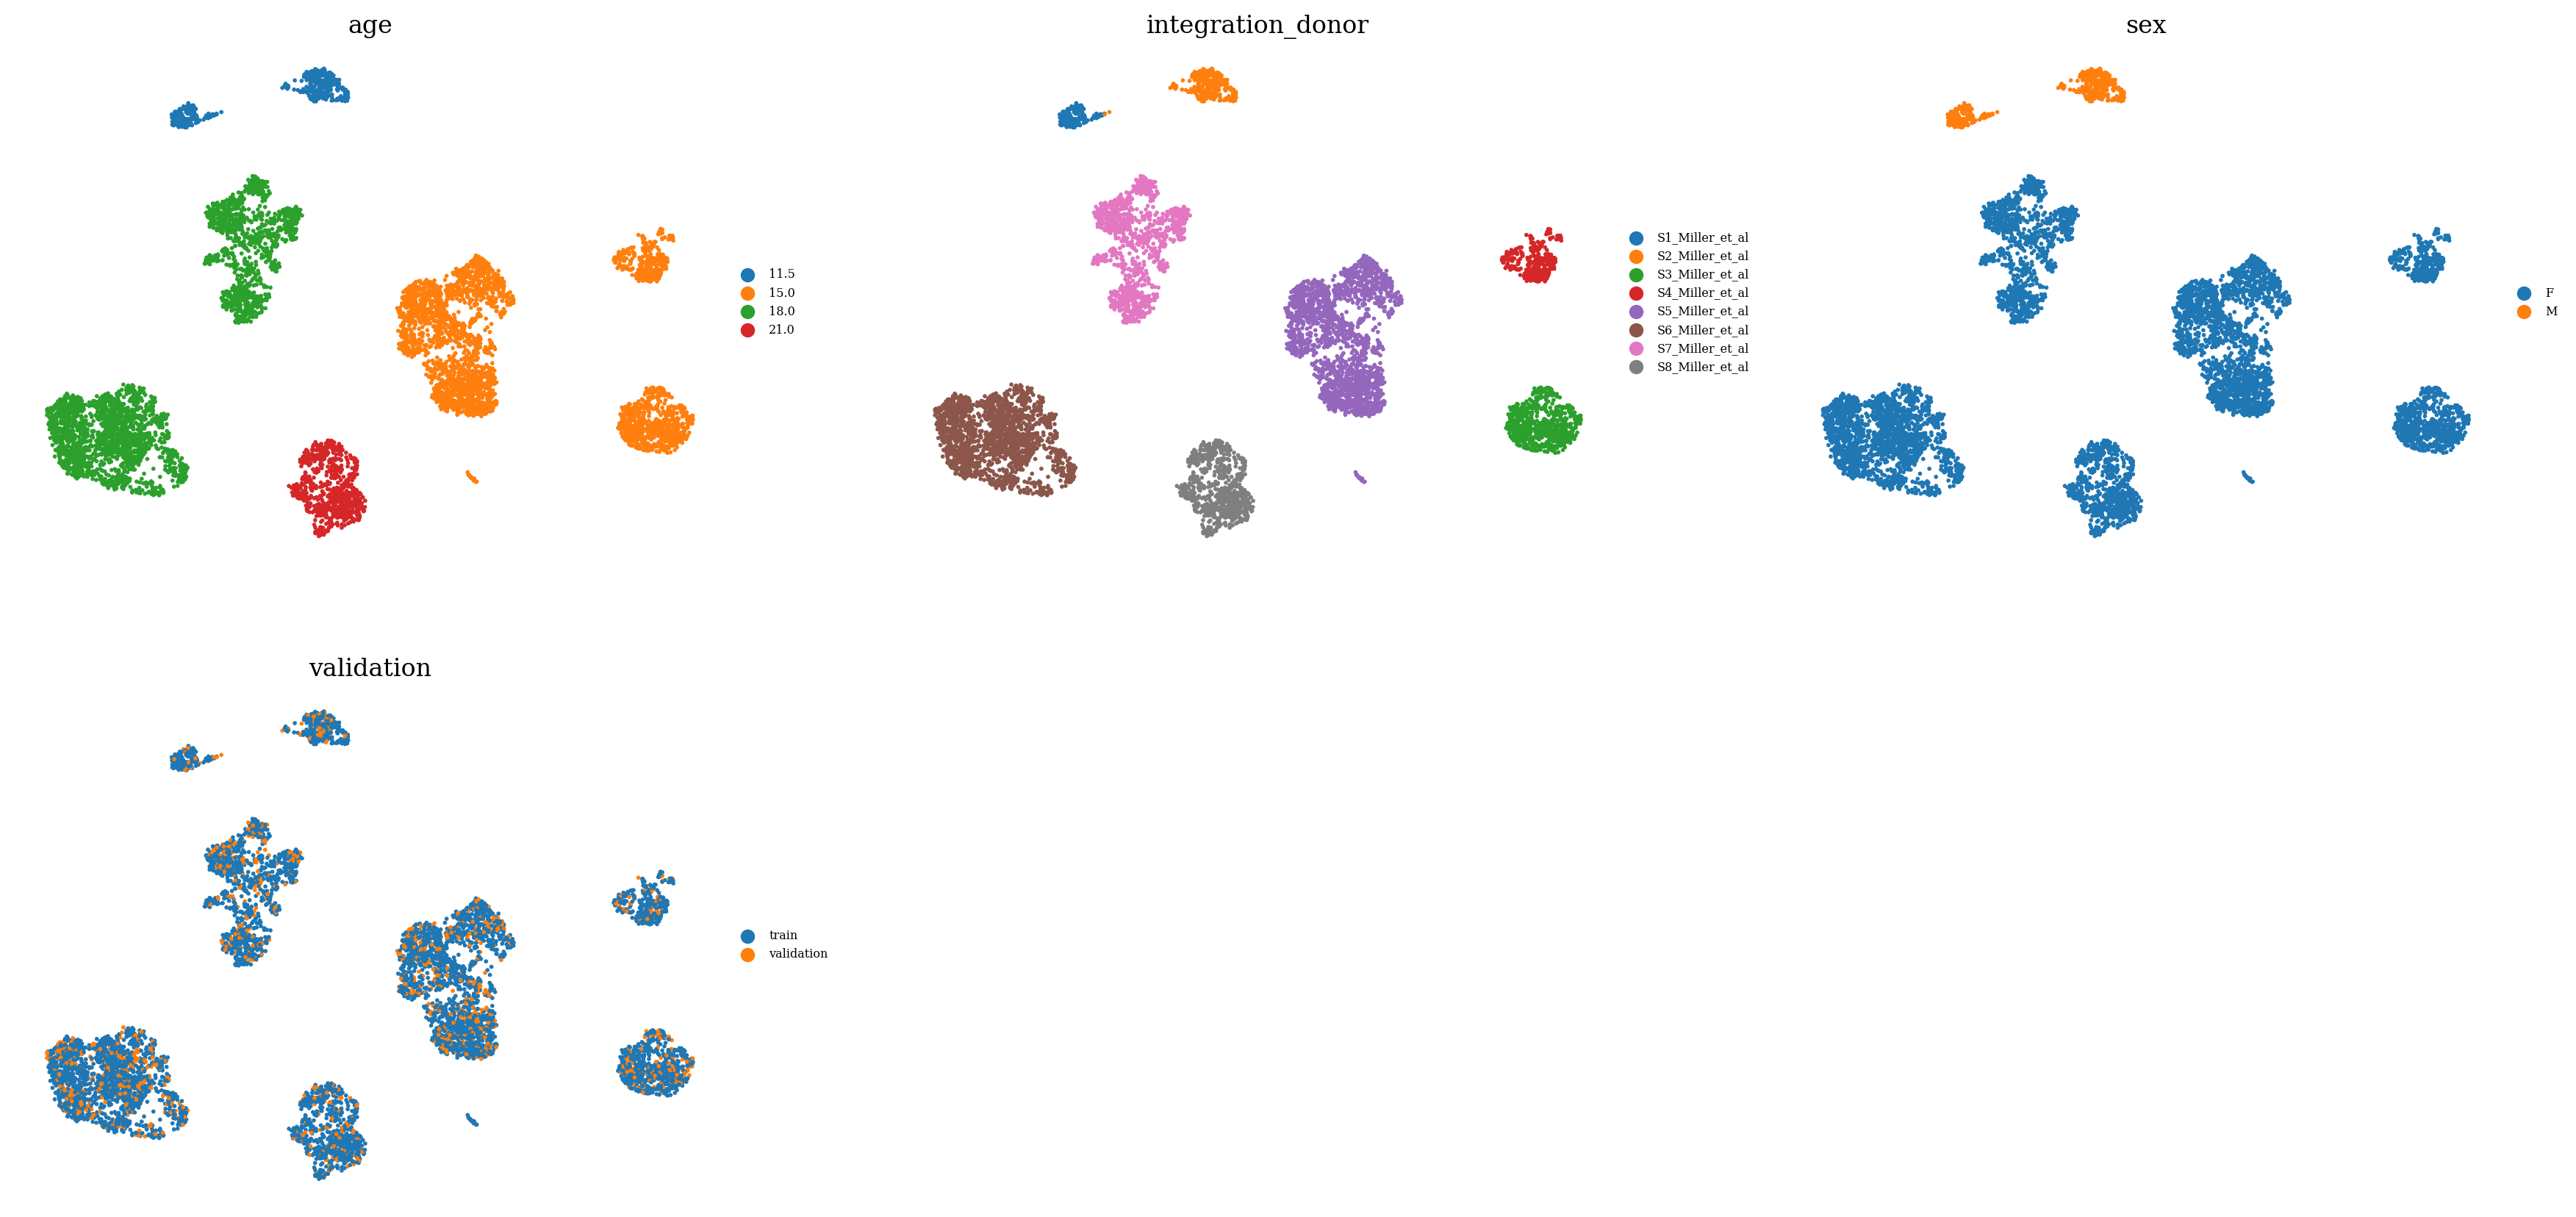

In [26]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["age", "integration_donor", "sex", "validation"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [27]:
from tardis._disentanglementmanager import DisentanglementManager as DM

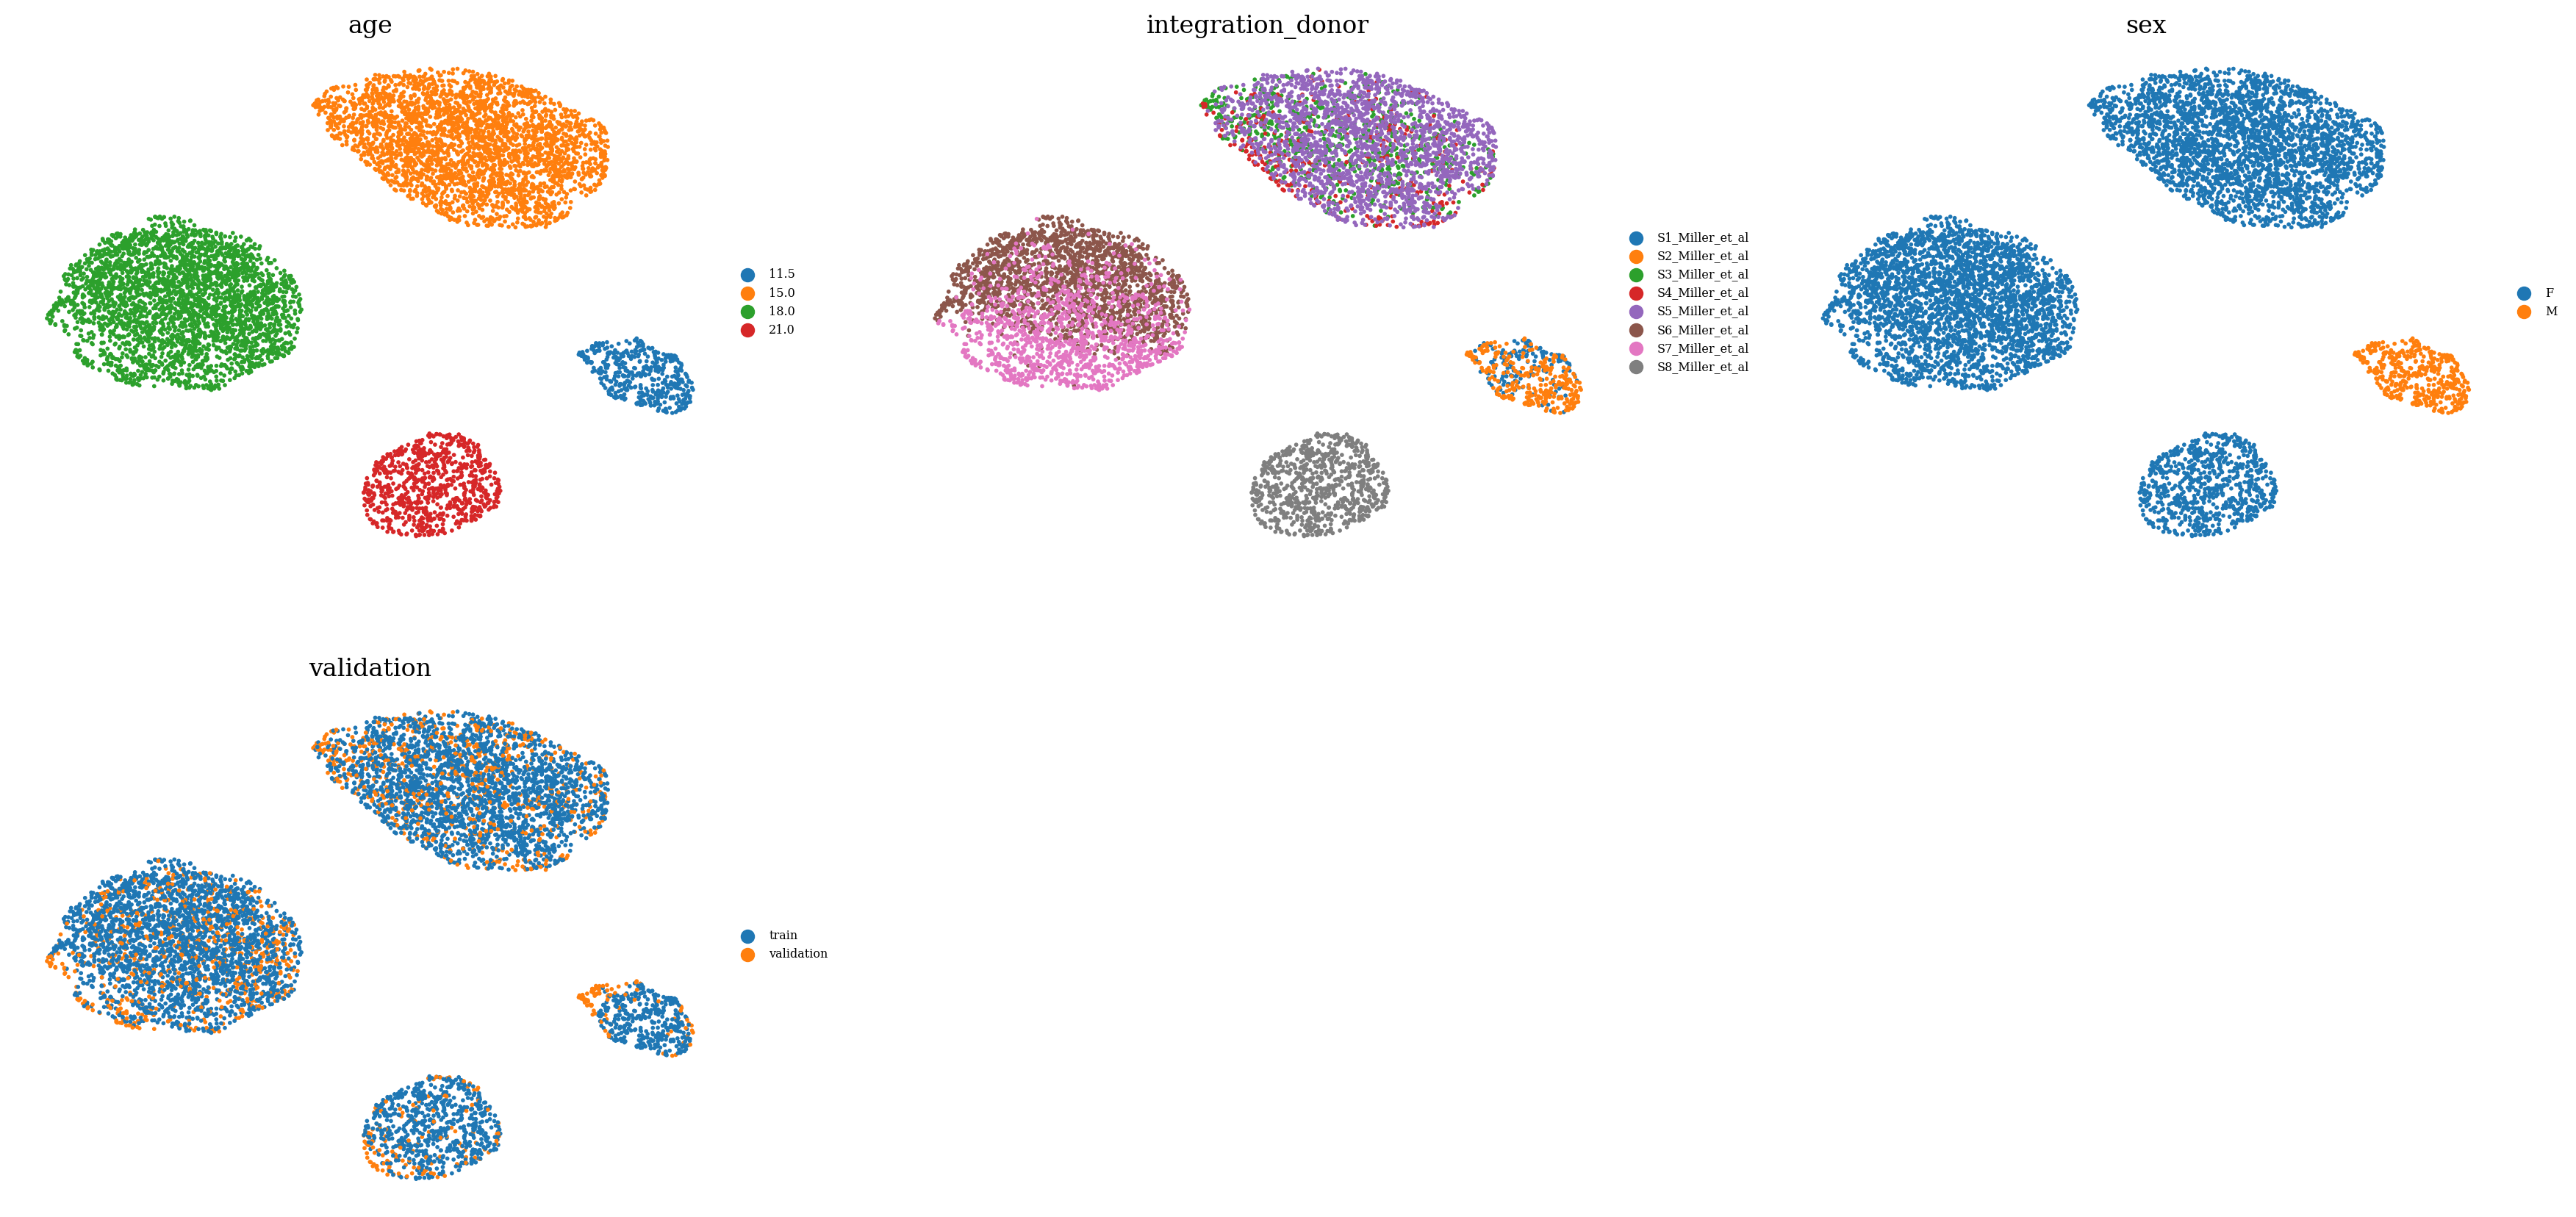

In [28]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["age", "integration_donor", "sex", "validation"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

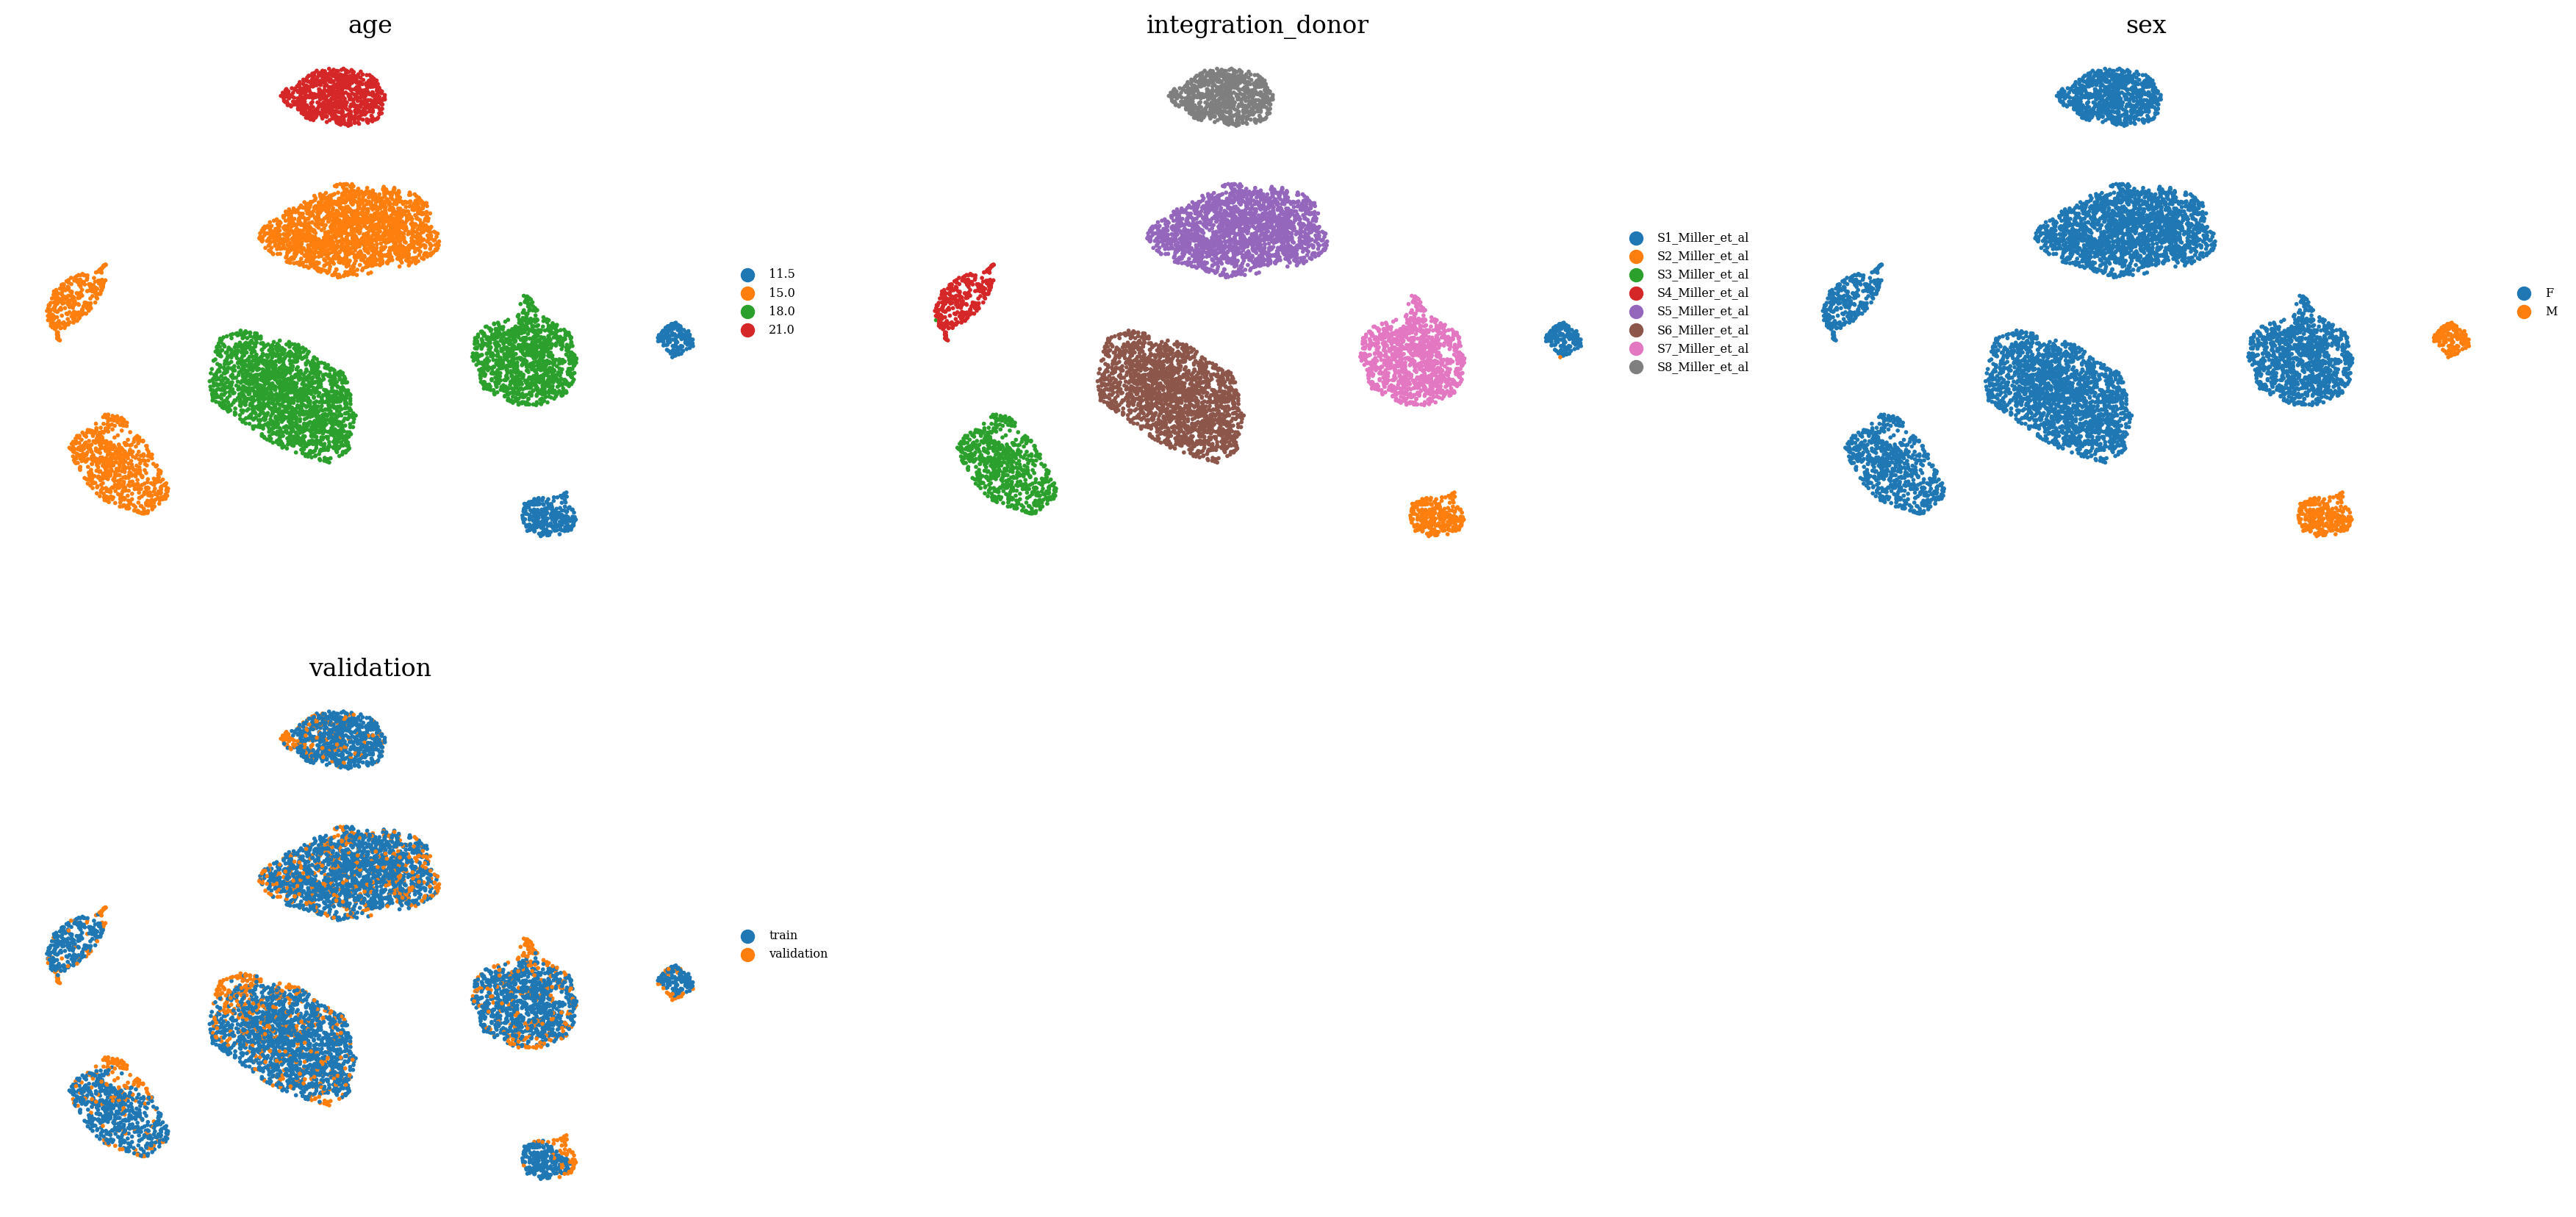

In [29]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key("integration_donor").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["age", "integration_donor", "sex", "validation"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [30]:
adata_main = ad.read_h5ad(adata_file_path)
adata_main.obs["age"] = adata_main.obs["age"].astype("str").astype("category")
adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")

adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()

In [31]:
# latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main)[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata_main.obs.copy())
latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main), obs=adata_main.obs.copy())
sc.pp.neighbors(latent_main, n_neighbors = 30)
sc.tl.umap(latent_main)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


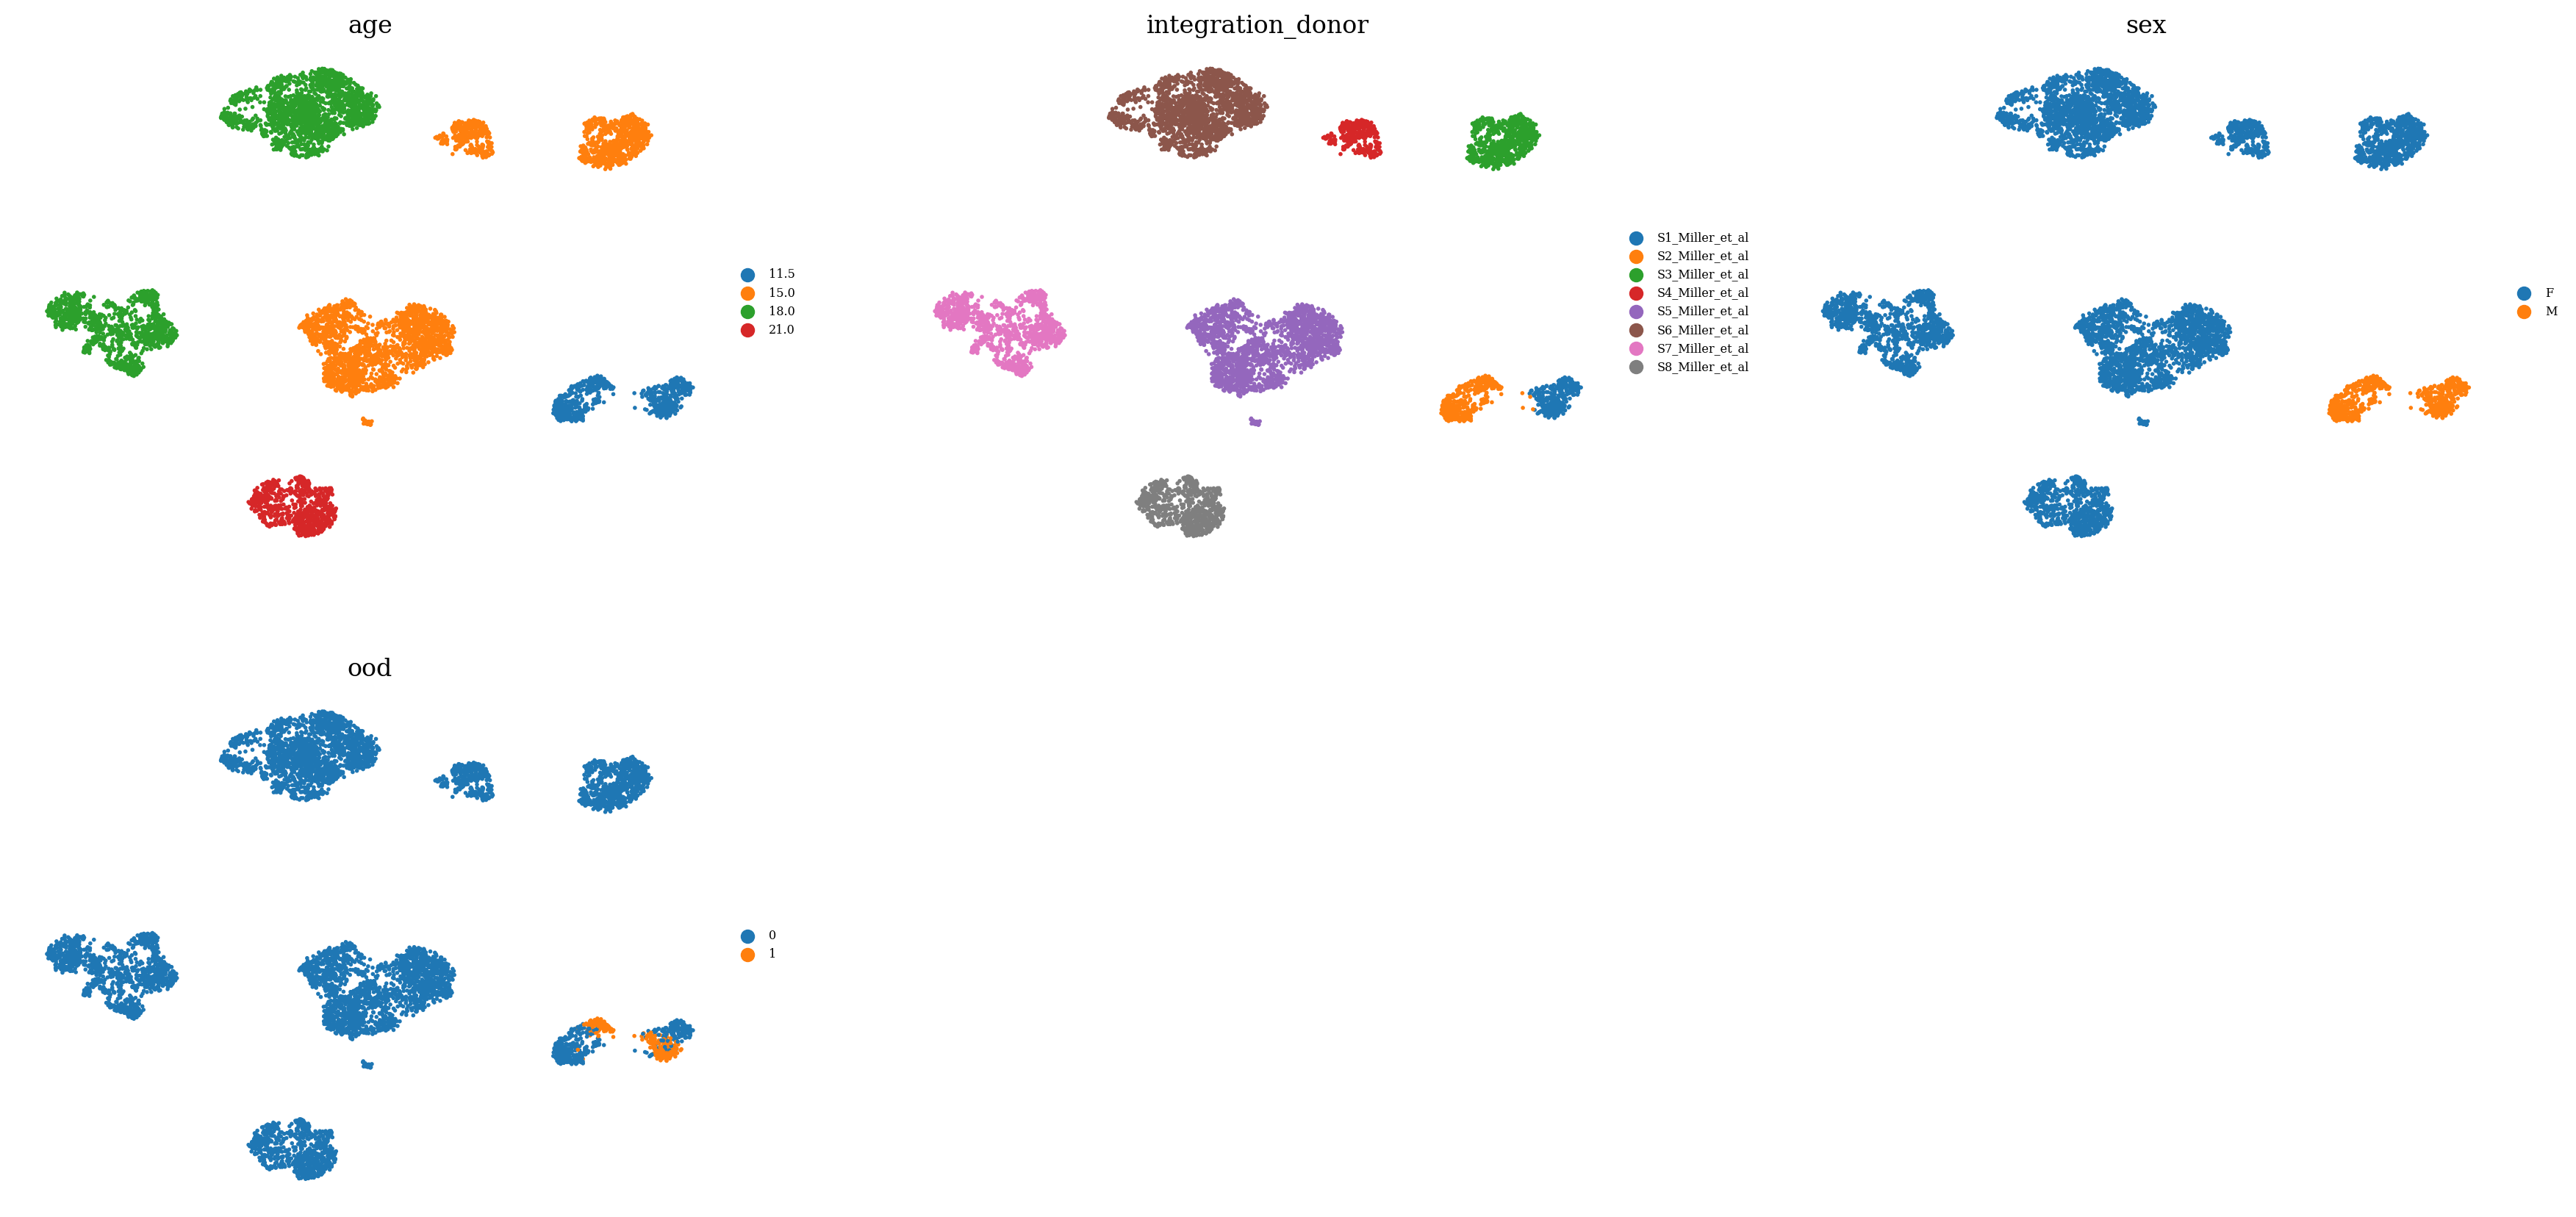

In [32]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_main, 
        color=["age", "integration_donor", "sex", "ood"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )